# Demo on Clustering

We will explore some clustering algoriths and cluster validation techniques in this demo. 

In [2]:
library(tidyverse)
library(latex2exp) # Latex in ggplot2 labels
cbPalette <- c(
  "#999999", "#E69F00", "#56B4E9", "#009E73",
  "#F0E442", "#0072B2", "#D55E00", "#CC79A7") # colour-blind friendly palette
# Packages for actual computation
# library(MASS)    # Contains mvrnorm to simulate multivariate normal
#                  # Use as MASS::mvrnorm is recommended since MASS::select
#                  # clashes with dplyr::select
# library(class)   # Classification algorithms
# library(FNN)     # Fast Nearest Neighbor Search Algorithms and Applications
# library(cluster) # For the clustering algorithm PAM and the cluster index
#                  # silhouette width


I revisit the classic iris data set and use a lowdimensional representation (PC) for illustration purposes. 

I cluster the data set using kmeans. Do the clusters we obtain overlap with the classes? 

Try with different number of clusters - what happens? (Rerun a couple of time for each K because kmeans starts with a random partition and results may vary). 

            
classes       1  2  3
  setosa     50  0  0
  versicolor  0 39 11
  virginica   0 14 36

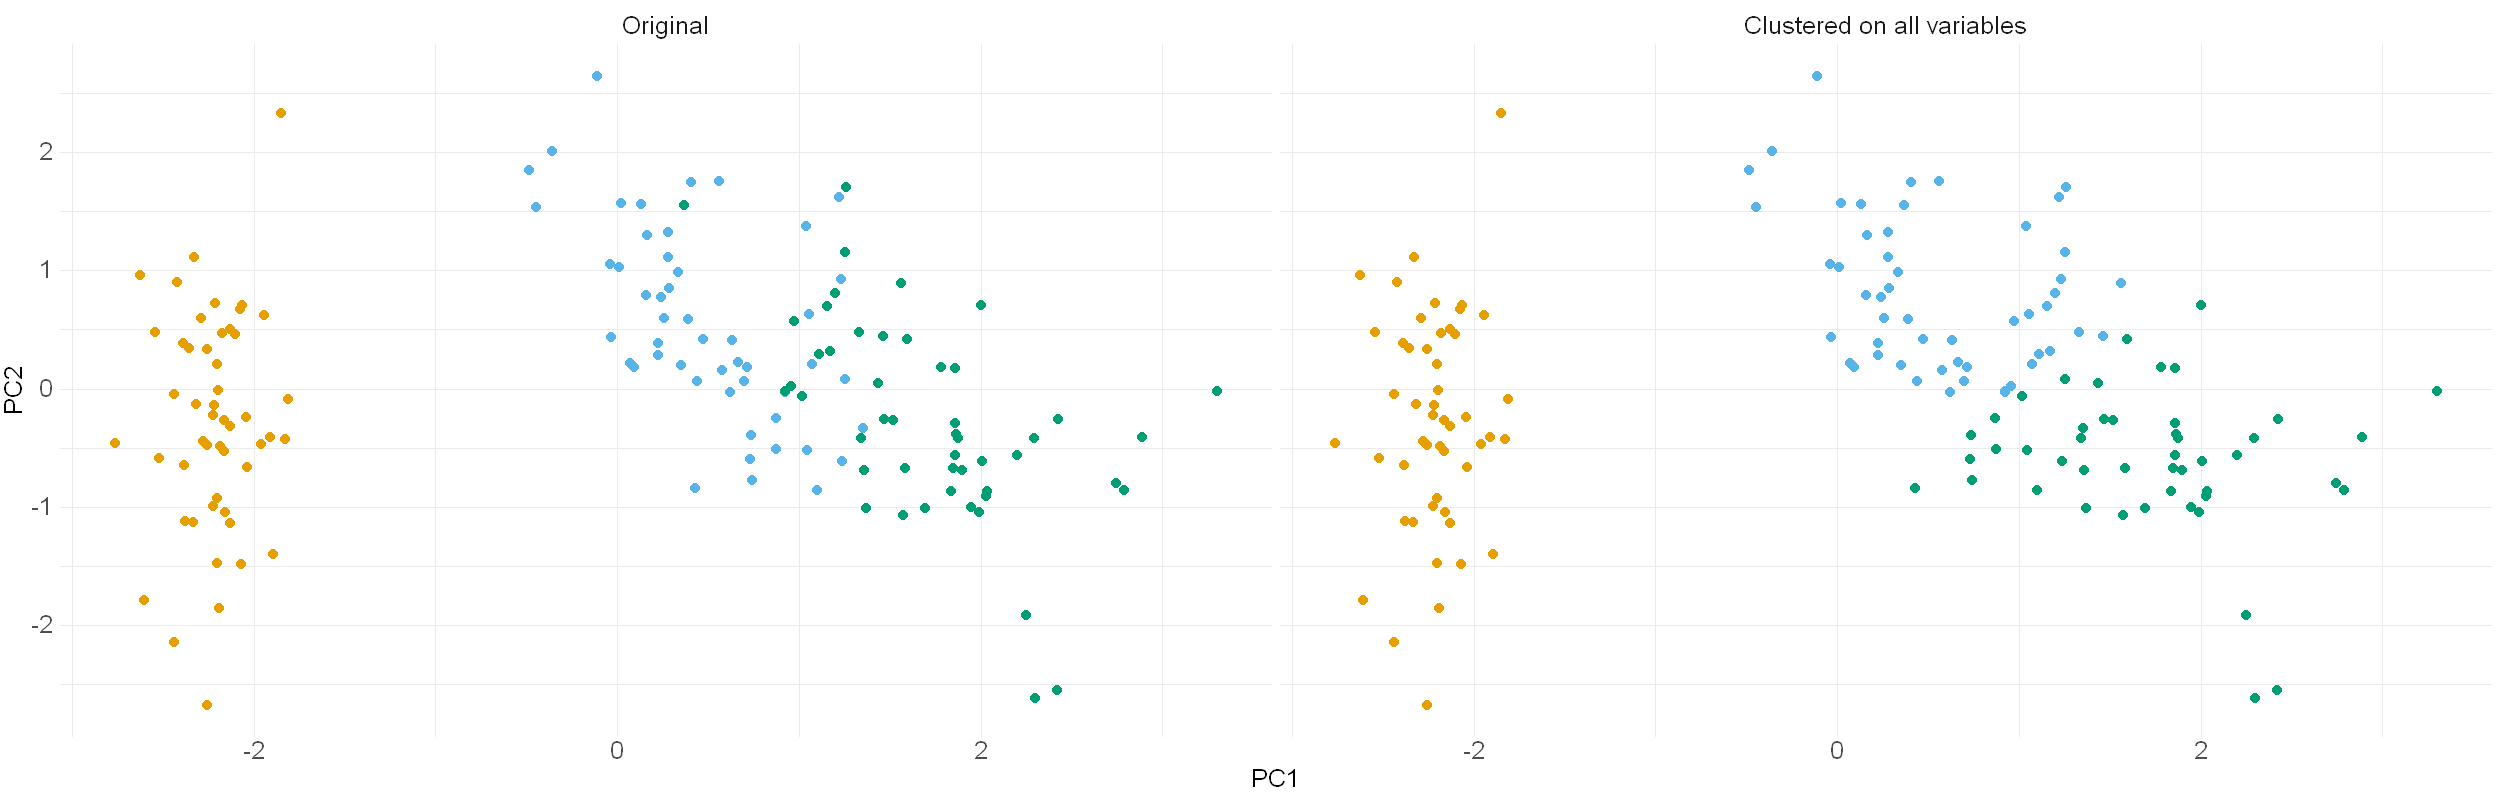

In [354]:
library(cluster)
library(datasets)
library(MASS)
data(iris)
#

options(repr.plot.width = 25, repr.plot.height = 8, repr.plot.res = 100)
X <- as.matrix(iris[,-5])
classes <- as_vector(iris[,5]) %>% unname

# Run k-means on features with three clusters
clust <- kmeans(scale(X), centers = 3)

# Project data on PCs for better visualisation
X_svd <- svd(scale(X))
X_proj <- scale(X) %*% X_svd$v[,1:2]

data_pca <- tibble(
  class = as.factor(
    c(as.numeric(classes), clust$cluster)),
  type = factor(rep(c(
    "Original", "Clustered on all variables"),
    each = length(classes)),
    levels = c(
    "Original", "Clustered on all variables")),
  PC1 = rep.int(X_proj[,1], 2),
  PC2 = rep.int(X_proj[,2], 2))

ggplot(data_pca) +
  geom_point(aes(x = PC1, y = PC2, colour = class), size = 3) +
  facet_wrap(~ type, ncol = 2) +
  scale_colour_manual(values = cbPalette[-1], guide = "none") +
  theme_minimal() +
  theme(
    axis.text = element_text(size = 18),
    axis.title = element_text(size = 18),
    strip.text = element_text(size = 18))


table(classes,clust$cluster)

When you rerun the above code you will notice that sometimes one class is split into two and sometimes the two classes that are overlapping are split instead. This illustrates that clustersing is a totaly different objective than class prediction. We are trying to find representations of data to, in this case since we're using kmeans, summarize the data from cluster representatives. 

What about K=2? Is this stable? Rerun the code a few times to see.

            
classes       1  2
  setosa      0 50
  versicolor 50  0
  virginica  50  0

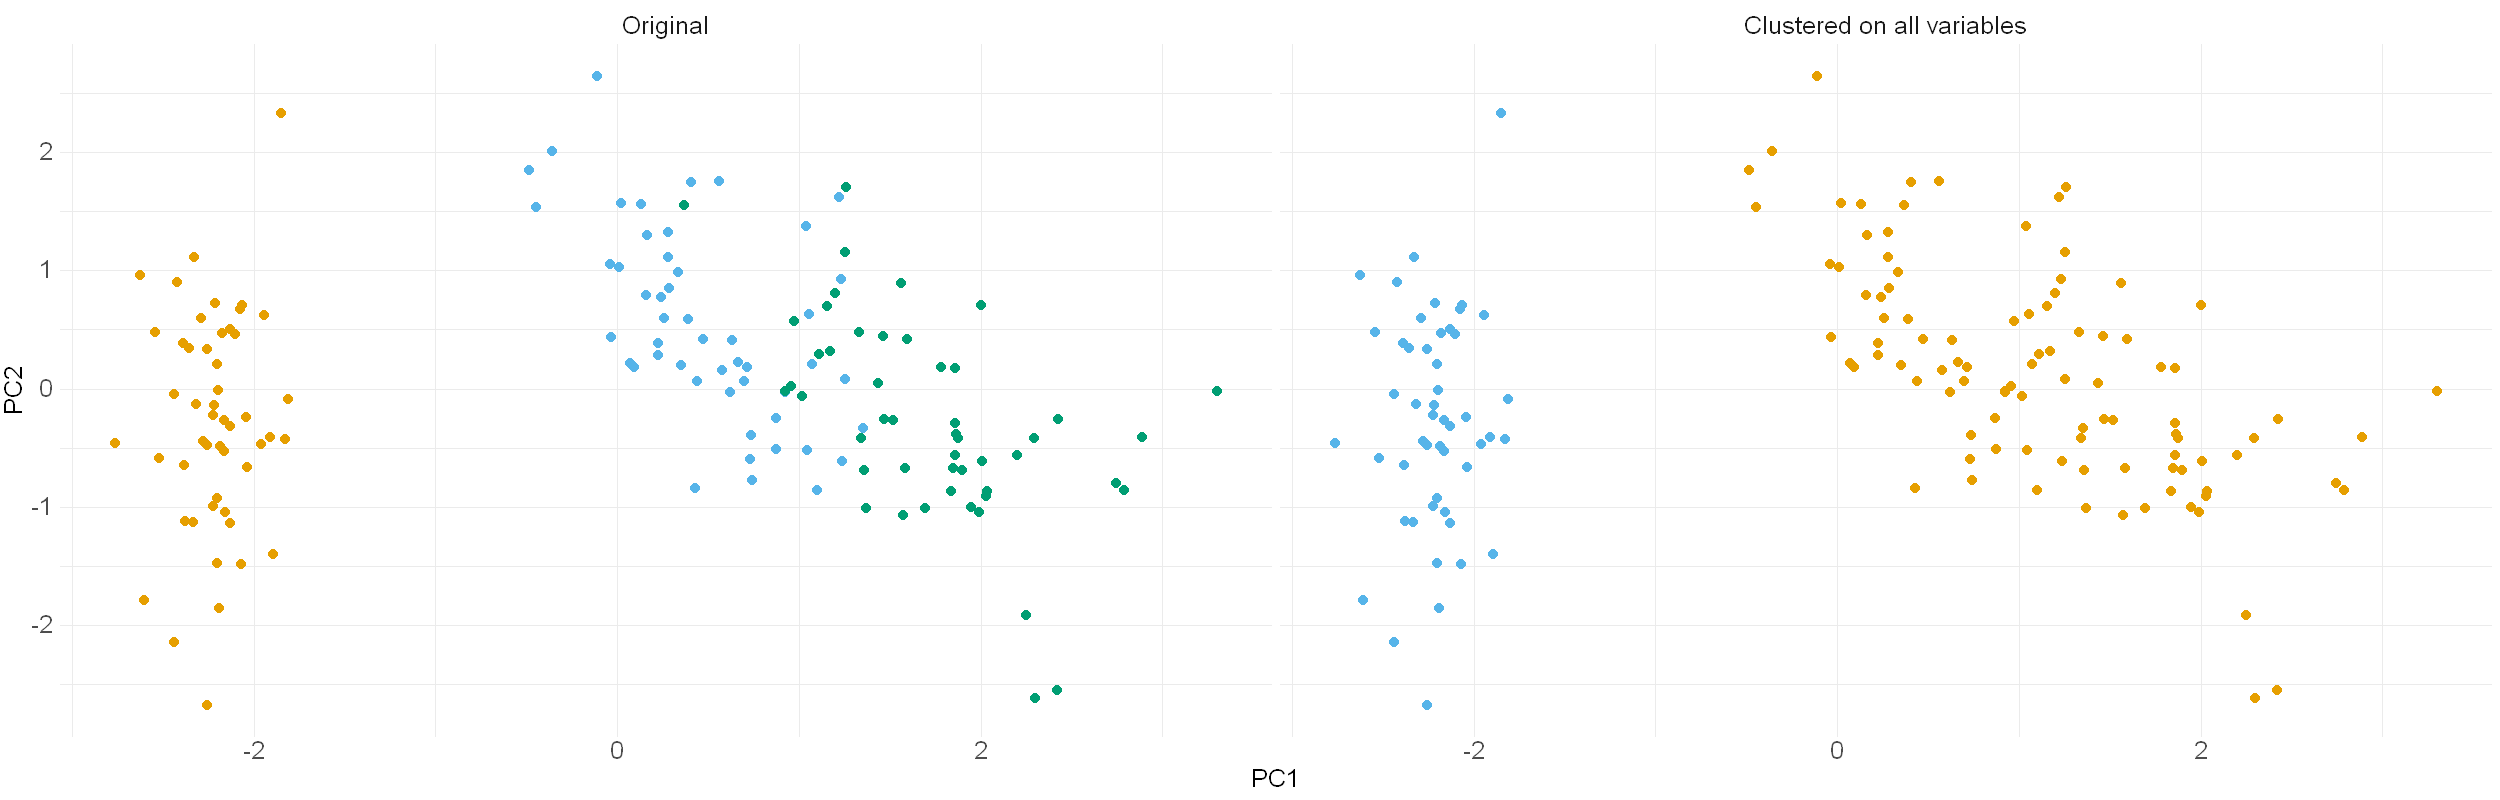

In [357]:
clust <- kmeans(scale(X), centers = 2)

# Project data on PCs for better visualisation
X_svd <- svd(scale(X))
X_proj <- scale(X) %*% X_svd$v[,1:2]

data_pca <- tibble(
  class = as.factor(
    c(as.numeric(classes), clust$cluster)),
  type = factor(rep(c(
    "Original", "Clustered on all variables"),
    each = length(classes)),
    levels = c(
    "Original", "Clustered on all variables")),
  PC1 = rep.int(X_proj[,1], 2),
  PC2 = rep.int(X_proj[,2], 2))


options(repr.plot.width = 25, repr.plot.height = 8, repr.plot.res = 100)
ggplot(data_pca) +
  geom_point(aes(x = PC1, y = PC2, colour = class), size = 3) +
  facet_wrap(~ type, ncol = 2) +
  scale_colour_manual(values = cbPalette[-1], guide = "none") +
  theme_minimal() +
  theme(
    axis.text = element_text(size = 18),
    axis.title = element_text(size = 18),
    strip.text = element_text(size = 18))


table(classes,clust$cluster)

The K=2 cluster is quite stable across multiple runs. 

So how many clusters should we use? For kmeans we usually look at how much the kmeans centroids explain the variance of the data as a function of K and choose a K where adding more no longer pays off (elbow method).

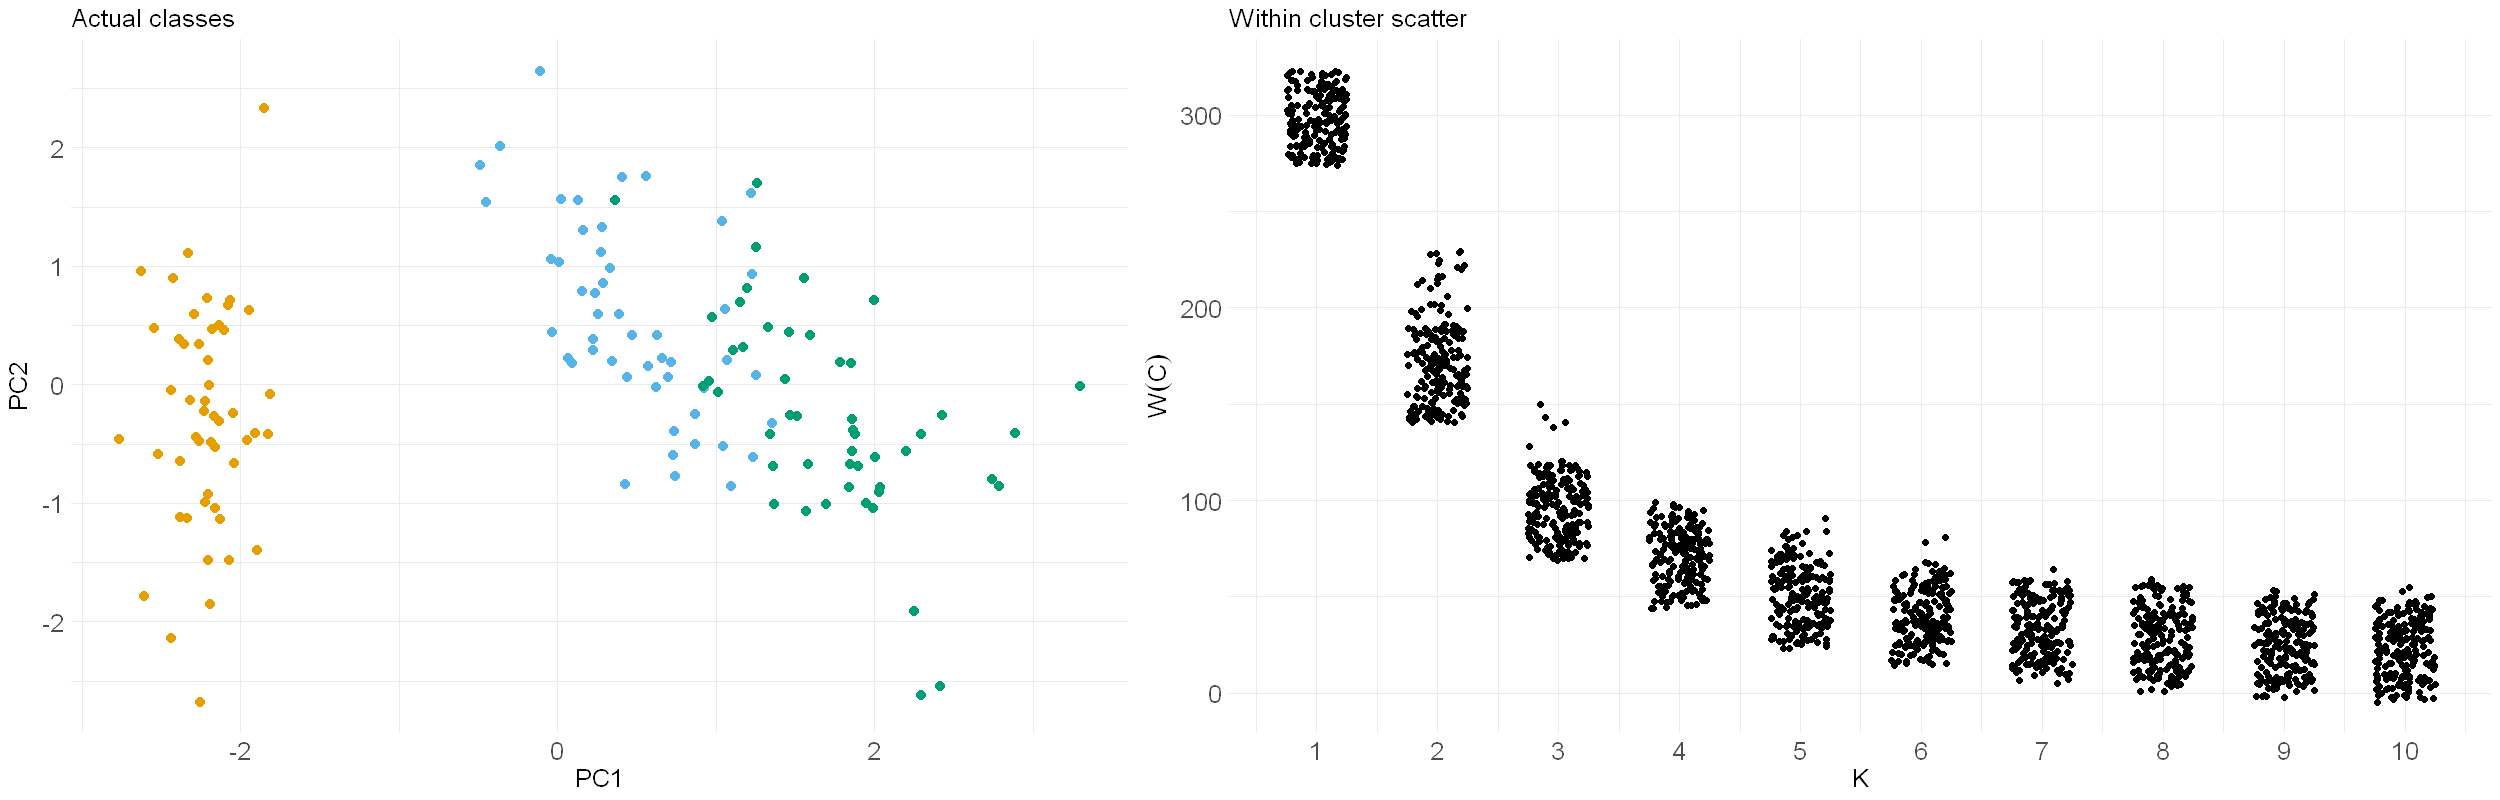

In [358]:
options(repr.plot.width = 25, repr.plot.height = 8, repr.plot.res = 100)

X <- as.matrix(iris[,-5])
classes <- as_vector(iris[,5]) %>% unname

# PCA on features
X_svd <- svd(scale(X))
X_proj <- scale(X) %*% X_svd$v[,1:2]

data_plot <- tibble(
  class = classes,
  PC1 = X_proj[,1],
  PC2 = X_proj[,2])

p1 <- ggplot(data_plot) +
  geom_point(aes(x = PC1, y = PC2, colour = class), size = 3) +
  scale_colour_manual(values = cbPalette[-1], guide = "none") +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 18),
    axis.title = element_text(size = 18),
    axis.text = element_text(size = 18)) +
  ggtitle("Actual classes")

# Run kmeans repeatedly for different number of clusters but also to
# capture variability with different staring centres
B <- 200
Kmax <- 10
within_scatter <- lapply(1:Kmax, function(K) {
  sapply(1:B, function(i) {
    kmeans(scale(X_proj), centers = K)$tot.withinss
  })
}) %>% do.call(rbind, .) %>%
  cbind(1:Kmax, .)
colnames(within_scatter) <- c("K", sprintf("rep%d", 1:B))

data_scatter_plot <- as_tibble(within_scatter) %>%
  gather(rep, value, -K) %>%
  mutate(rep = as.integer(str_replace(rep, "rep", "")))

p2 <- ggplot(data_scatter_plot) +
  geom_jitter(aes(x = K, y = value), size = 2, height = 25, width = 0.25) +
  scale_x_continuous(breaks = 1:10) +
  scale_y_continuous(TeX("$W(C)$")) +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 18),
    axis.title = element_text(size = 18),
    axis.text = element_text(size = 18)) +
  ggtitle("Within cluster scatter")

ggpubr::ggarrange(
  p1, p2, ncol = 2, widths = c(1, 1.2))

The within-cluster-spread levels off aorund 3-4 clusters.

Let's explore PAM and the silhouette width.  Below I use euclidean distance in PAM but remember that you can use any other distance metric you like here.

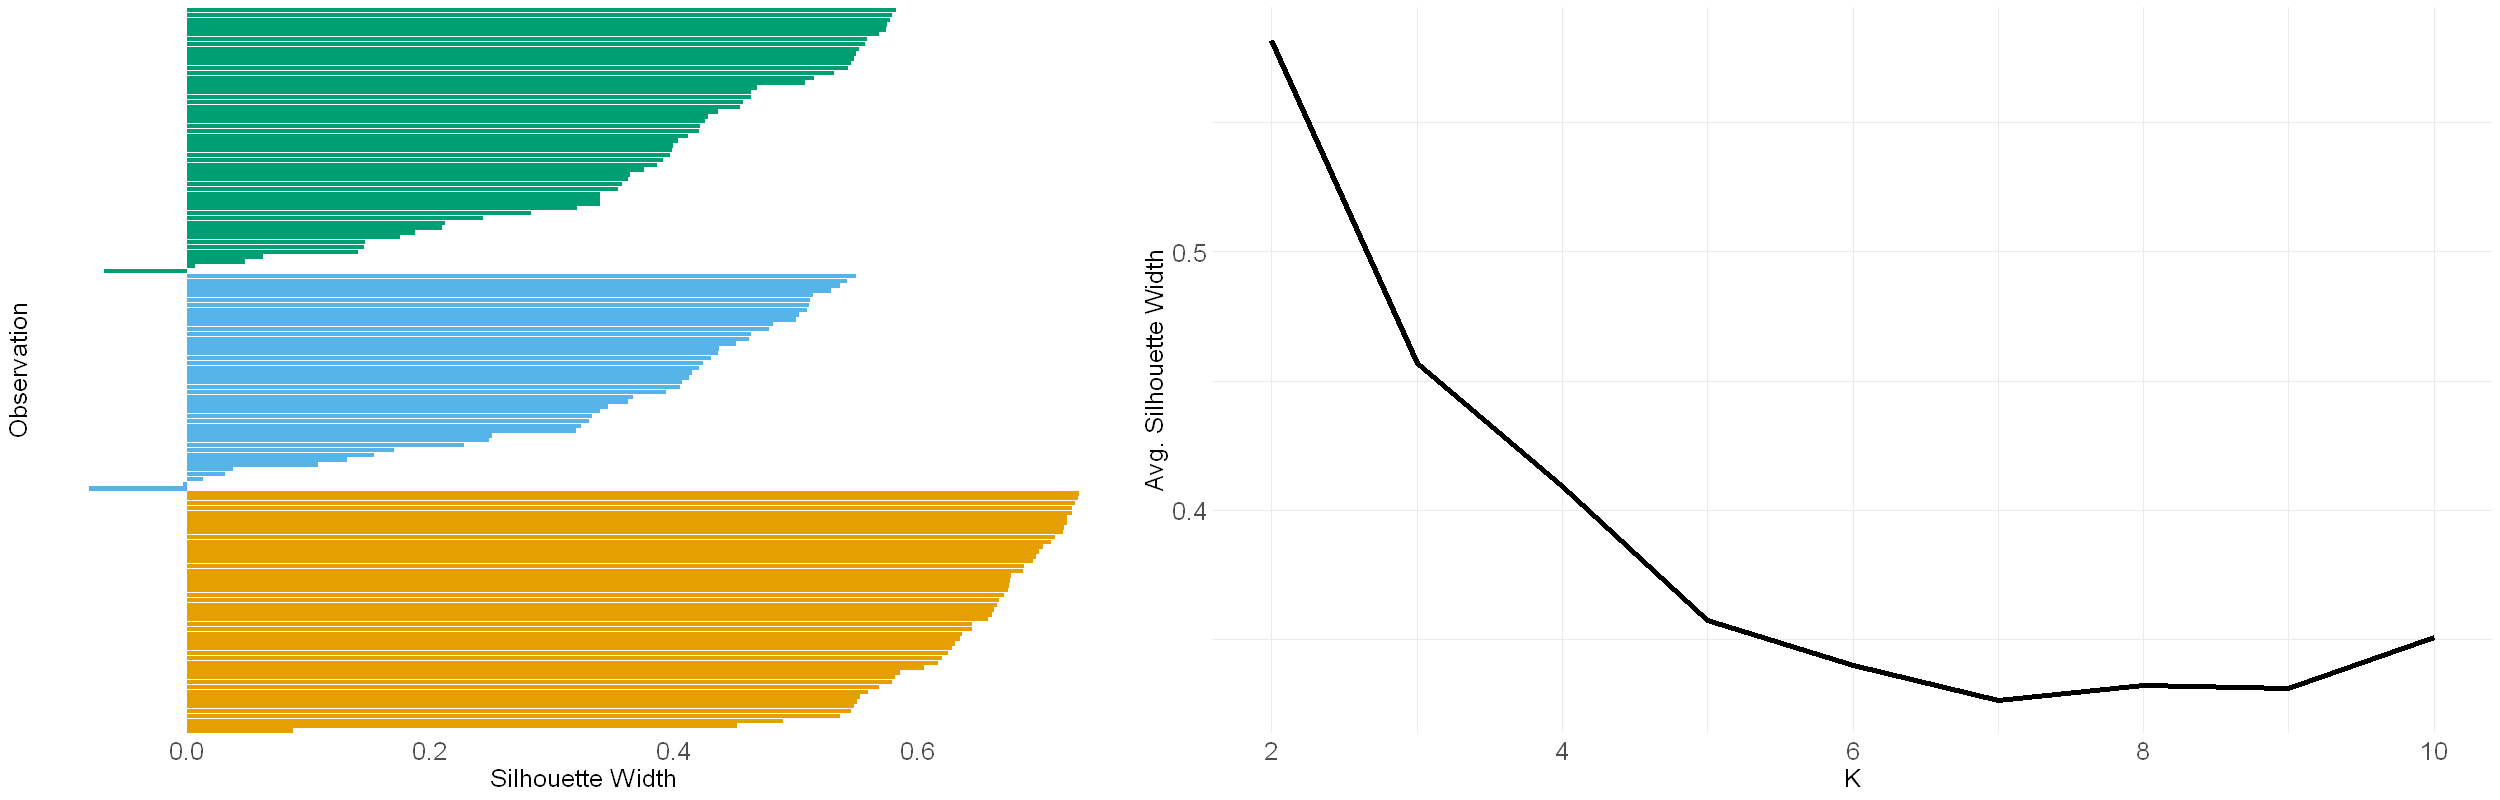

In [359]:
options(repr.plot.width = 25, repr.plot.height = 8, repr.plot.res = 100)


clust <- cluster::pam(scale(X), 3)
ss<-as.data.frame(cbind(clust=rep(0,length(clust$clustering)),sil=rep(0,length(clust$clustering))))
rownames(ss)<-seq(1,length(clust$clustering))
ss$clust[inde]<-clust$silinfo$widths[,1]
ss$sil[inde]<-clust$silinfo$widths[,3]

data_plot <- tibble(
  obs = as.factor(rownames(ss)),
  cluster = as.factor(ss[,1]),
  sw = ss[,2]) %>%   # Silhouette width
  arrange(cluster, sw) %>%
  mutate(obs = factor(obs, levels = obs))

p1 <- ggplot(data_plot) +
  geom_bar(aes(x = obs, y = sw, fill = cluster), stat = "identity") +
  coord_flip() +
  scale_x_discrete("Observation") +
  scale_y_continuous(
    "Silhouette Width", breaks = seq(-1, 1, by = 0.2)) +
  scale_fill_manual(values = cbPalette[-1], guide = "none") +
  theme_minimal() +
  theme(
    panel.grid = element_blank(),
    axis.text.y = element_blank(),
    axis.text.x = element_text(size = 18),
    axis.title = element_text(size = 18))

# Average silhouette width
Kmax <- 10
avg_sws <- sapply(2:Kmax, function(K) {
  mean(cluster::silhouette(
    cluster::pam(scale(X), K))[,3])
})

data_plot <- tibble(
  K = 2:Kmax,
  avg_sw = avg_sws)

p2 <- ggplot(data_plot) +
  geom_line(aes(x = K, y = avg_sw),lwd=2) +
  scale_y_continuous("Avg. Silhouette Width") +
  theme_minimal() +
  theme(
    axis.text = element_text(size = 18),
    axis.title = element_text(size = 18))

ggpubr::ggarrange(
  p1, p2, ncol = 2, widths = c(1, 1.2))


The silhouette widths look good in that most observations are well localized within their cluster. A few have small or negative silhouette widths. If you average the silhouette widths across observations and compare across K, it appears 2 clusters is the most suported choice.

I on purpose separate the classes more and rerun the algorithm.

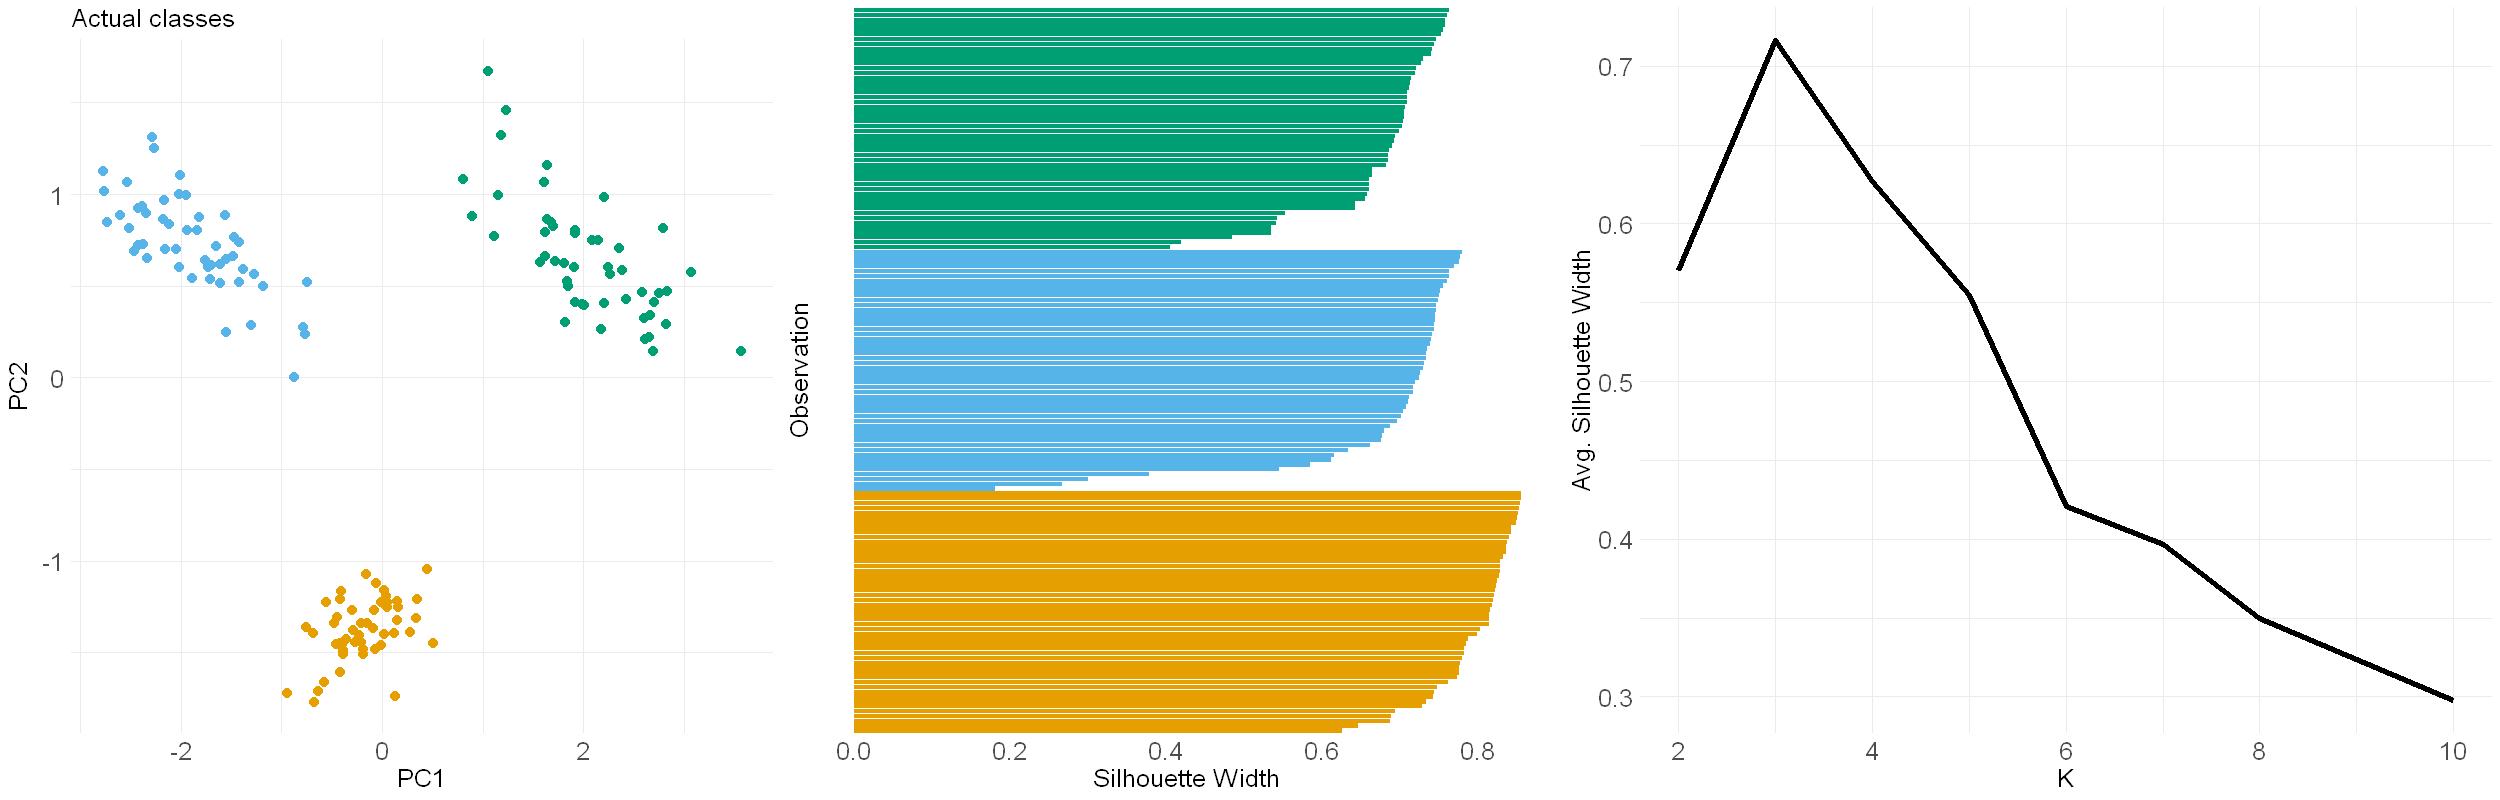

In [360]:
options(repr.plot.width = 25, repr.plot.height = 8, repr.plot.res = 100)

Xn <- as.matrix(iris[,-5])
classes <- as_vector(iris[,5]) %>% unname
Xn[classes=="virginica",]<-Xn[classes=="virginica",]-3


Xn_svd <- svd(scale(Xn))
Xn_proj <- scale(Xn) %*% Xn_svd$v[,1:2]

data_plot <- tibble(
  class = classes,
  PC1 = Xn_proj[,1],
  PC2 = Xn_proj[,2])

p0 <- ggplot(data_plot) +
  geom_point(aes(x = PC1, y = PC2, colour = class), size = 3) +
  scale_colour_manual(values = cbPalette[-1], guide = "none") +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 18),
    axis.title = element_text(size = 18),
    axis.text = element_text(size = 18)) +
  ggtitle("Actual classes")

clust <- cluster::pam(scale(Xn), 3)
ss<-as.data.frame(cbind(clust=rep(0,length(clust$clustering)),sil=rep(0,length(clust$clustering))))
rownames(ss)<-seq(1,length(clust$clustering))
ss$clust[inde]<-clust$silinfo$widths[,1]
ss$sil[inde]<-clust$silinfo$widths[,3]



data_plot <- tibble(
  obs = as.factor(rownames(ss)),
  cluster = as.factor(clust$clustering),
  sw = ss[,2]) %>%   # Silhouette width
  arrange(cluster, sw) %>%
  mutate(obs = factor(obs, levels = obs))

data_plot <- tibble(
  obs = as.factor(rownames(ss)),
  cluster = as.factor(ss[,1]),
  sw = ss[,2]) %>%   # Silhouette width
  arrange(cluster, sw) %>%
  mutate(obs = factor(obs, levels = obs))

p1 <- ggplot(data_plot) +
  geom_bar(aes(x = obs, y = sw, fill = cluster), stat = "identity") +
  coord_flip() +
  scale_x_discrete("Observation") +
  scale_y_continuous(
    "Silhouette Width", breaks = seq(-1, 1, by = 0.2)) +
  scale_fill_manual(values = cbPalette[-1], guide = "none") +
  theme_minimal() +
  theme(
    panel.grid = element_blank(),
    axis.text.y = element_blank(),
    axis.text.x = element_text(size = 18),
    axis.title = element_text(size = 18))

# Average silhouette width
Kmax <- 10
avg_sws <- sapply(2:Kmax, function(K) {
  mean(cluster::silhouette(
    cluster::pam(scale(Xn), K))[,3])
})

data_plot <- tibble(
  K = 2:Kmax,
  avg_sw = avg_sws)

p2 <- ggplot(data_plot) +
  geom_line(aes(x = K, y = avg_sw),lwd=2) +
  scale_y_continuous("Avg. Silhouette Width") +
  theme_minimal() +
  theme(
    axis.text = element_text(size = 18),
    axis.title = element_text(size = 18))

ggpubr::ggarrange(
  p0, p1, p2, ncol = 3, widths = c(1, 1, 1.2))


Now the silhouette widths indicate that 3 clusters is the best choice.

We can highlight which observations are difficult to cluster by checking their silhouette widths. Here, I display the observations with negative silhouette widths. 

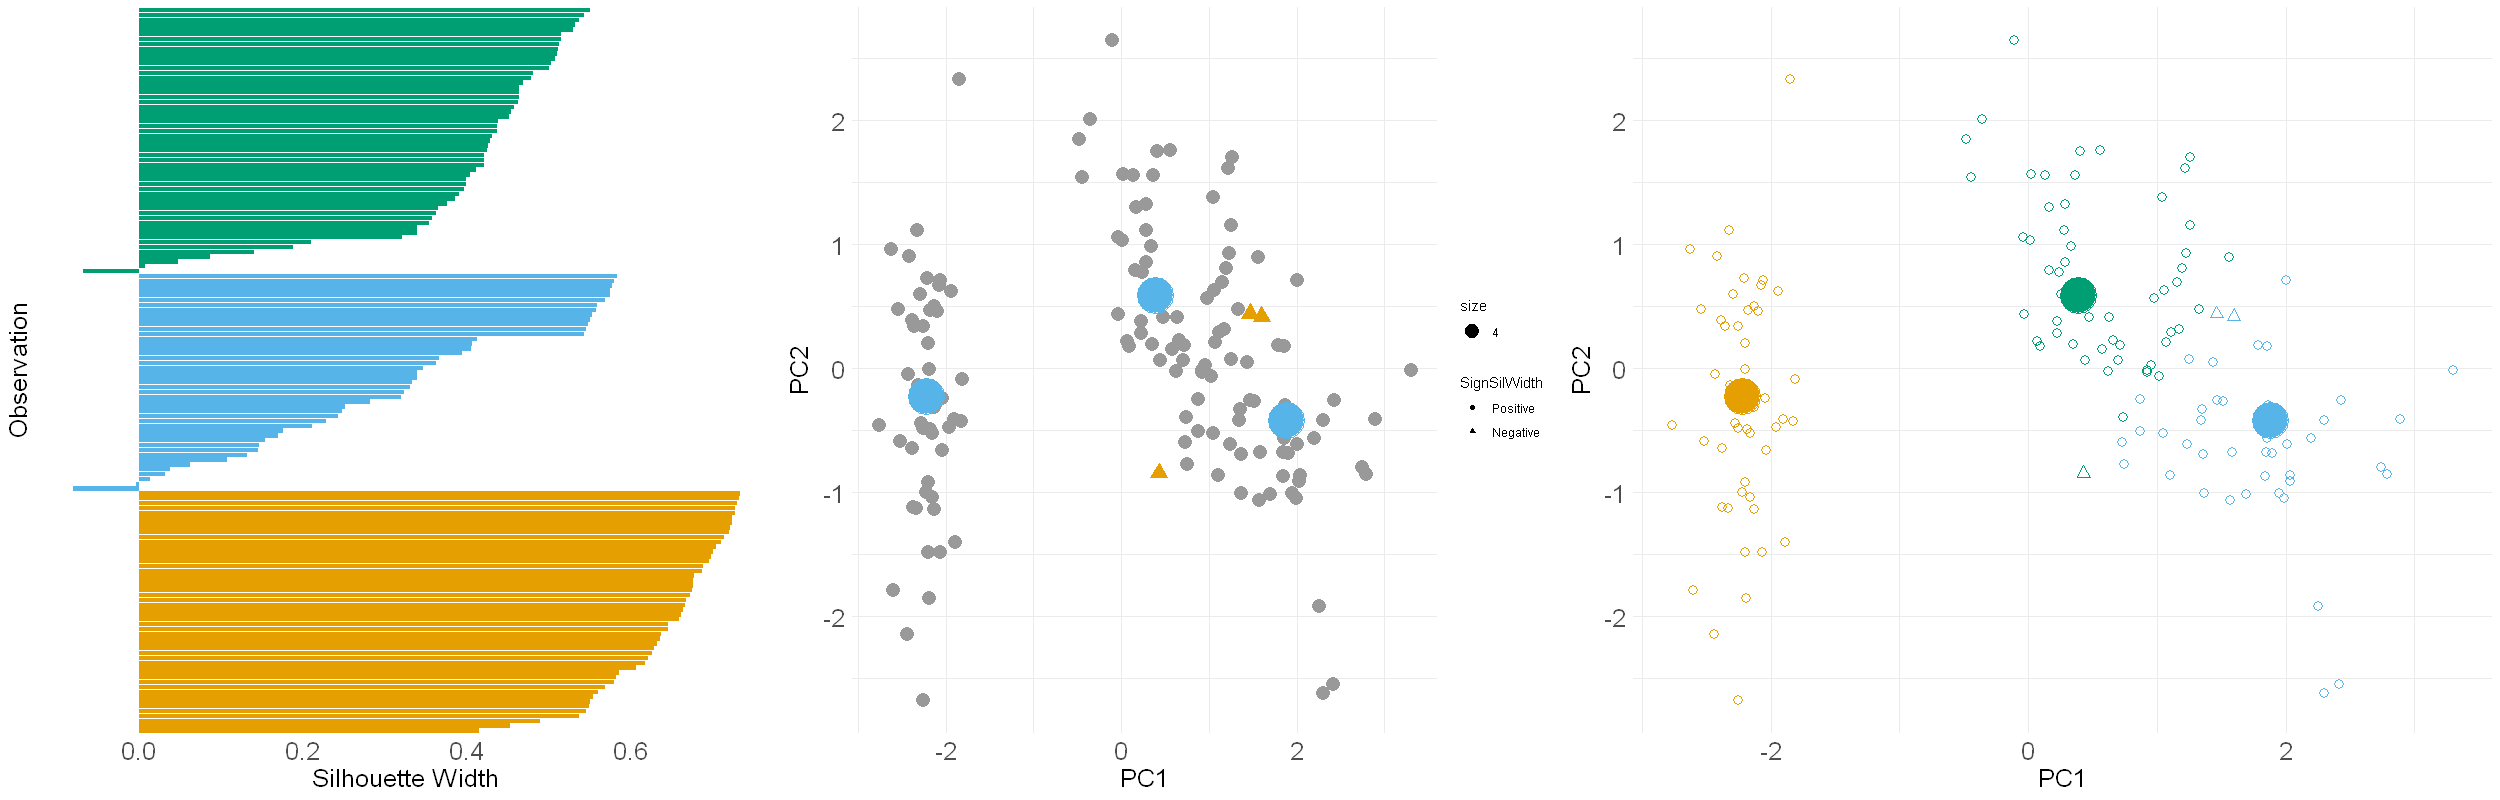

In [361]:
options(repr.plot.width = 25, repr.plot.height = 8, repr.plot.res = 100)

X_svd <- svd(scale(X))
X_proj <- scale(X) %*% X_svd$v[,1:2]


clust <- cluster::pam(scale(X), 3)

ss<-as.data.frame(cbind(clust=rep(0,length(clust$clustering)),sil=rep(0,length(clust$clustering))))
rownames(ss)<-seq(1,length(clust$clustering))
ss$clust[inde]<-clust$silinfo$widths[,1]
ss$sil[inde]<-clust$silinfo$widths[,3]



data_plot <- tibble(
  obs = as.factor(rownames(ss)),
  cluster = as.factor(clust$clustering),
  sw = ss[,2]) %>%   # Silhouette width
  arrange(cluster, sw) %>%
  mutate(obs = factor(obs, levels = obs))

p0 <- ggplot(data_plot) +
  geom_bar(aes(x = obs, y = sw, fill = cluster), stat = "identity") +
  coord_flip() +
  scale_x_discrete("Observation") +
  scale_y_continuous(
    "Silhouette Width", breaks = seq(-1, 1, by = 0.2)) +
  scale_fill_manual(values = cbPalette[-1], guide = "none") +
  theme_minimal() +
  theme(
    panel.grid = element_blank(),
    axis.text.y = element_blank(),
    axis.text.x = element_text(size = 18),
    axis.title = element_text(size = 18))


# Silhouette width values are ordered, so we need to entangle them first
data_plot <- tibble(
  ind = 1:nrow(X) %in% as.integer(names(which(clust$silinfo$widths[,3] < 0))),
  class = as.factor(clust$clustering),
  PC1 = X_proj[,1],
  PC2 = X_proj[,2]) %>%
  mutate(SignSilWidth = factor(case_when(
    ind == TRUE ~ "Negative",
    ind == FALSE ~ "Positive"), levels = c("Positive", "Negative"))) %>%
  dplyr::select(SignSilWidth, class, PC1, PC2)

p1 <- ggplot(data_plot) +
  geom_point(aes(x = PC1, y = PC2, colour = SignSilWidth, shape = SignSilWidth, size=4)) +
  geom_point(aes(x = PC1, y = PC2), colour = cbPalette[3],
    data = tibble(
      PC1 = X_proj[clust$id.med, 1],
      PC2 = X_proj[clust$id.med, 2]), size = 12) +
  scale_colour_manual(values = cbPalette, guide = "none") +
  theme_minimal() +
  theme(
    axis.text = element_text(size = 18),
    axis.title = element_text(size = 18))

p2 <- ggplot(data_plot, aes(x = PC1, y = PC2, colour = class)) +
  geom_point(size=3, shape=data_plot$SignSilWidth) +
  geom_point(data = tibble(
      class = as.factor(clust$clustering[clust$id.med]),
      PC1 = X_proj[clust$id.med, 1],
      PC2 = X_proj[clust$id.med, 2]), size = 12) +
  scale_colour_manual(values = cbPalette[-1], guide = "none") +
  theme_minimal() +
  theme(
    axis.text = element_text(size = 18),
    axis.title = element_text(size = 18))

ggpubr::ggarrange(
  p0, p1, p2, ncol = 3, widths = c(1, 1, 1.2))


The orange dots in the middle figure and triangles in the right figure have negative silhouette width.

What happens if you ask for more clusters?

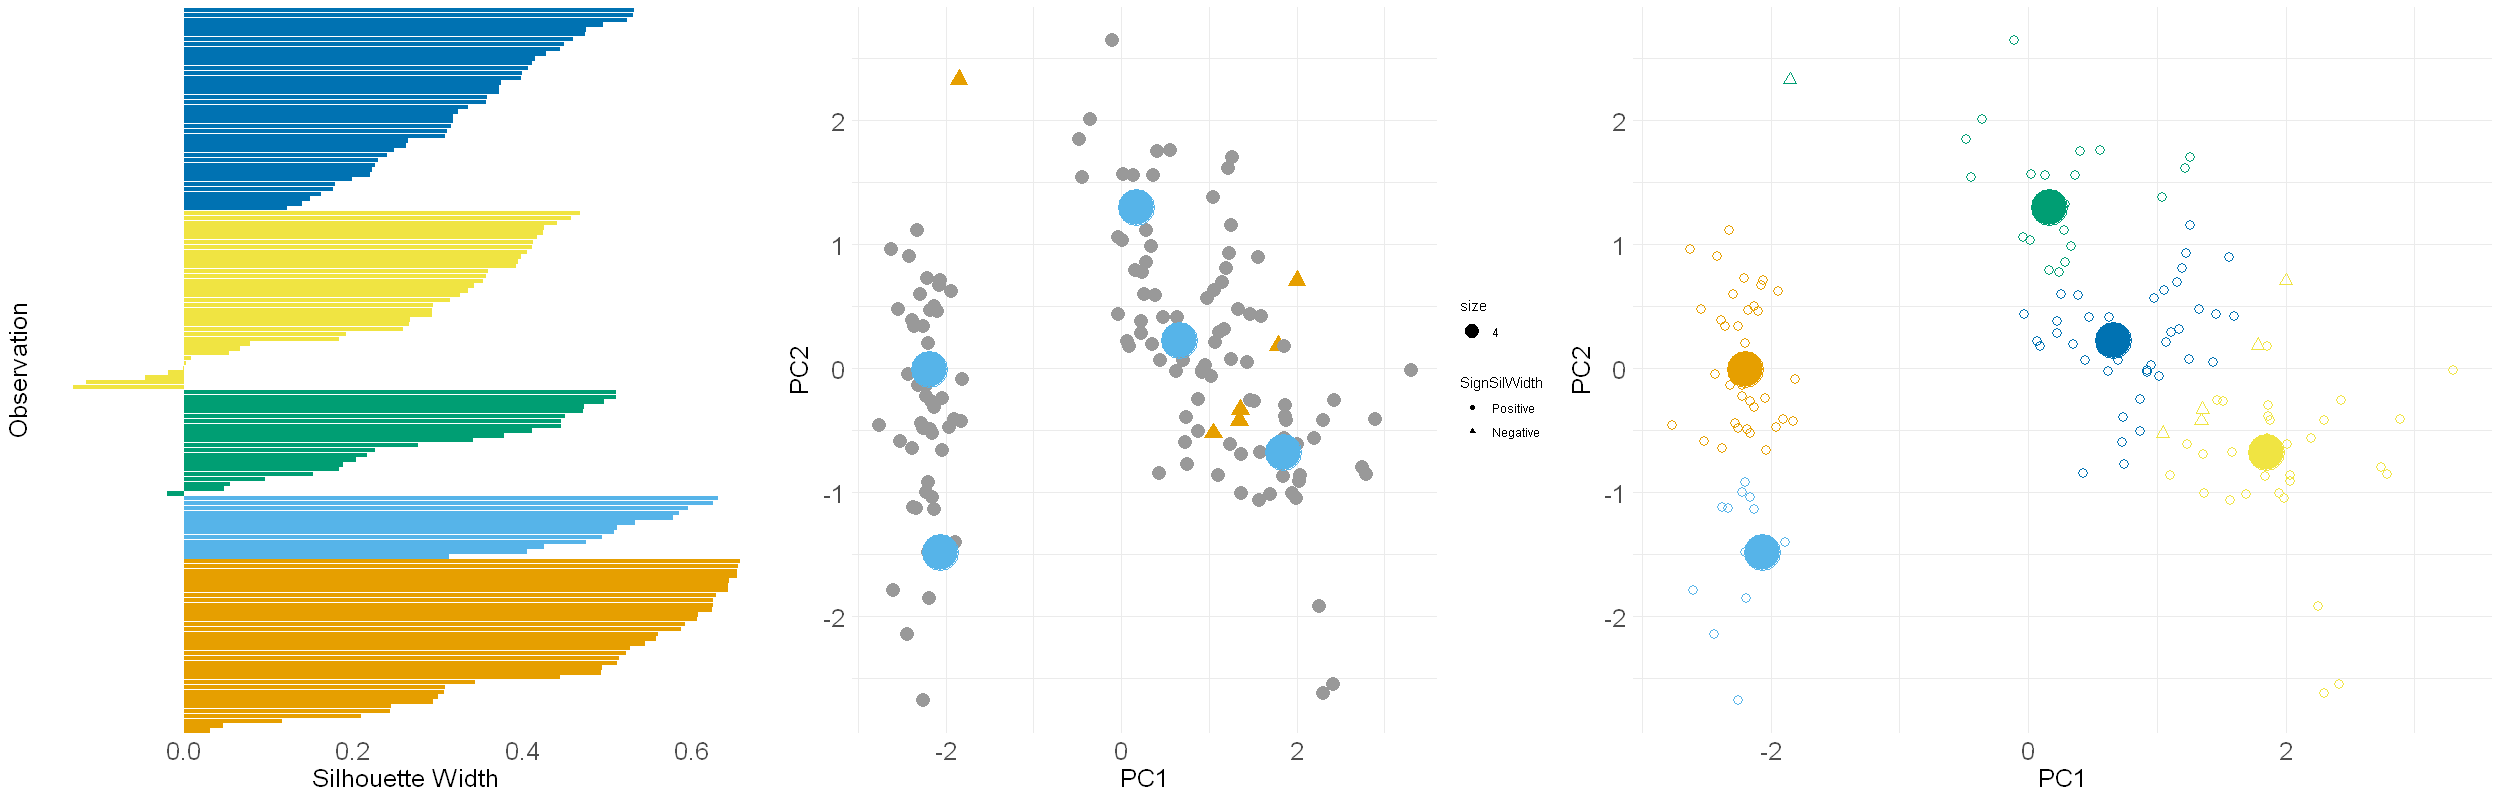

In [364]:
options(repr.plot.width = 25, repr.plot.height = 8, repr.plot.res = 100)

X_svd <- svd(scale(X))
X_proj <- scale(X) %*% X_svd$v[,1:2]


clust <- cluster::pam(scale(X), 5)

ss<-as.data.frame(cbind(clust=rep(0,length(clust$clustering)),sil=rep(0,length(clust$clustering))))
rownames(ss)<-seq(1,length(clust$clustering))
ss$clust[inde]<-clust$silinfo$widths[,1]
ss$sil[inde]<-clust$silinfo$widths[,3]



data_plot <- tibble(
  obs = as.factor(rownames(ss)),
  cluster = as.factor(clust$clustering),
  sw = ss[,2]) %>%   # Silhouette width
  arrange(cluster, sw) %>%
  mutate(obs = factor(obs, levels = obs))

p0 <- ggplot(data_plot) +
  geom_bar(aes(x = obs, y = sw, fill = cluster), stat = "identity") +
  coord_flip() +
  scale_x_discrete("Observation") +
  scale_y_continuous(
    "Silhouette Width", breaks = seq(-1, 1, by = 0.2)) +
  scale_fill_manual(values = cbPalette[-1], guide = "none") +
  theme_minimal() +
  theme(
    panel.grid = element_blank(),
    axis.text.y = element_blank(),
    axis.text.x = element_text(size = 18),
    axis.title = element_text(size = 18))


# Silhouette width values are ordered, so we need to entangle them first
data_plot <- tibble(
  ind = 1:nrow(X) %in% as.integer(names(which(clust$silinfo$widths[,3] < 0))),
  class = as.factor(clust$clustering),
  PC1 = X_proj[,1],
  PC2 = X_proj[,2]) %>%
  mutate(SignSilWidth = factor(case_when(
    ind == TRUE ~ "Negative",
    ind == FALSE ~ "Positive"), levels = c("Positive", "Negative"))) %>%
  dplyr::select(SignSilWidth, class, PC1, PC2)

p1 <- ggplot(data_plot) +
  geom_point(aes(x = PC1, y = PC2, colour = SignSilWidth, shape = SignSilWidth, size=4)) +
  geom_point(aes(x = PC1, y = PC2), colour = cbPalette[3],
    data = tibble(
      PC1 = X_proj[clust$id.med, 1],
      PC2 = X_proj[clust$id.med, 2]), size = 12) +
  scale_colour_manual(values = cbPalette, guide = "none") +
  theme_minimal() +
  theme(
    axis.text = element_text(size = 18),
    axis.title = element_text(size = 18))

p2 <- ggplot(data_plot, aes(x = PC1, y = PC2, colour = class)) +
  geom_point(size=3, shape=data_plot$SignSilWidth) +
  geom_point(data = tibble(
      class = as.factor(clust$clustering[clust$id.med]),
      PC1 = X_proj[clust$id.med, 1],
      PC2 = X_proj[clust$id.med, 2]), size = 12) +
  scale_colour_manual(values = cbPalette[-1], guide = "none") +
  theme_minimal() +
  theme(
    axis.text = element_text(size = 18),
    axis.title = element_text(size = 18))

ggpubr::ggarrange(
  p0, p1, p2, ncol = 3, widths = c(1, 1, 1.2))

A few more observations are now hard to allocate as indicated by negative or small silhouette widths.  

Try with even more clusters to see what happens.

## Cluster prediction strengh

First I will implement a simplified version of cluster prediction strength just to illustrate the logic behind it.

You split the data in two and run clustering on either half. Now, check if the clustering can be used for classification from one half of the data set to the other. Compute how much each clustering and predicted class labels agree as a function of K.

In the figures below, check if colors and symbols overlap (stable K) or are mixed (too many clusters). 

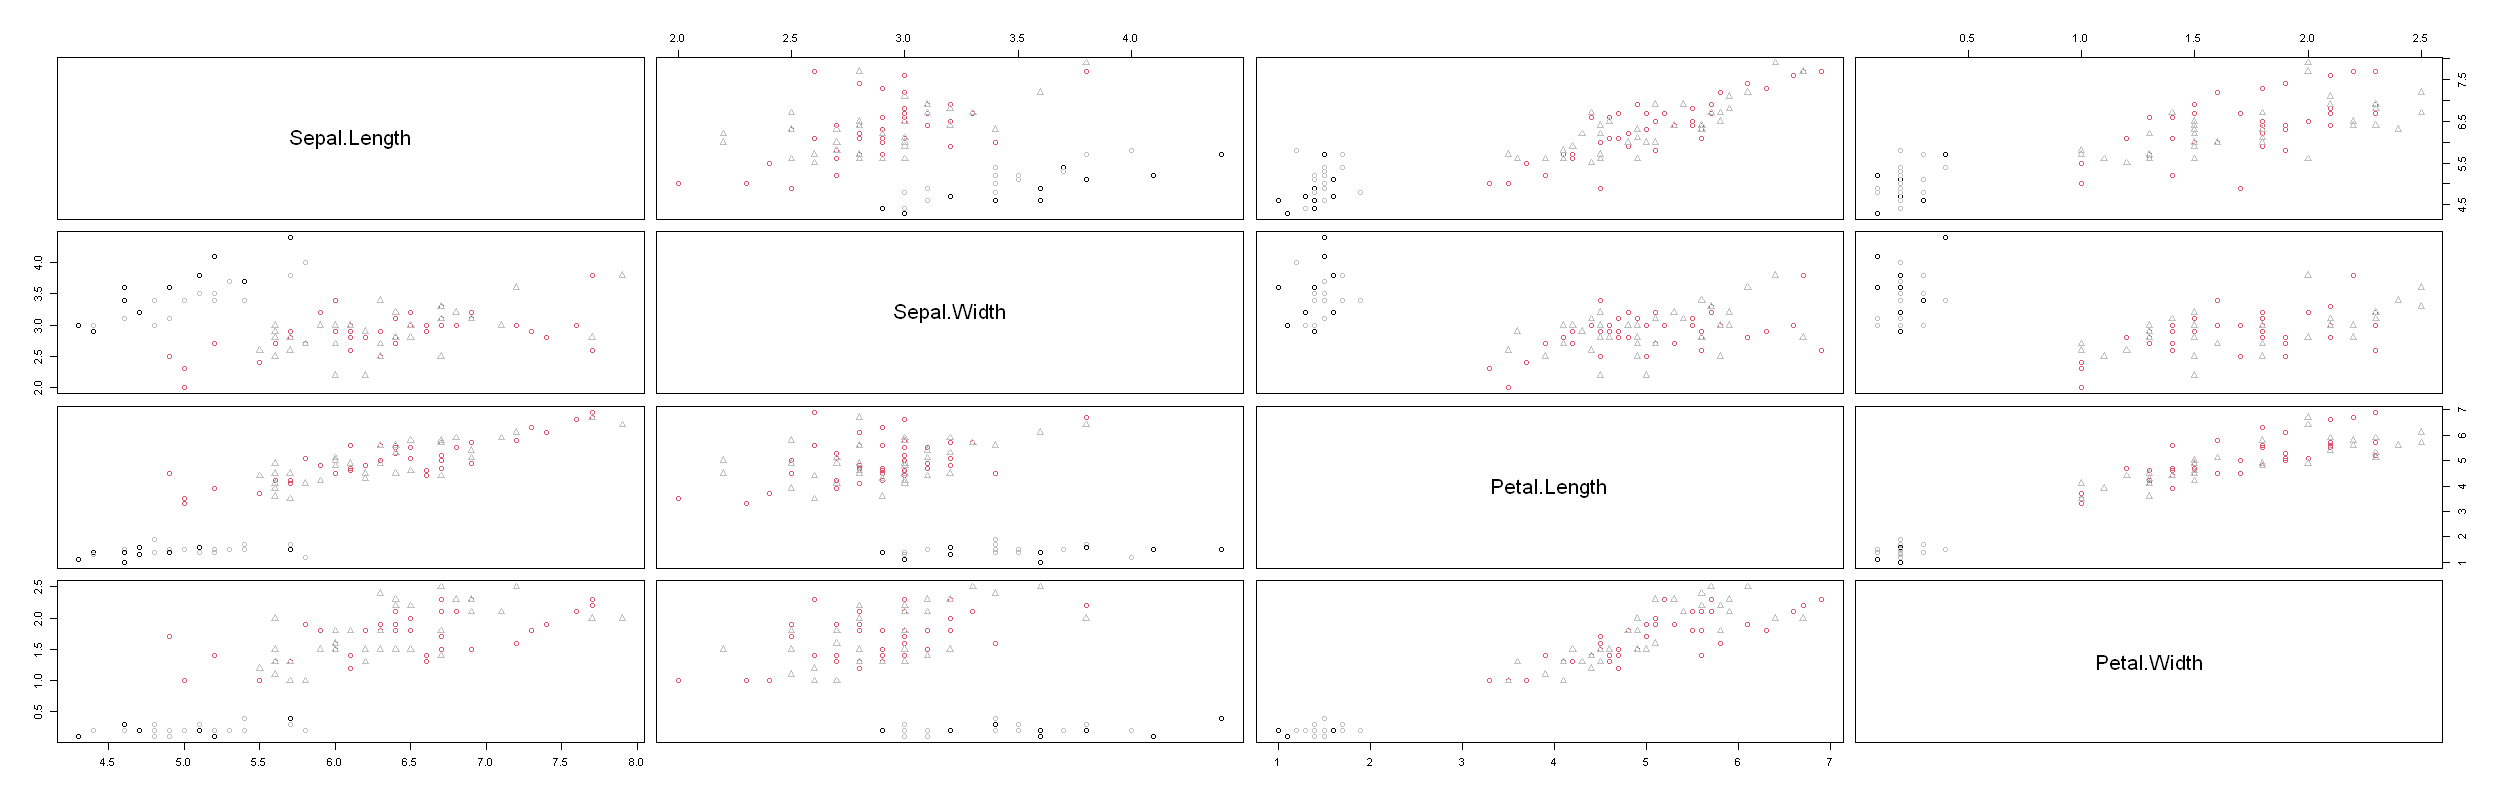

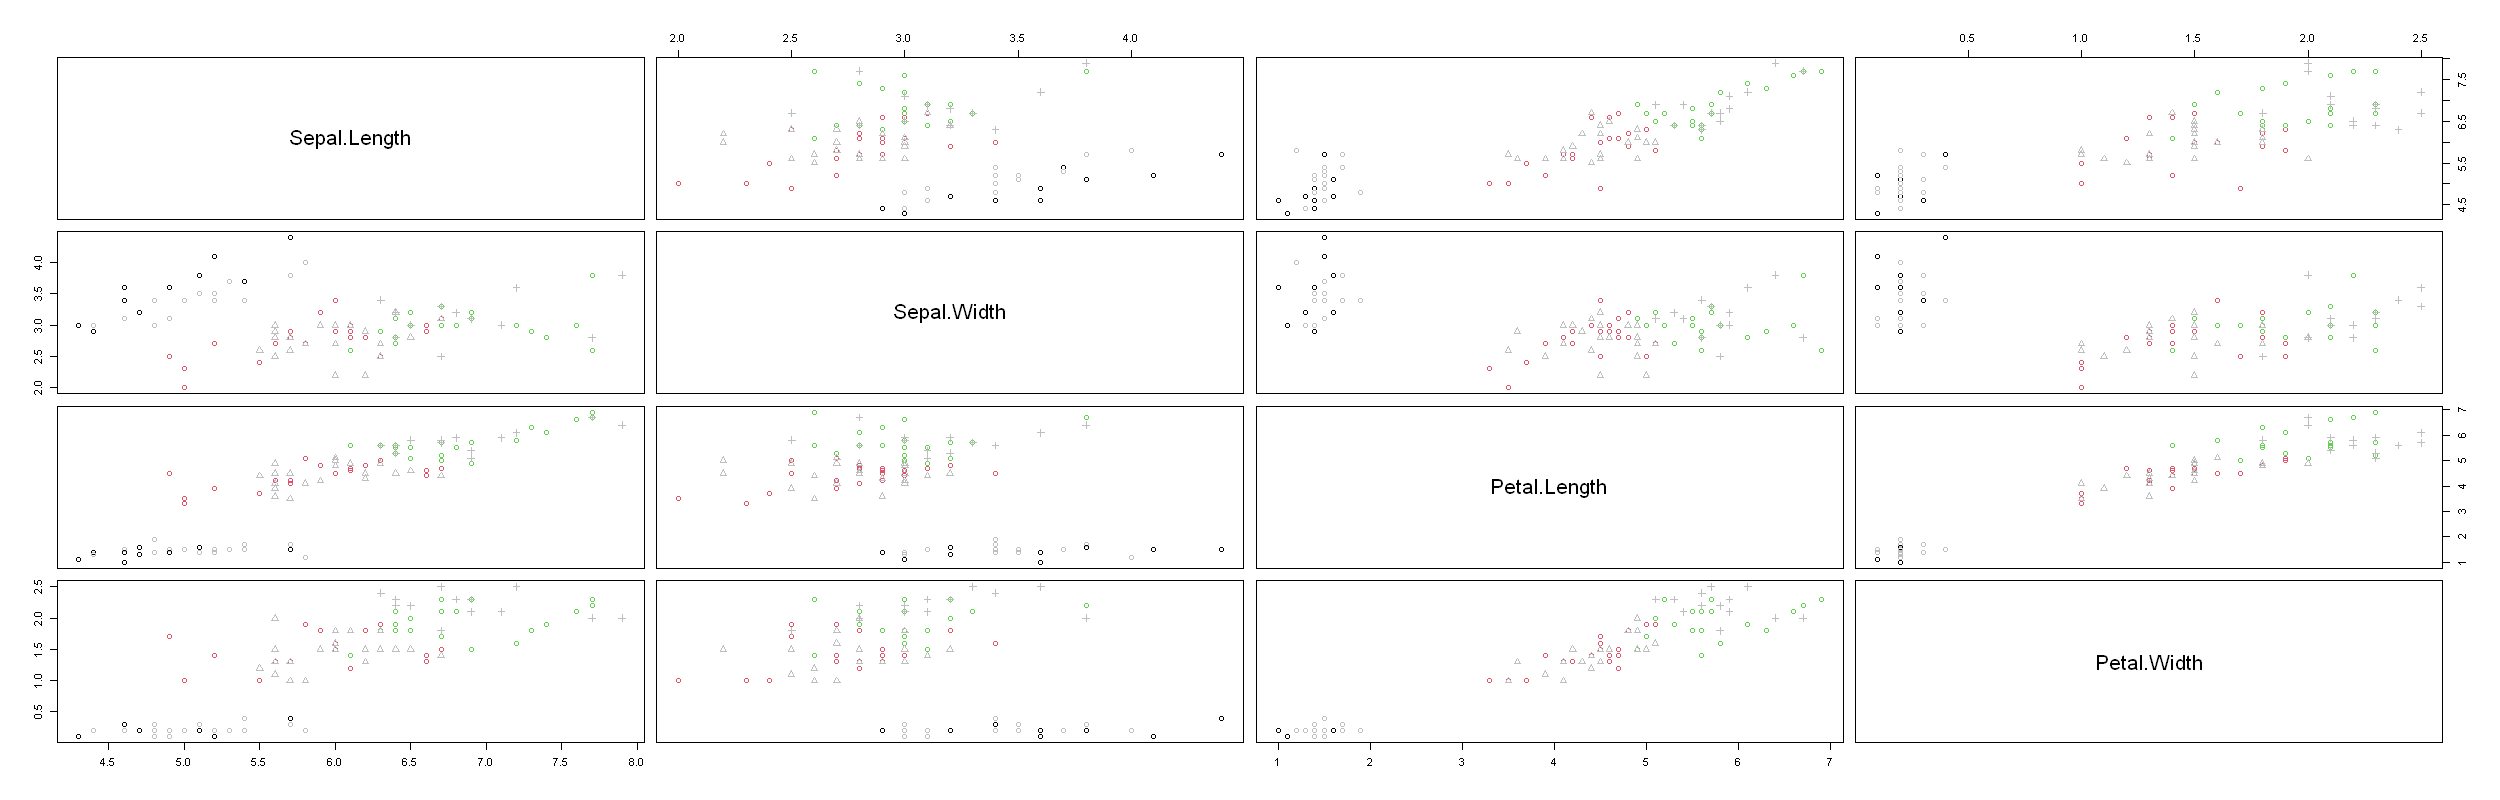

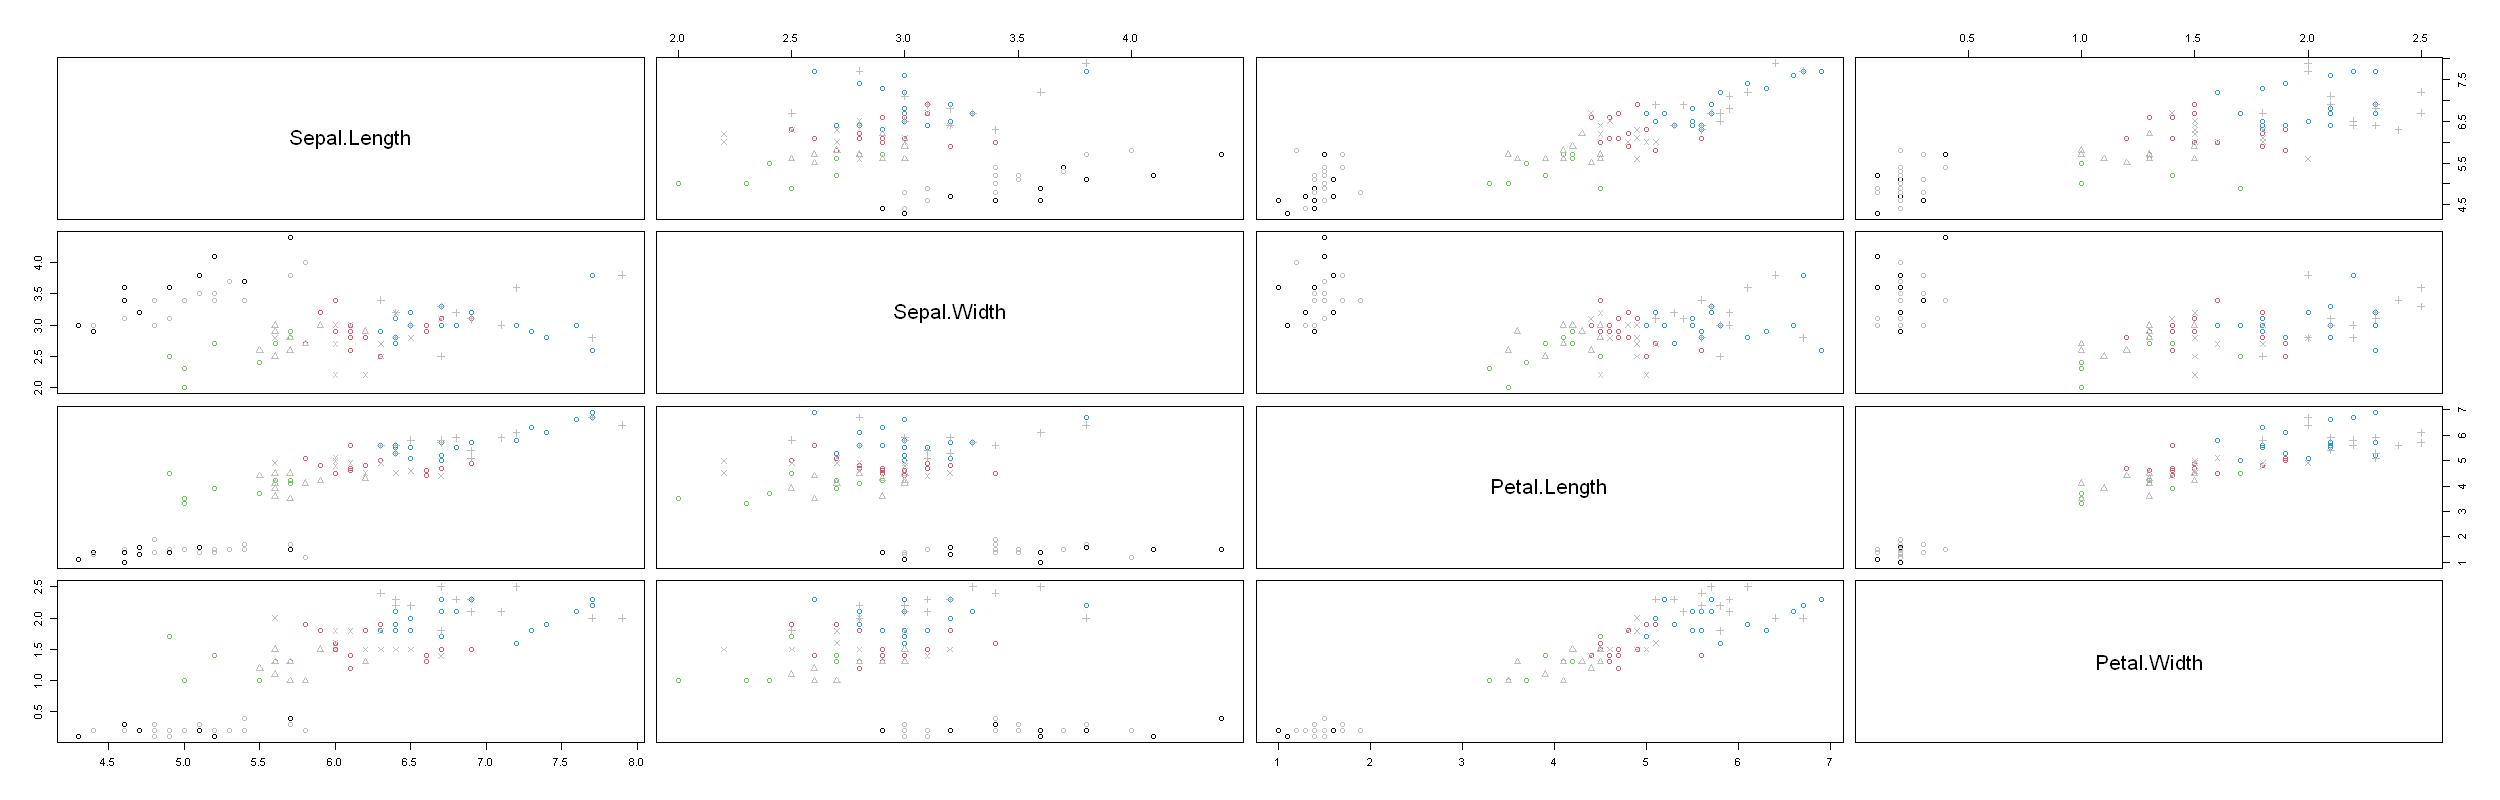

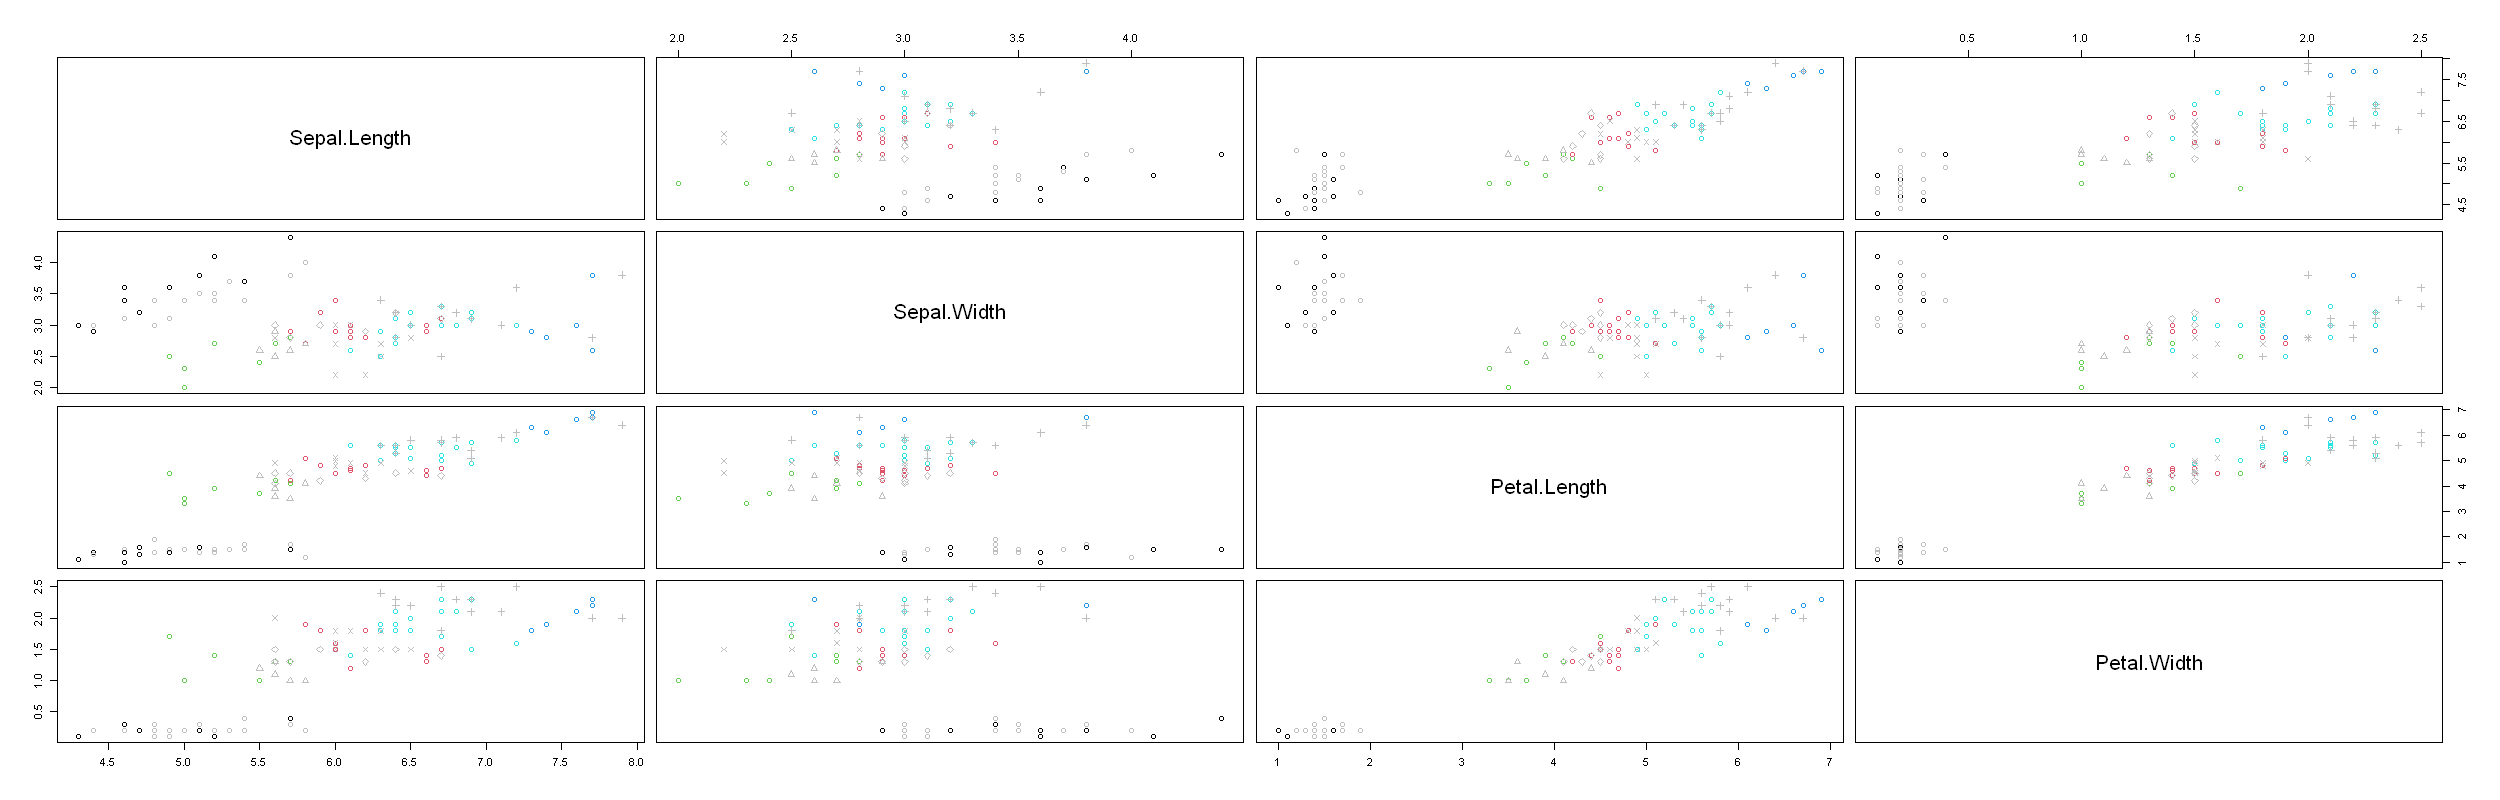

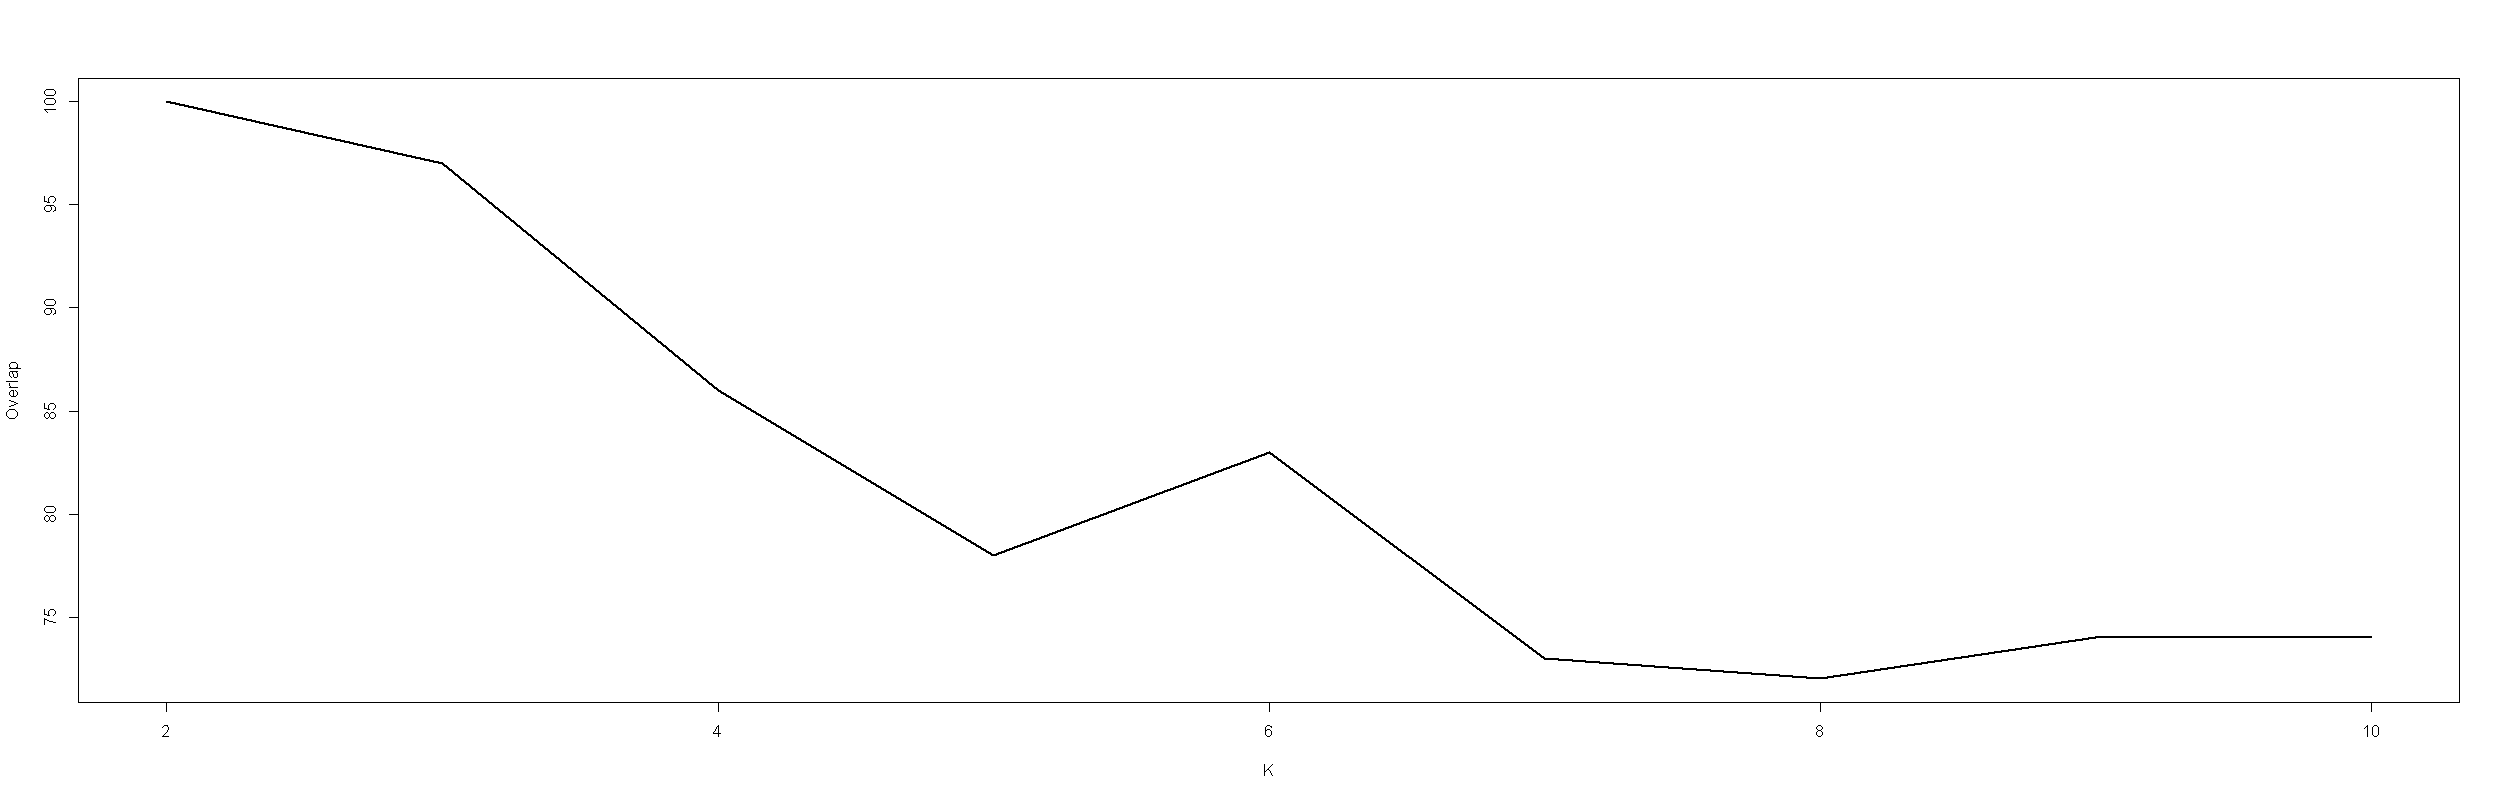

In [365]:
options(repr.plot.width = 25, repr.plot.height = 8, repr.plot.res = 100)

library(cluster)
library(datasets)
library(MASS)
data(iris)
# manual cluster prediction strength for selecting then number of clusters
# cheating a bit since not trying all combos
# There is package fpc that has many cluster validation functions in it - see further down
ii<-sample(seq(1,150),100) # sample a subset of the iris data
#
Kvec<-seq(2,10) # how many clusters to investigate
pvec<-0*Kvec # empty vector to store predictions in
ij<-sample(seq(1,length(ii)),round(length(ii)/2)) # divide the data set into two parts
Aset<-iris[ii,][ij,] 
Bset<-iris[ii,][-ij,]
for (kk in (1:length(Kvec))) {
  ppA<-pam(Aset[,1:4],Kvec[kk]) # cluster part A
  ppB<-pam(Bset[,1:4],Kvec[kk]) # cluster part B# 
  if (Kvec[kk]<6) {
  #plot the cluster outcomes, colors from data set A clustering, symbols from B
  pairs(rbind(Aset,Bset)[,-5],col=c(ppA$clust,rep("grey",dim(Bset)[1])),pch=c(rep(1,dim(Aset)[1]),ppB$clust))
  p<-locator() } # push finish to continue to next cluster number
  lA<-lda(Aset[,1:4],ppA$clust) # use A's clustering to generate a classification
  pA<-predict(lA,newdata=Bset[,1:4],type="class") # predict on set B
  lB<-lda(Bset[,1:4],ppB$clust)
  pB<-predict(lB,newdata=Aset[,1:4],type="class")
  #
  tAB<-table(pA$class,ppB$clust) # compare classification vs clustering
  tBA<-table(pB$class,ppA$clust)
  pvec[kk]<-sum(apply(tAB,1,max))+sum(apply(tBA,1,max))  } #compute approximate overlap

plot(Kvec,pvec,xlab="K",ylab="Overlap",cex=2,lwd=2,type="l")

Compare the cluster overlap between data set A (color) and data set B (grey symbols). For which number of clusters do colors and symbols appear "pure" - i.e., not a mix of colors within a symbol or a mix of symbols within a color?
For this data set the cluster overlap is maximized with 2 clusters.

Next I manipulate the iris data to make the Virginica data more separated from the rest. This is to illustrate that with stronger separation you might find 3 clusters.

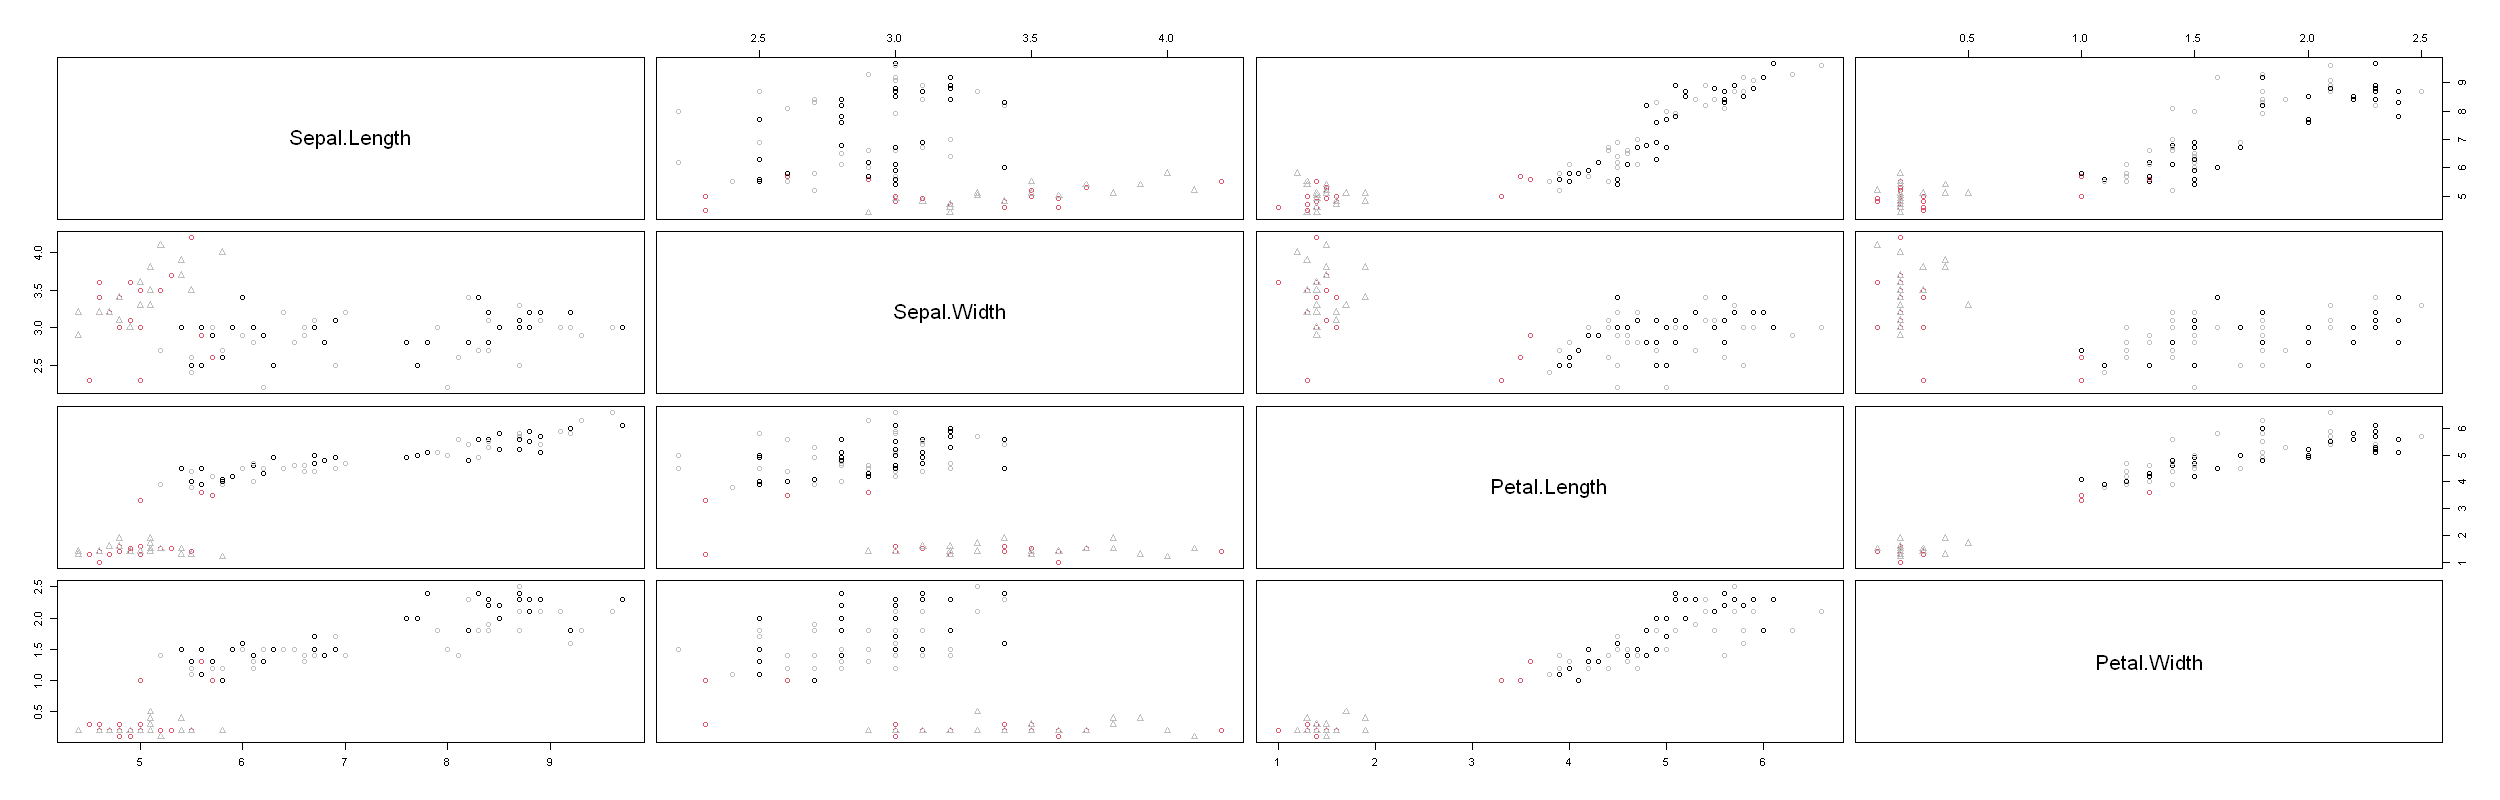

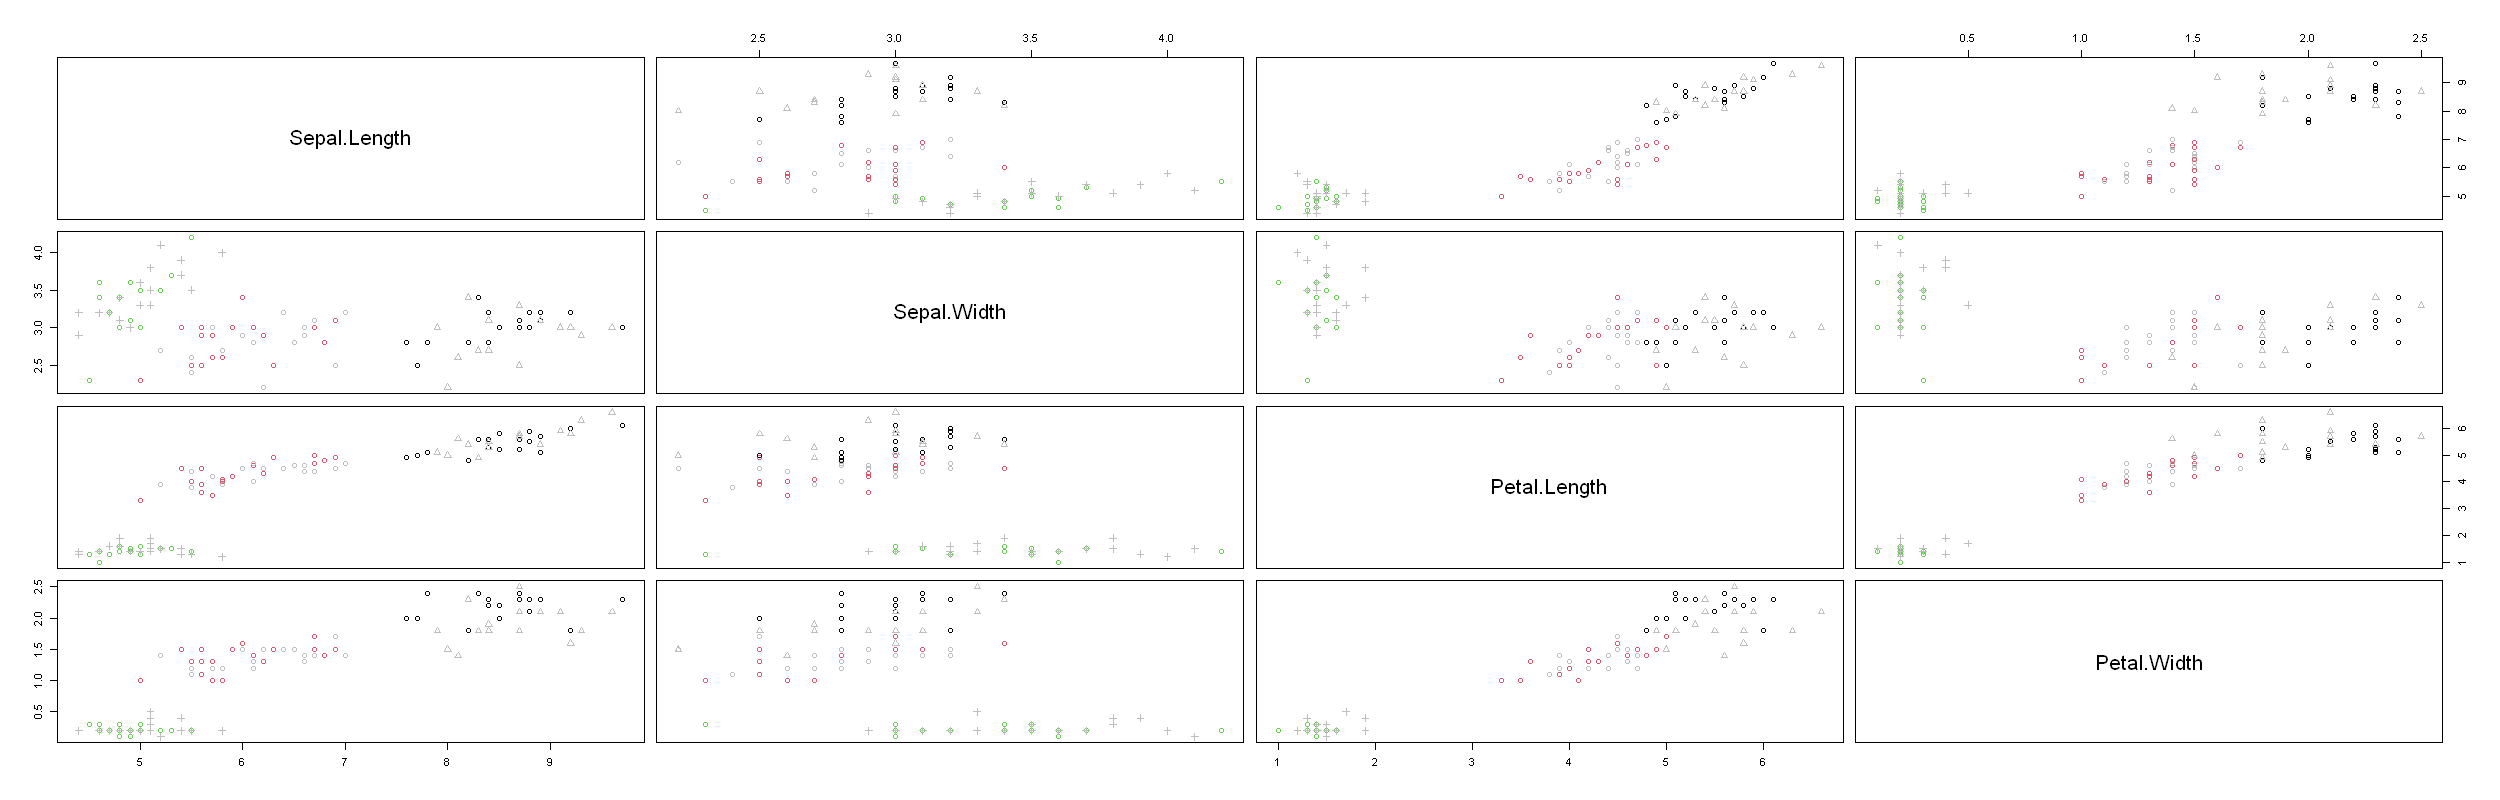

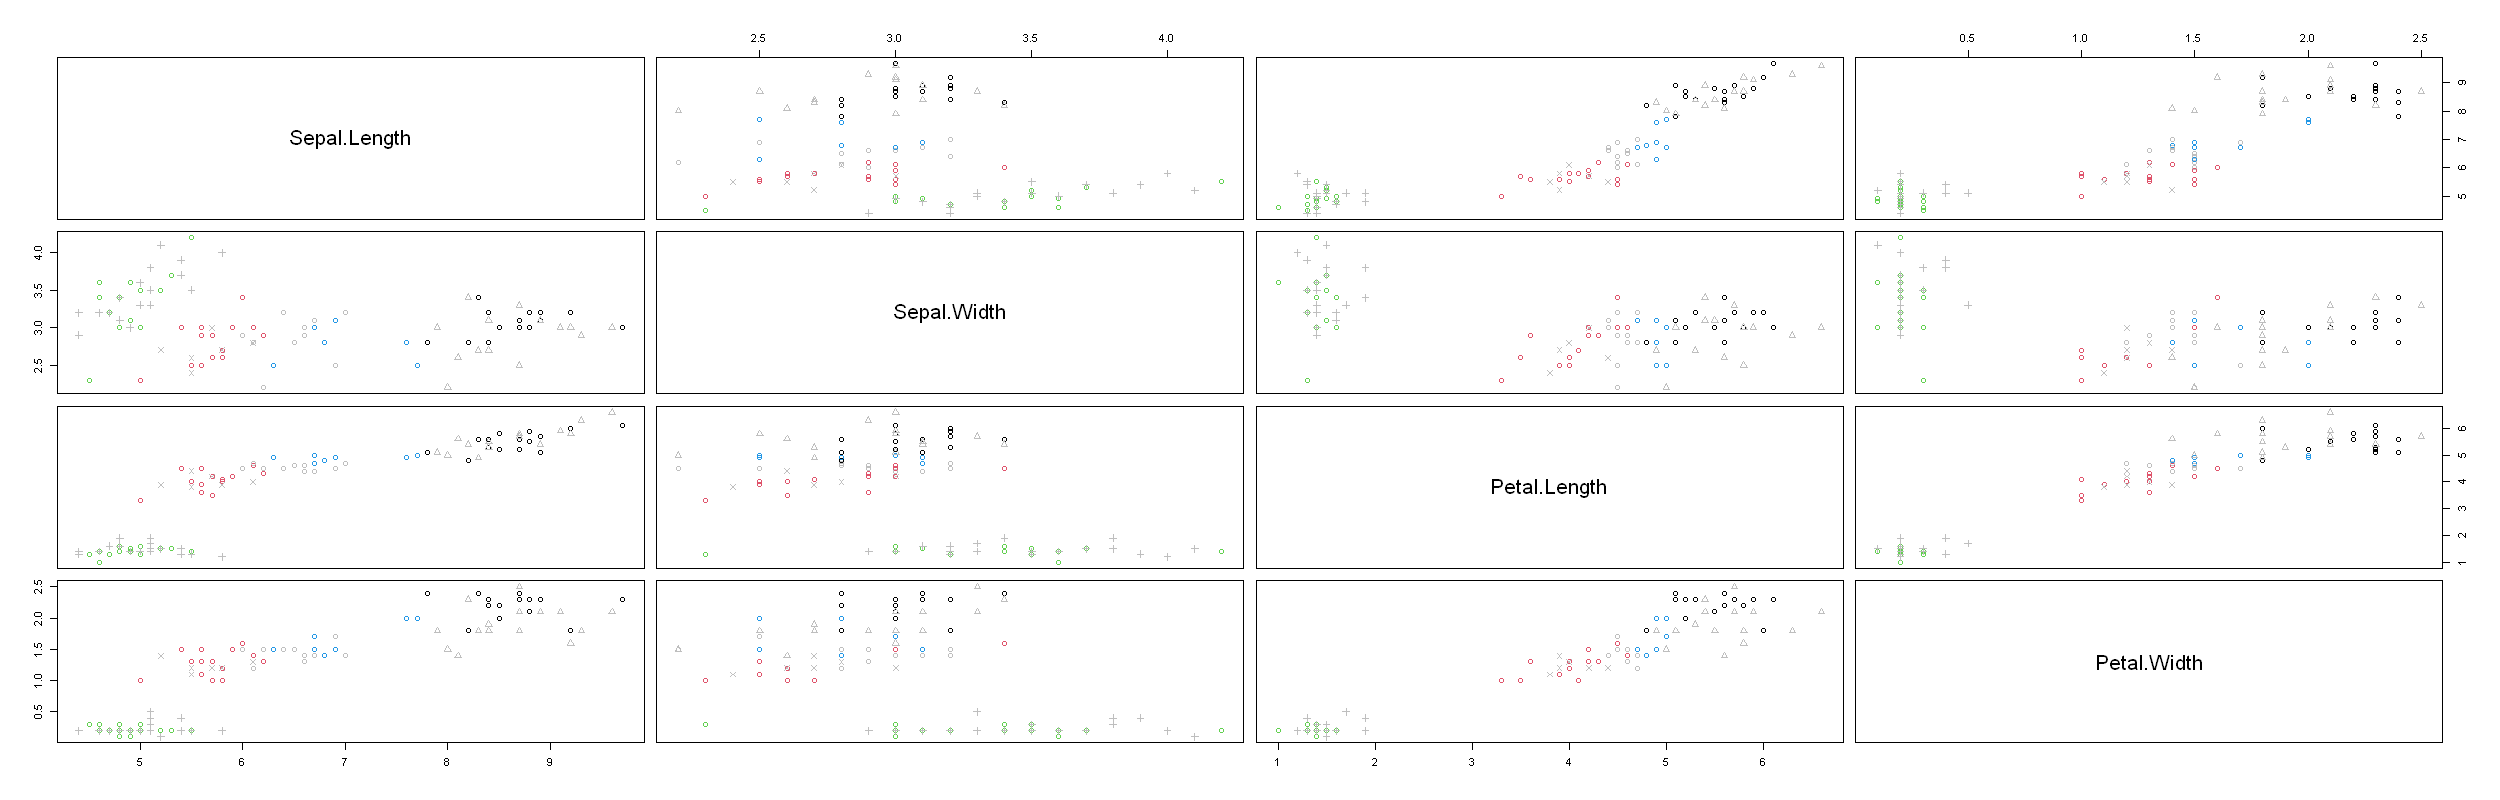

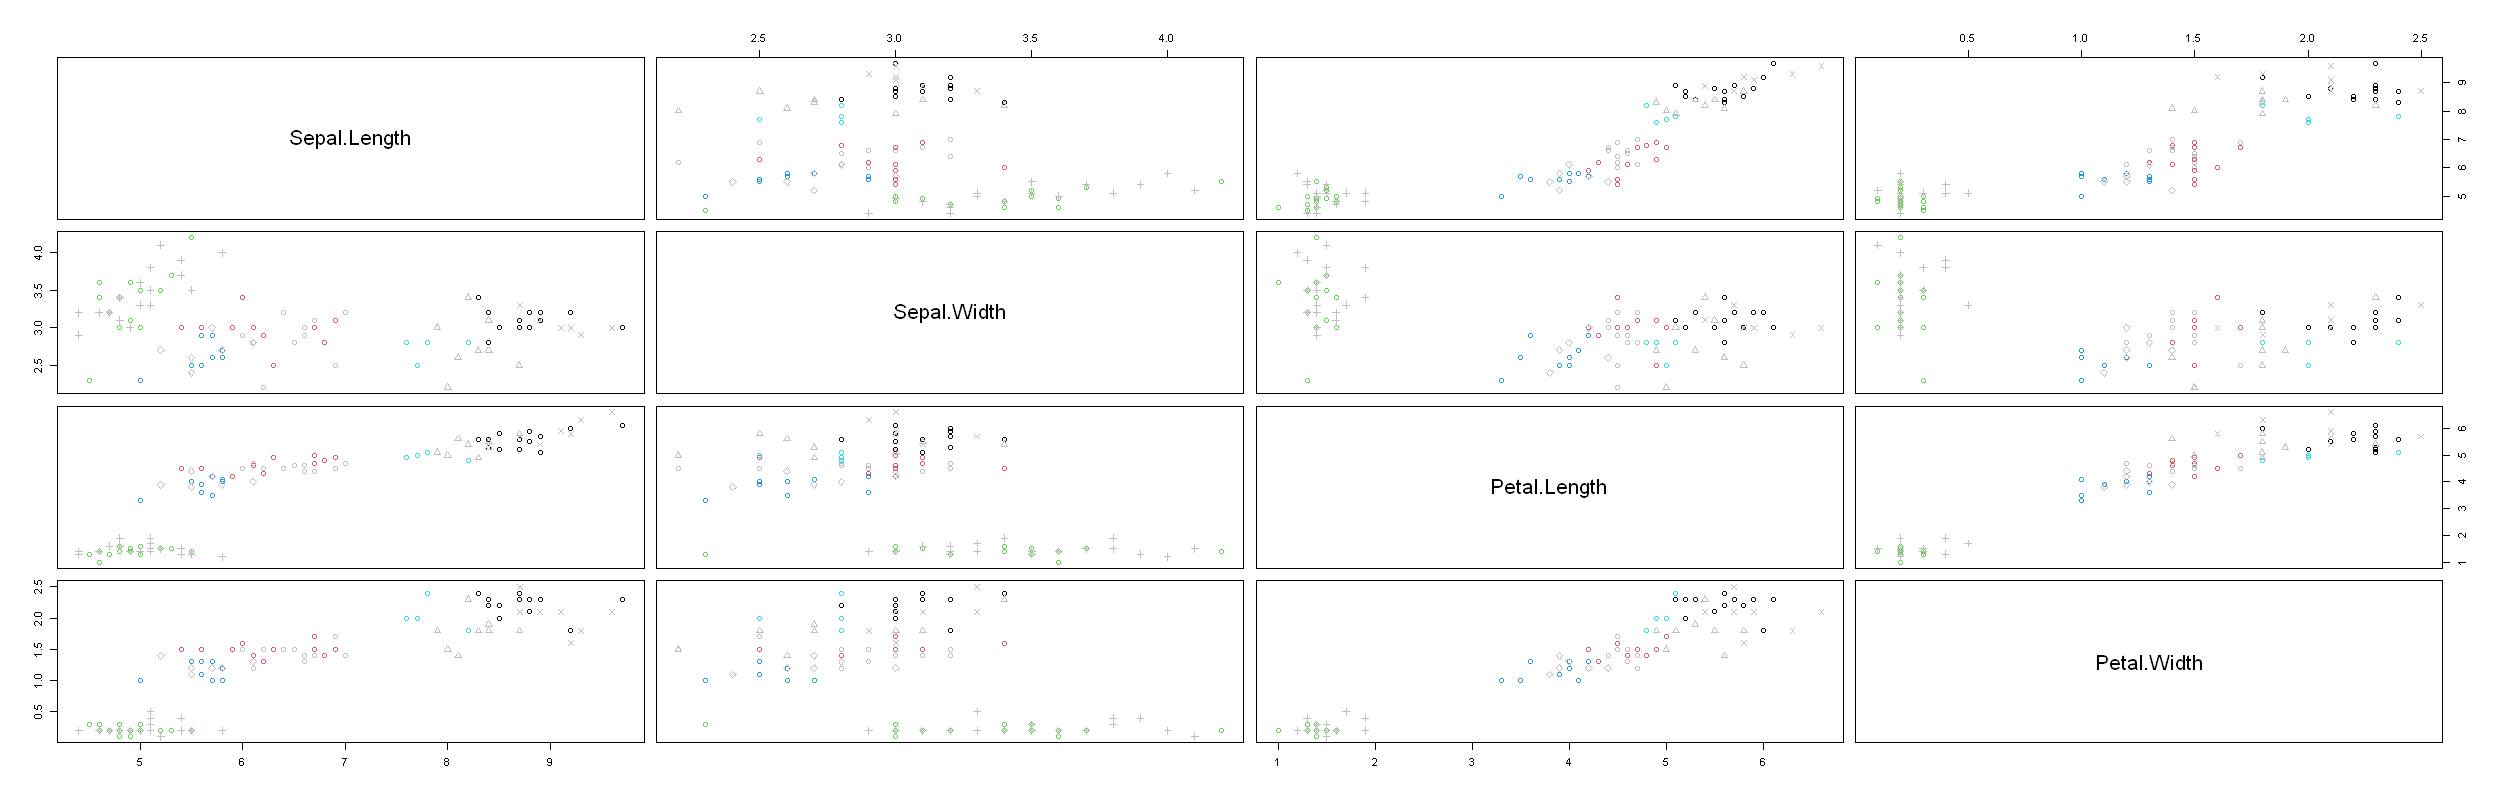

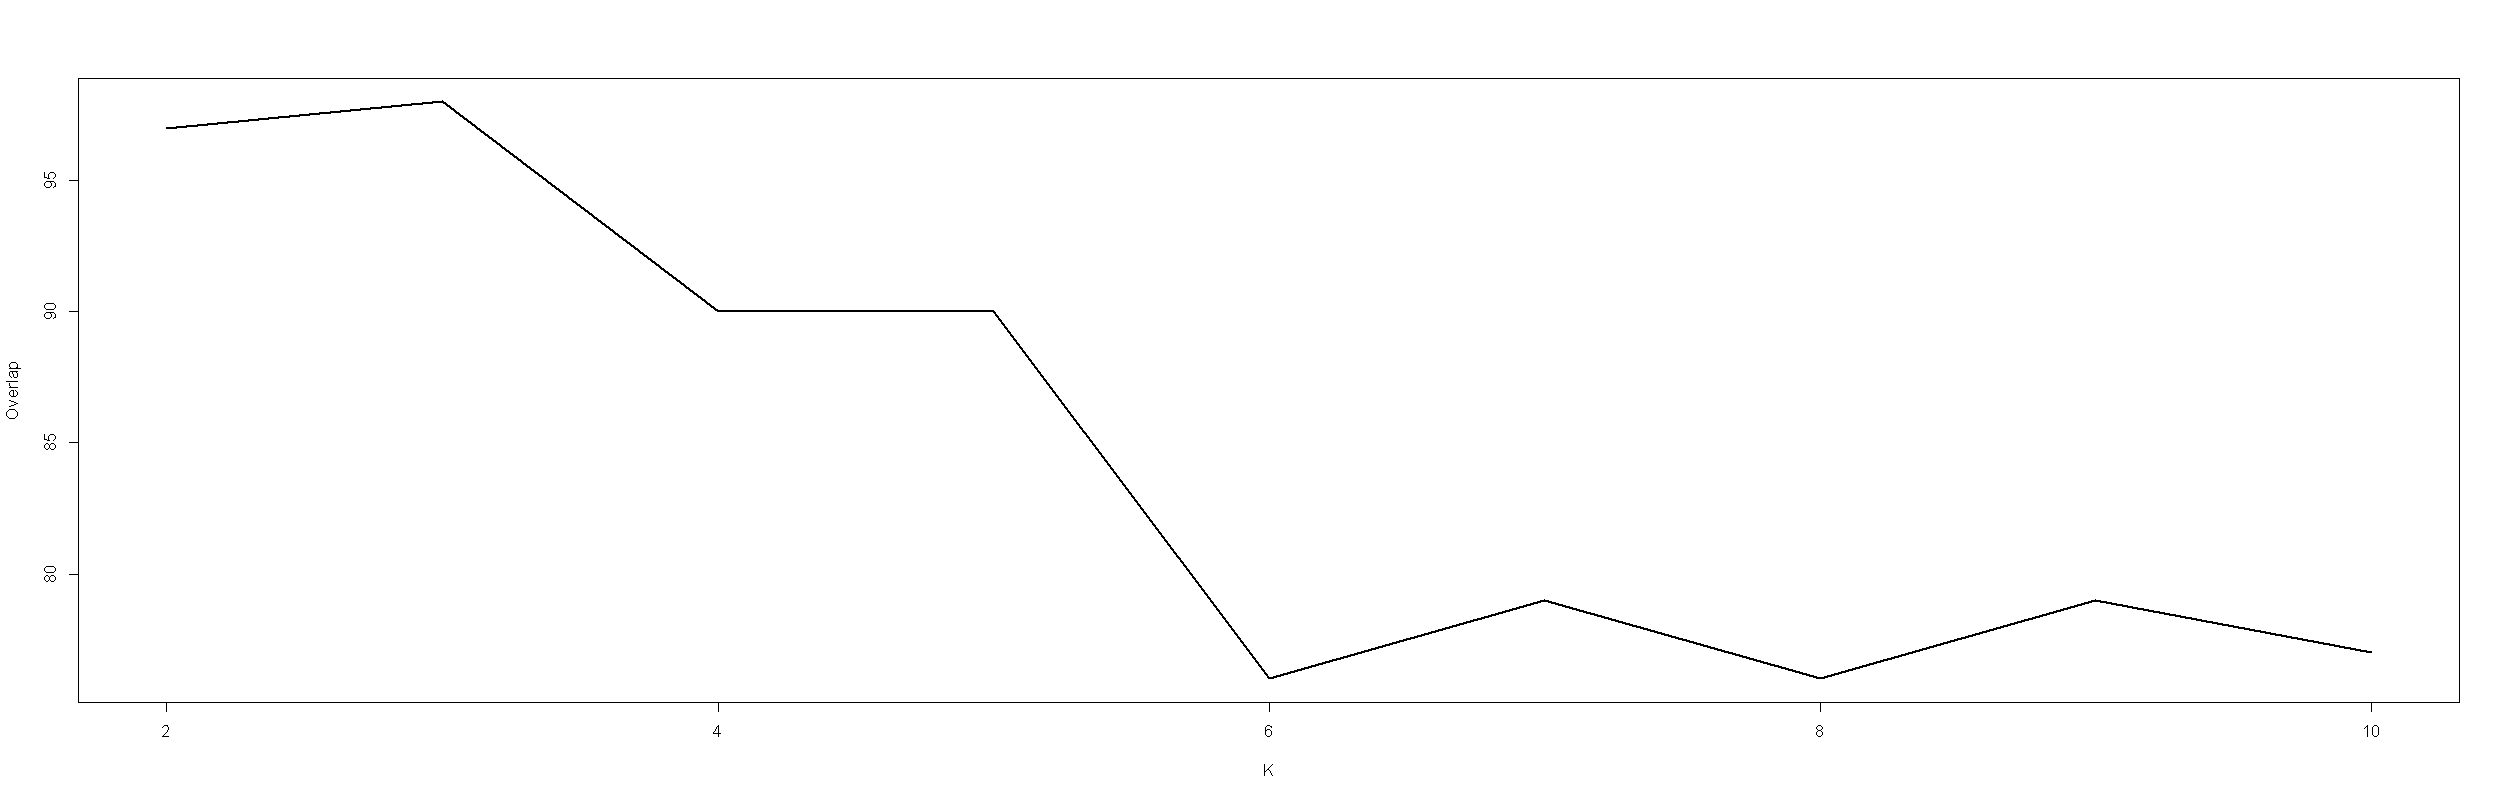

In [366]:
irisnew<-iris
irisnew[iris[,5]=="virginica",1]<-irisnew[iris[,5]=="virginica",1]+2 # make Virginica stand out more.
#
ii<-sample(seq(1,150),100)
Kvec<-seq(2,10)
pvec<-0*Kvec
ij<-sample(seq(1,length(ii)),round(length(ii)/2))
Aset<-irisnew[ii,][ij,]
Bset<-irisnew[ii,][-ij,]
for (kk in (1:length(Kvec))) {
  ppA<-pam(Aset[,1:4],Kvec[kk])
  ppB<-pam(Bset[,1:4],Kvec[kk])
  if (Kvec[kk]<6) {
    pairs(rbind(Aset,Bset)[,-5],col=c(ppA$clust,rep("grey",dim(Bset)[1])),pch=c(rep(1,dim(Aset)[1]),ppB$clust))
    p<-locator() }
  lA<-lda(Aset[,1:4],ppA$clust)
  pA<-predict(lA,newdata=Bset[,1:4],type="class")
  lB<-lda(Bset[,1:4],ppB$clust)
  pB<-predict(lB,newdata=Aset[,1:4],type="class")
  #
  tAB<-table(pA$class,ppB$clust)
  tBA<-table(pB$class,ppA$clust)
  pvec[kk]<-sum(apply(tAB,1,max))+sum(apply(tBA,1,max)) }

plot(Kvec,pvec,xlab="K",ylab="Overlap",cex=2,lwd=2,type="l")

Next I split the first cluster into two with strong separation to see if I can detect 4 clusters.

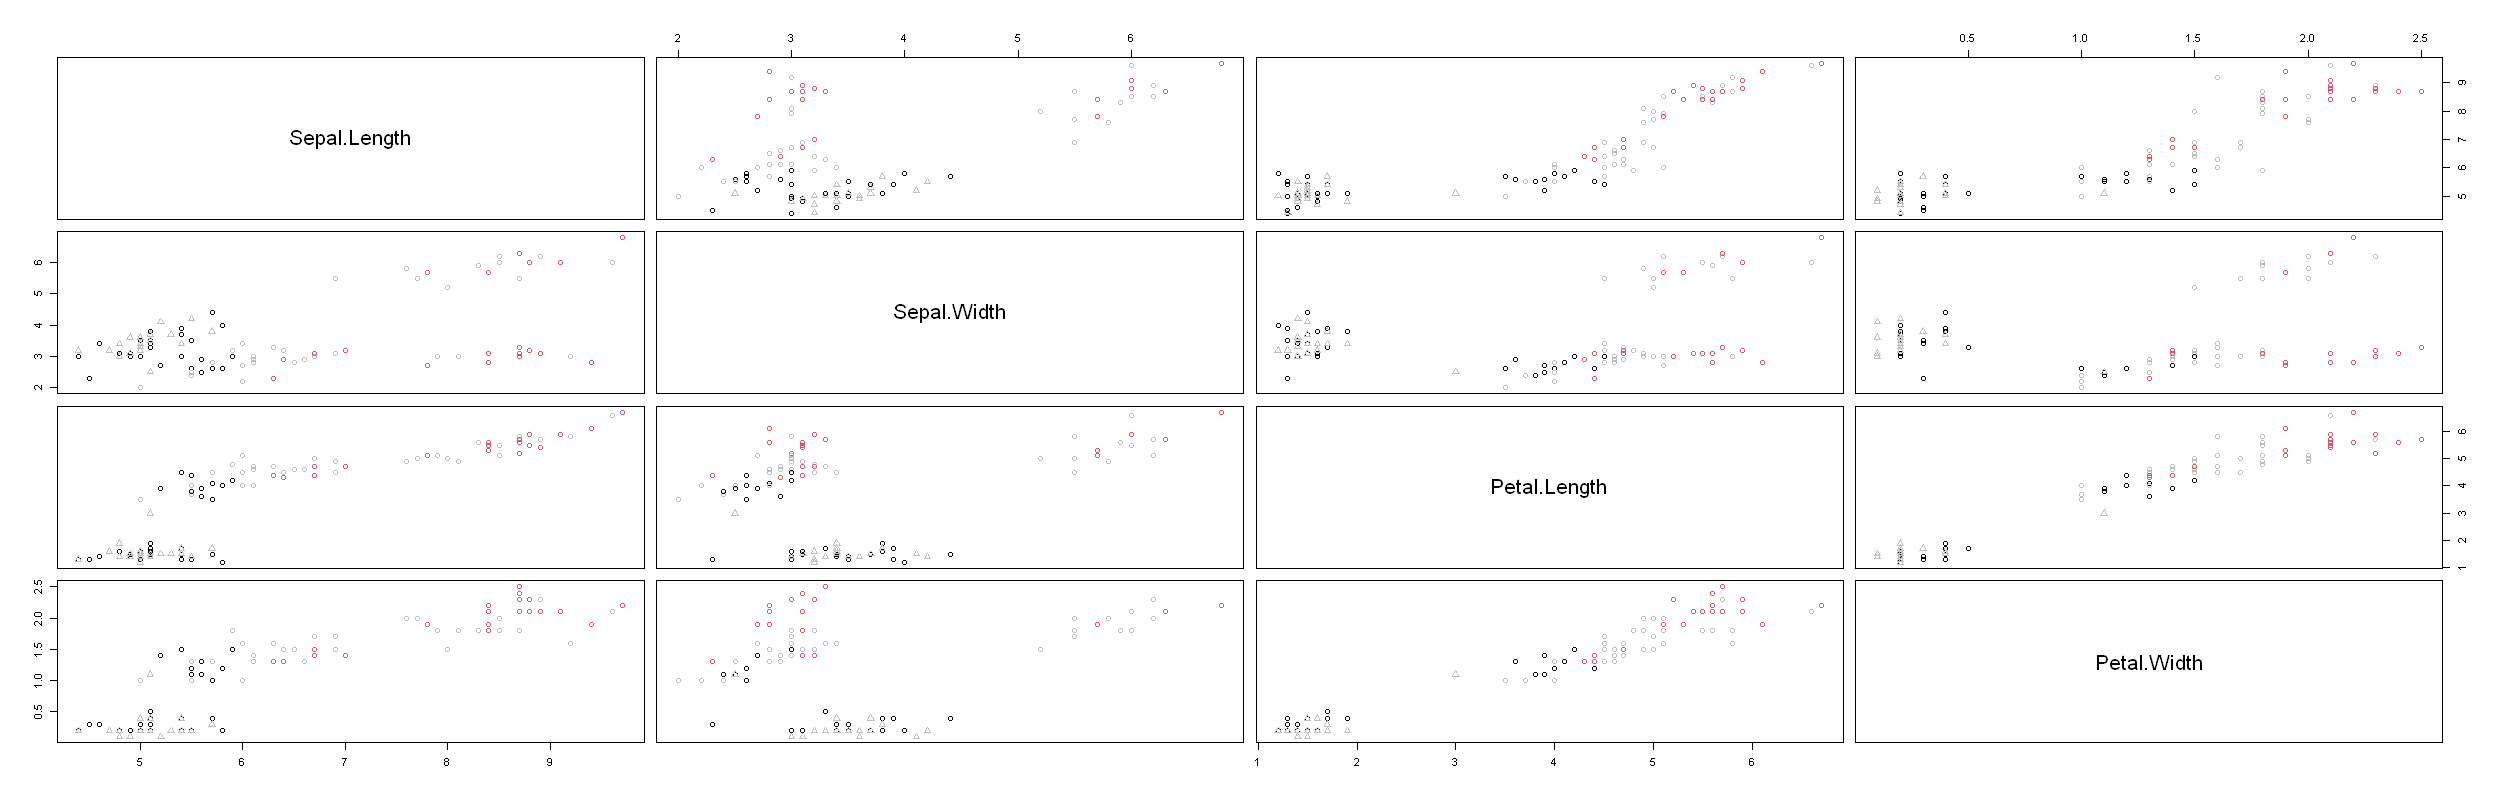

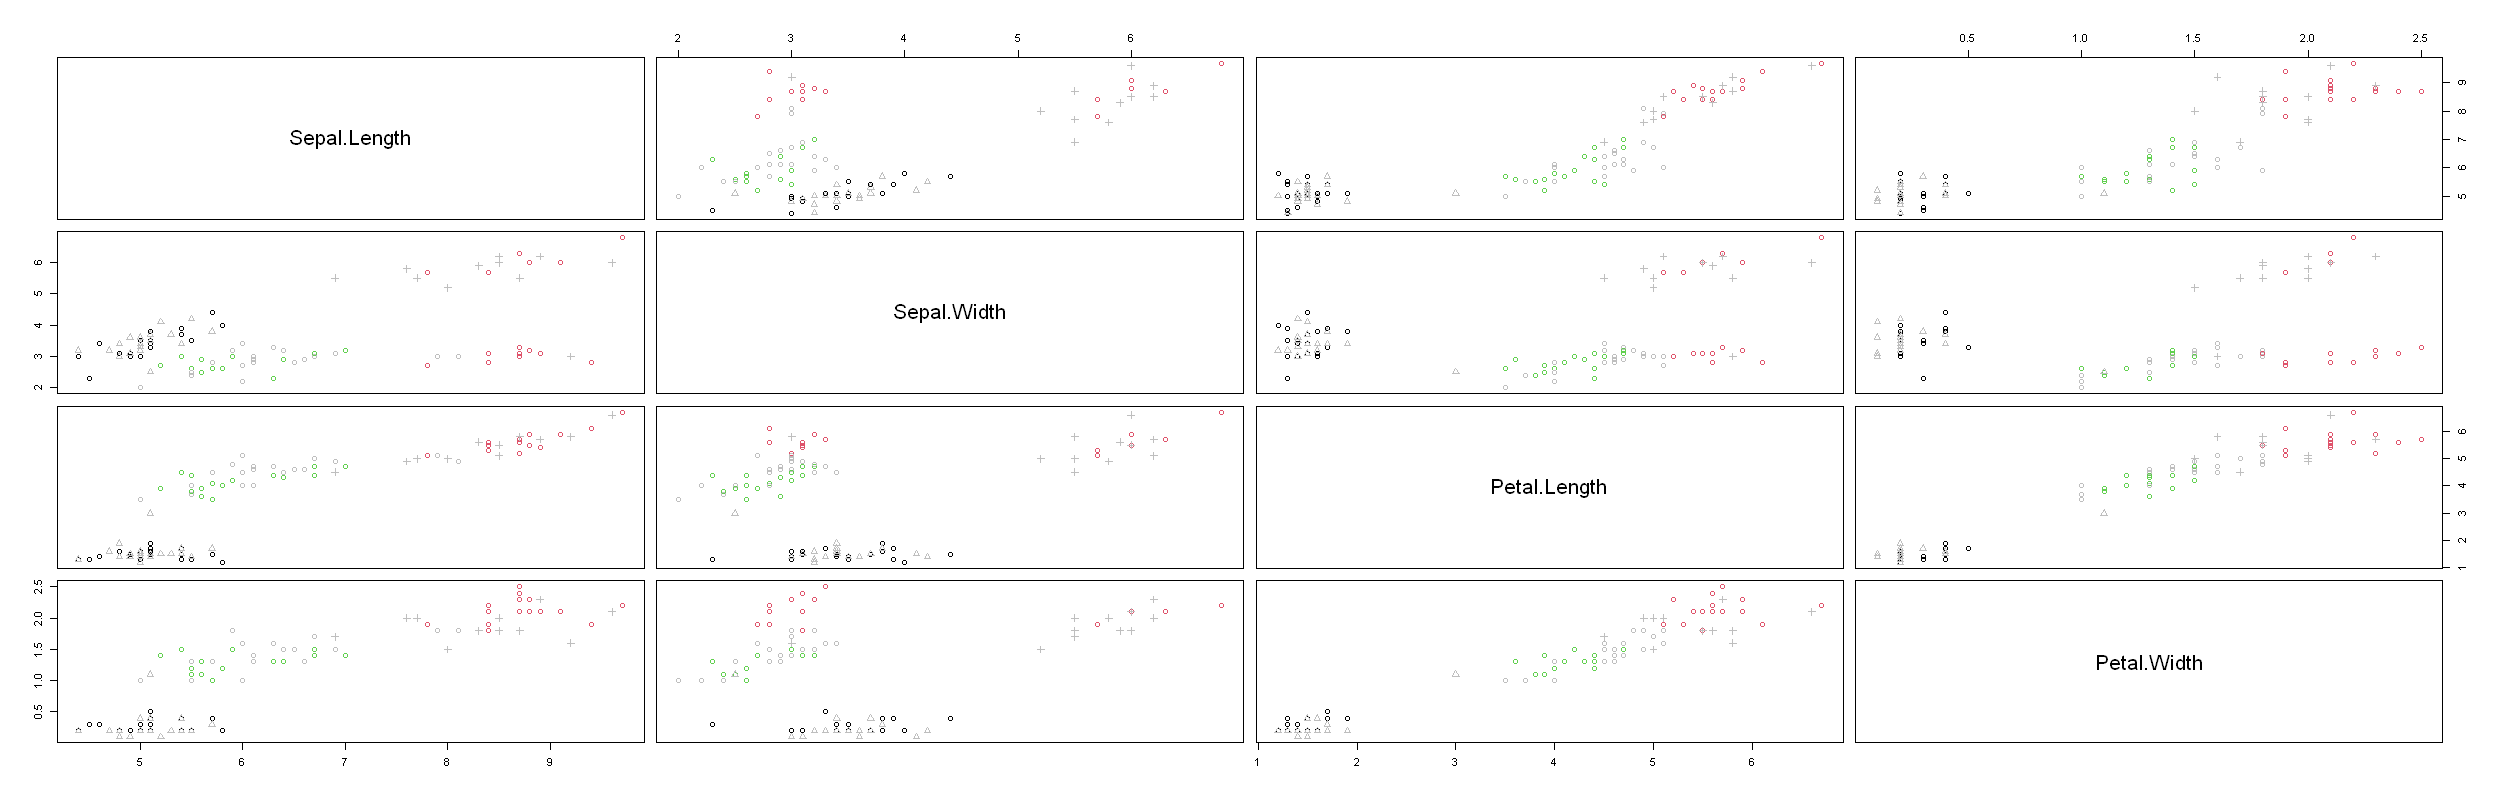

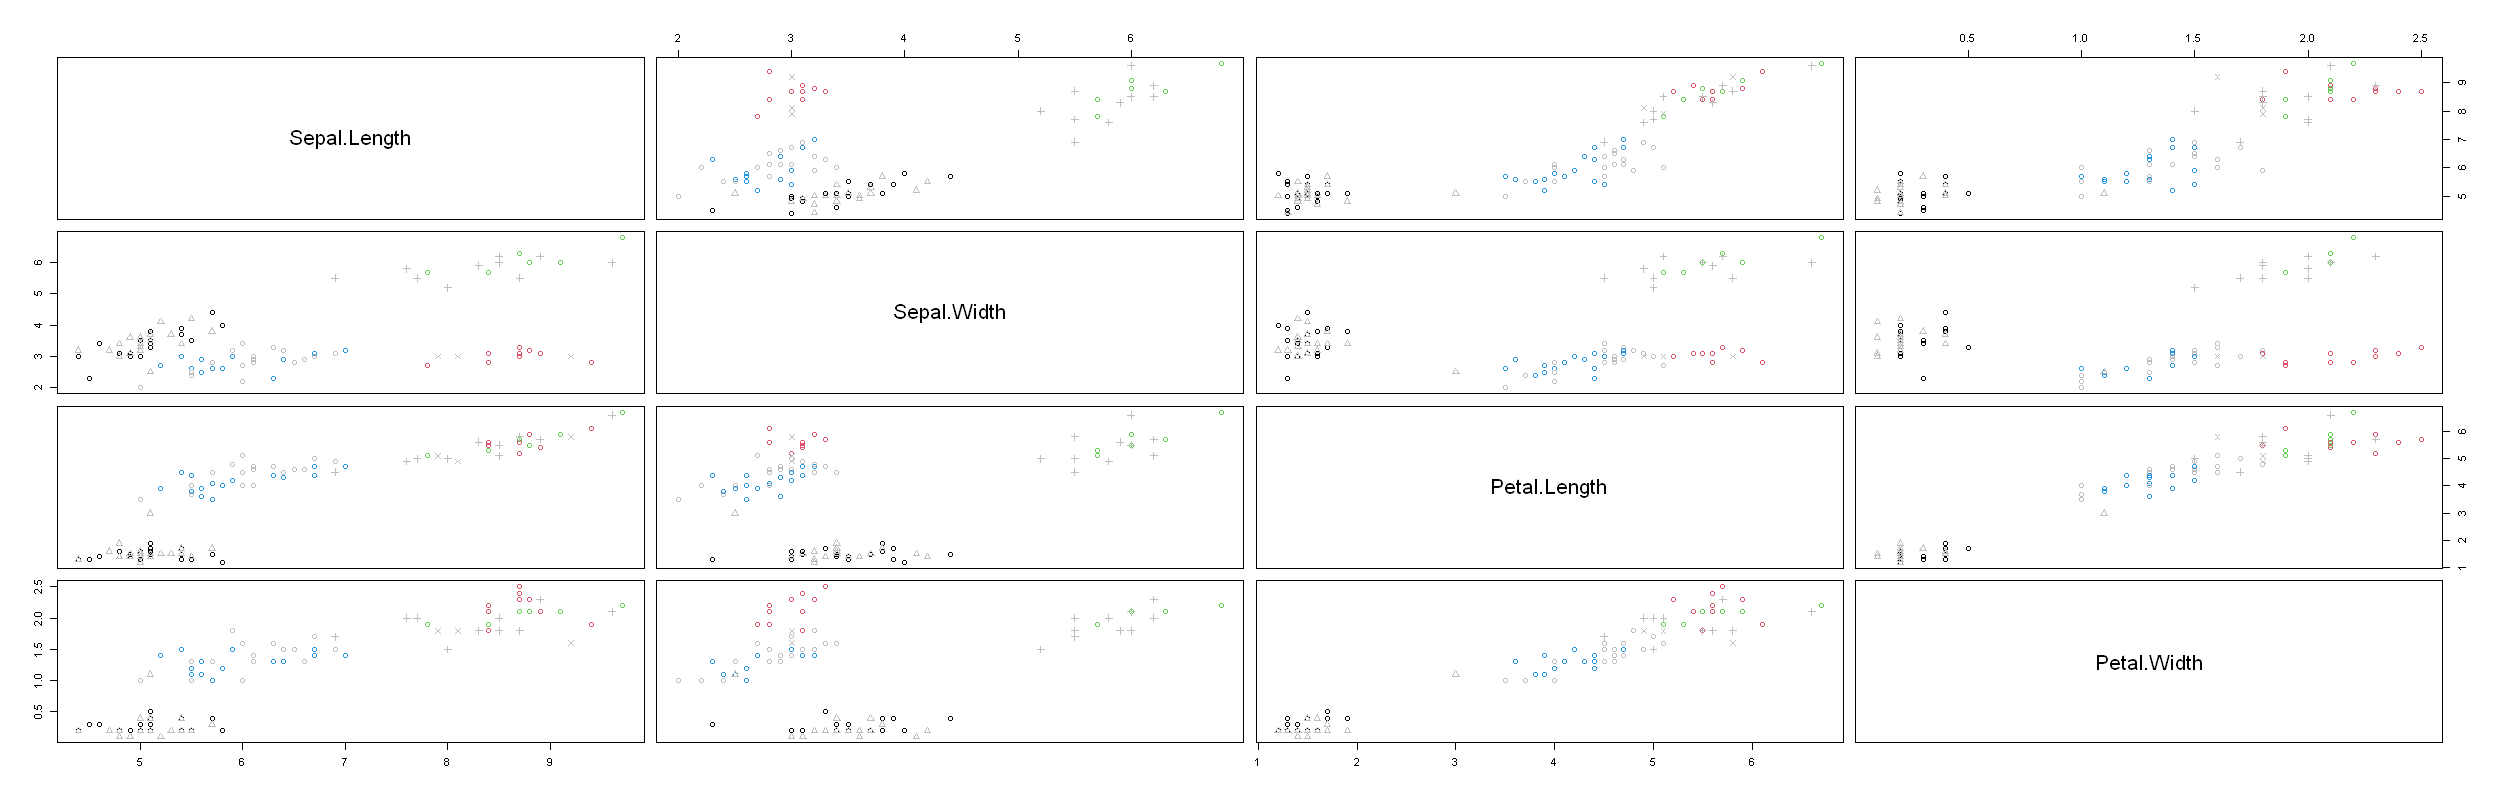

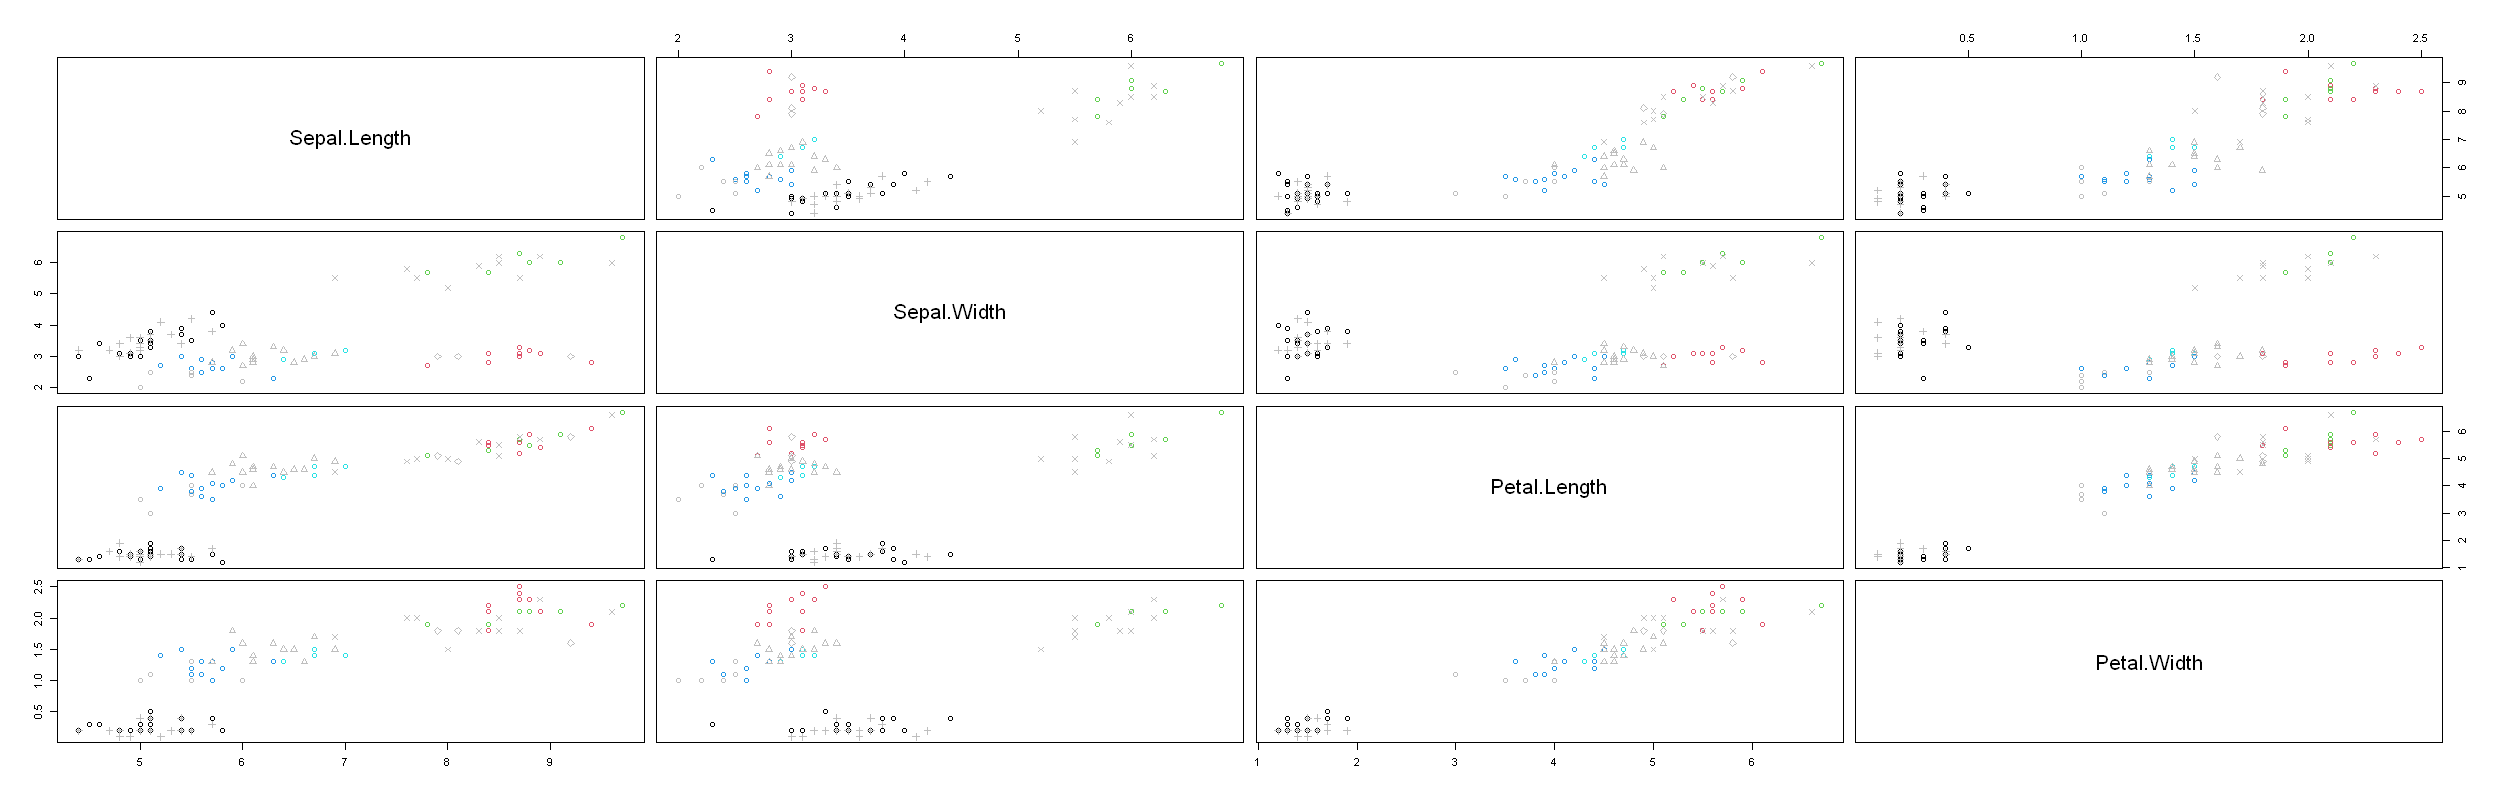

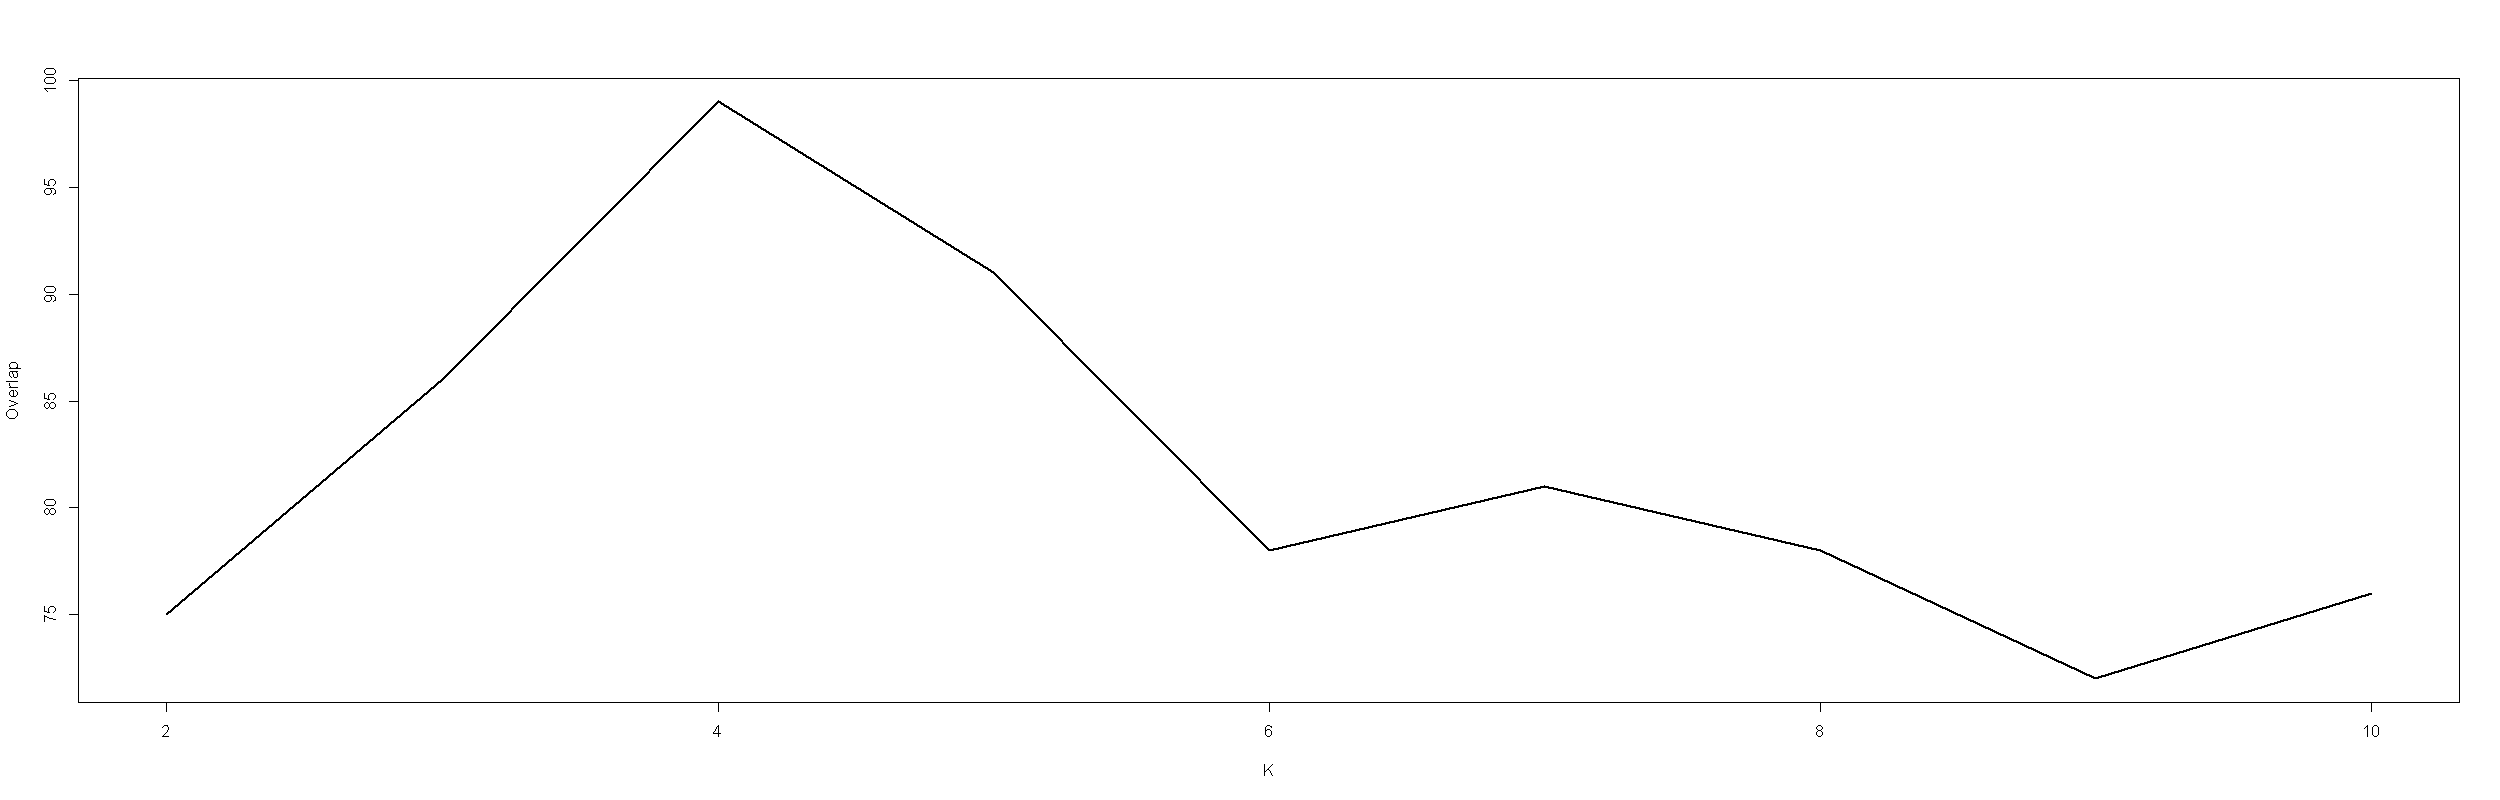

In [367]:
### creating 4 separated clusters
irisnew<-iris
irisnew[iris[,5]=="virginica",1]<-irisnew[iris[,5]=="virginica",1]+2
ss<-seq(1,dim(iris)[1])[iris[,5]=="virginica"]
irisnew[ss[1:25],2]<-irisnew[ss[1:25],2]+3
#
ii<-sample(seq(1,150),100)
Kvec<-seq(2,10)
pvec<-0*Kvec
ij<-sample(seq(1,length(ii)),round(length(ii)/2))
Aset<-irisnew[ii,][ij,]
Bset<-irisnew[ii,][-ij,]
for (kk in (1:length(Kvec))) {
  ppA<-pam(Aset[,1:4],Kvec[kk])
  ppB<-pam(Bset[,1:4],Kvec[kk])
  if (Kvec[kk]<6) {
    pairs(rbind(Aset,Bset)[,-5],col=c(ppA$clust,rep("grey",dim(Bset)[1])),pch=c(rep(1,dim(Aset)[1]),ppB$clust))
    p<-locator() }
  lA<-lda(Aset[,1:4],ppA$clust)
  pA<-predict(lA,newdata=Bset[,1:4],type="class")
  lB<-lda(Bset[,1:4],ppB$clust)
  pB<-predict(lB,newdata=Aset[,1:4],type="class")
  #
  tAB<-table(pA$class,ppB$clust)
  tBA<-table(pB$class,ppA$clust)
  pvec[kk]<-sum(apply(tAB,1,max))+sum(apply(tBA,1,max)) }

plot(Kvec,pvec,xlab="K",ylab="Overlap",cex=2,lwd=2,type="l")

So, when I manipulated the data to make sure I had a strong signal for 3 or 4 clusters the algorithm seemed to work. 

Instead of doing this from scratch let's use packages instead.

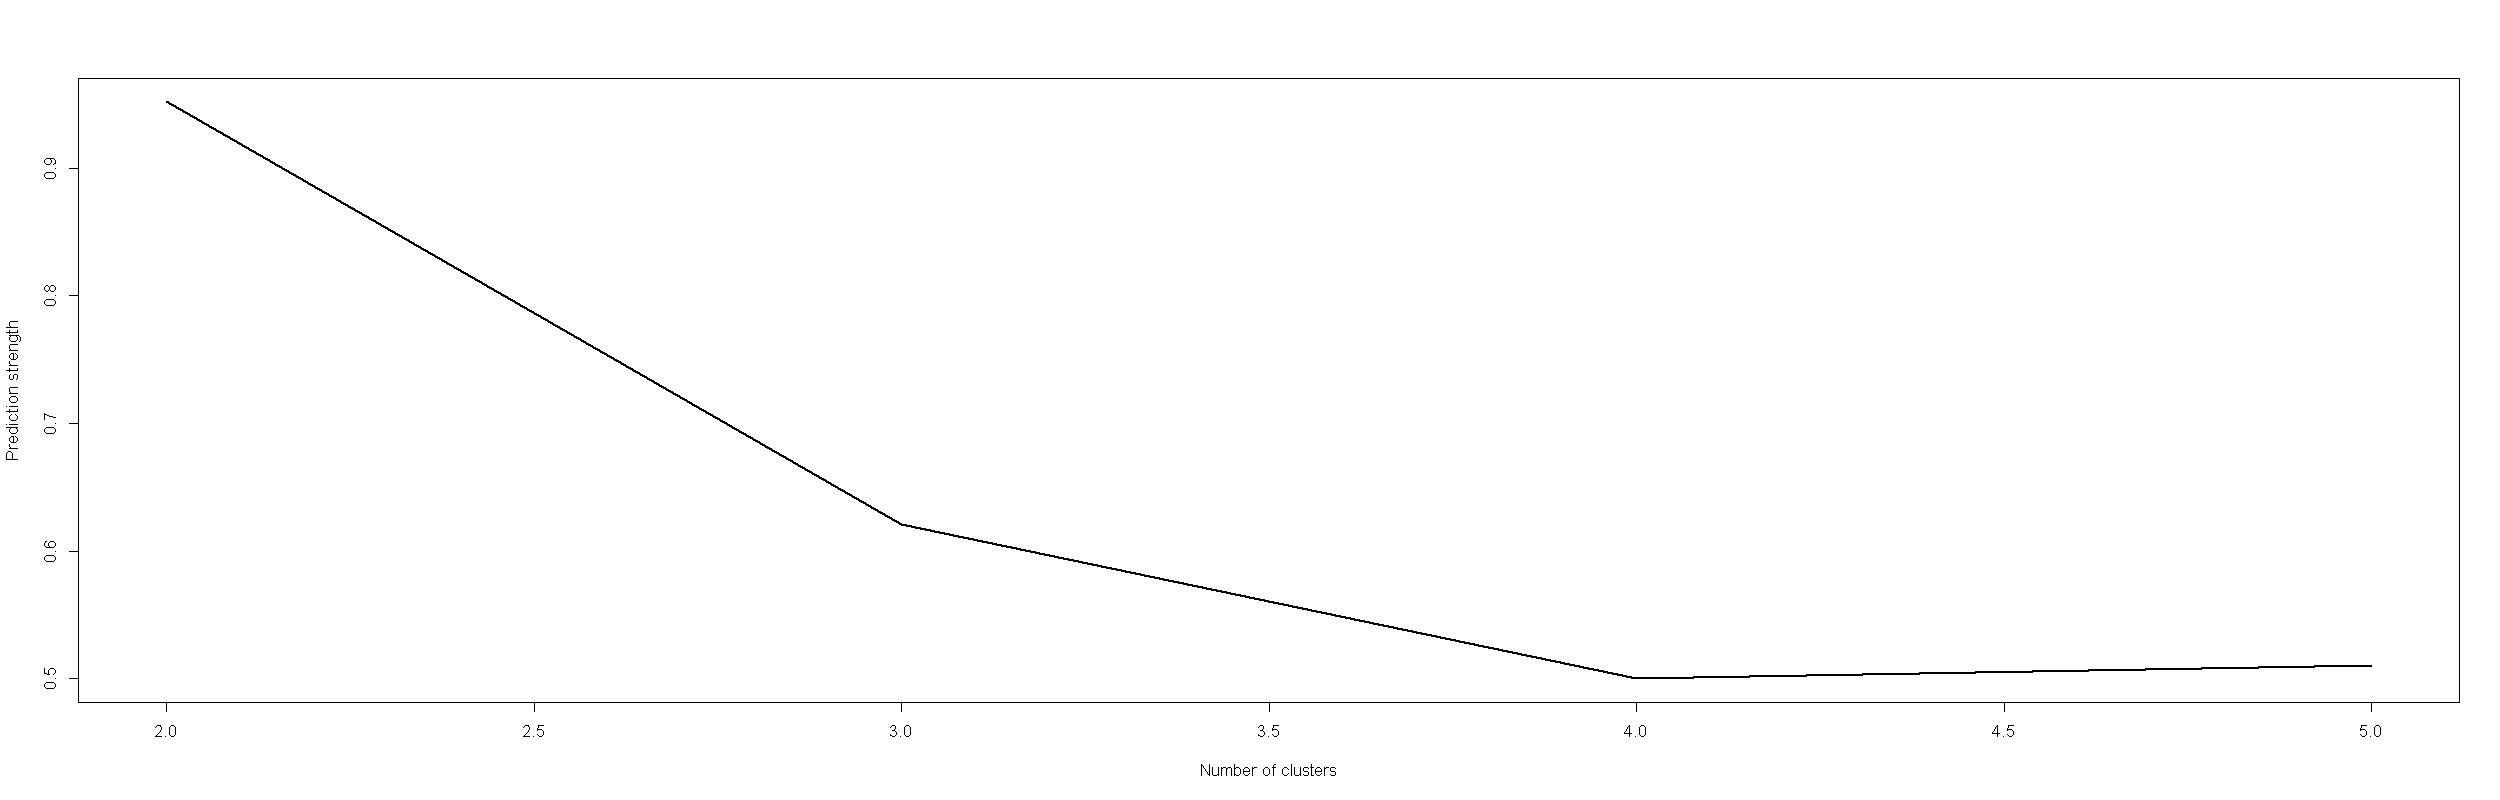

In [368]:
#### Package for cluster validation
#install.packages("fpc")
library(fpc)
# Read the helpfile about the package
#library(help="fpc")
# online manual also
ii<-sample(seq(1,150),100)
pp<-prediction.strength(iris[ii,-5], Gmin=2,Gmax=5,clustermethod=kmeansCBI, classification="centroid",M=10)
# You can try other clustering methods like hierarchical etc and other classifiers like kNN etc
# Check help(prediction.strength) for more info
plot(seq(2,5),pp$mean.pred[-1],xlab="Number of clusters", ylab="Prediction strength", type="l",lwd=2)
#


Cleary, the overlap is best for 2 clusters.

Now, try this for the data set with more separation between 3 clusters and an added 4th from splitting Virginica.

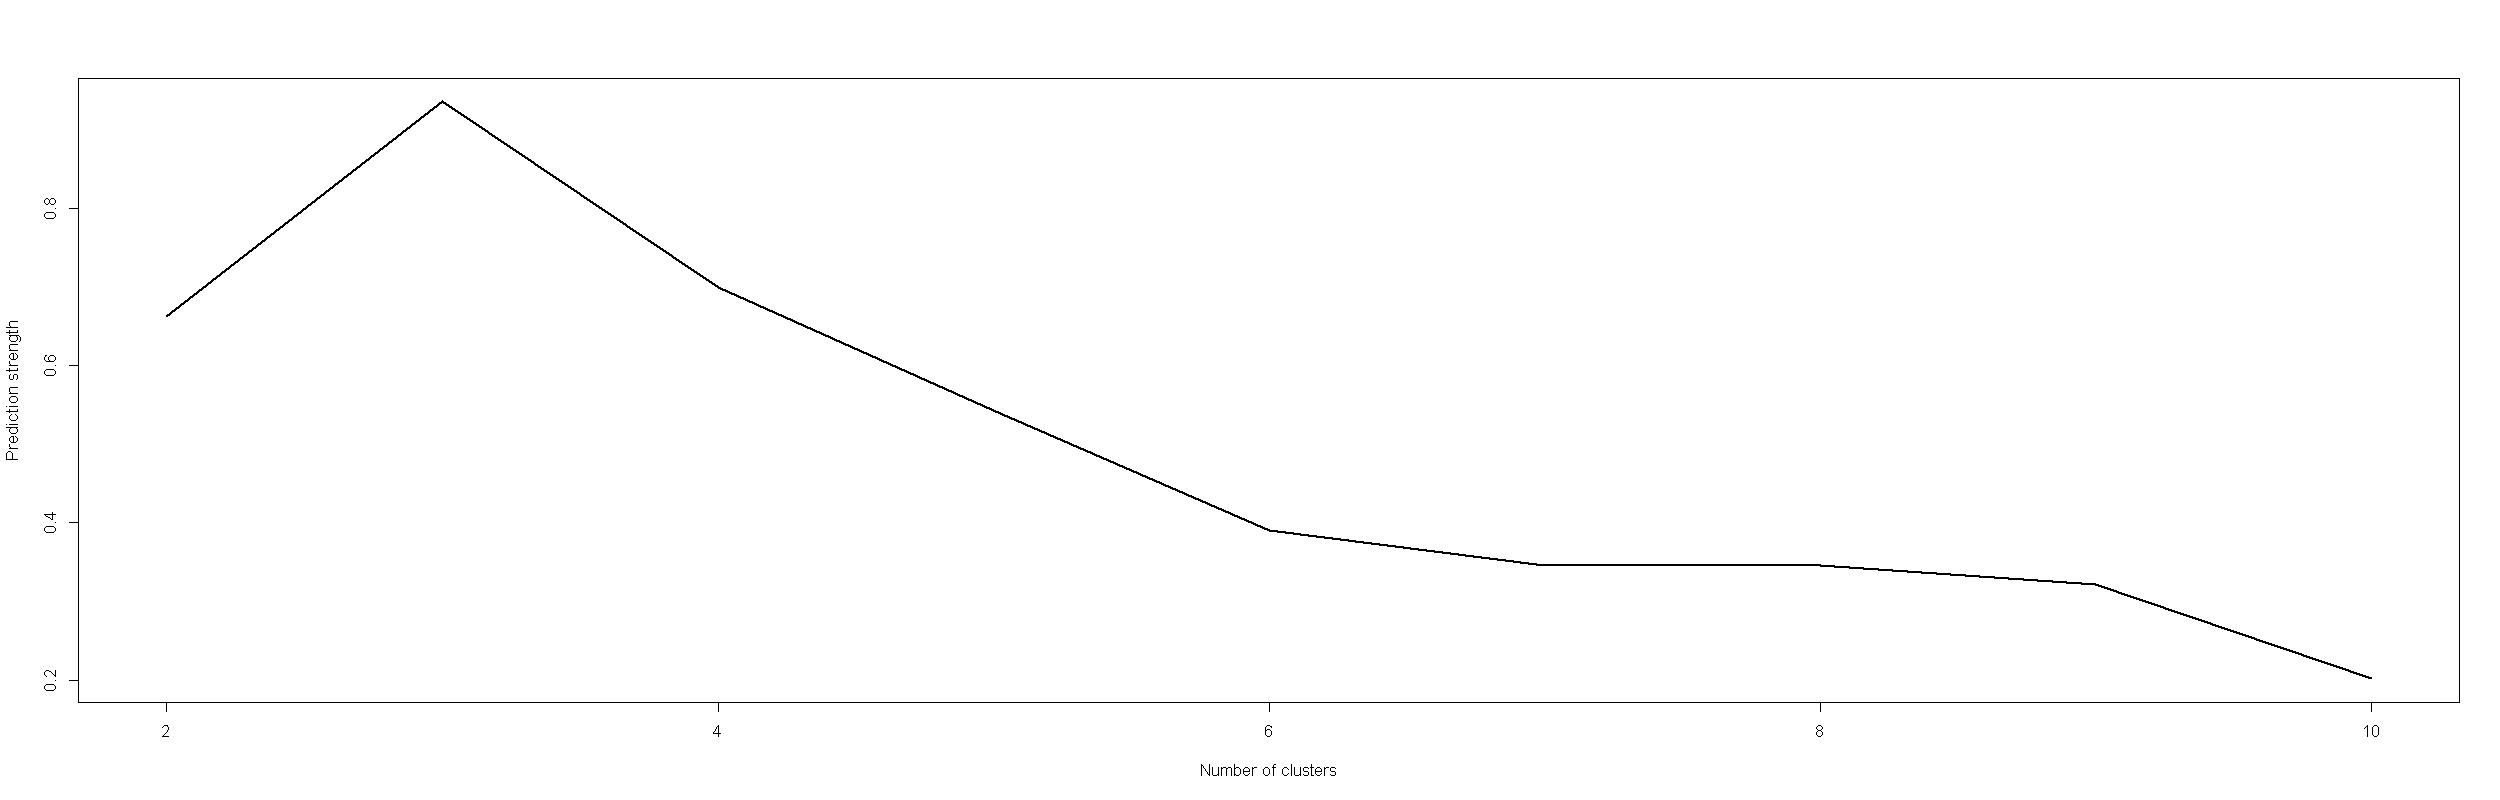

In [372]:
irisnew<-iris
irisnew[iris[,5]=="virginica",1]<-irisnew[iris[,5]=="virginica",1]+2
ss<-seq(1,dim(iris)[1])[iris[,5]=="virginica"]
irisnew[ss[1:25],2]<-irisnew[ss[1:25],2]+3
ii<-sample(seq(1,150),100)
pp<-prediction.strength(irisnew[ii,-5], Gmin=2,Gmax=10,clustermethod=kmeansCBI, classification="centroid",M=10)
plot(seq(2,10),pp$mean.pred[-1],xlab="Number of clusters", ylab="Prediction strength", type="l",lwd=2)
#
# Do a couple of times and check how many clusters are selected


Your results here may vary a bit from sample to sample - run a couple of times to see.

In general, you need quite a lot of data for cluster prediction strength. Try simulated a larger version of the iris data set (bootstrap with noise added).

Next, try this with a different clustering and classification method (here hierarchical clustering and knn).

Warning message in max(which(mean.pred > cutoff)):
"no non-missing arguments to max; returning -Inf"


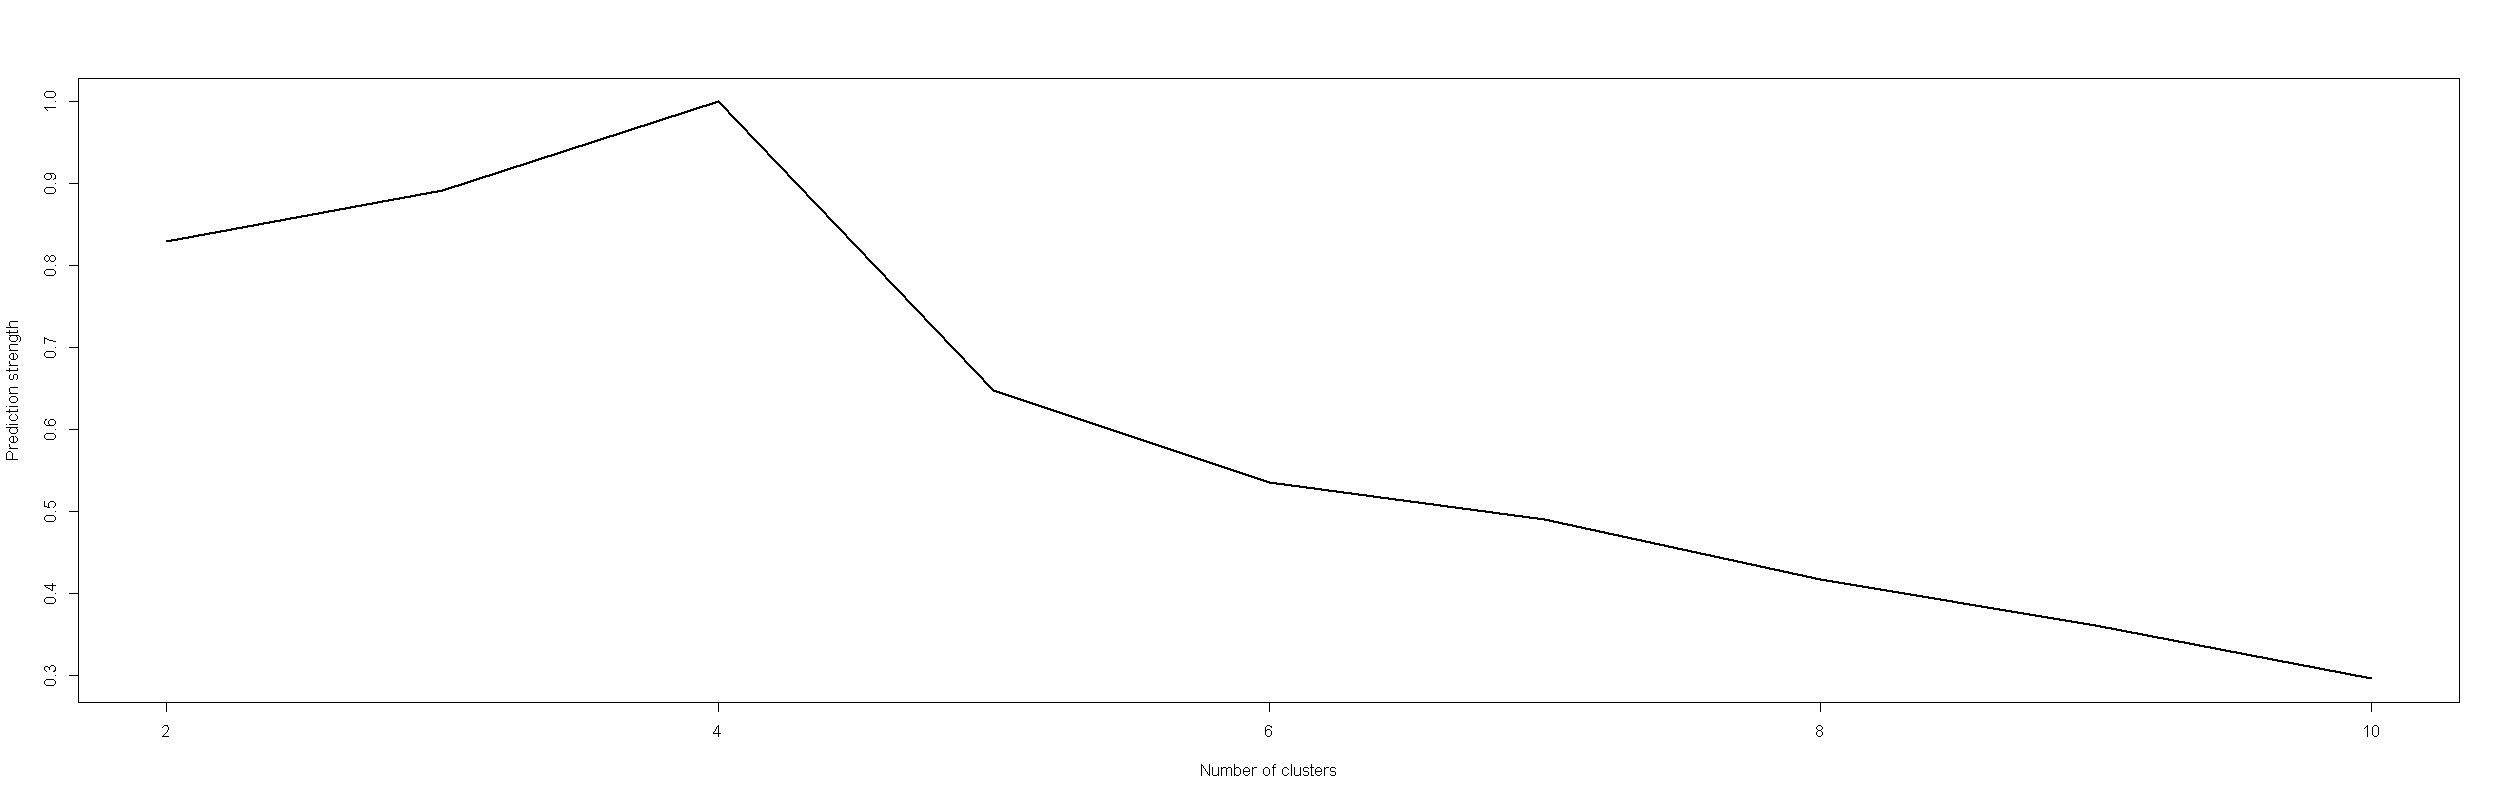

In [373]:
##
# You can also try different clustering and classification methods...
irisnew<-iris
irisnew[iris[,5]=="virginica",1]<-irisnew[iris[,5]=="virginica",1]+2
ss<-seq(1,dim(iris)[1])[iris[,5]=="virginica"]
irisnew[ss[1:25],2]<-irisnew[ss[1:25],2]+4
ii<-sample(seq(1,150),100)
pp<-prediction.strength(irisnew[ii,-5], Gmin=2,Gmax=10,clustermethod=hclustCBI, method="complete",cut="level",classification="knn",nnk=5,M=10)
plot(seq(2,10),pp$mean.pred[-1],xlab="Number of clusters", ylab="Prediction strength", type="l",lwd=2)
#

With these sets of methods, it seems more clear that 4 clusters are detectable for the manipulated data set.

## Comparing clusters.

A key component to cluster selection and validation is having metrics to compare clusters. One popular metric to compare 2 cluster results is the *Rand Index* defined as

$$RI = \frac{a+b}{a+b+c+d}$$

where $a$ is the number of pairs that are together in both cluster results and $b$ are the number of pairs that are not together in both cluster results. $c$ and $d$ are the number of pairs that are together in the first cluster results but not together in the other, and vice versa. A high Rand Index means that clusters overlap a lot. The Adjusted RI (or corrected RI) is a metric that adjust for what cluster overlap could be expected just by chance. 

A second commonly used metric is the *Jaccard Index* defined as the ratio between the intersection and the union of two sets. Here, one can use this at the cluster level to measure how much in agreement a cluster allocation is between two cluster results. 

Another metric, used below, is the *Variation of Information*. Two cluster methods result in two different partions of the data $A_1,\cdots,A_K$ and $B_1,\cdots, B_J$. For each partition $A$ you can compute the cluster proportions $a_k, k=1,\cdots,K$  similarly for $B$ we get  $b_j, j=1,\cdots,J$. Let $o_{kj} = A_k \cup B_j$ for all pairs of clusters between the two partitions. The Variation of Information is then defined as 

$$ VI = - \sum_{k,j} o_{k,j} \bigl(\log(\frac{o_{kj}}{a_{k}}) + \log(\frac{o_{kj}}{b_{j}})\bigr) $$

which is measure of distance between the clusterings. A small value indicates that there is a strong agreement between the clusters.

$corrected.rand
[1] 0.4409438

$vi
[1] 0.6952069

   hh
     1  2
  1 53  0
  2 25 72

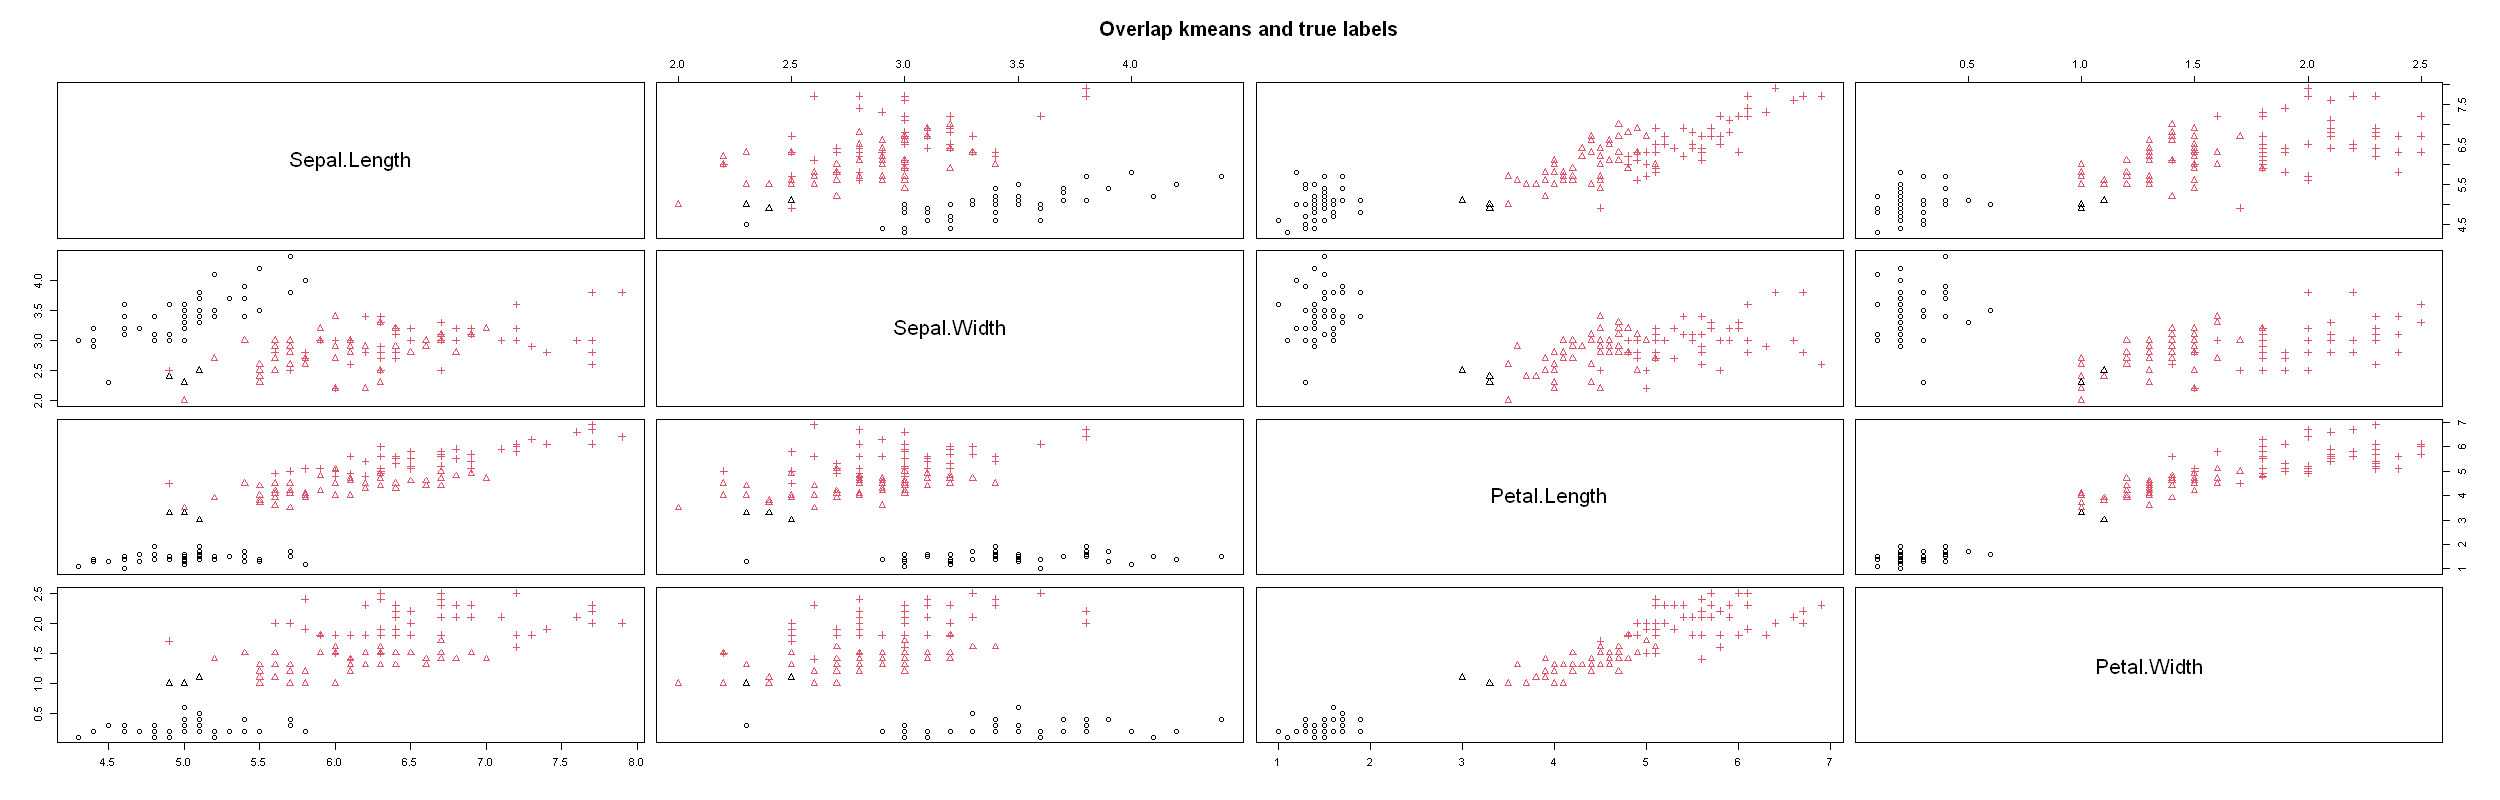

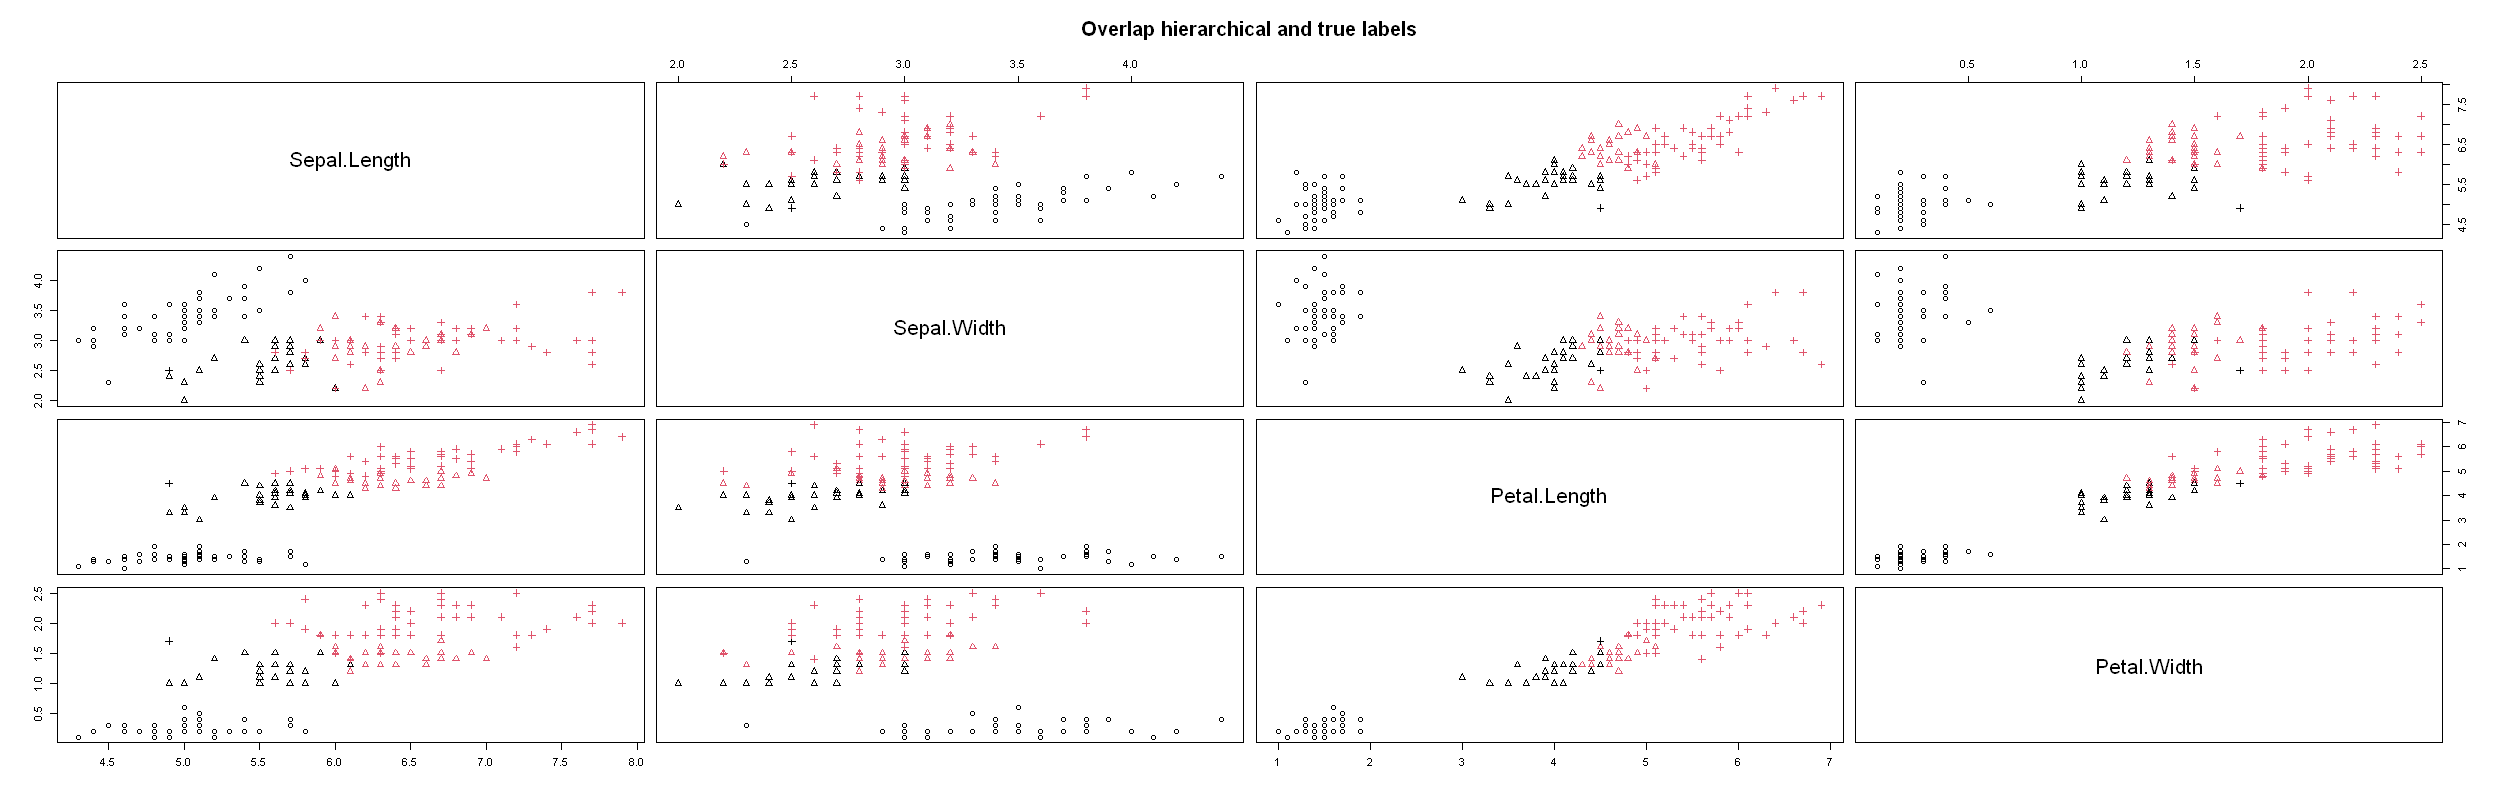

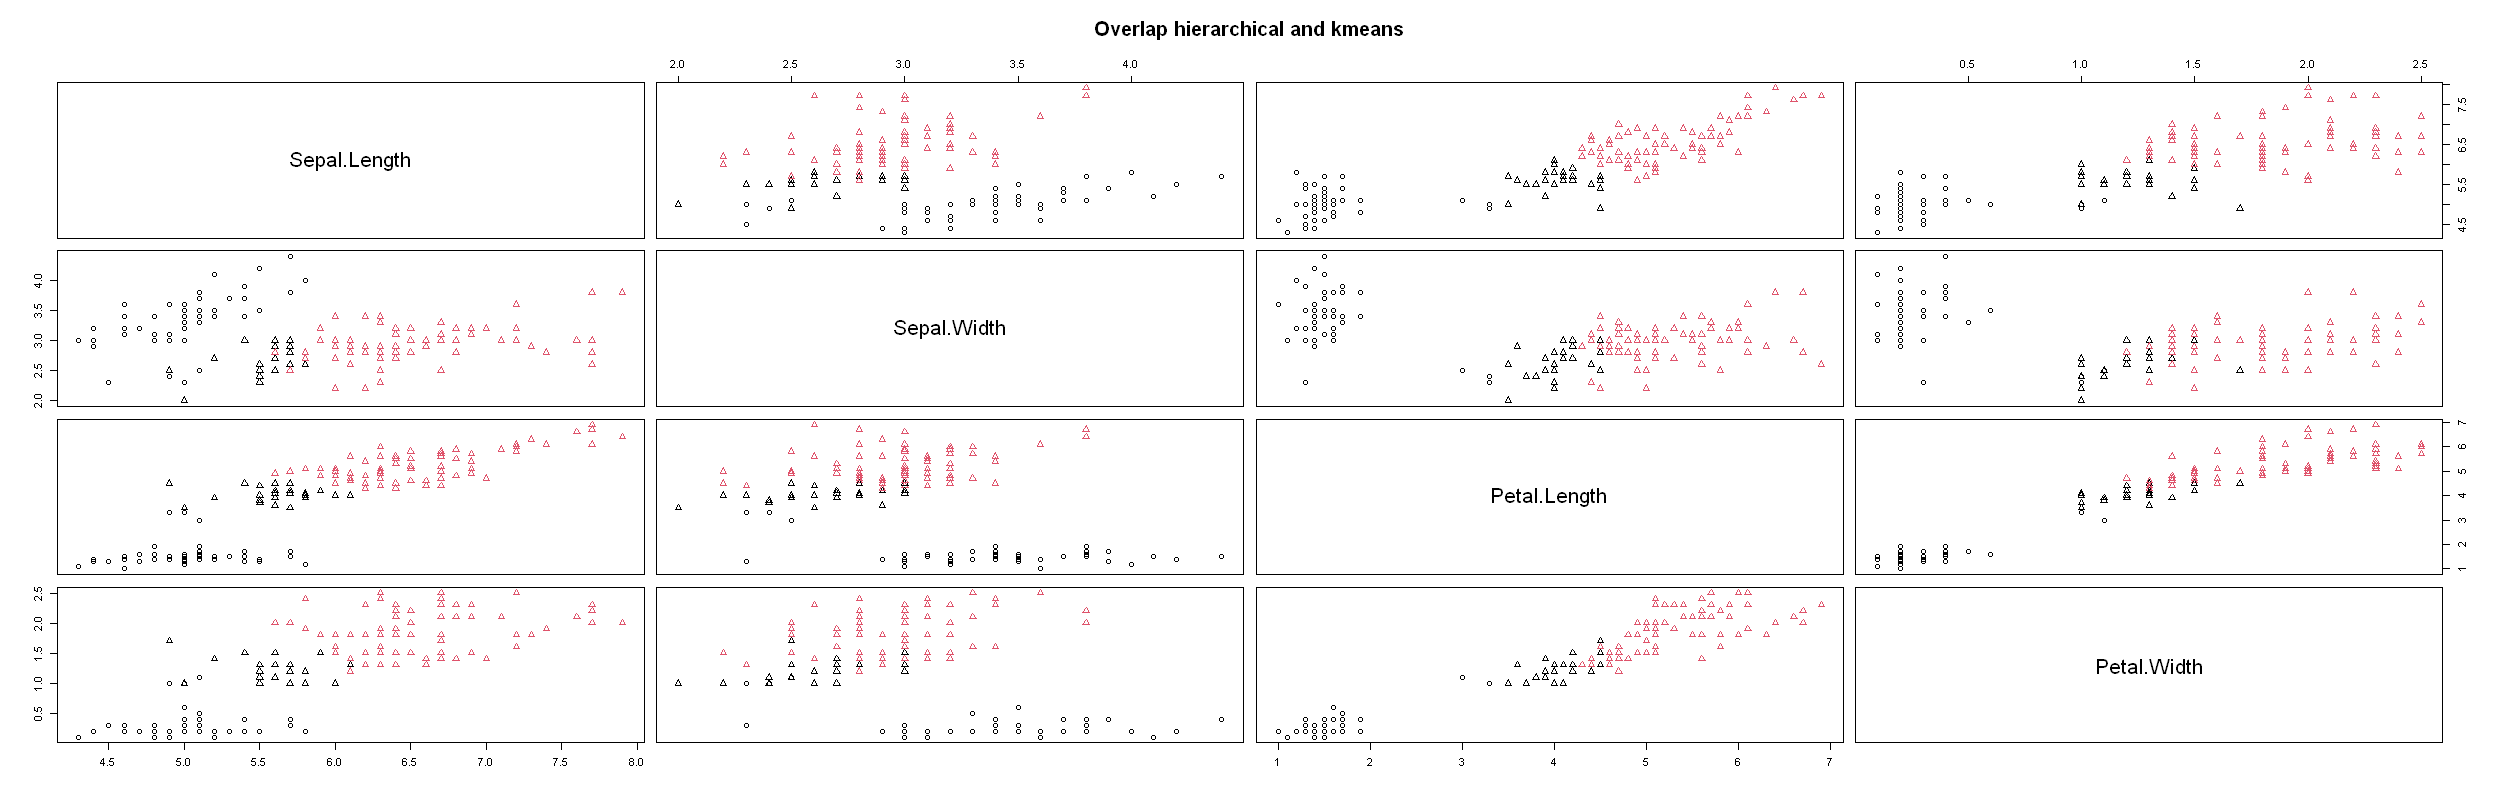

In [374]:
kk<-kmeans(iris[,-5],2) # try different number of clusters
#
#hh<-kmeans(iris[,-5],3)$cluster
hh<-cutree(hclust(dist(iris[,-5])),2)
cluster.stats(clustering=kk$cluster,alt.clustering=hh,compareonly = T)
table(kk$cluster,hh)
pairs(iris[,-5],col=kk$cluster,pch=as.numeric(iris[,5]), main = "Overlap kmeans and true labels")
pairs(iris[,-5],col=hh,pch=as.numeric(iris[,5]), main = "Overlap hierarchical and true labels")
pairs(iris[,-5],col=hh,pch=kk$cluster, main = "Overlap hierarchical and kmeans")

$corrected.rand
[1] 0.3479734

$vi
[1] 0.8162364

   hh
     1  2  3
  1 54  0  0
  2 46  0 24
  3  0 25  1

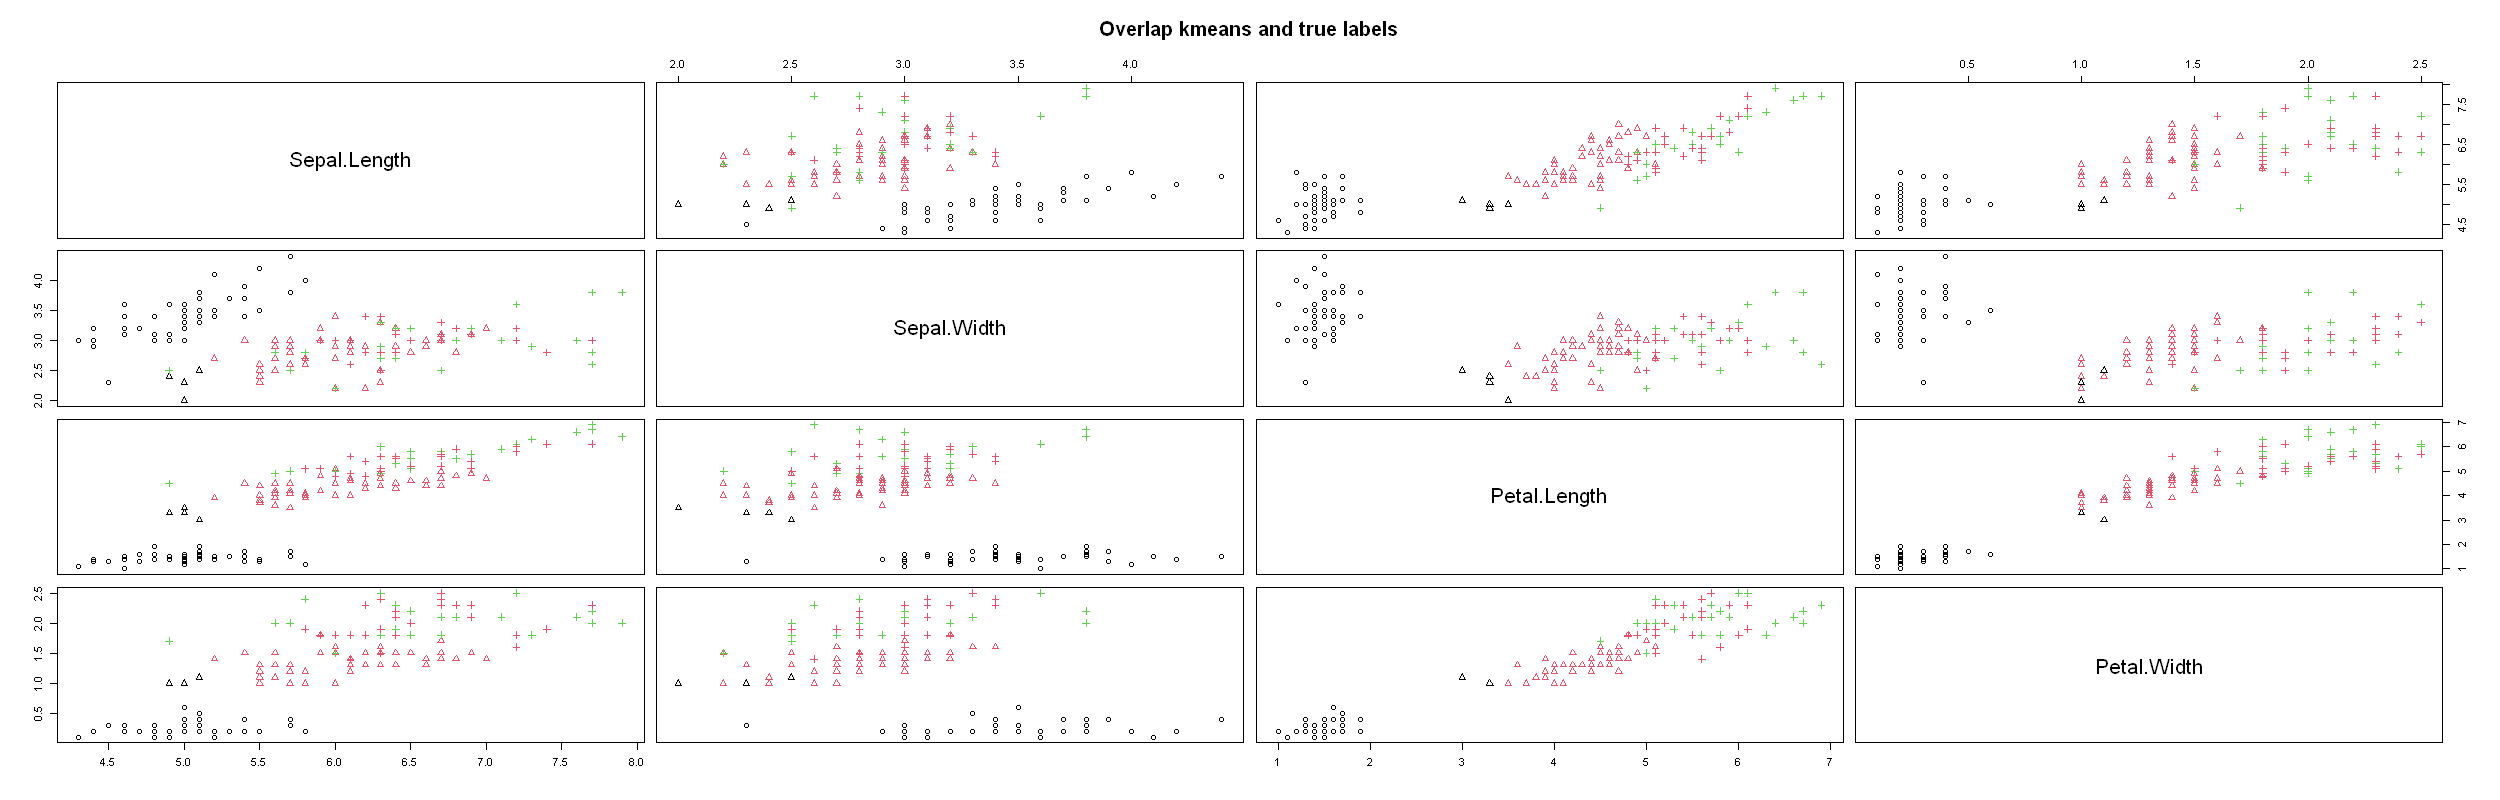

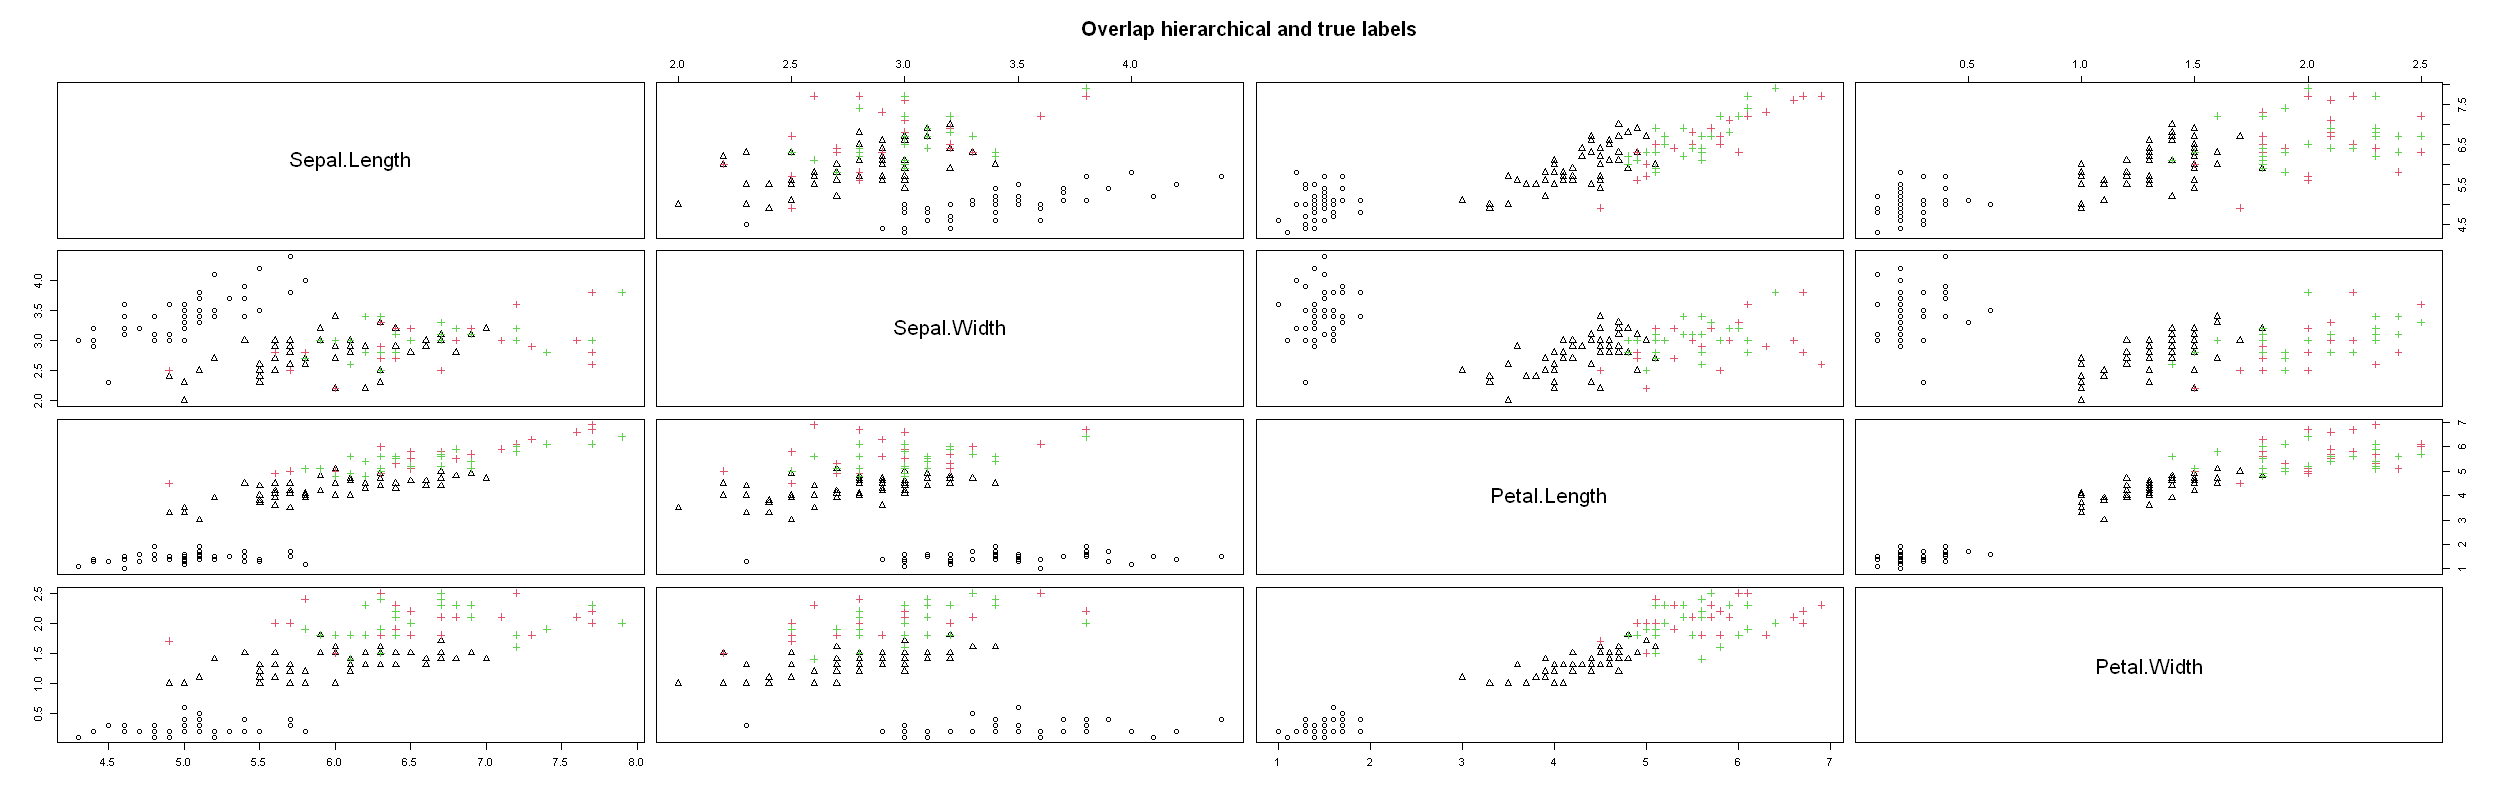

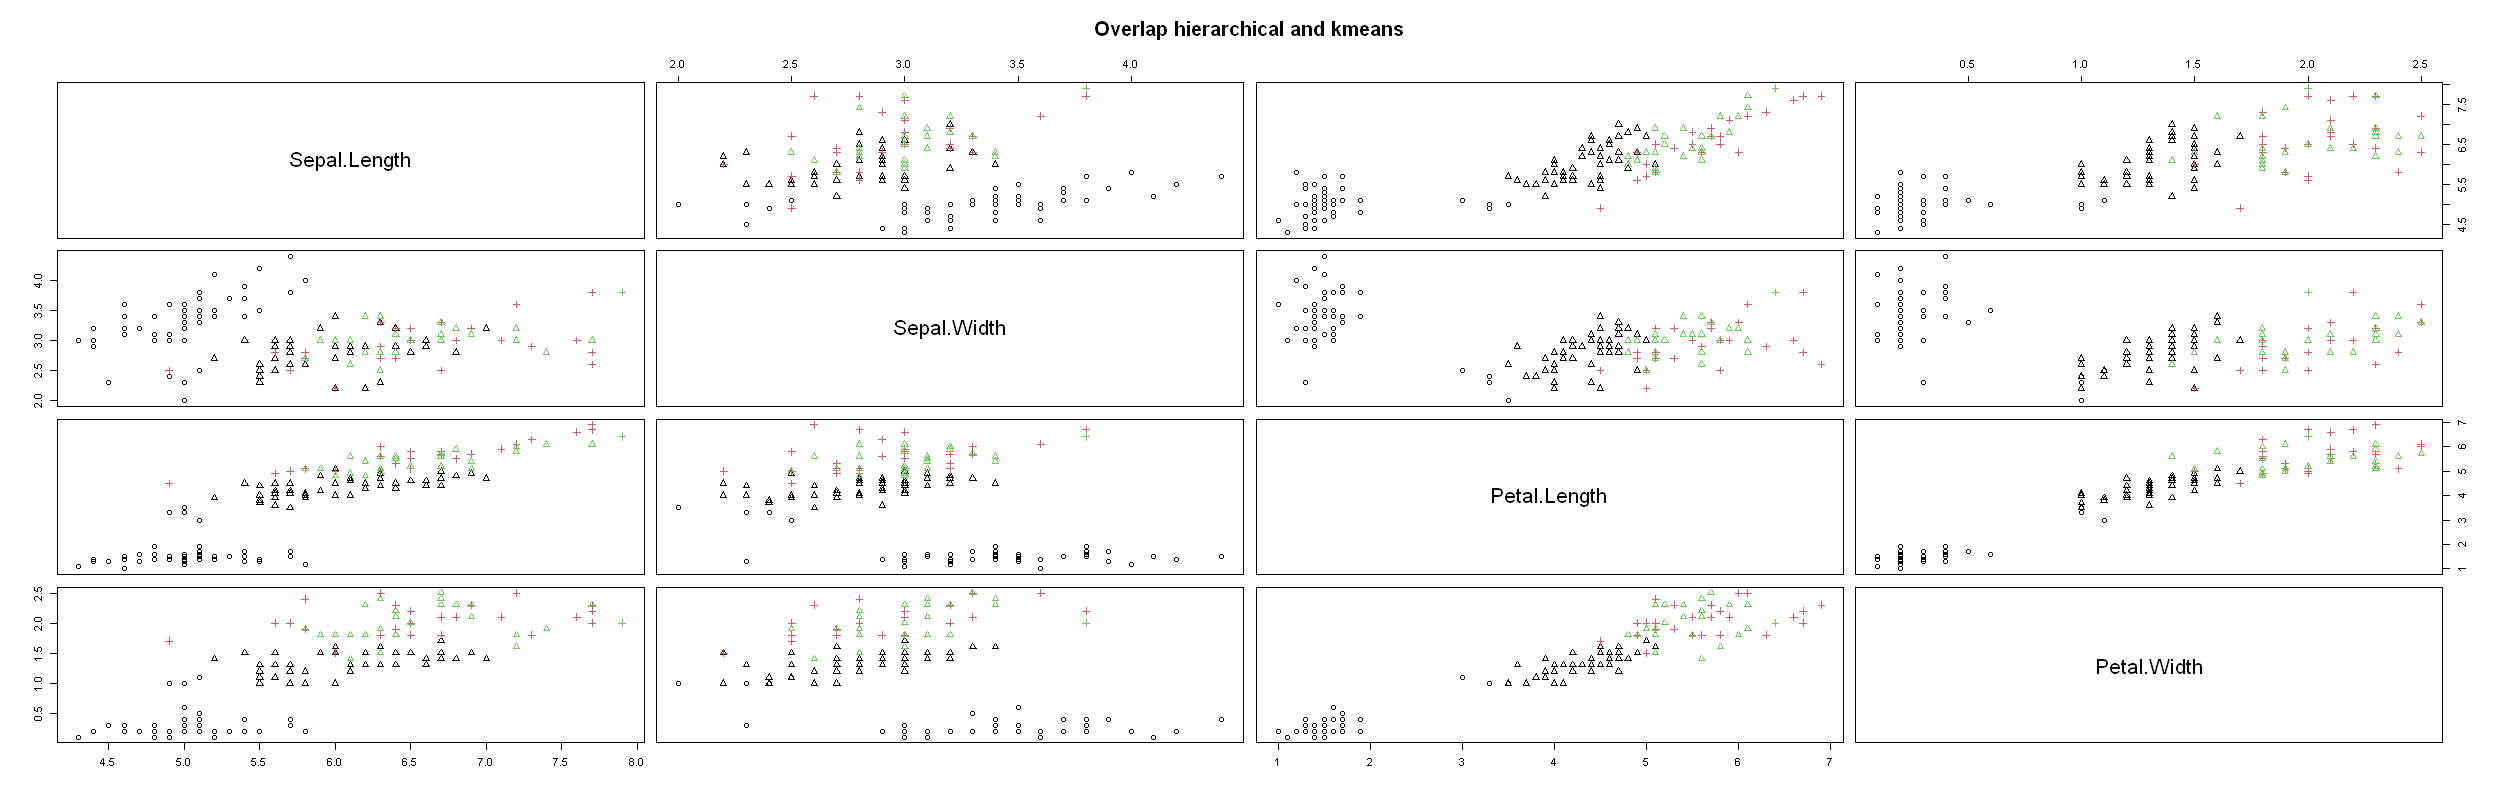

In [375]:
kk<-kmeans(irisnew[,-5],3) # try different number of clusters
#
hh<-cutree(hclust(dist(irisnew[,-5])),3)
cluster.stats(clustering=kk$cluster,alt.clustering=hh,compareonly = T)
table(kk$cluster,hh)
pairs(iris[,-5],col=kk$cluster,pch=as.numeric(iris[,5]), main = "Overlap kmeans and true labels")
pairs(iris[,-5],col=hh,pch=as.numeric(iris[,5]), main = "Overlap hierarchical and true labels")
pairs(iris[,-5],col=hh,pch=kk$cluster, main = "Overlap hierarchical and kmeans")

The kmeans and hierarchical cluster results with 3 clusters do not overlap as you can see from the indices and the scatter plots. 
Try with more methods, different distances and see what happens.

What about the more separated data set?

$corrected.rand
[1] 0.9204051

$vi
[1] 0.1666847

   hh
     1  2
  1 97  0
  2  3 50

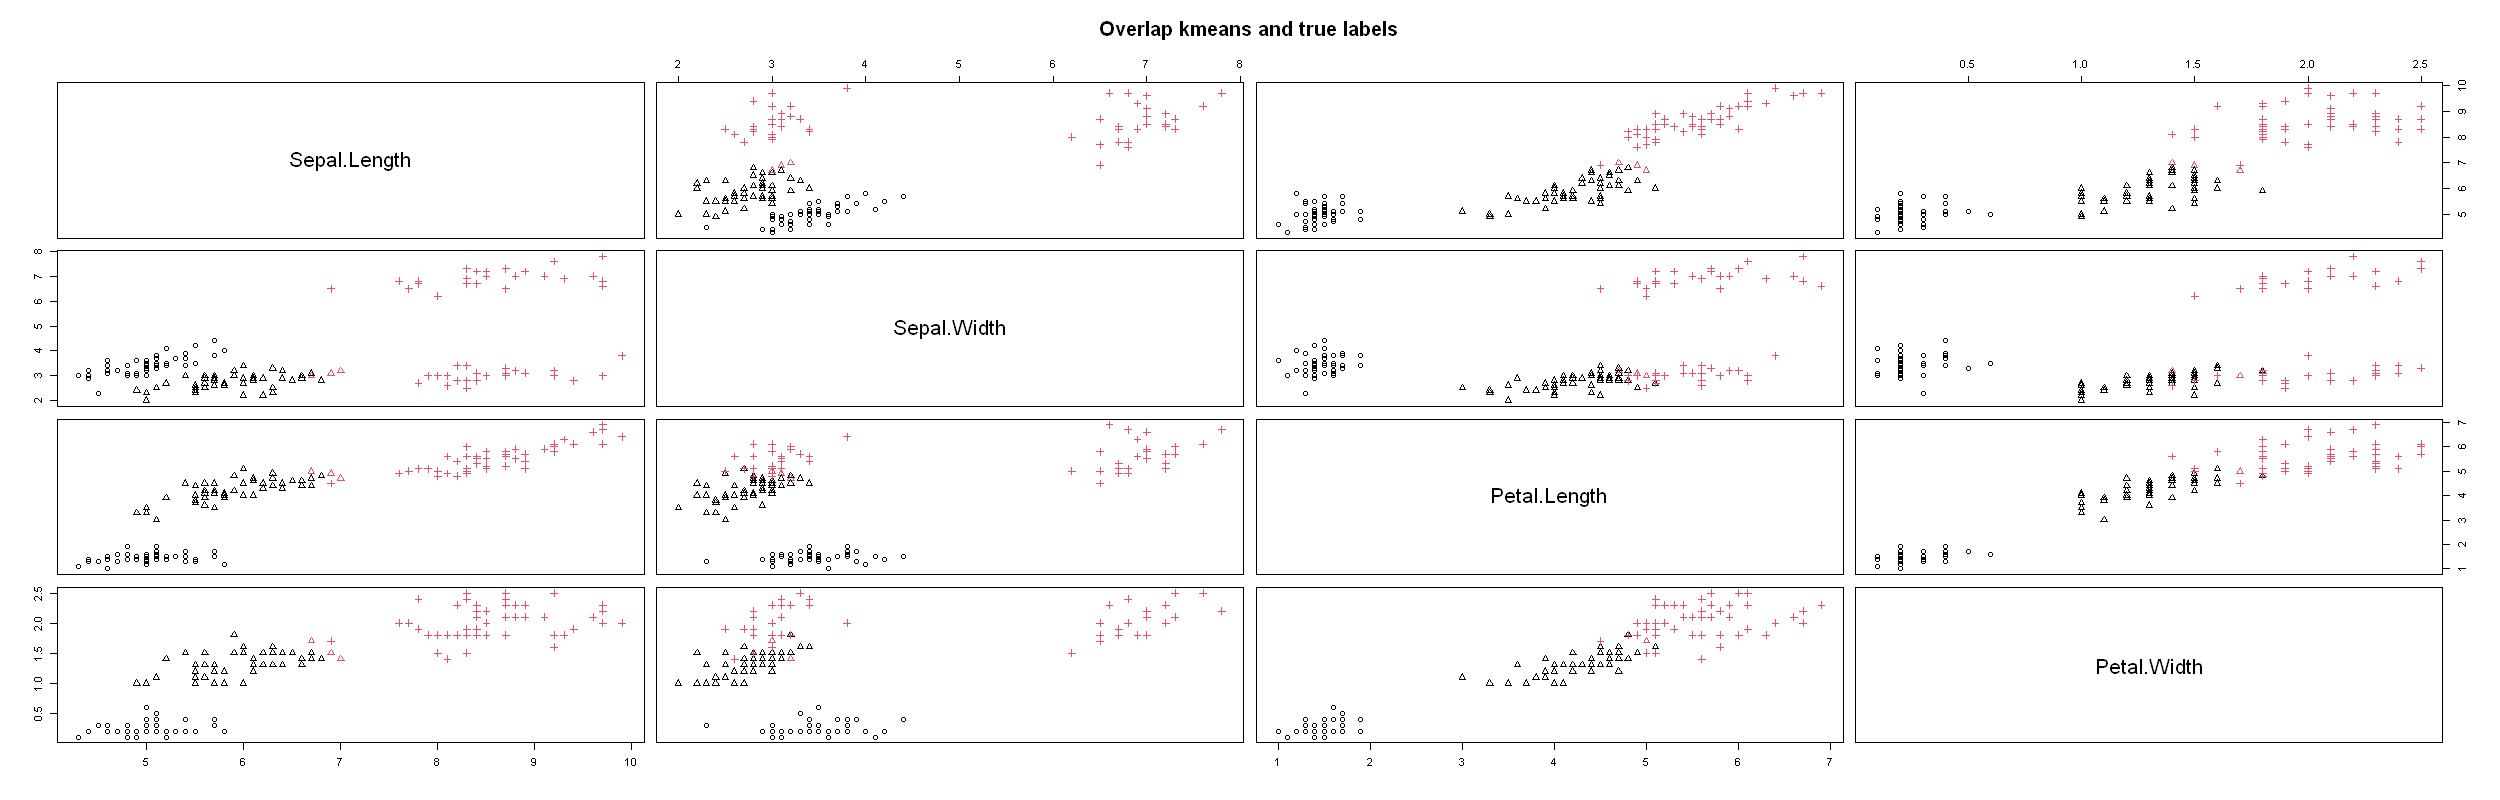

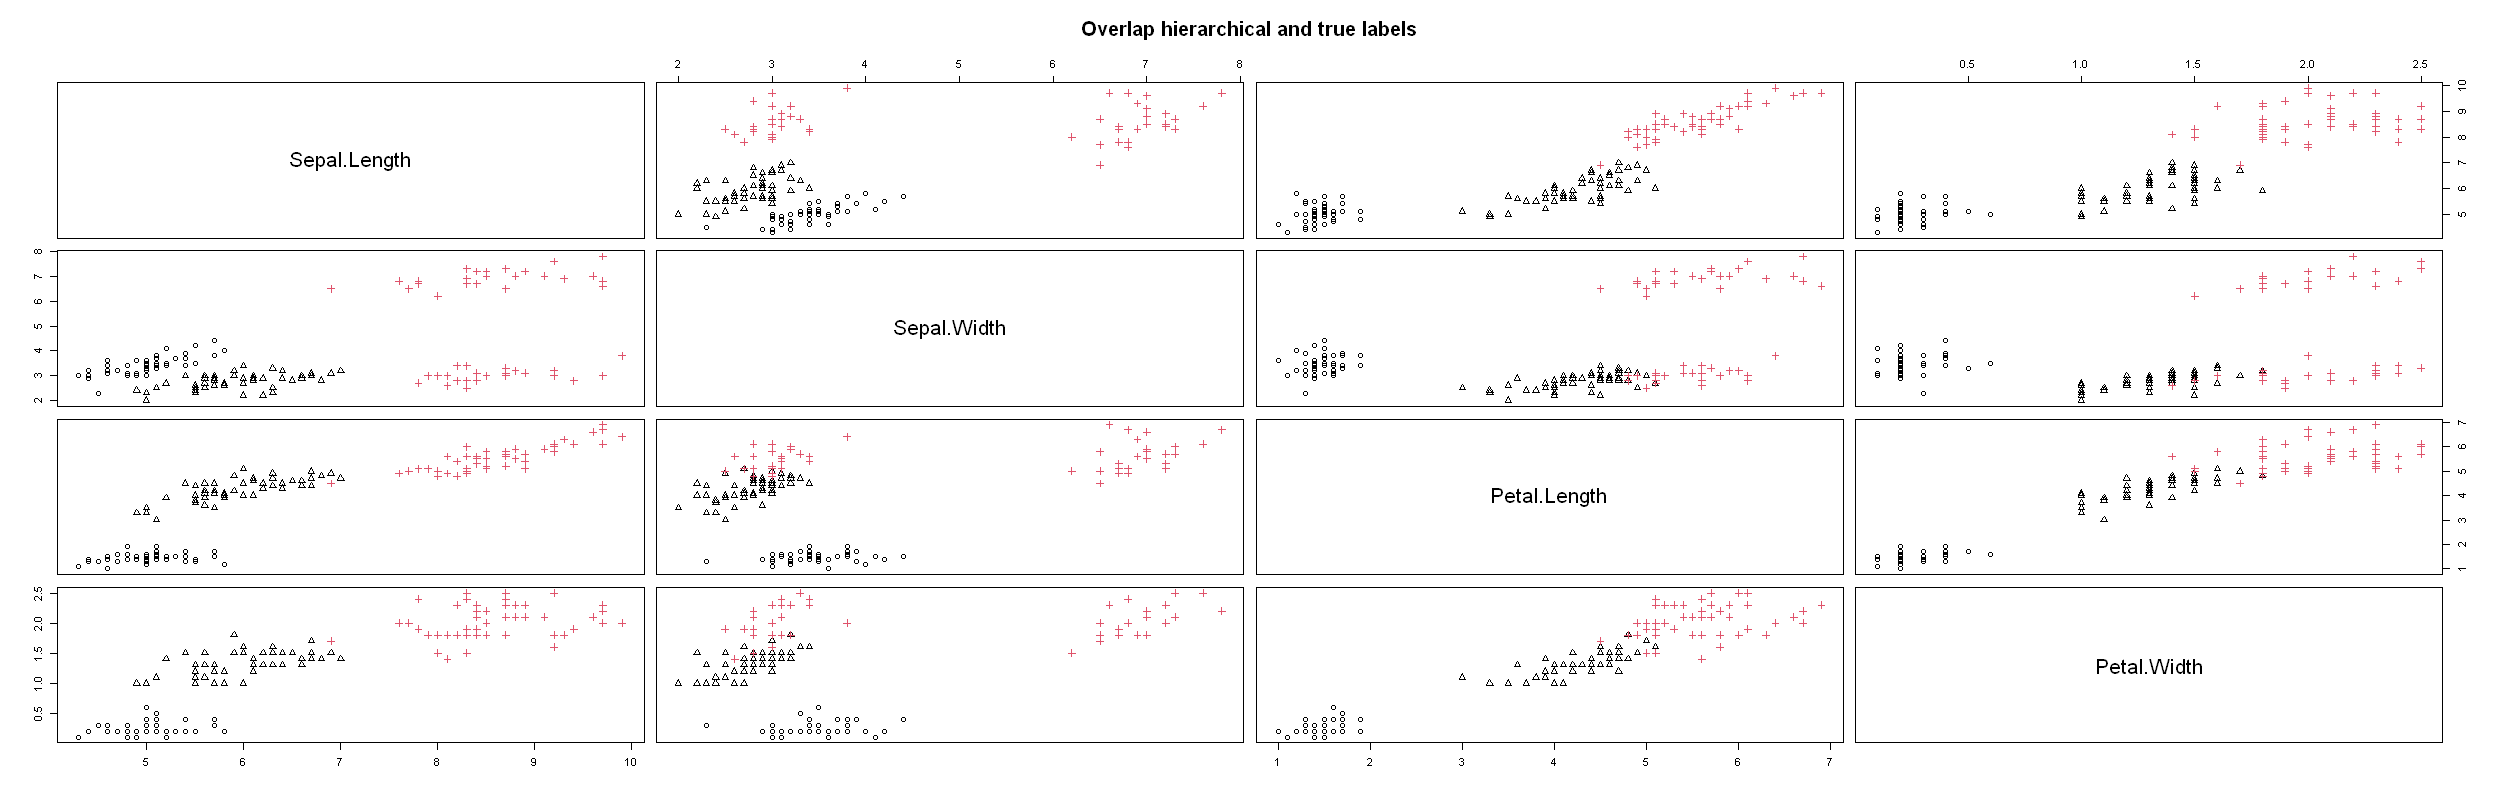

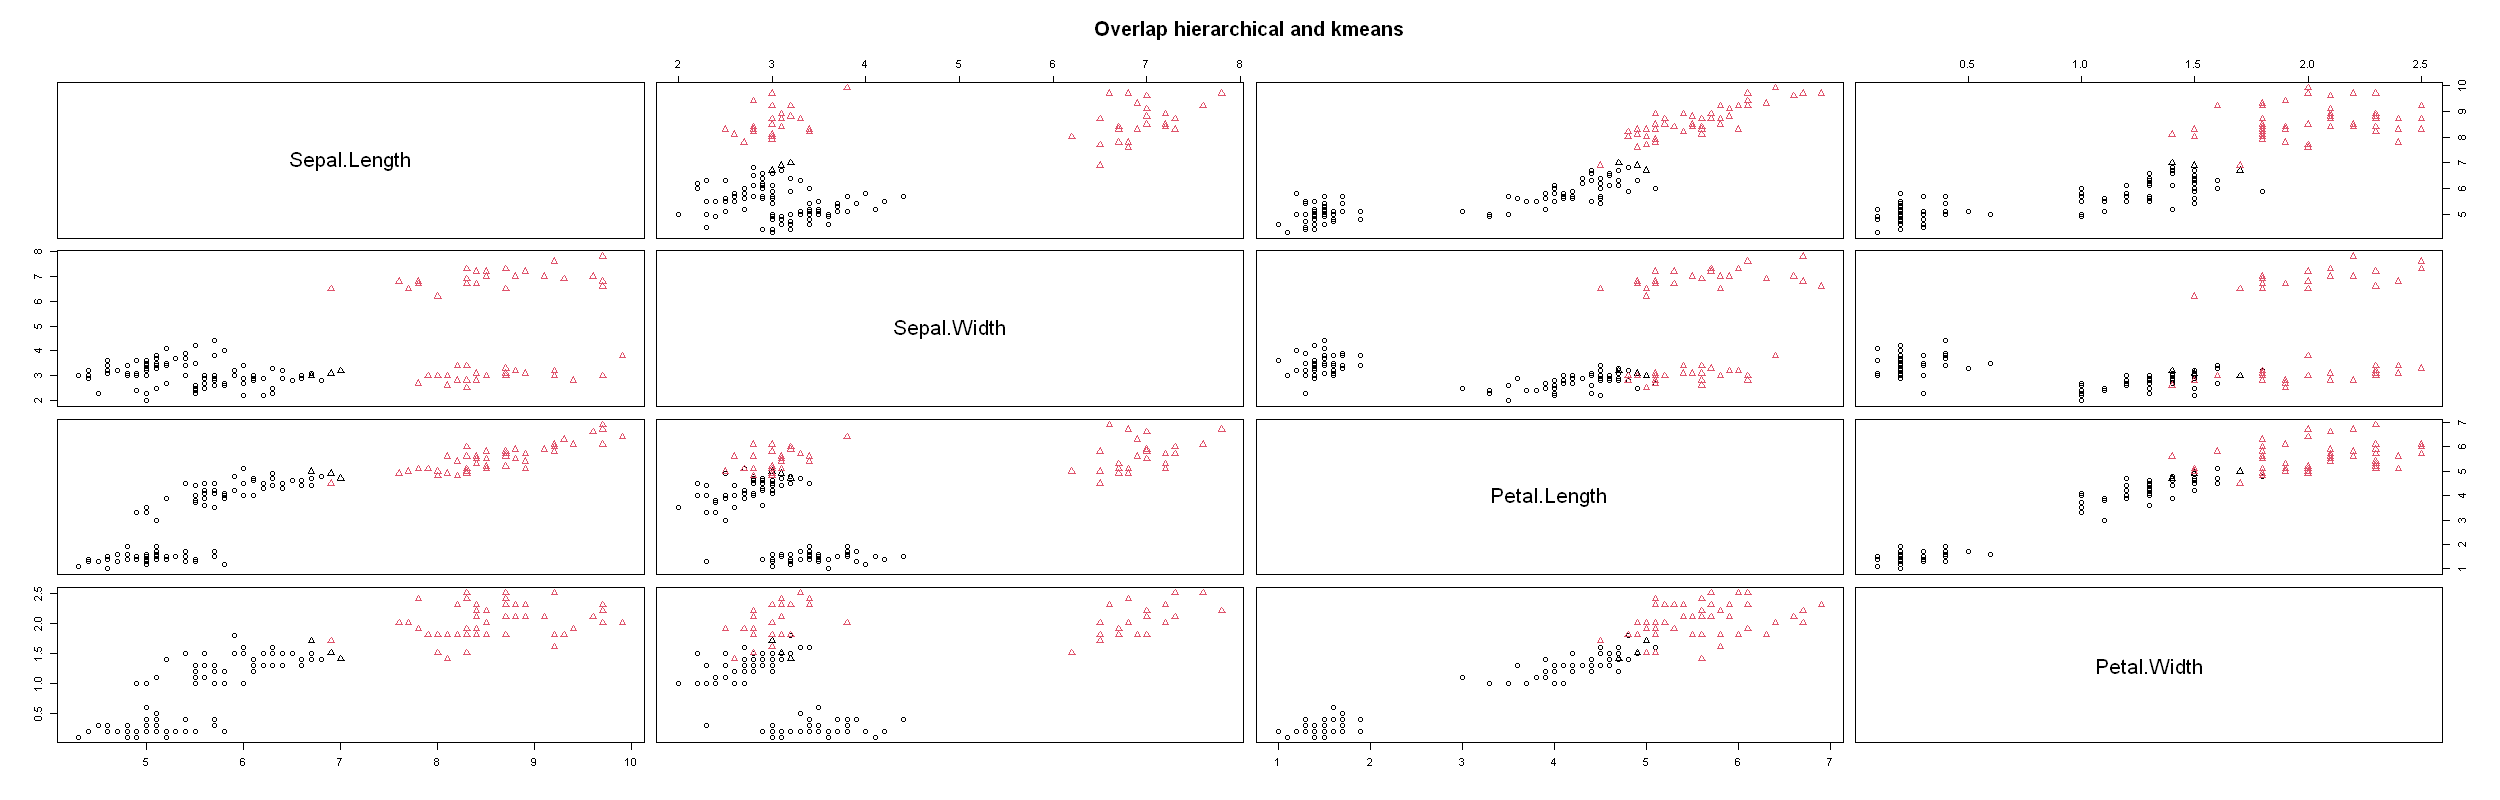

In [379]:
kk<-kmeans(irisnew[,-5],2)
hh<-cutree(hclust(dist(irisnew[,-5])),2)
cluster.stats(clustering=kk$cluster,alt.clustering=hh,compareonly = T)
table(kk$cluster,hh)
pairs(irisnew[,-5],col=kk$cluster,pch=as.numeric(iris[,5]), main = "Overlap kmeans and true labels")
pairs(irisnew[,-5],col=hh,pch=as.numeric(iris[,5]), main = "Overlap hierarchical and true labels")
pairs(irisnew[,-5],col=hh,pch=kk$cluster, main = "Overlap hierarchical and kmeans")

$corrected.rand
[1] 1

$vi
[1] 0

   hh
     1  2  3  4
  1 50  0  0  0
  2  0  0  0 25
  3  0  0 25  0
  4  0 50  0  0

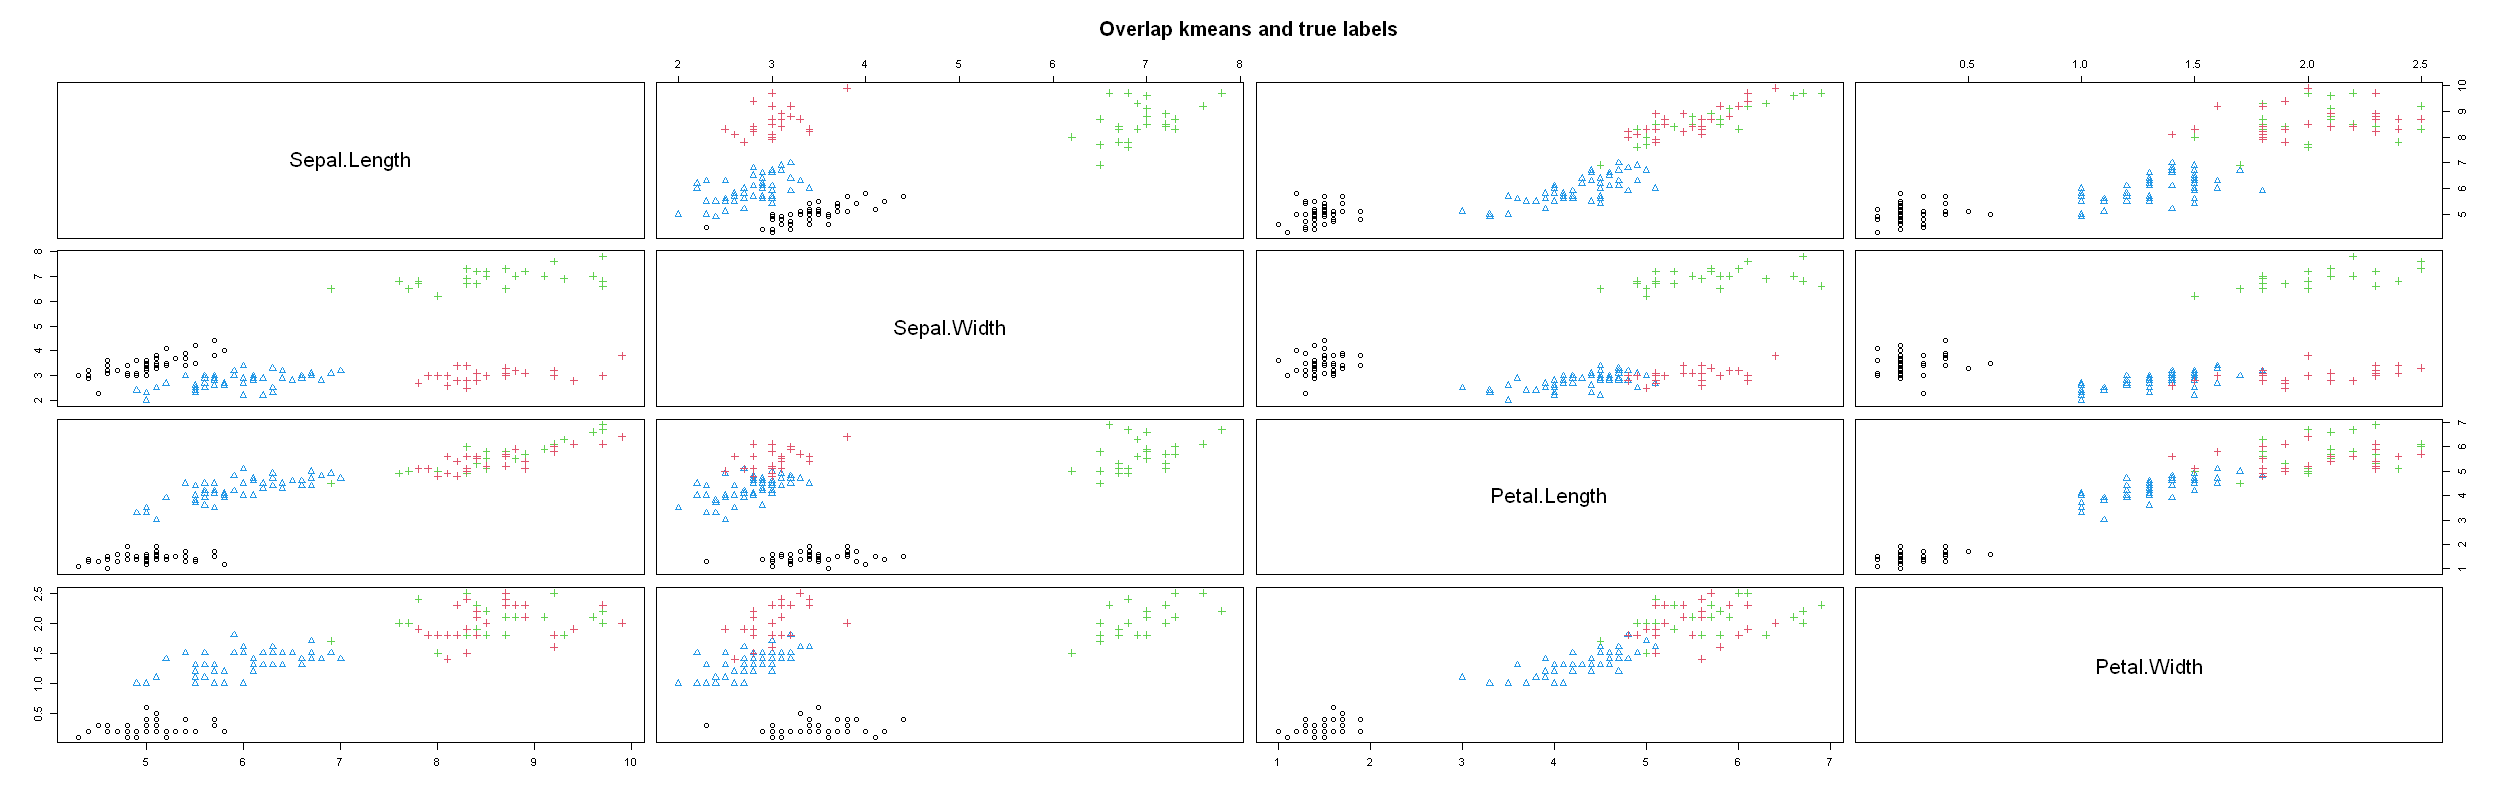

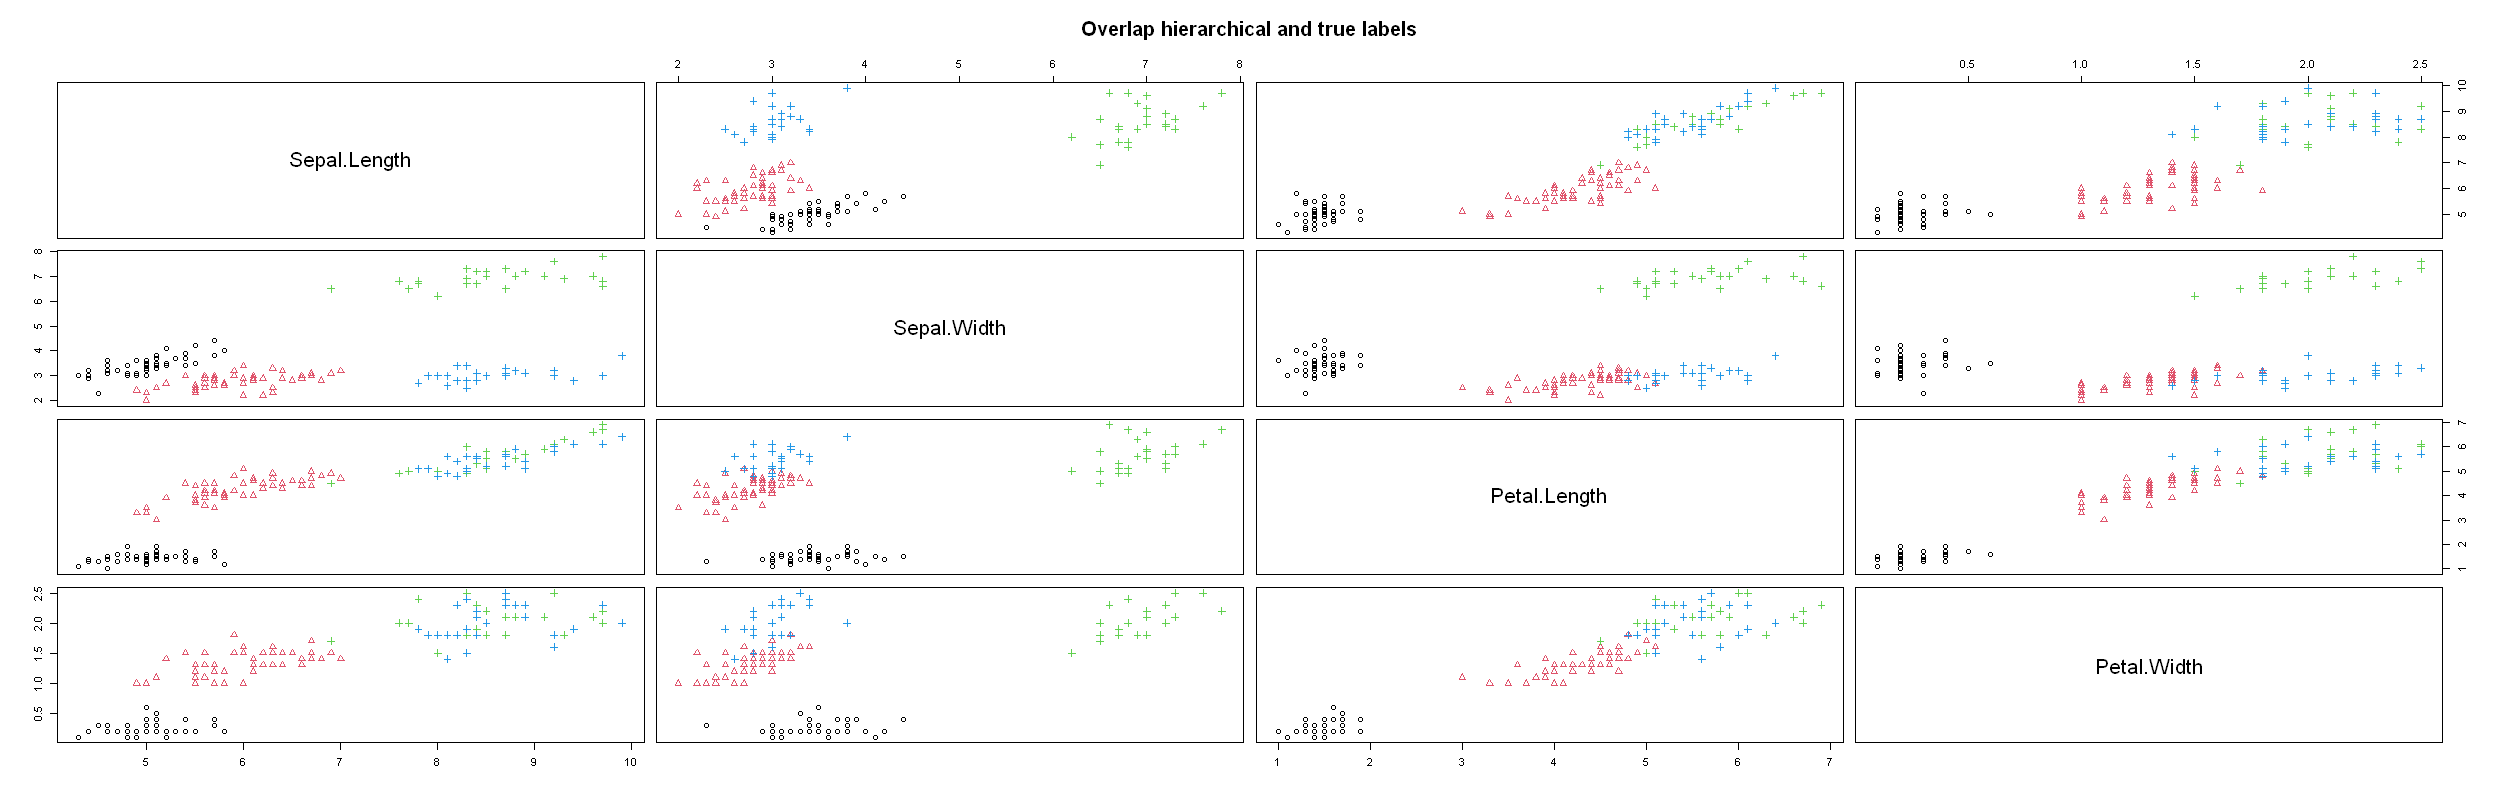

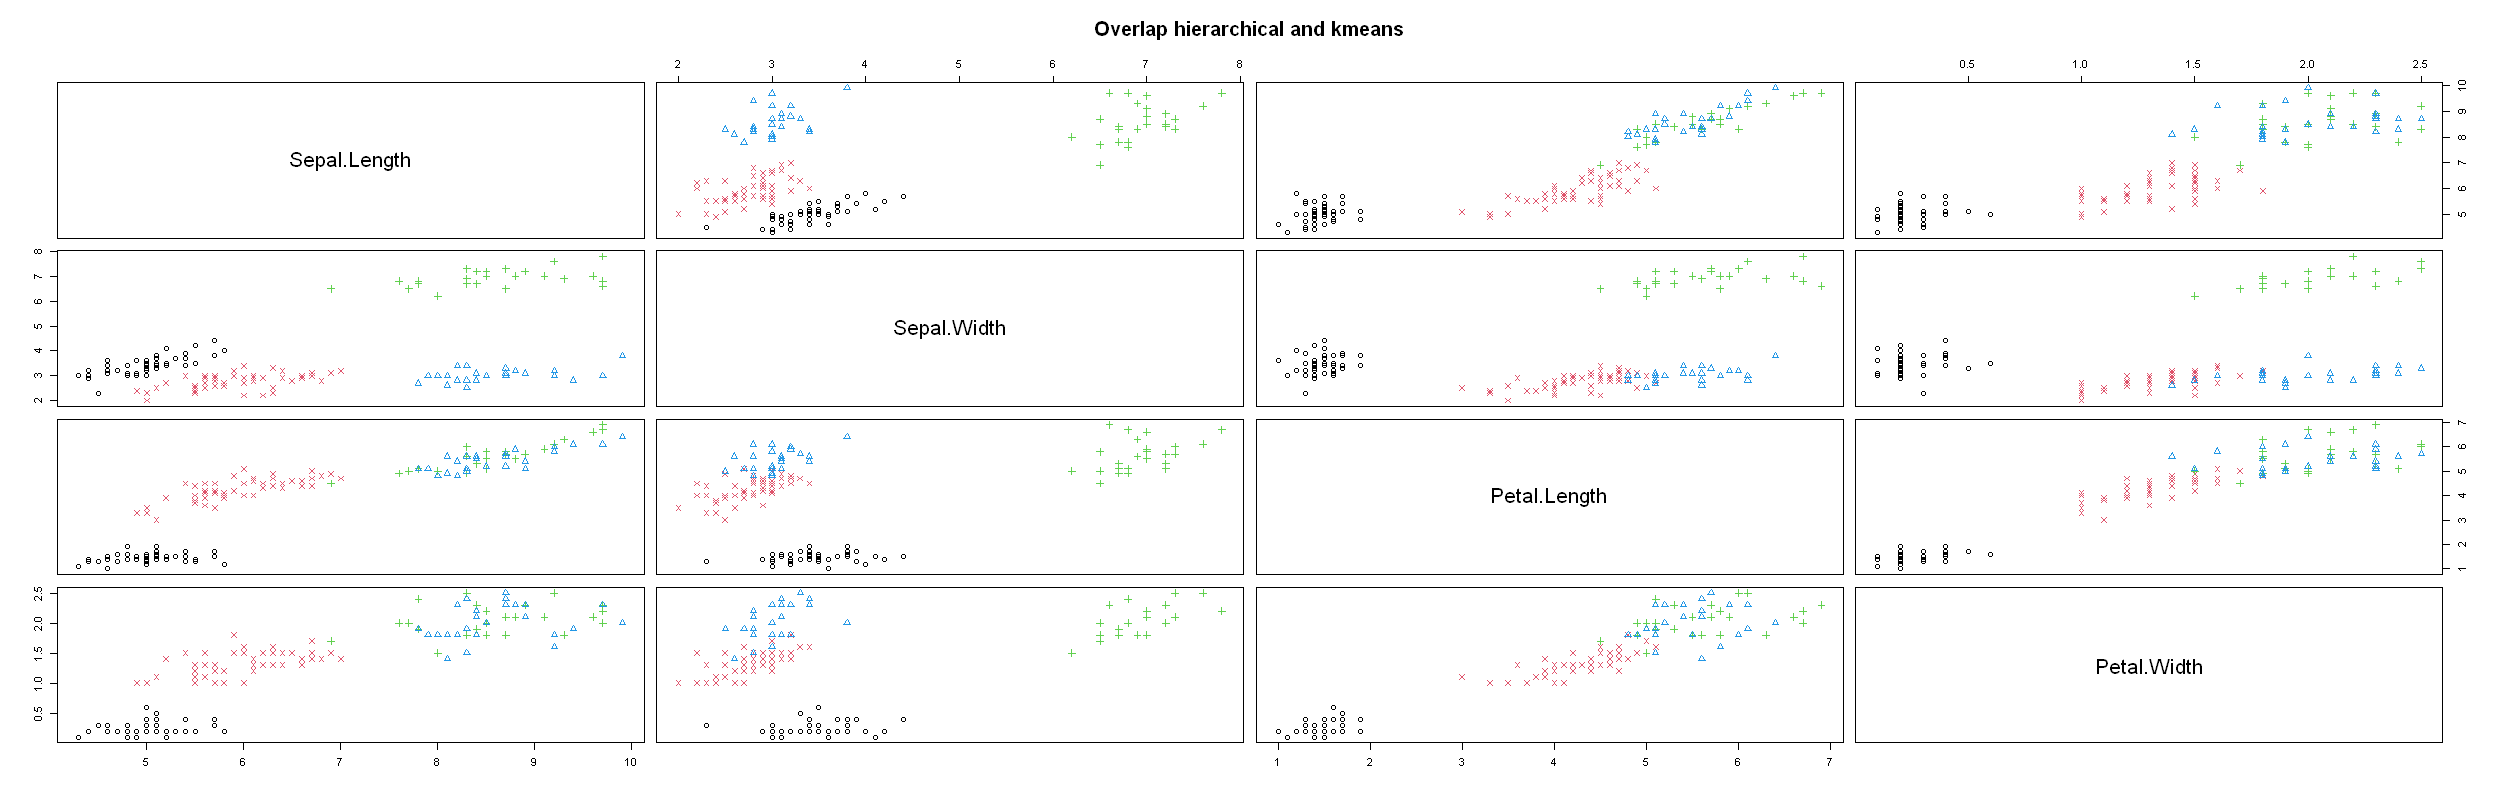

In [394]:
kk<-kmeans(irisnew[,-5],4)
hh<-cutree(hclust(dist(irisnew[,-5])),4)
cluster.stats(clustering=kk$cluster,alt.clustering=hh,compareonly = T)
table(kk$cluster,hh)
pairs(irisnew[,-5],col=kk$cluster,pch=as.numeric(iris[,5]), main = "Overlap kmeans and true labels")
pairs(irisnew[,-5],col=hh,pch=as.numeric(iris[,5]), main = "Overlap hierarchical and true labels")
pairs(irisnew[,-5],col=hh,pch=kk$cluster, main = "Overlap hierarchical and kmeans")

Now we have perfect agreement between kmeans and hierarchical clustering. This can vary from run to run so make sure to repeat the above a few times. 

## Cluster stability

Let's try resampling to assess how much clusters may vary for a random subset of observations. Are clusters stable?

boot 1 
boot 2 
* Cluster stability assessment *
Cluster method:  kmeans 
Full clustering results are given as parameter result
of the clusterboot object, which also provides further statistics
of the resampling results.
Number of resampling runs:  2 

Number of clusters found in data:  2 

 Clusterwise Jaccard bootstrap (omitting multiple points) mean:
[1] 1 1
dissolved:
[1] 0 0
recovered:
[1] 2 2
boot 1 
boot 2 


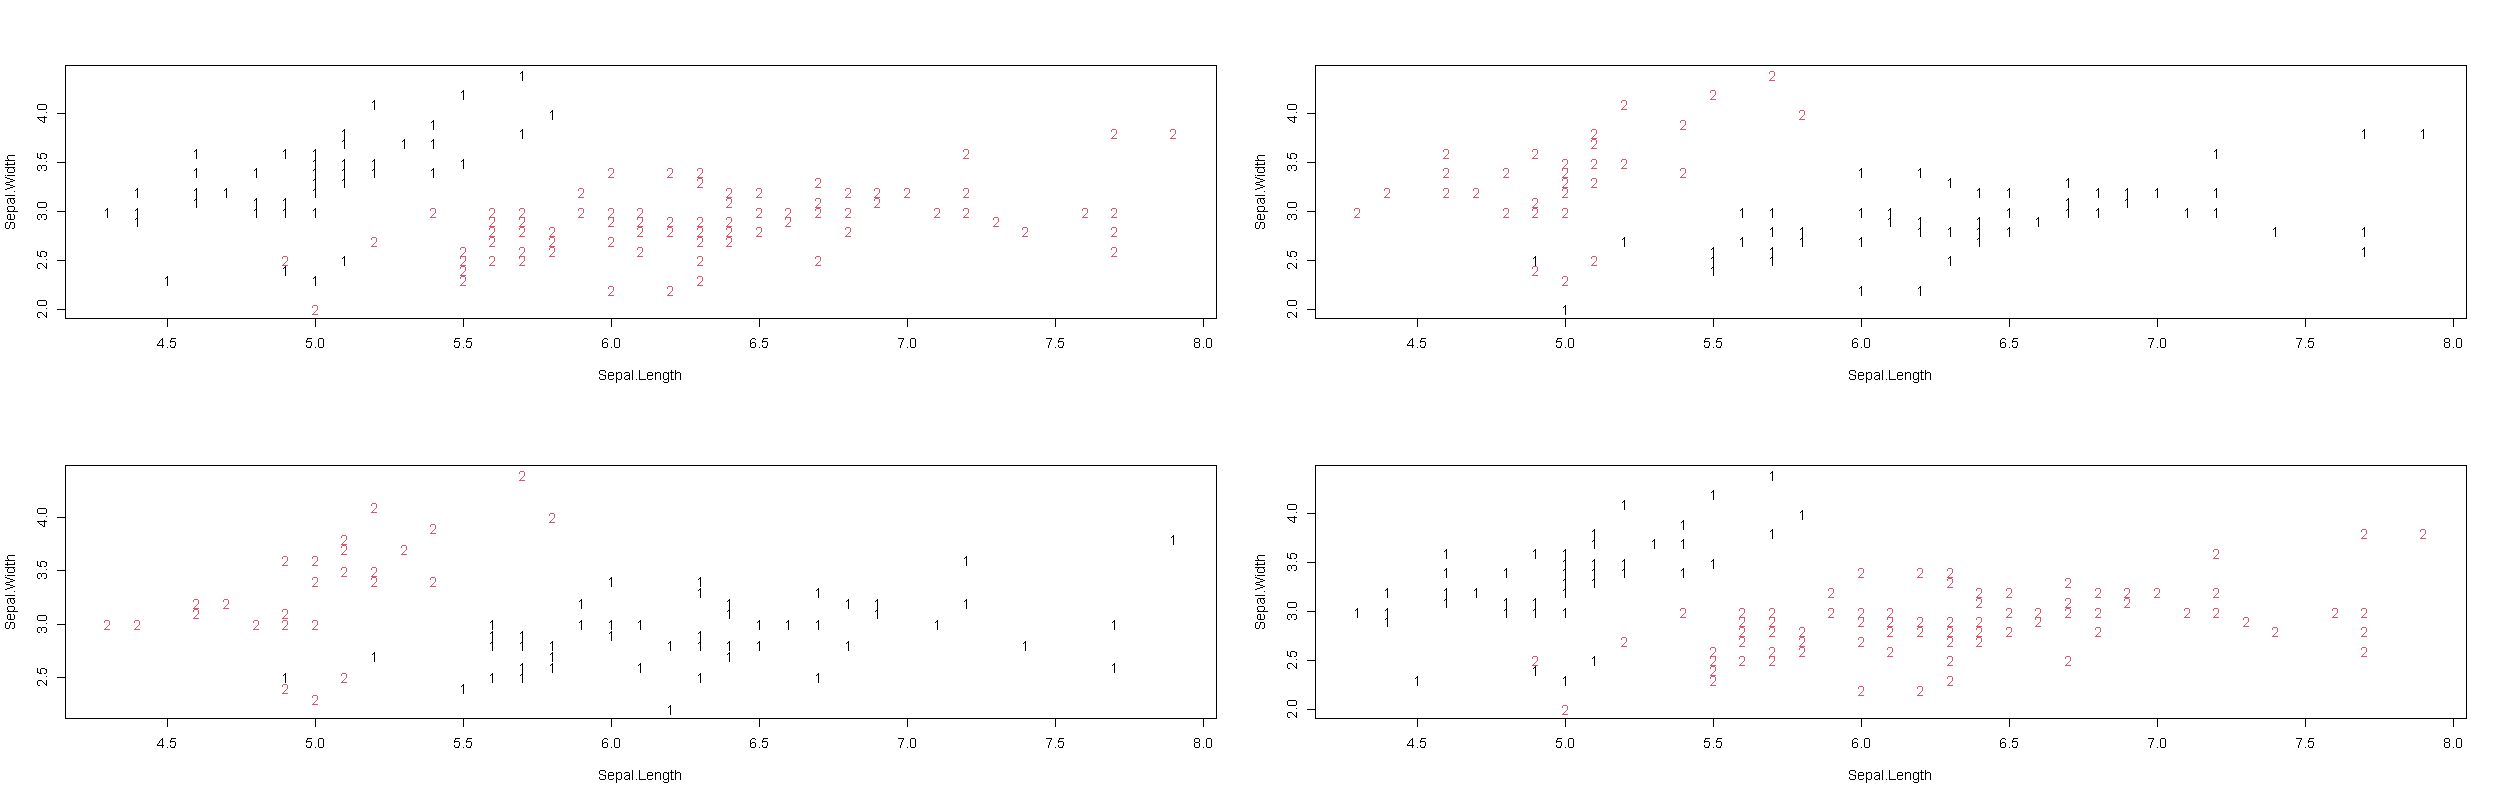

* Cluster stability assessment *
Cluster method:  kmeans 
Full clustering results are given as parameter result
of the clusterboot object, which also provides further statistics
of the resampling results.
Number of resampling runs:  2 

Number of clusters found in data:  3 

 Clusterwise Jaccard bootstrap (omitting multiple points) mean:
[1] 0.7079918 0.6321839 0.8088235
dissolved:
[1] 0 1 0
recovered:
[1] 1 1 1
boot 1 
boot 2 


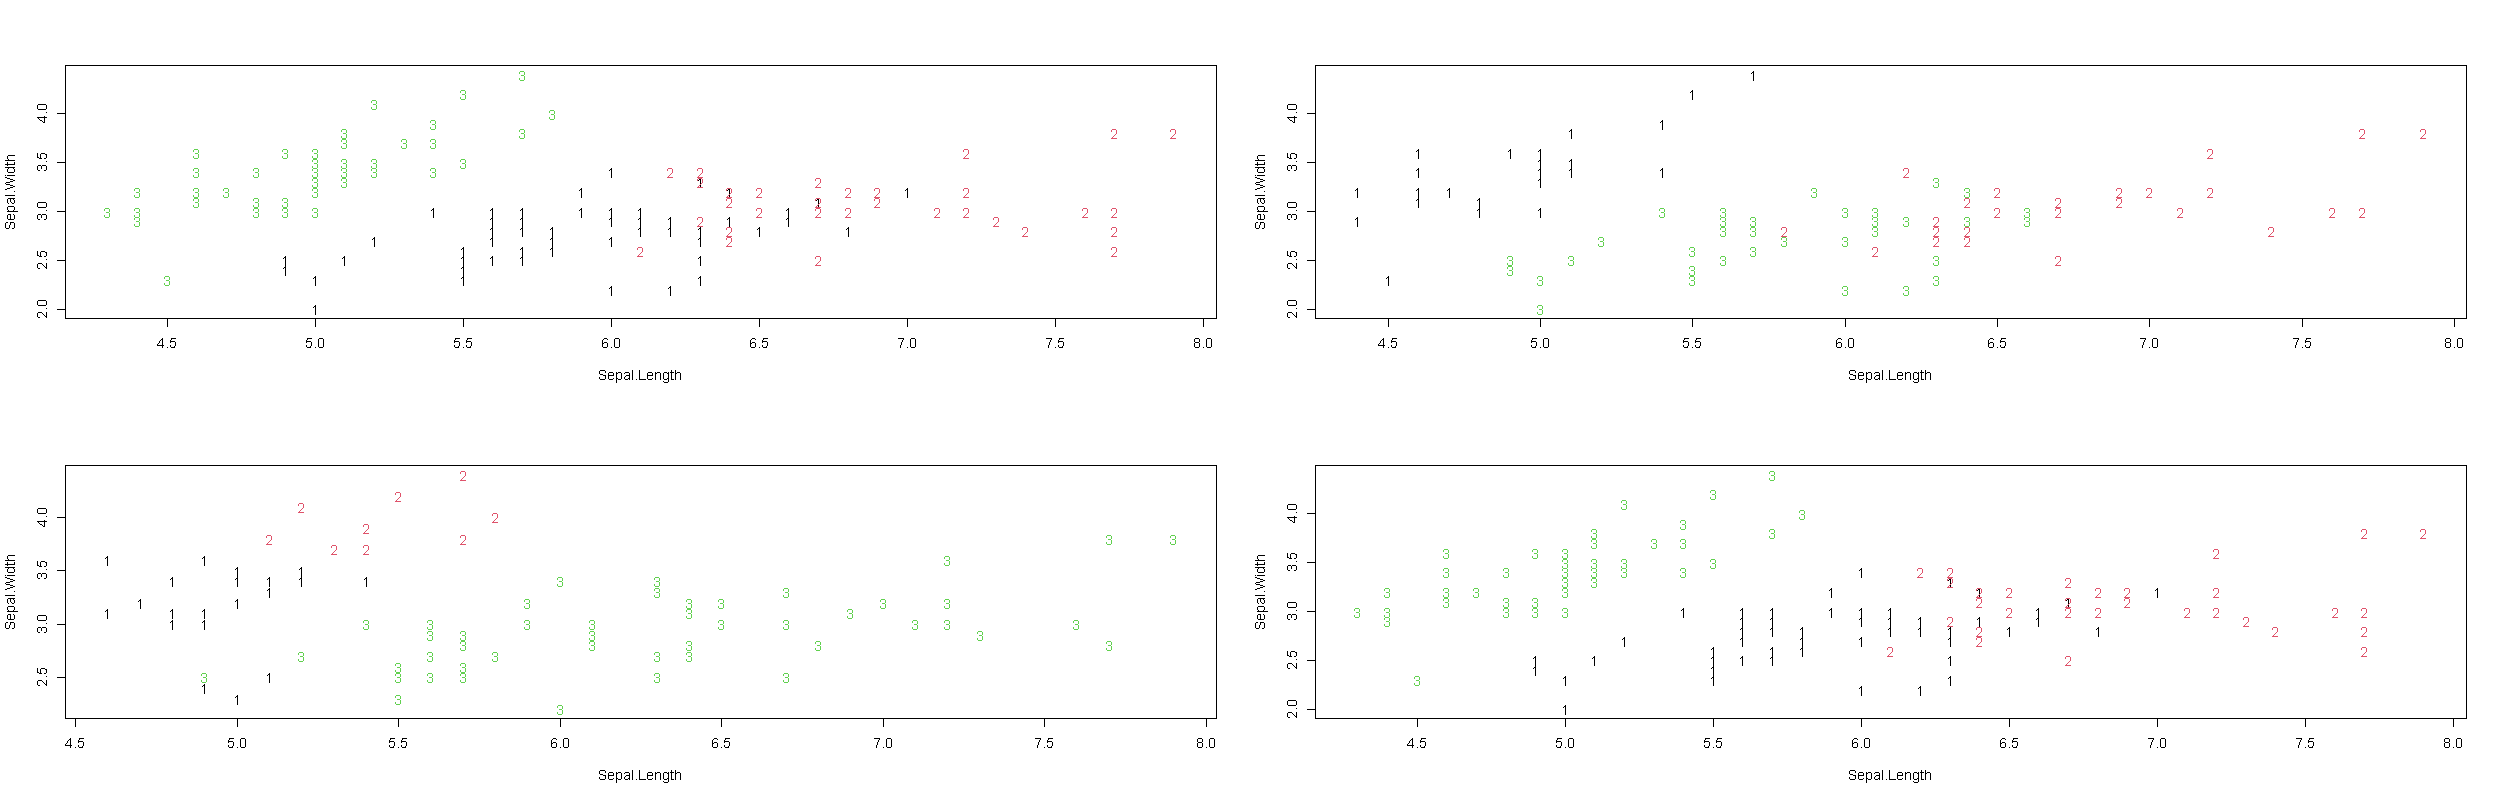

* Cluster stability assessment *
Cluster method:  kmeans 
Full clustering results are given as parameter result
of the clusterboot object, which also provides further statistics
of the resampling results.
Number of resampling runs:  2 

Number of clusters found in data:  4 

 Clusterwise Jaccard bootstrap (omitting multiple points) mean:
[1] 0.7105263 0.7220513 0.9182609 0.7500000
dissolved:
[1] 1 0 0 1
recovered:
[1] 1 1 2 1


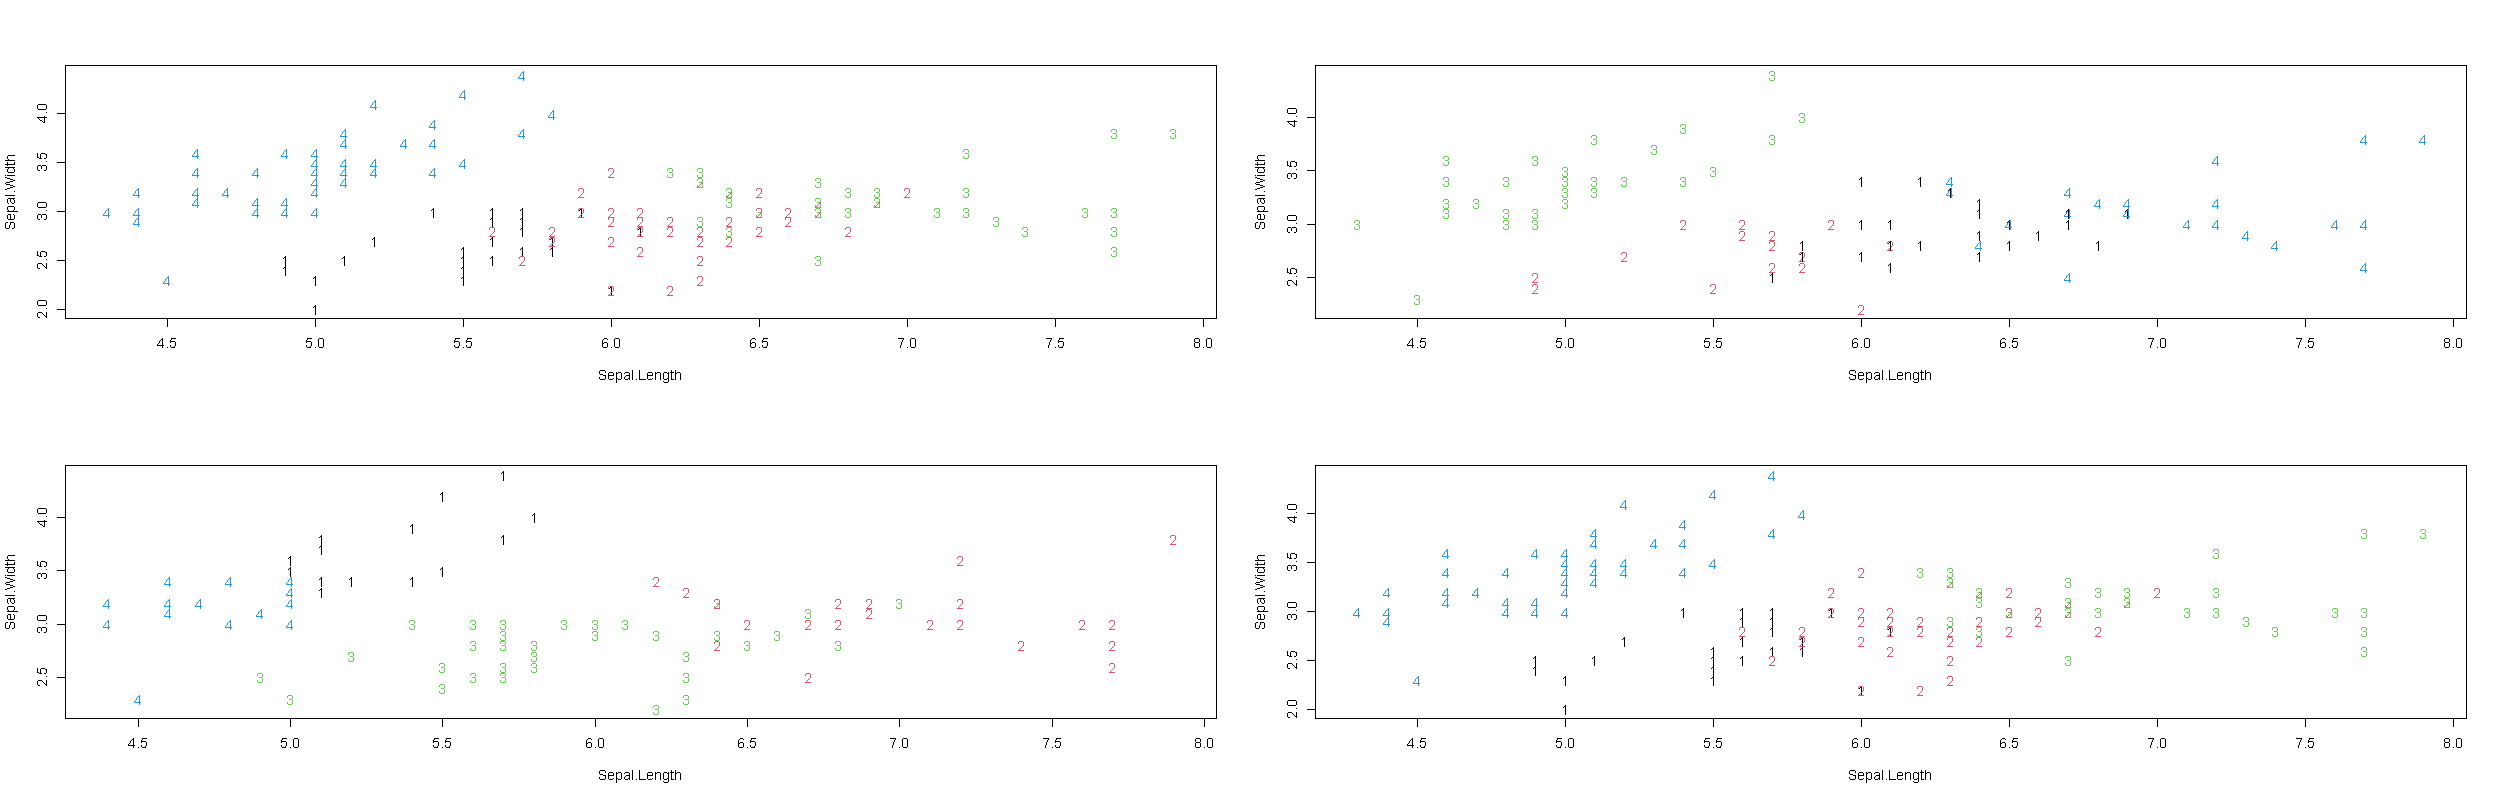

In [395]:
# Stability of clustering results - using bootstrap to assess
par(mfrow=c(2,2))
pp<-clusterboot(iris[,-5],B=2,showplots=T,clustermethod=kmeansCBI,krange=2,multipleboot = F)
print(pp)
pp<-clusterboot(iris[,-5],B=2,showplots=T,clustermethod=kmeansCBI,krange=3,multipleboot = F)
print(pp)
pp<-clusterboot(iris[,-5],B=2,showplots=T,clustermethod=kmeansCBI,krange=4,multipleboot = F)
print(pp)

For the iris data, bootstrap results are not stable beyond 2 clusters. Try this on the iris data where you created greater separation between the clusters.

Let's run this on more bootstrap examples. 

In [396]:
pp<-clusterboot(irisnew[,-5],B=100,showplots=F,clustermethod=kmeansCBI,krange=2,multipleboot = F,count=F)
print(pp)
pp<-clusterboot(irisnew[,-5],B=100,showplots=F,clustermethod=kmeansCBI,krange=3,multipleboot = F,count=F)
print(pp)
pp<-clusterboot(irisnew[,-5],B=100,showplots=F,clustermethod=kmeansCBI,krange=4,multipleboot = F,count=F)
print(pp)

* Cluster stability assessment *
Cluster method:  kmeans 
Full clustering results are given as parameter result
of the clusterboot object, which also provides further statistics
of the resampling results.
Number of resampling runs:  100 

Number of clusters found in data:  2 

 Clusterwise Jaccard bootstrap (omitting multiple points) mean:
[1] 0.9281762 0.9487251
dissolved:
[1] 0 0
recovered:
[1] 89 93
* Cluster stability assessment *
Cluster method:  kmeans 
Full clustering results are given as parameter result
of the clusterboot object, which also provides further statistics
of the resampling results.
Number of resampling runs:  100 

Number of clusters found in data:  3 

 Clusterwise Jaccard bootstrap (omitting multiple points) mean:
[1] 0.8413776 0.9569279 0.8745829
dissolved:
[1] 12  1  1
recovered:
[1] 66 98 71
* Cluster stability assessment *
Cluster method:  kmeans 
Full clustering results are given as parameter result
of the clusterboot object, which also provides further sta

Looks pretty stable for 2 to 3 clusters with kmeans, and often with 4. Again, result will vary a bit from run to run. 

What about hierarchical clustering?

In [397]:
pp<-clusterboot(irisnew[,-5],B=100,showplots=F,clustermethod=hclustCBI,k=2,method="complete",multipleboot = F,count=F)
print(pp)
pp<-clusterboot(irisnew[,-5],B=100,showplots=F,clustermethod=hclustCBI,k=3,method="complete",multipleboot = F,count=F)
print(pp)
pp<-clusterboot(irisnew[,-5],B=100,showplots=F,clustermethod=hclustCBI,k=4,method="complete",multipleboot = F,count=F)
print(pp)

* Cluster stability assessment *
Cluster method:  hclust/cutree 
Full clustering results are given as parameter result
of the clusterboot object, which also provides further statistics
of the resampling results.
Number of resampling runs:  100 

Number of clusters found in data:  2 

 Clusterwise Jaccard bootstrap (omitting multiple points) mean:
[1] 0.9942088 0.9872410
dissolved:
[1] 0 1
recovered:
[1] 100  99
* Cluster stability assessment *
Cluster method:  hclust/cutree 
Full clustering results are given as parameter result
of the clusterboot object, which also provides further statistics
of the resampling results.
Number of resampling runs:  100 

Number of clusters found in data:  3 

 Clusterwise Jaccard bootstrap (omitting multiple points) mean:
[1] 0.9282199 0.9514647 0.9071748
dissolved:
[1]  4  3 13
recovered:
[1] 86 89 84
* Cluster stability assessment *
Cluster method:  hclust/cutree 
Full clustering results are given as parameter result
of the clusterboot object, which al

The clusters are fairly stable up to 4 clusters with hierarchical clustering with complete linkage. Remember though that the clusters look different depending on the method used. Stable clusters but with limited overlap to the kmeans clusters. Choice of method matters.

## Consensus Clustering

Let's explore the cancer data I posted on canvas. There are 6 different cancer samples, 2887 in total, each sample measured  over 20000+ genes.

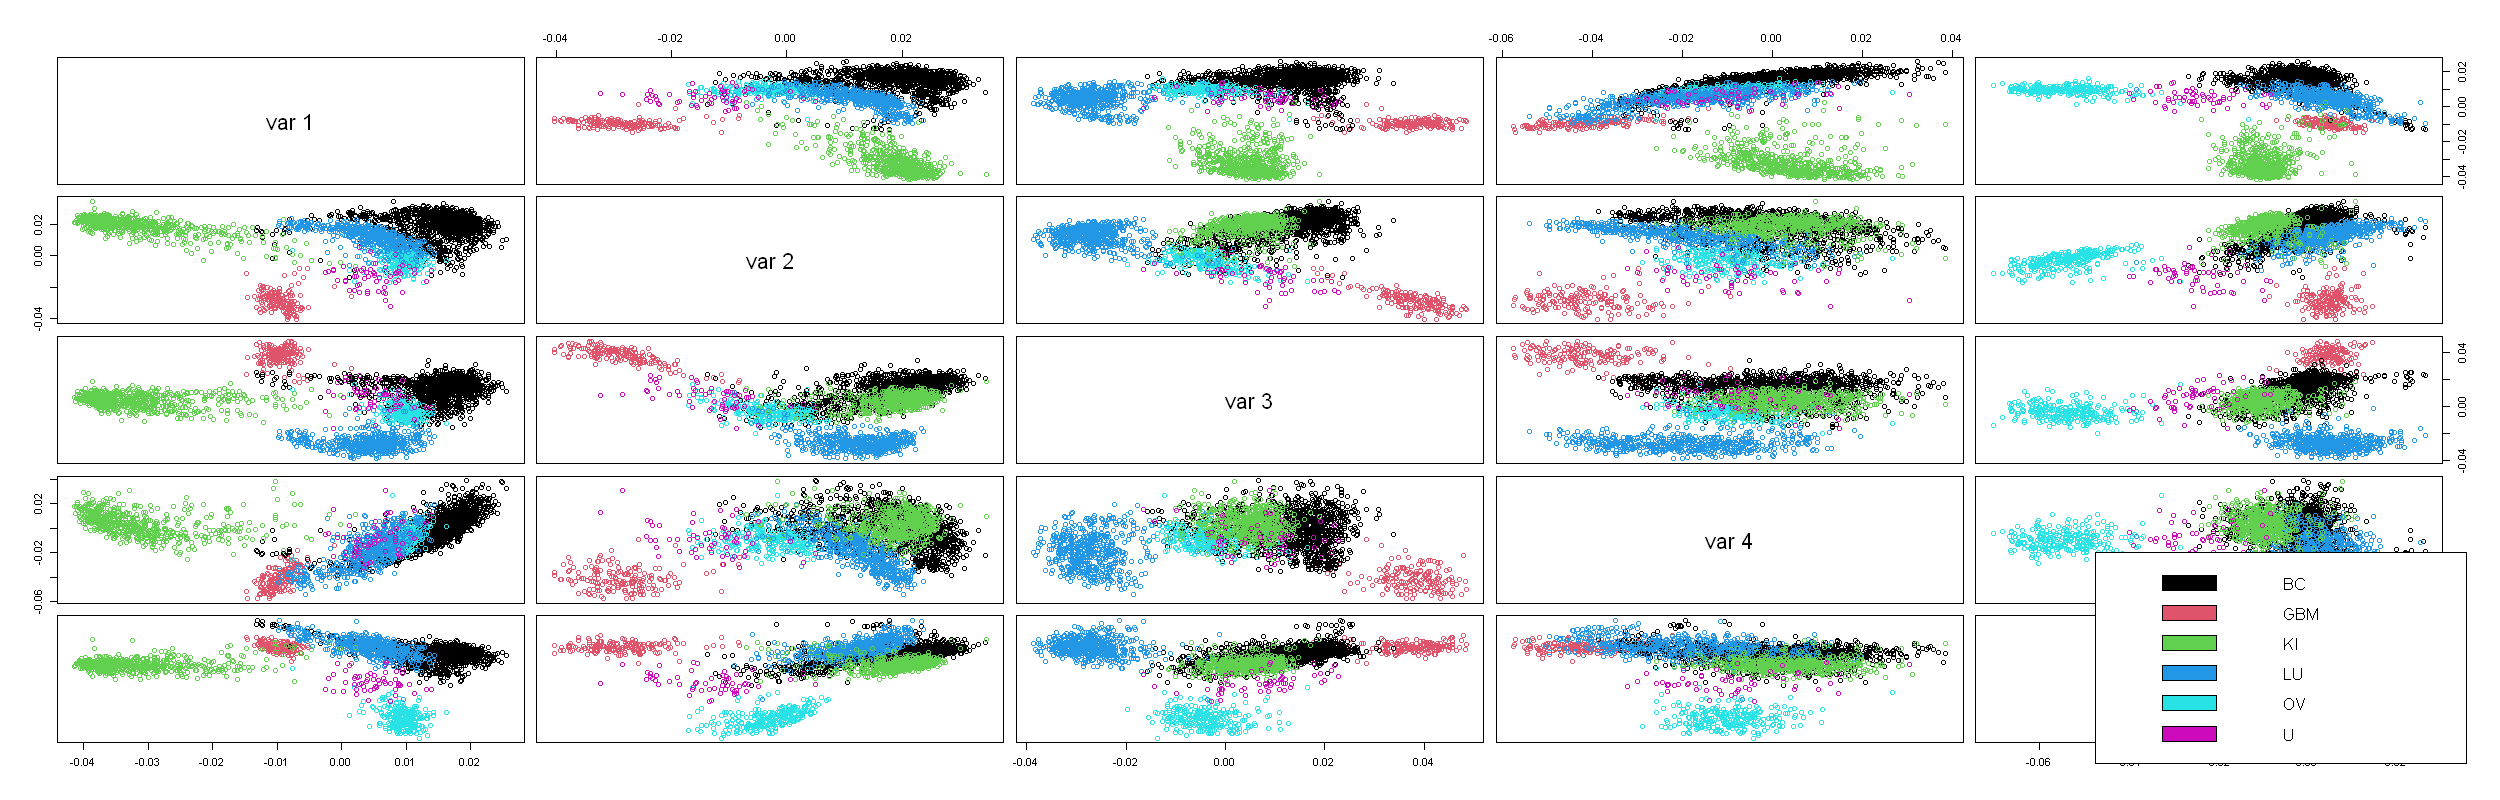

In [398]:
#install.packages("irlba")
#install.packages("plot3D")
#install.packages("rgl")
#library(irlba)
# fast svd for large data sets
library(plot3D)
library(rgl)
#### Let's look at a very large genome cancer data set
#### 6 cancer classes: breast, glioblastoma (brain), lung, ovarian, kidney and uterus
#### 20000+ genes are the feaures
load("TCGAdata.RData")
ss<-irlba(TCGA,10,10) # keep the leading 10 eigenvectors
pairs(ss$u[,1:5],col=as.numeric(as.factor(TCGAclassstr)))
par(xpd = TRUE)
legend("bottomright", fill = unique(as.factor(TCGAclassstr))[sort.list(as.numeric(as.factor(unique(TCGAclassstr))))], legend = c(levels(as.factor(TCGAclassstr))))
#plot3d(ss$u[,1:3],col=as.numeric(as.factor(TCGAclassstr)))
#legend3d("topright", legend = paste('Type', c(unique(TCGAclassstr))[sort.list(as.numeric(as.factor(unique(TCGAclassstr))))]), pch = 5, col=seq(1,6), cex=1, inset=c(0.02))
# 3D plot if you prefer.

You can see the cancer classes fairly well separated in the first leading eigencomponents. However, there is quite some imbalance between the classes here with many more breast cancer samples and very few uterine cases. Also, the uterine seems to be positioned between the other classes. 

In [405]:
kk<-kmeans(ss$u[,1:10],6)
#
#install.packages("mda")
library(mda)
mda::confusion(kk$cluster,TCGAclassstr)

         true
predicted  BC GBM  KI  LU  OV   U
        1   0   0   0   0 262   0
        2   0   0  84 525   0   1
        3 942   0   6   0   0   0
        4   0 169   0   0   0   0
        5   0   0 509   0   0   0
        6 273   3   7  46   4  56

Kmeans on the 10 leading components splits the breast cancer data set into 2-3 clusters while combining some of the other cancers. As expected, we don't retrieve all 6 classes when we clusters. (Run multiple times).

Does it work if we use partion around medoids?

         true
predicted  BC GBM  KI  LU  OV   U
        1   0 169   0   0   0   0
        2 223   3   5  23   3  50
        3 992   0  10   0   0   5
        4   0   0   0   0 263   1
        5   0   0   7 548   0   1
        6   0   0 584   0   0   0

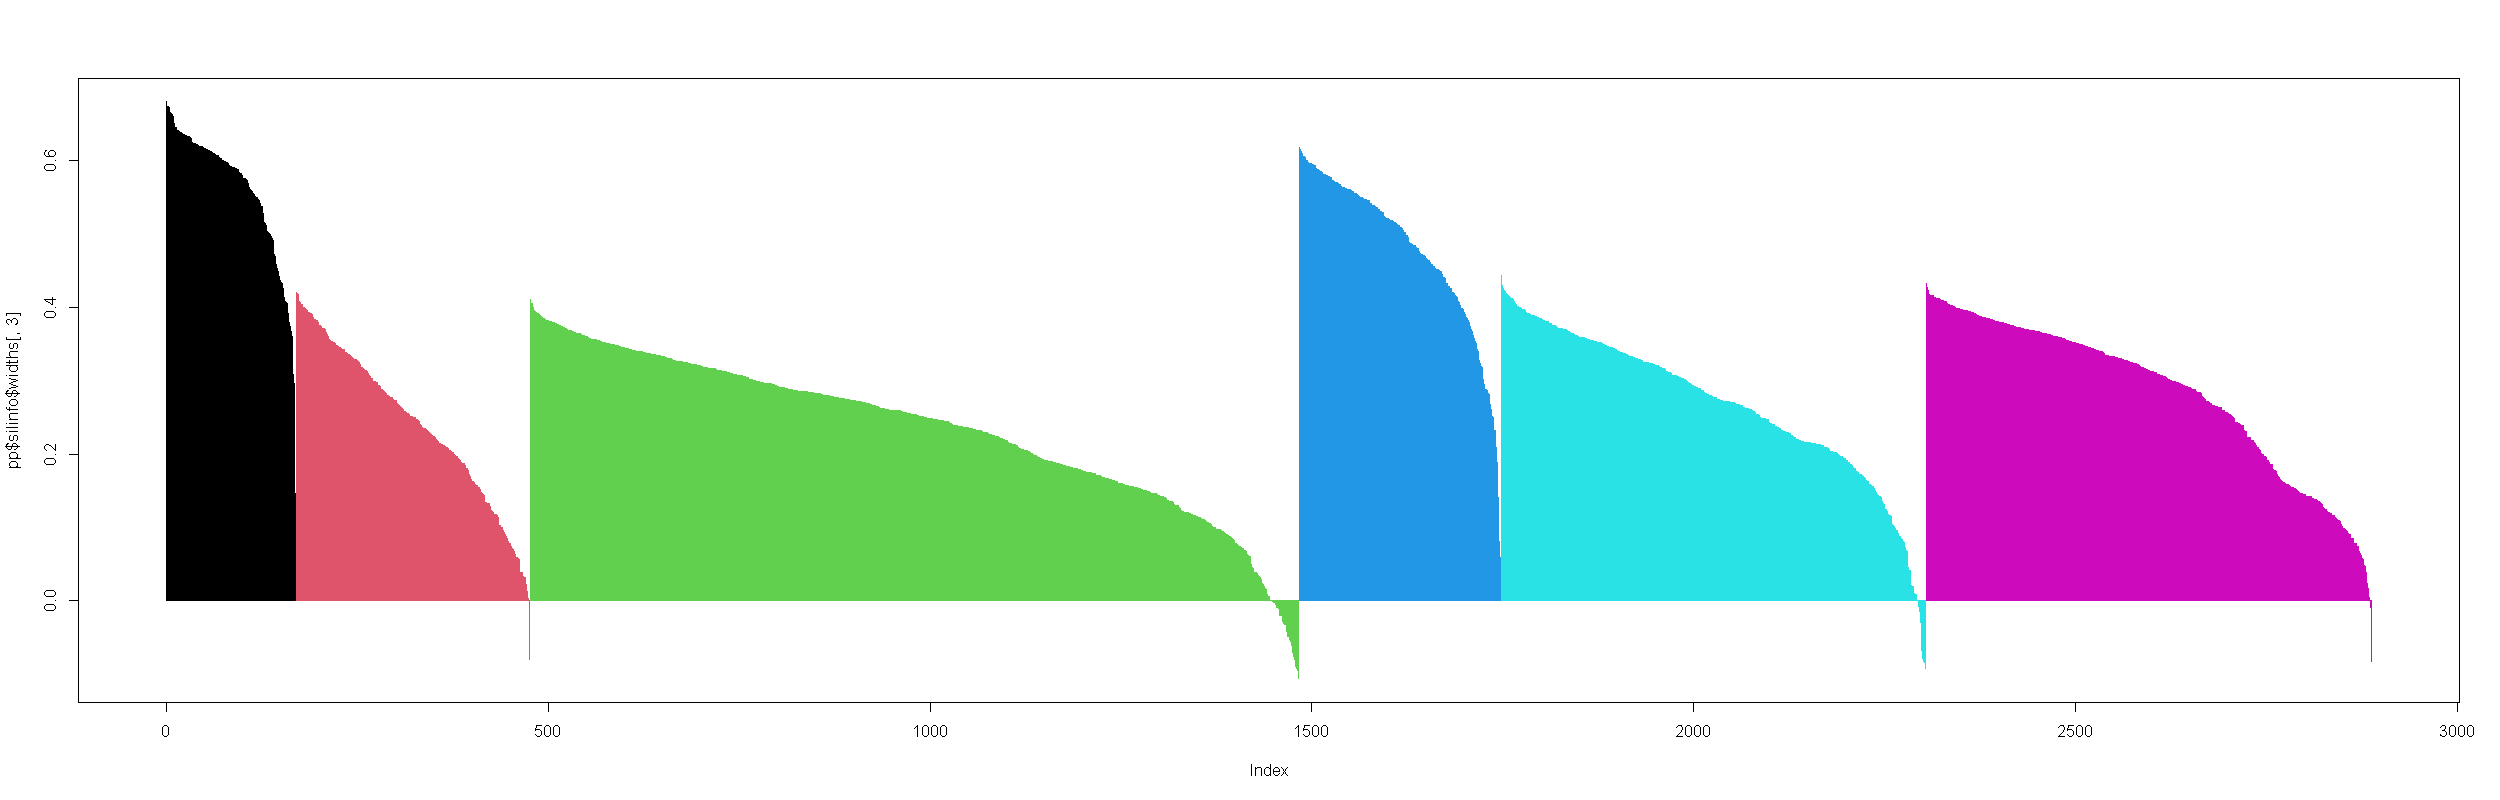

In [410]:
library(cluster)
pp<-pam(ss$u,6)
plot(pp$silinfo$widths[,3],col=pp$silinfo$widths[,1],type="h")
mda::confusion(pp$clustering,TCGAclassstr)

While the clusters look good in the silhouette width plot, the confusion matrix shows that they don't always overlap with the cancer classes - breast cancer is split into two groups. PAM was, however, better at separating glioblastoma and kidney cancer. (Run multiple times).

Let's try a hacky version of consensus clustering from scratch.

In [411]:
#### consensus clustering - using a random subset of genes to cluster
#### 
DD<-matrix(0,2887,2887)
nz<-50
for (zz in (1:nz)) {
  ss<-irlba(TCGA[,sample(seq(1,20530),2500)],10,10) # pca on a random subset of genes
  kk<-kmeans(ss$u[,1:10],6) # clustering on the leading pca components
  dd<-as.matrix(dist(kk$cluster)) 
  dd[dd!=0]<-1 # who is NOT in the same cluster = 1
  DD<-DD+(1-dd) # same +1 for those who ARE in the same cluster
  cat(zz)} 
##  

1234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950

I resample 50 times. You can try fewer or more and see what happens. I now have a consensus matrix, DD, that tabulates how pairs of observations co-cluster across the different runs. I use this as new distance metric into hierarchical clustering.

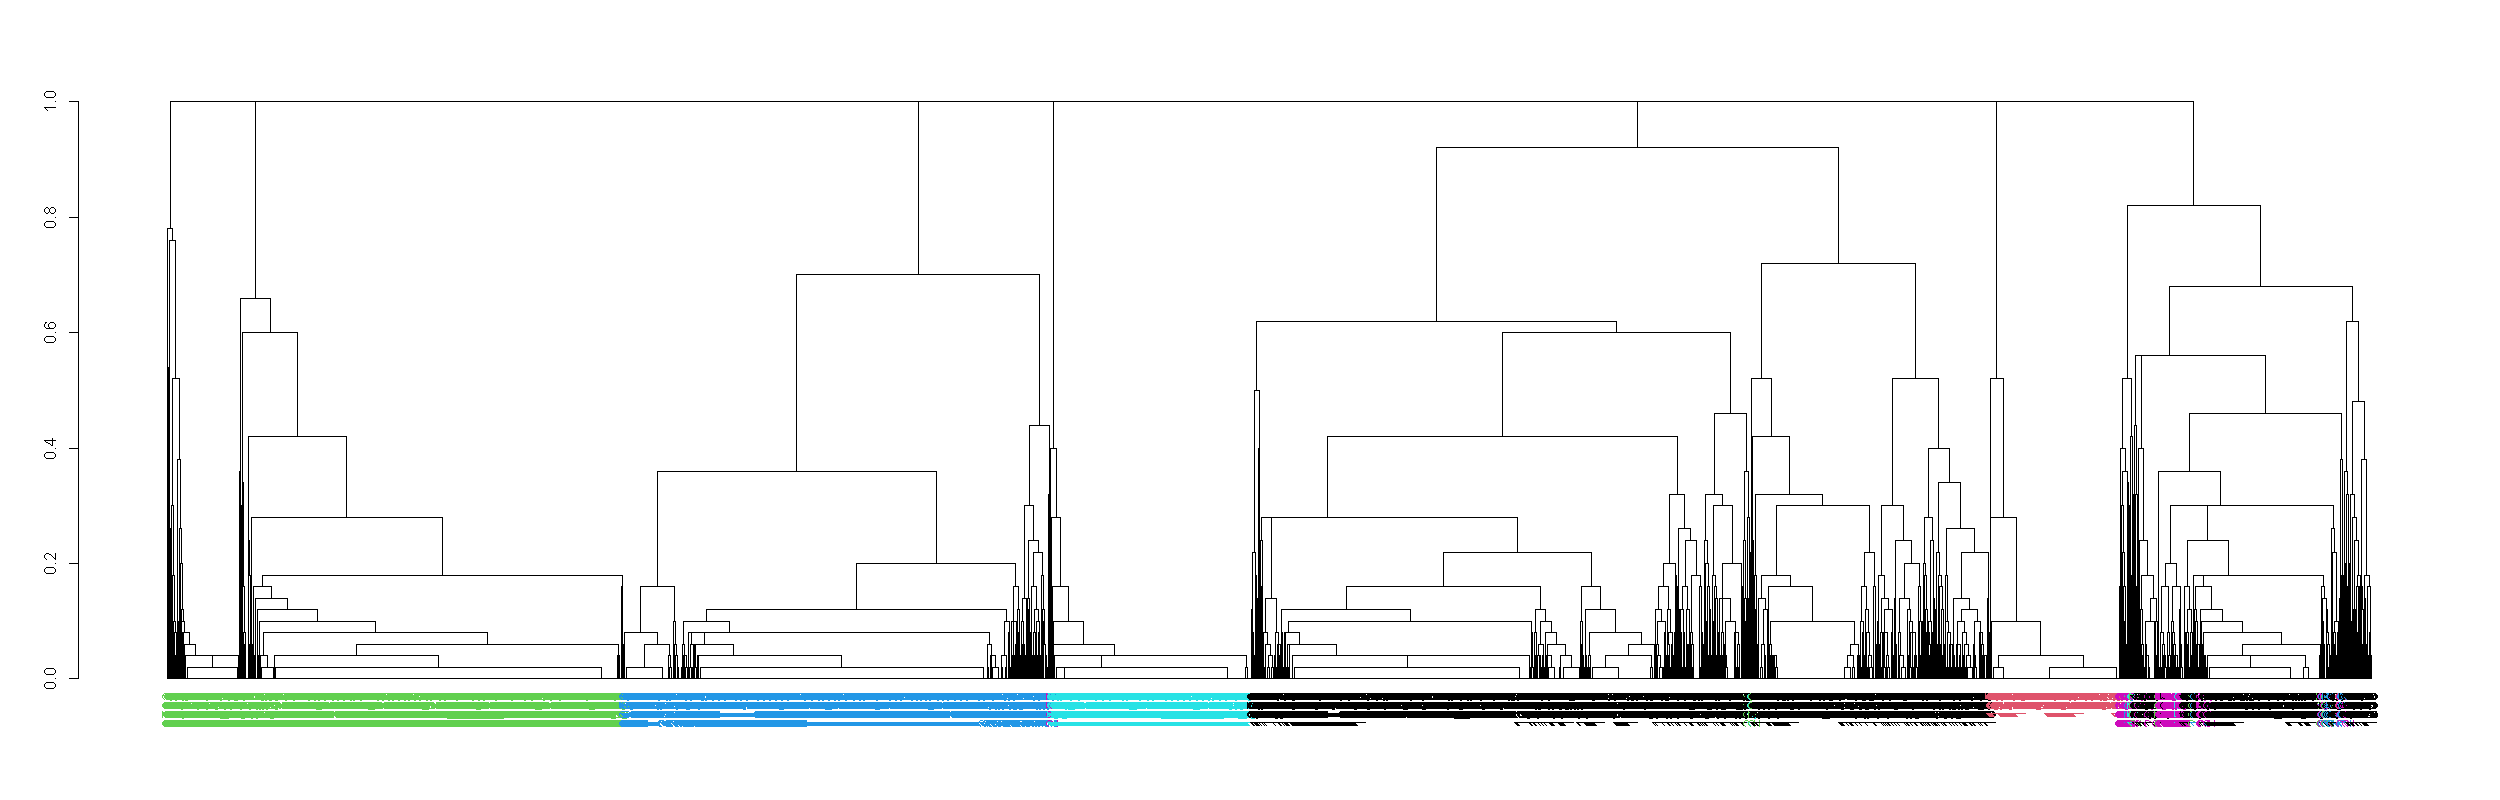

In [412]:
hc<-hclust(as.dist(1-DD/50)) # Use the co-clustering results as a
# new distance metric in e.g. hierarchical clustering.
# plot(hc,labels=TCGAclassstr)
# nicer dendrogram
library(dendextend)
dend<-as.dendrogram(hc)
cols<-as.numeric(as.factor(TCGAclassstr))
labels_colors(dend)<-cols[order.dendrogram(dend)]
plot(dend)

From the dendrogram you can see that there are some samples that form tighter clusters than others (stay together more frequently) and others are scattered between the clusters. You see clear, stable subclusters in the breast cancer (black) class. Try this with different clustering methods, different amount of random features or observation sets and see what happens.

         true
predicted  BC GBM  KI  LU  OV   U
        1 251 172   6  12   3  56
        2 964   0   2   0   1   0
        3   0   0   0   0 262   1
        4   0   0   0 559   0   0
        5   0   0 503   0   0   0
        6   0   0  95   0   0   0

         true
predicted  BC GBM  KI  LU  OV   U
        1   0 170   0   0   0   0
        2 251   2   6  12   3  56
        3 654   0   1   0   0   0
        4 310   0   1   0   1   0
        5   0   0   0   0 262   1
        6   0   0   0 559   0   0
        7   0   0 503   0   0   0
        8   0   0  95   0   0   0

         true
predicted  BC GBM  KI  LU  OV   U
        1   0 170   0   0   0   0
        2 251   2   6  12   3  56
        3 964   0   2   0   1   0
        4   0   0   0   0 262   1
        5   0   0   0 559   0   0
        6   0   0 503   0   0   0
        7   0   0  95   0   0   0

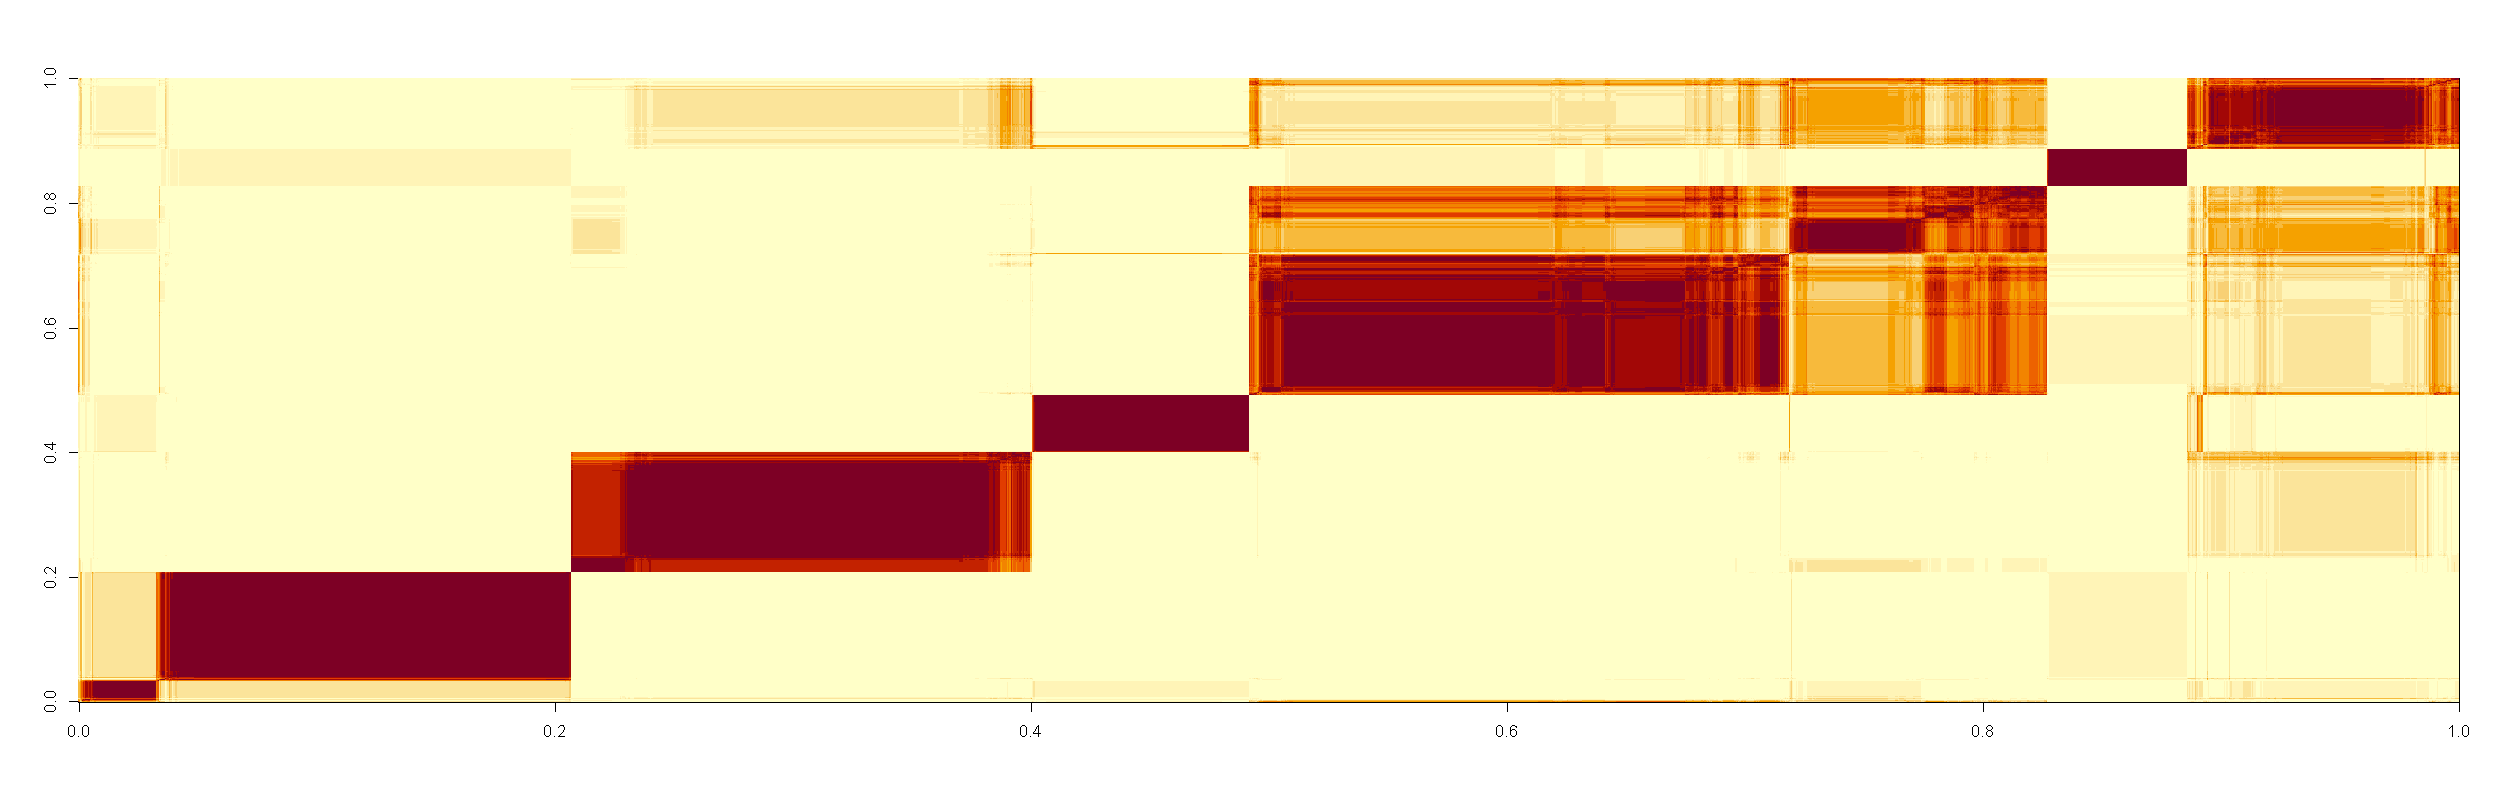

In [413]:
k<-cutree(hc,k=6)
mda::confusion(k,TCGAclassstr)
#
k<-cutree(hc,k=8)
mda::confusion(k,TCGAclassstr)
#
k<-cutree(hc,k=7)
mda::confusion(k,TCGAclassstr)
# how reproducible are the clusters?
#image(DD)
image(DD[hc$order,hc$order]) # 

We see as before that it's hard to all the classes and the clustering method favors the splitting of breast cancer into multiple clusters. Increasing to 7 clusters finds all the classes except the small uterine cancer, while splitting breast cancer into two subgroups. The consensus matrix depicts how stable the clusters are. You see that there are 4 fairly stable clusters of the consensus matrix that are well separated. The larger ones are clearly not as stable. This is the breast cancer class mixed with a few other samples and the uterine class.

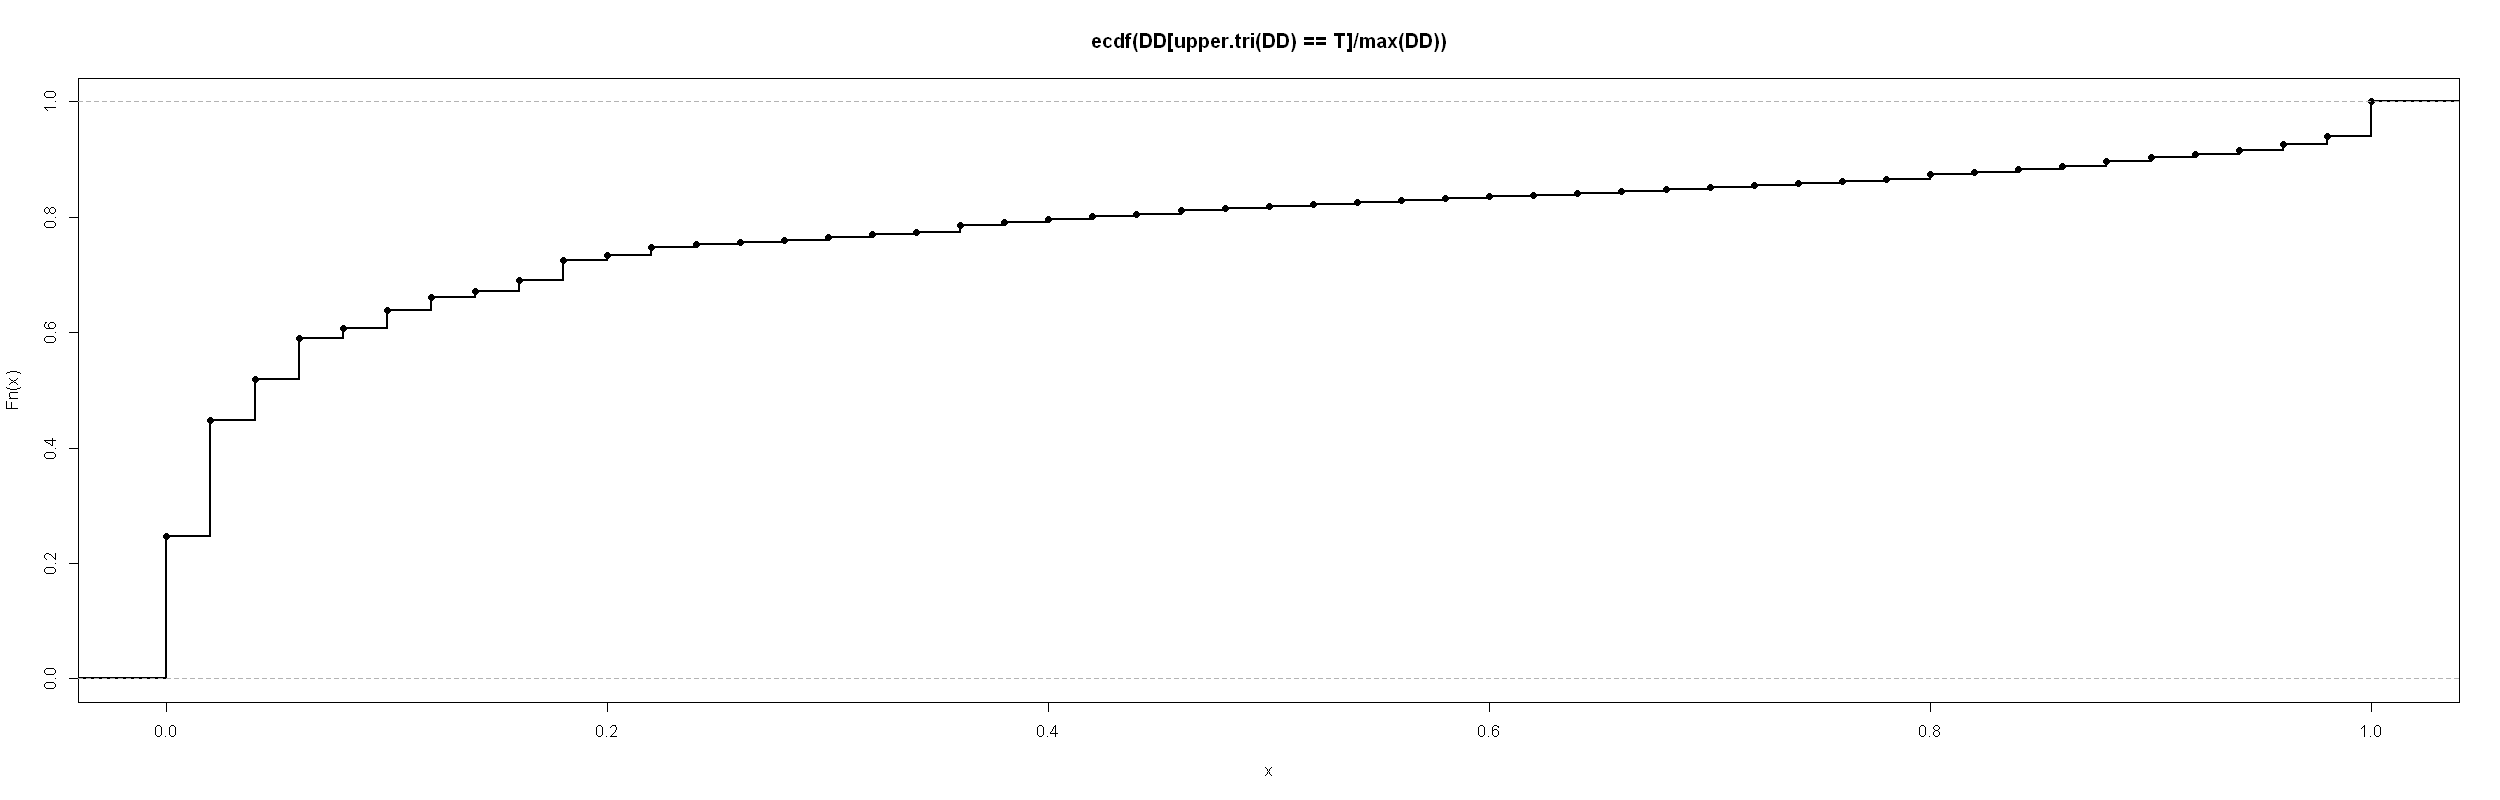

In [414]:
# CDF of the consensus matrix 
plot(ecdf(DD[upper.tri(DD)==T]/max(DD)),verticals=T,xlim=c(0,1),lwd=2)

In the CDF, we want to see a jump from near 0 values to 1, meaning that most of the probability mass is either 0 or 1, indicating stable clusters. 

What does a "perfect" clustering look like? 

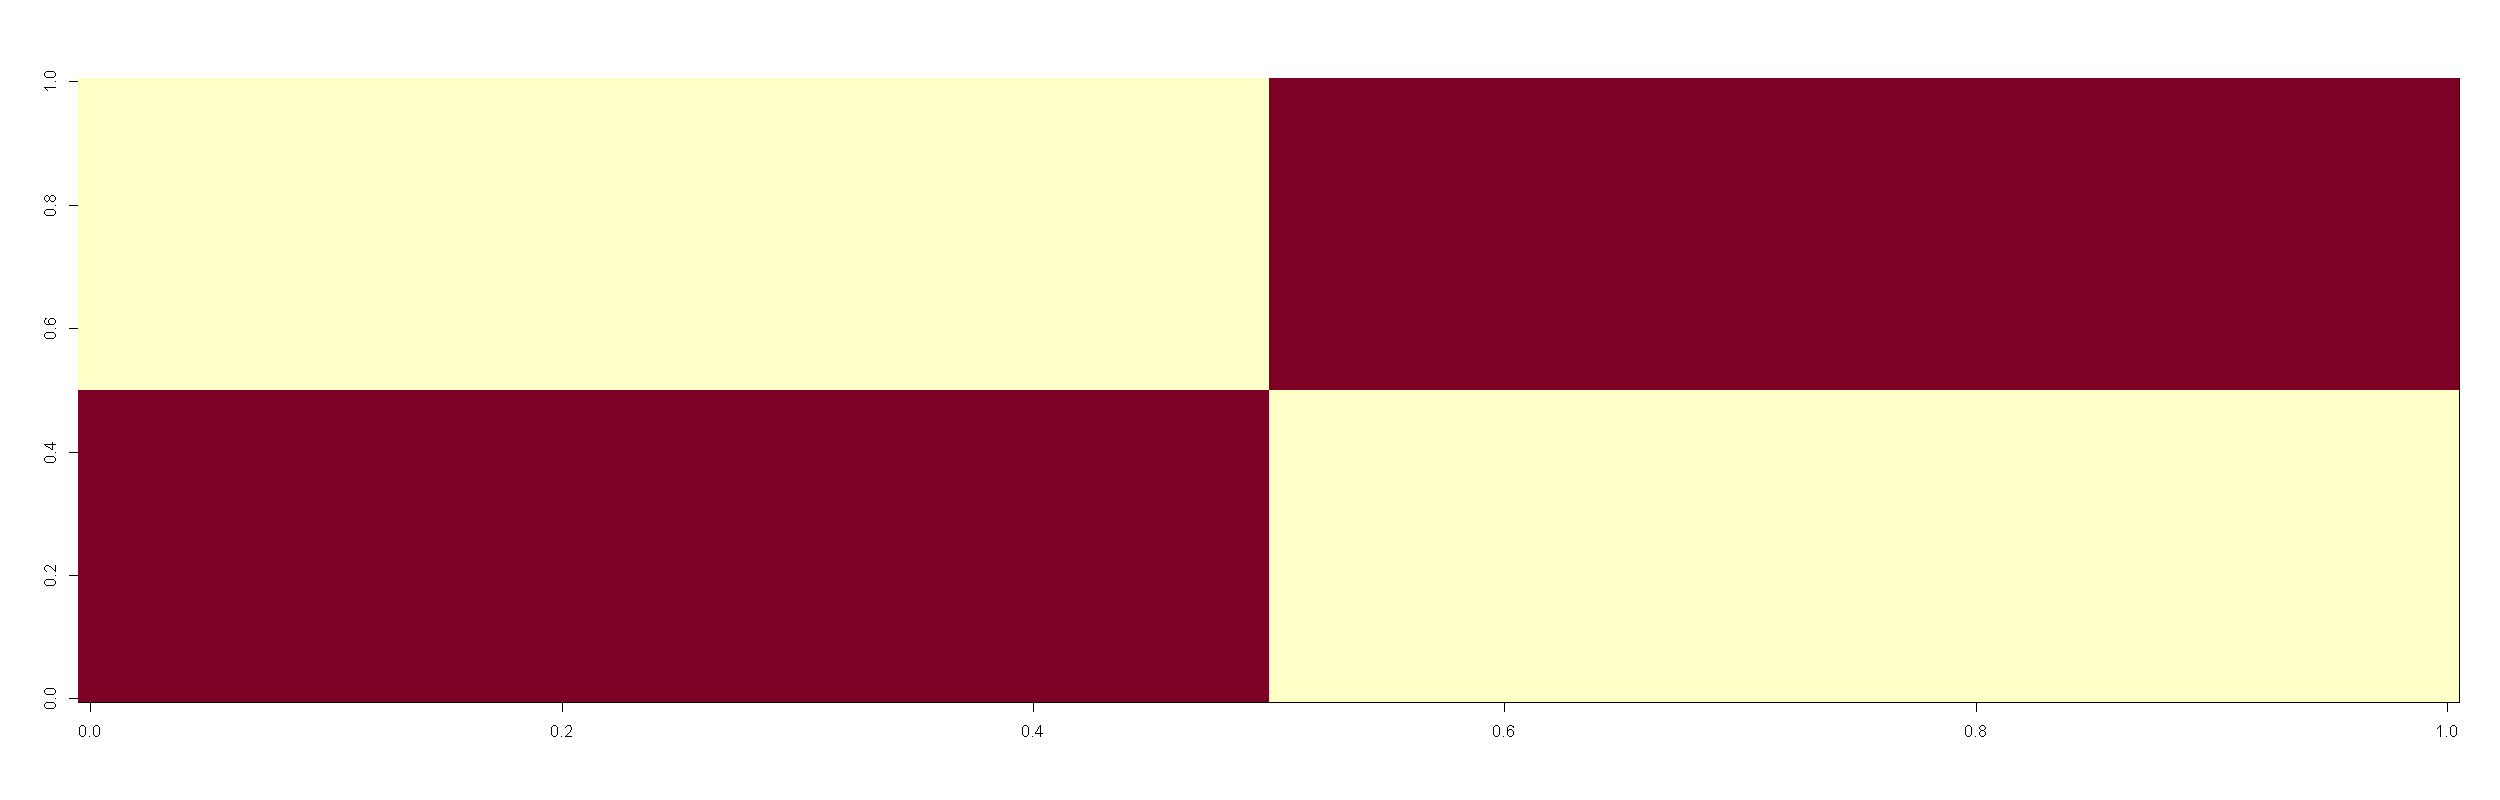

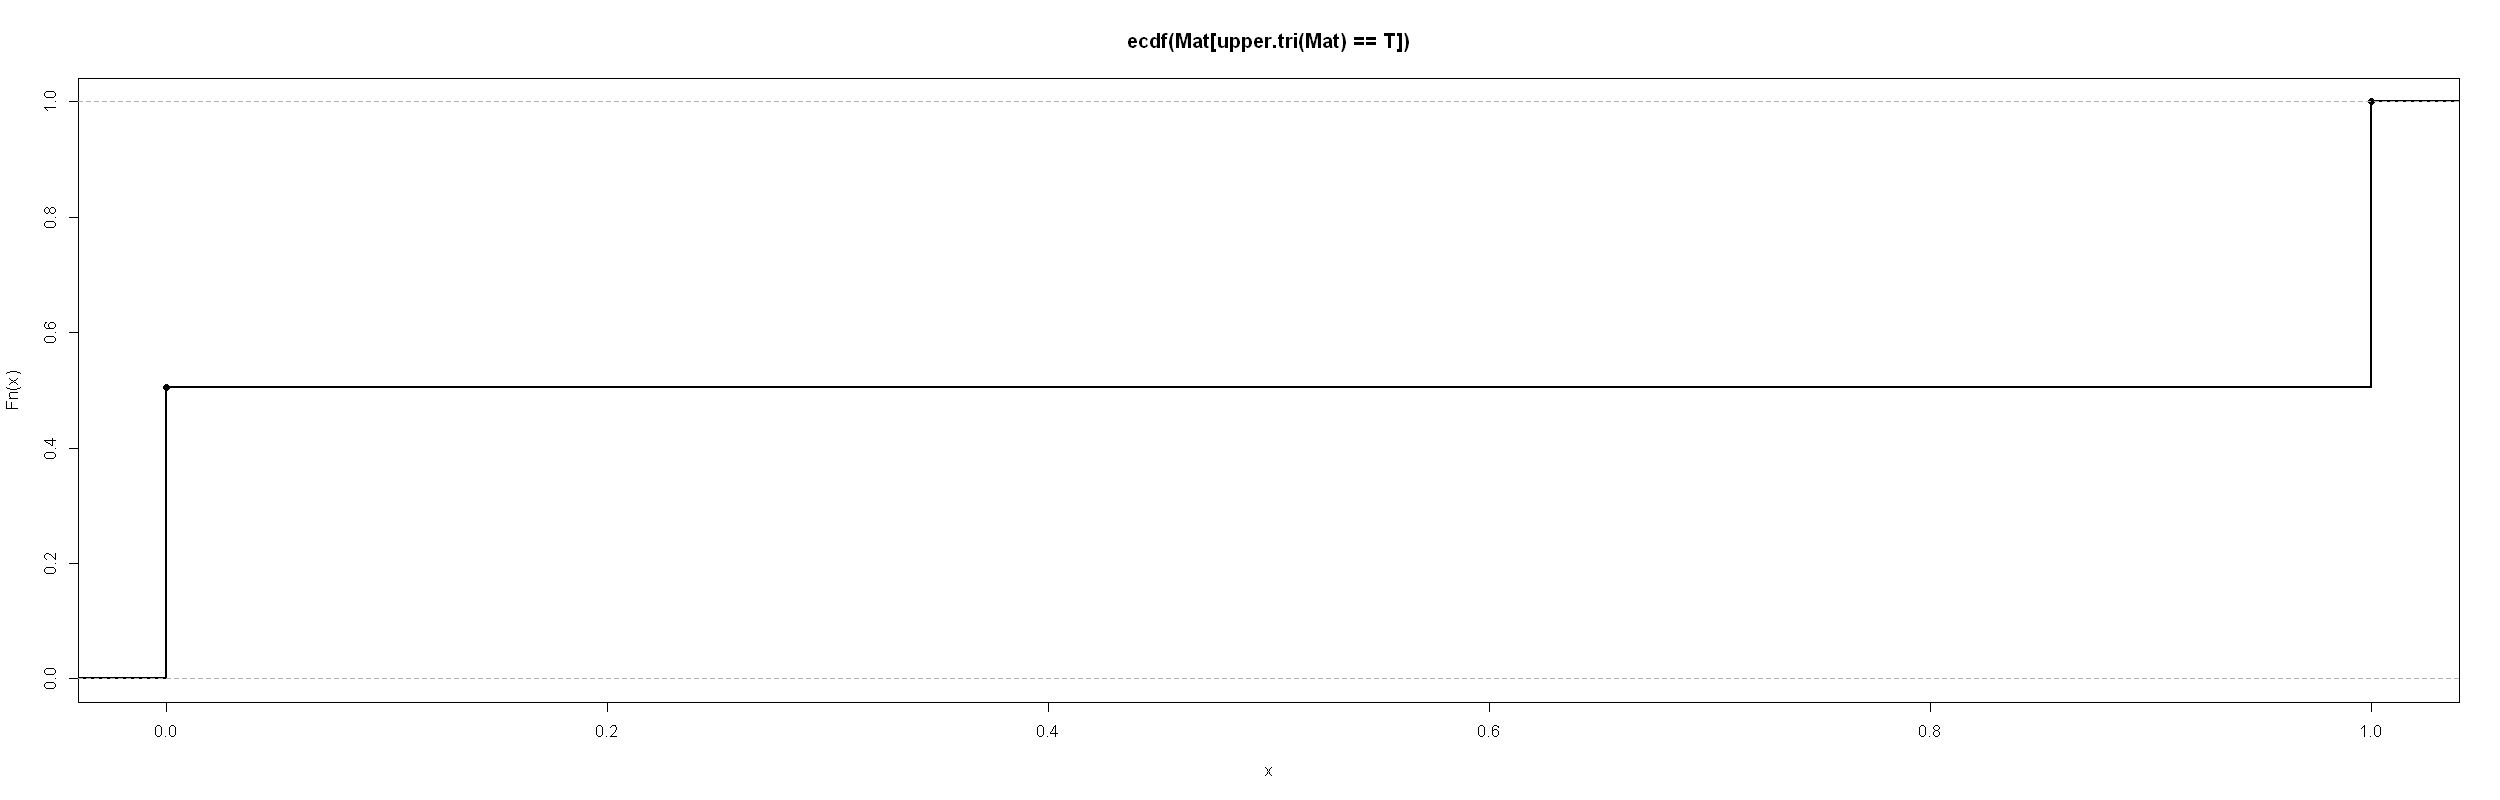

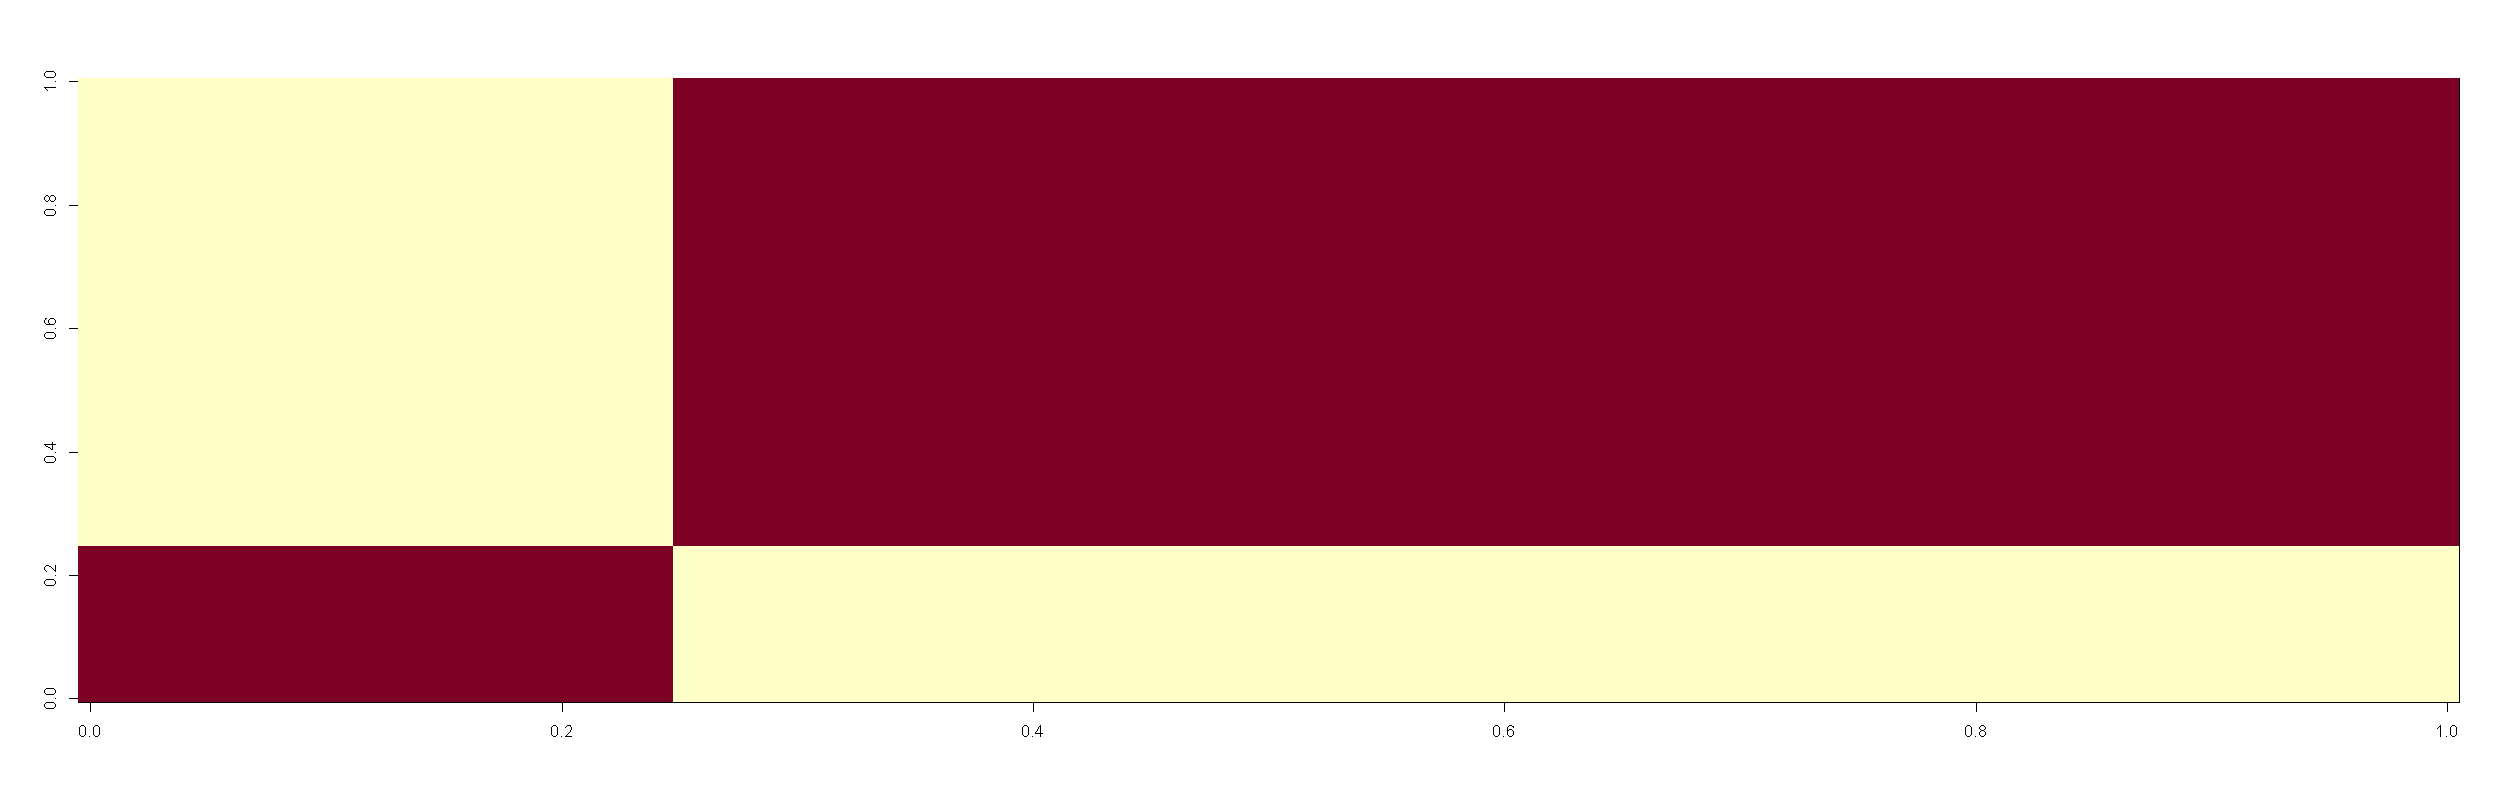

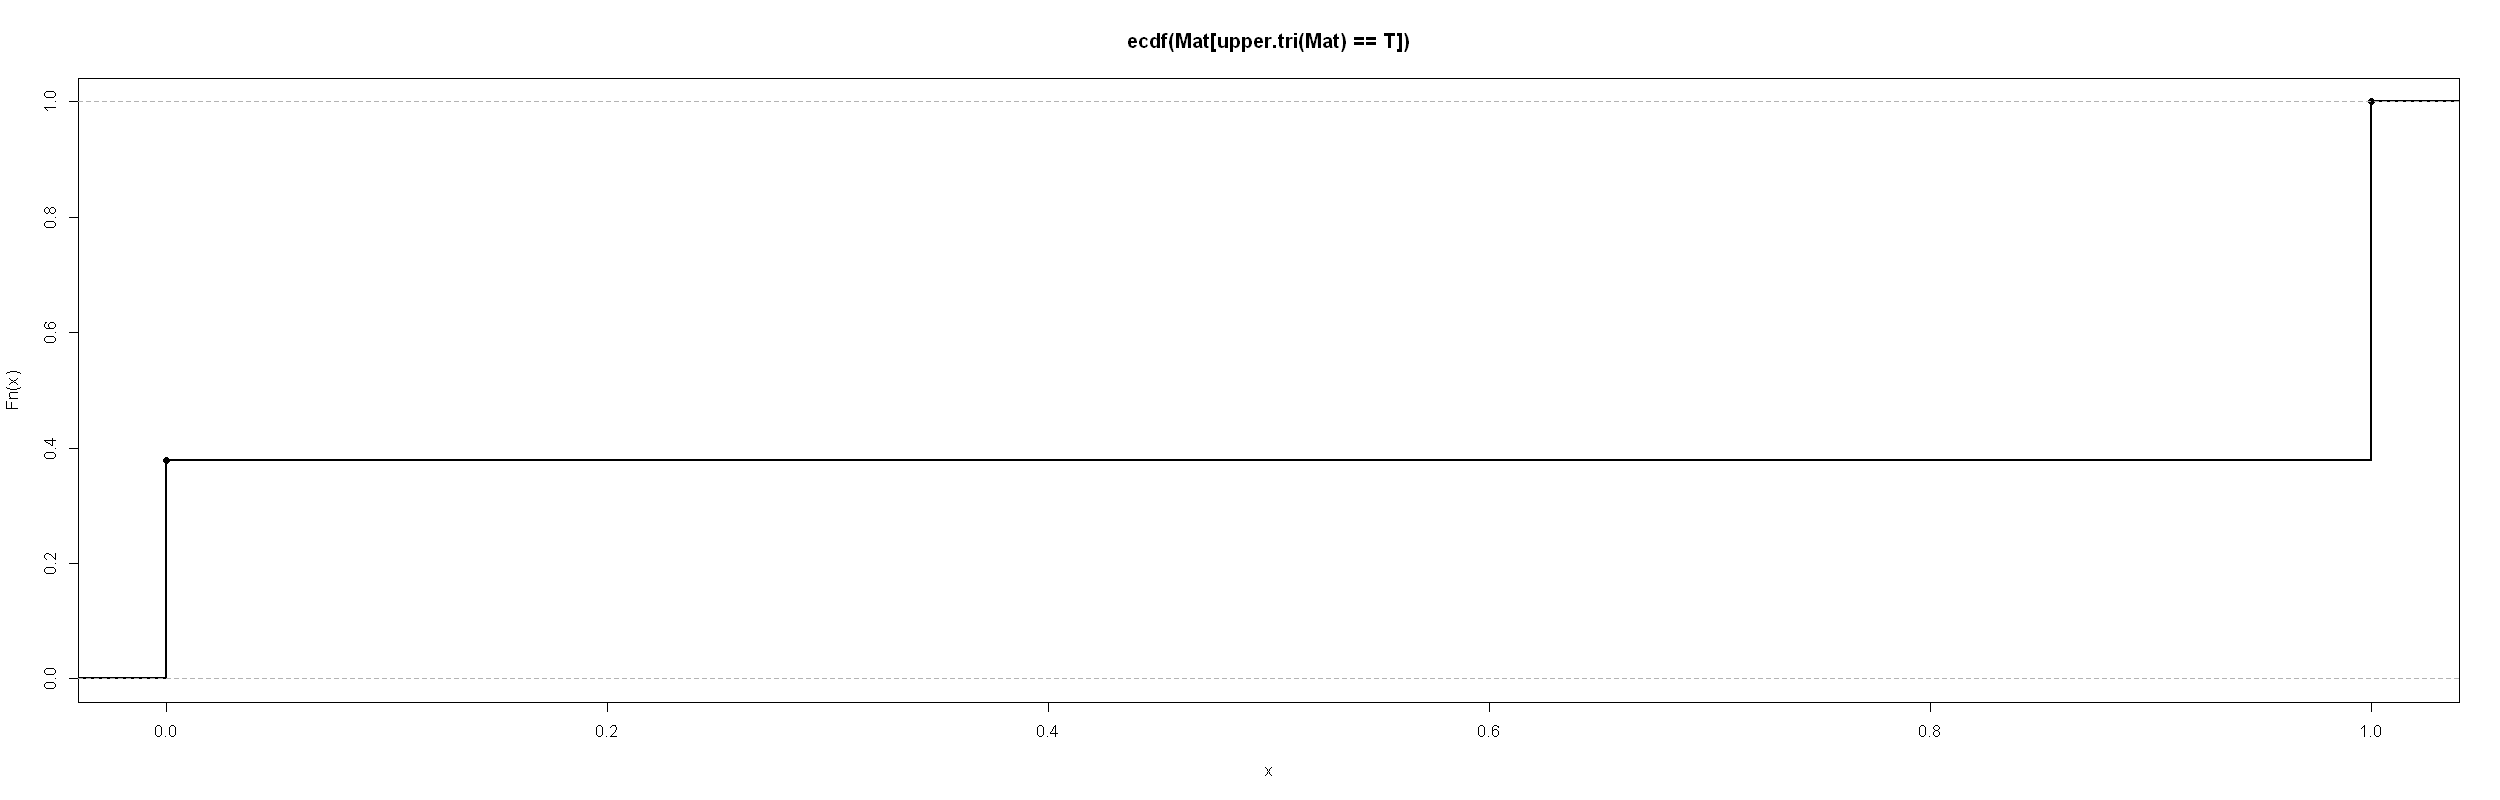

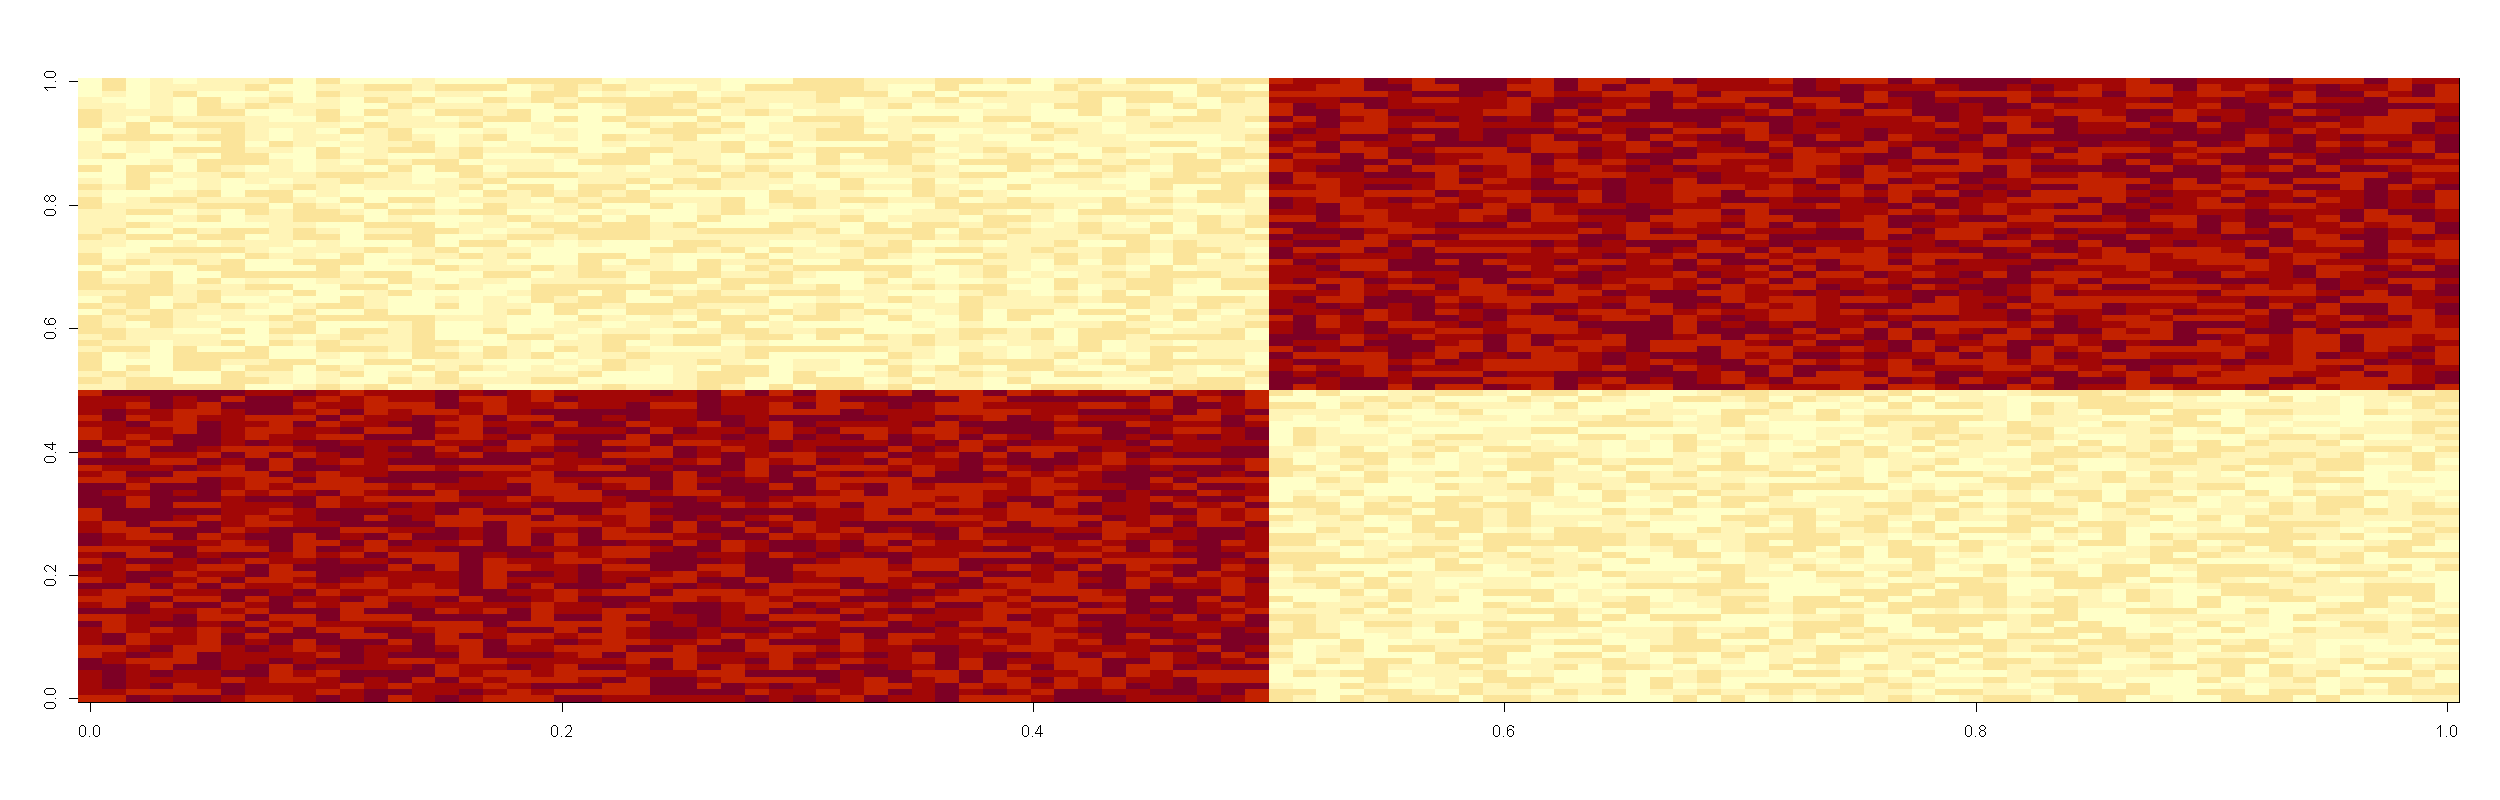

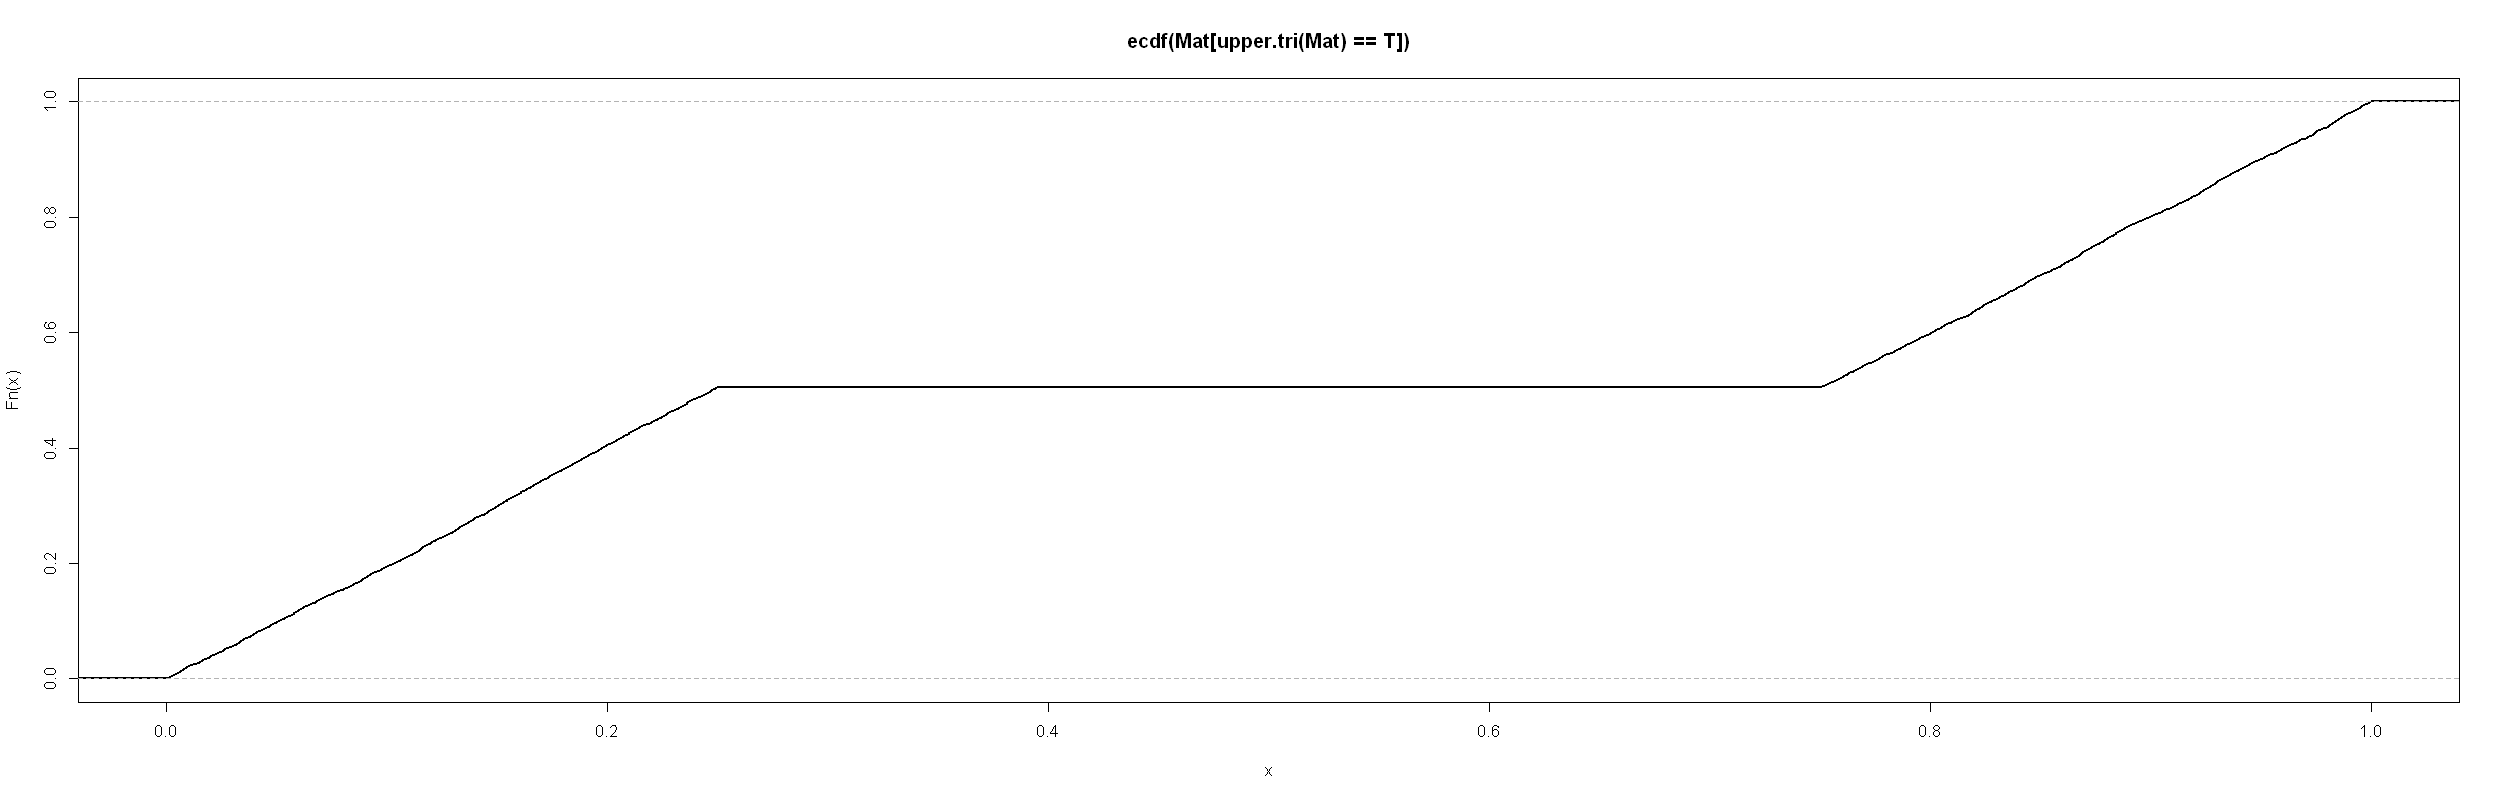

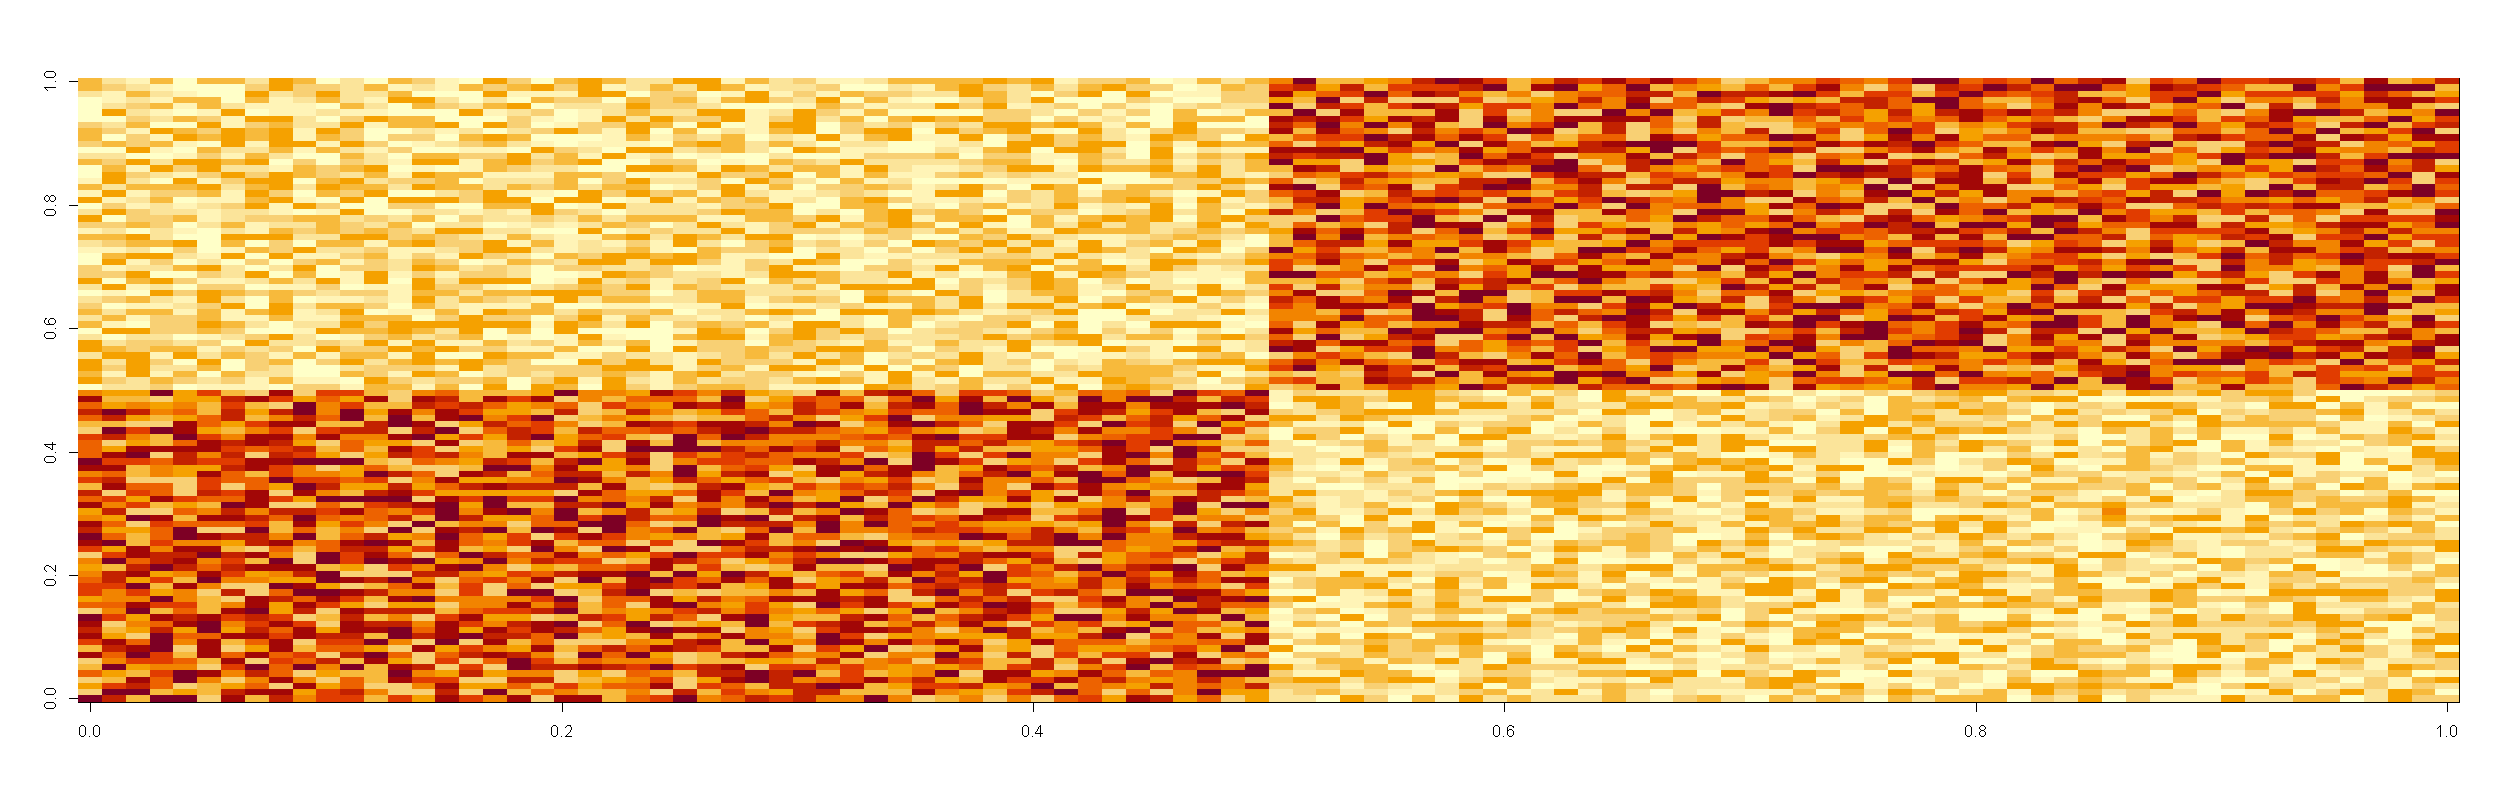

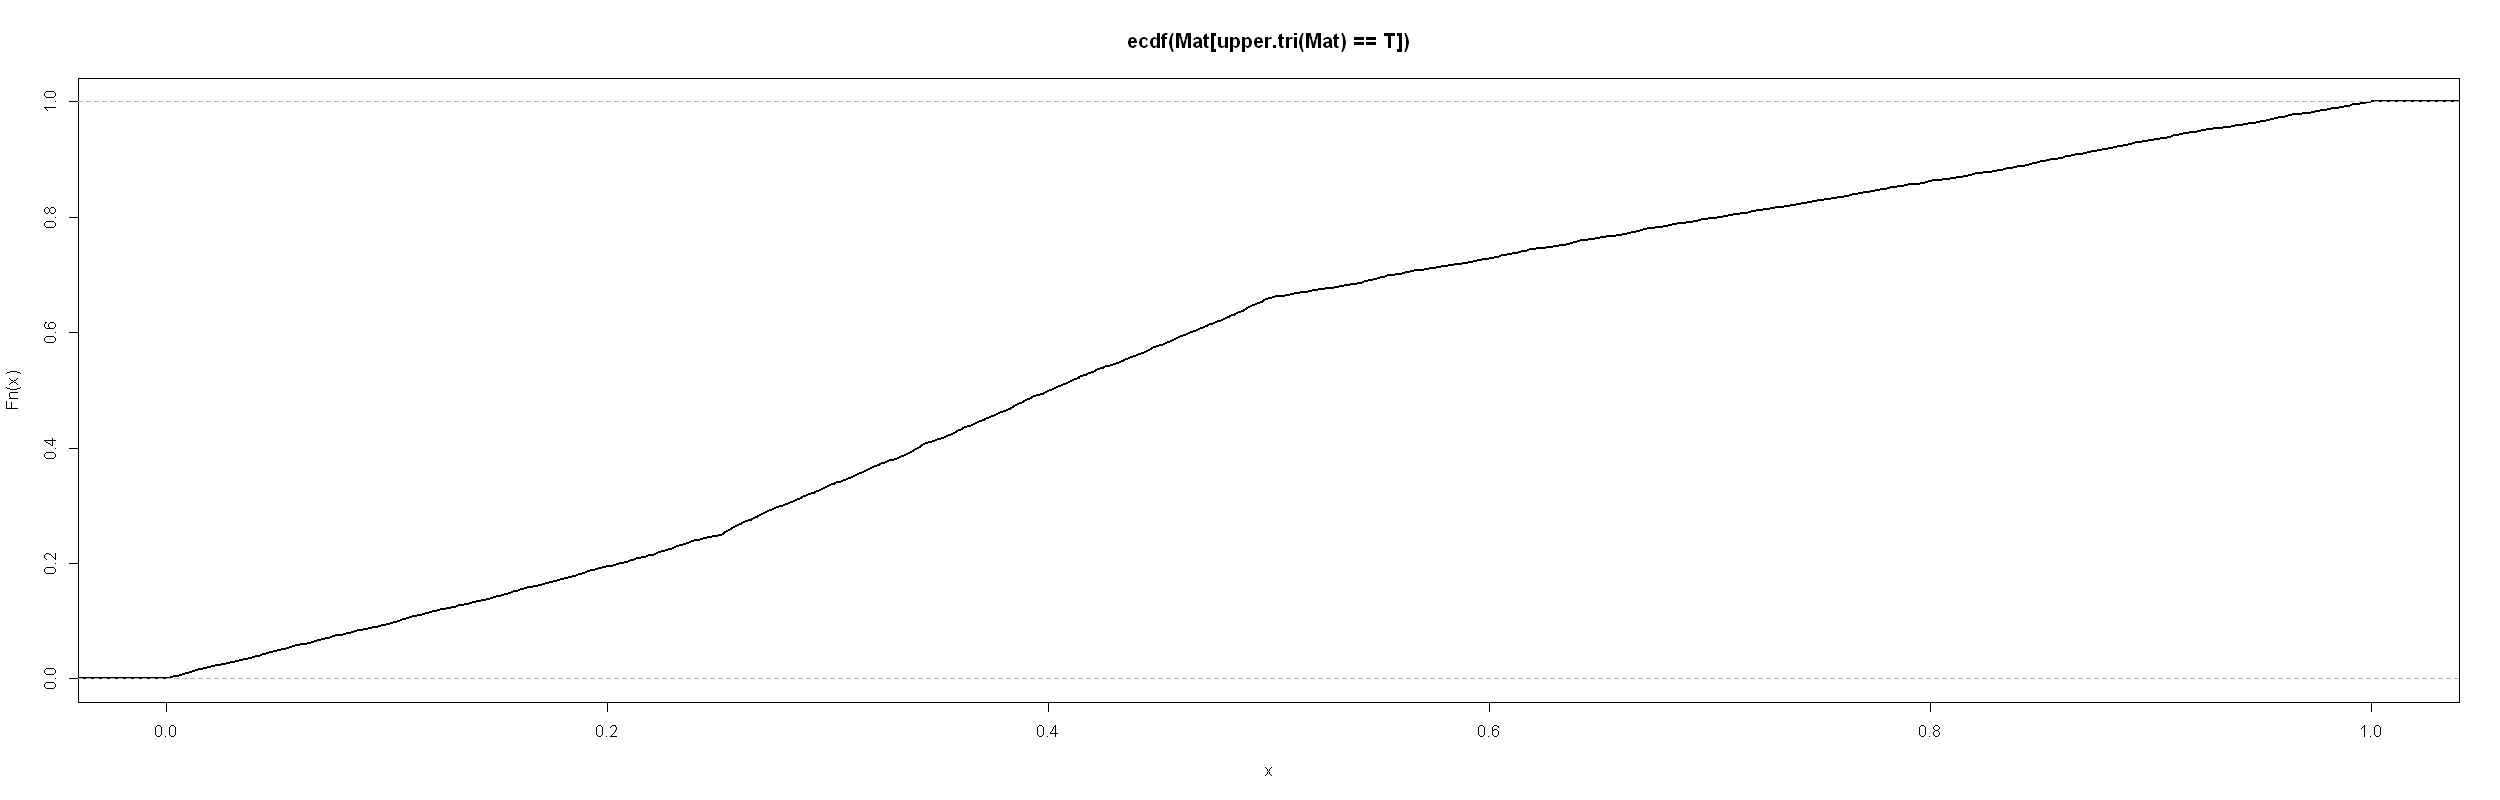

In [415]:
Mat <- matrix(0,100,100)
Mat[1:50,1:50]<-1
Mat[51:100,51:100]<-1
image(Mat)
plot(ecdf(Mat[upper.tri(Mat)==T]),verticals=T,xlim=c(0,1),lwd=2)

Mat <- matrix(0,100,100)
Mat[1:25,1:25]<-1
Mat[26:100,26:100]<-1
image(Mat)
plot(ecdf(Mat[upper.tri(Mat)==T]),verticals=T,xlim=c(0,1),lwd=2)

Mat <- matrix(runif(100*100,0,.25),100,100)
Mat[1:50,1:50]<-1*runif(50*50,.75,1)
Mat[51:100,51:100]<-1*runif(50*50,.75,1)
image(Mat)
plot(ecdf(Mat[upper.tri(Mat)==T]),verticals=T,xlim=c(0,1),lwd=2)

Mat <- matrix(runif(100*100,0,.5),100,100)
Mat[1:50,1:50]<-1*runif(50*50,.25,1)
Mat[51:100,51:100]<-1*runif(50*50,.25,1)
image(Mat)
plot(ecdf(Mat[upper.tri(Mat)==T]),verticals=T,xlim=c(0,1),lwd=2)

Notice, how the "perfect" CDF has a jump at 0 and then another jump at 1. The jump sizes depends on relative cluster sizes etc. Now, if you make clusters aren't always stable so some of the observation pairs are not always together or apart there is a softer transition between the 0s (never together) and the 1s (always together). The more unstable the clusters become the closer the CDF becomes to just a smooth curve from 0 to 1.

**Feature filtering**

Let's sort the features by their variance and pick some of the top and bottom ones and see what their distribution looks like.

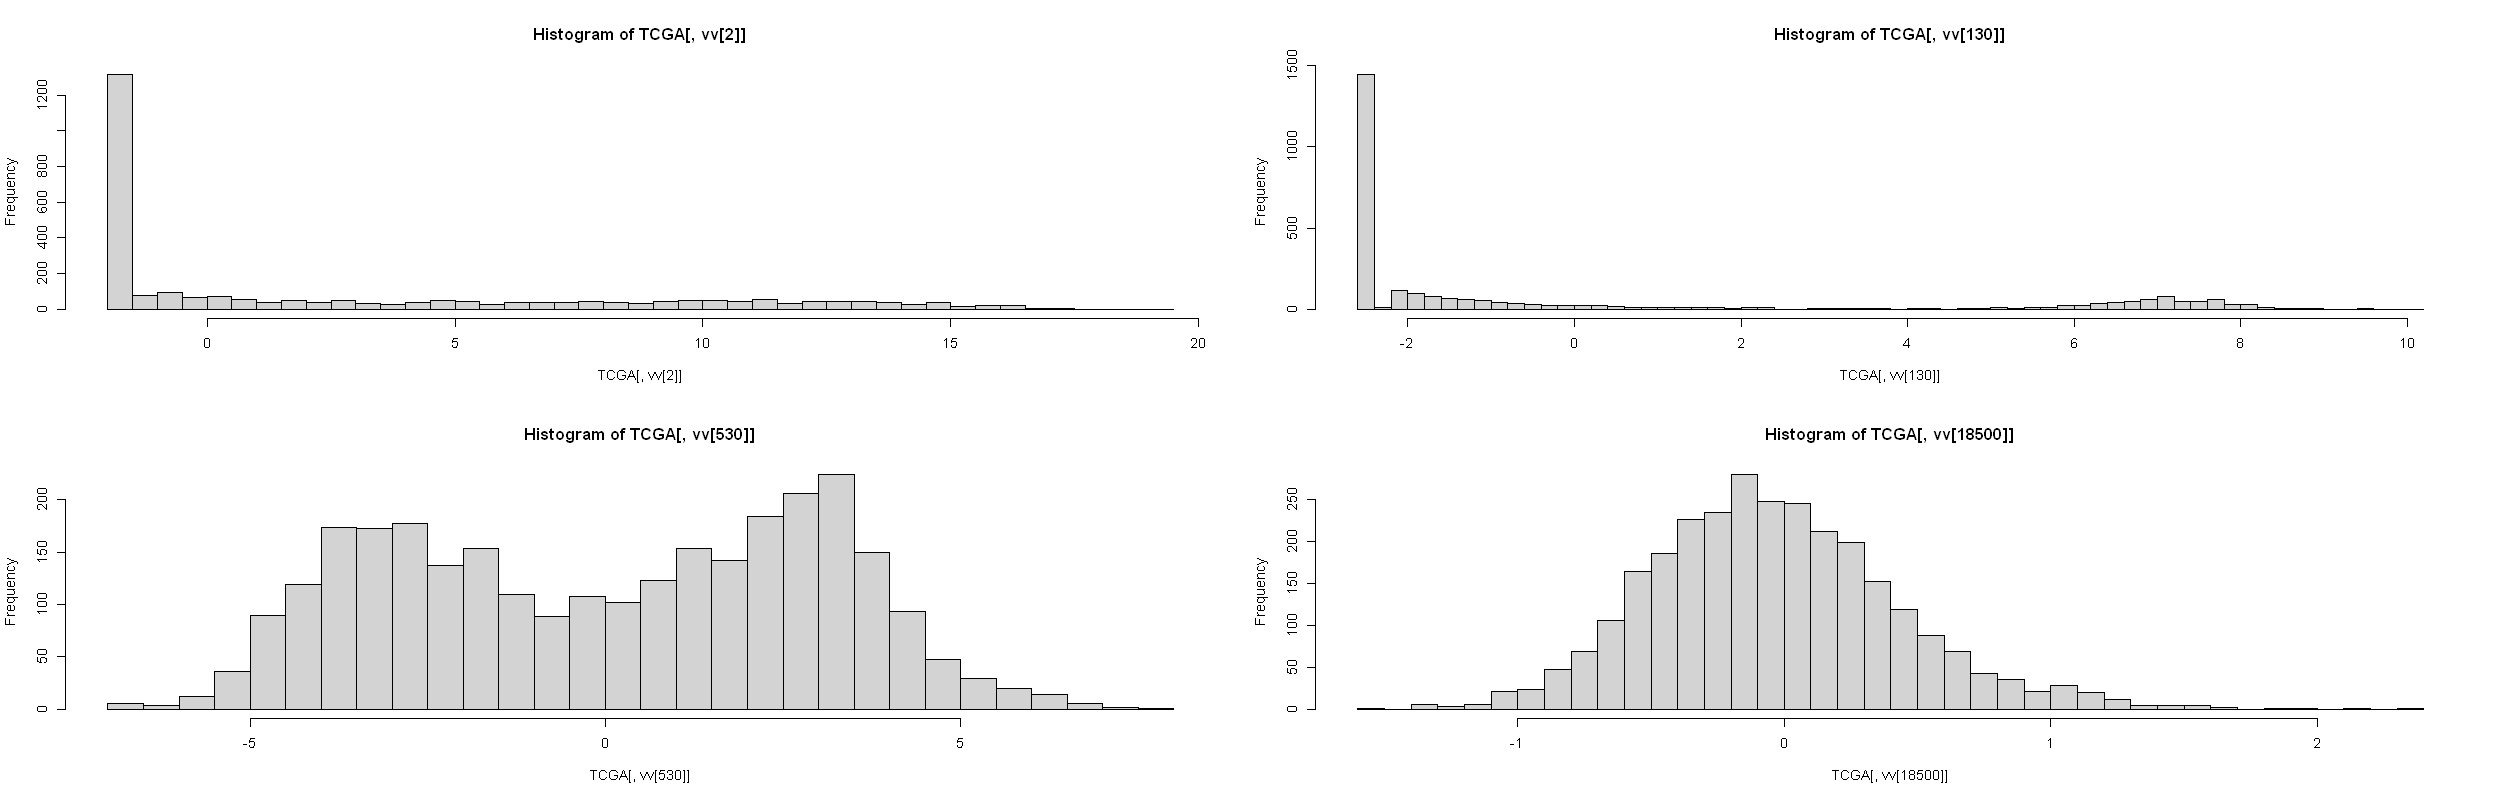

In [434]:
vv<-apply(TCGA,2,sd)
vv<-rev(sort.list(vv))
# some examples of filtered features
par(mfrow=c(2,2))
hist(TCGA[,vv[2]],50)
hist(TCGA[,vv[130]],50)
hist(TCGA[,vv[530]],50)
hist(TCGA[,vv[18500]],50)

What you see is that for most observations a feature may have 0 or near 0 values. This means that a gene may not be expressed for some of the cancer classes but highly expresed for others. If the features look multimodal this might indicate they contain cluster information. Feature 530 looks nicely bimodal whereas feature 18500 looks unimodal. Remember this is sorted by decreasing variance.

Let's use the leading 250 features and perform clustering. Here, I use a bi-clustering approach so I also cluster the features. The distance metric is euclidean.

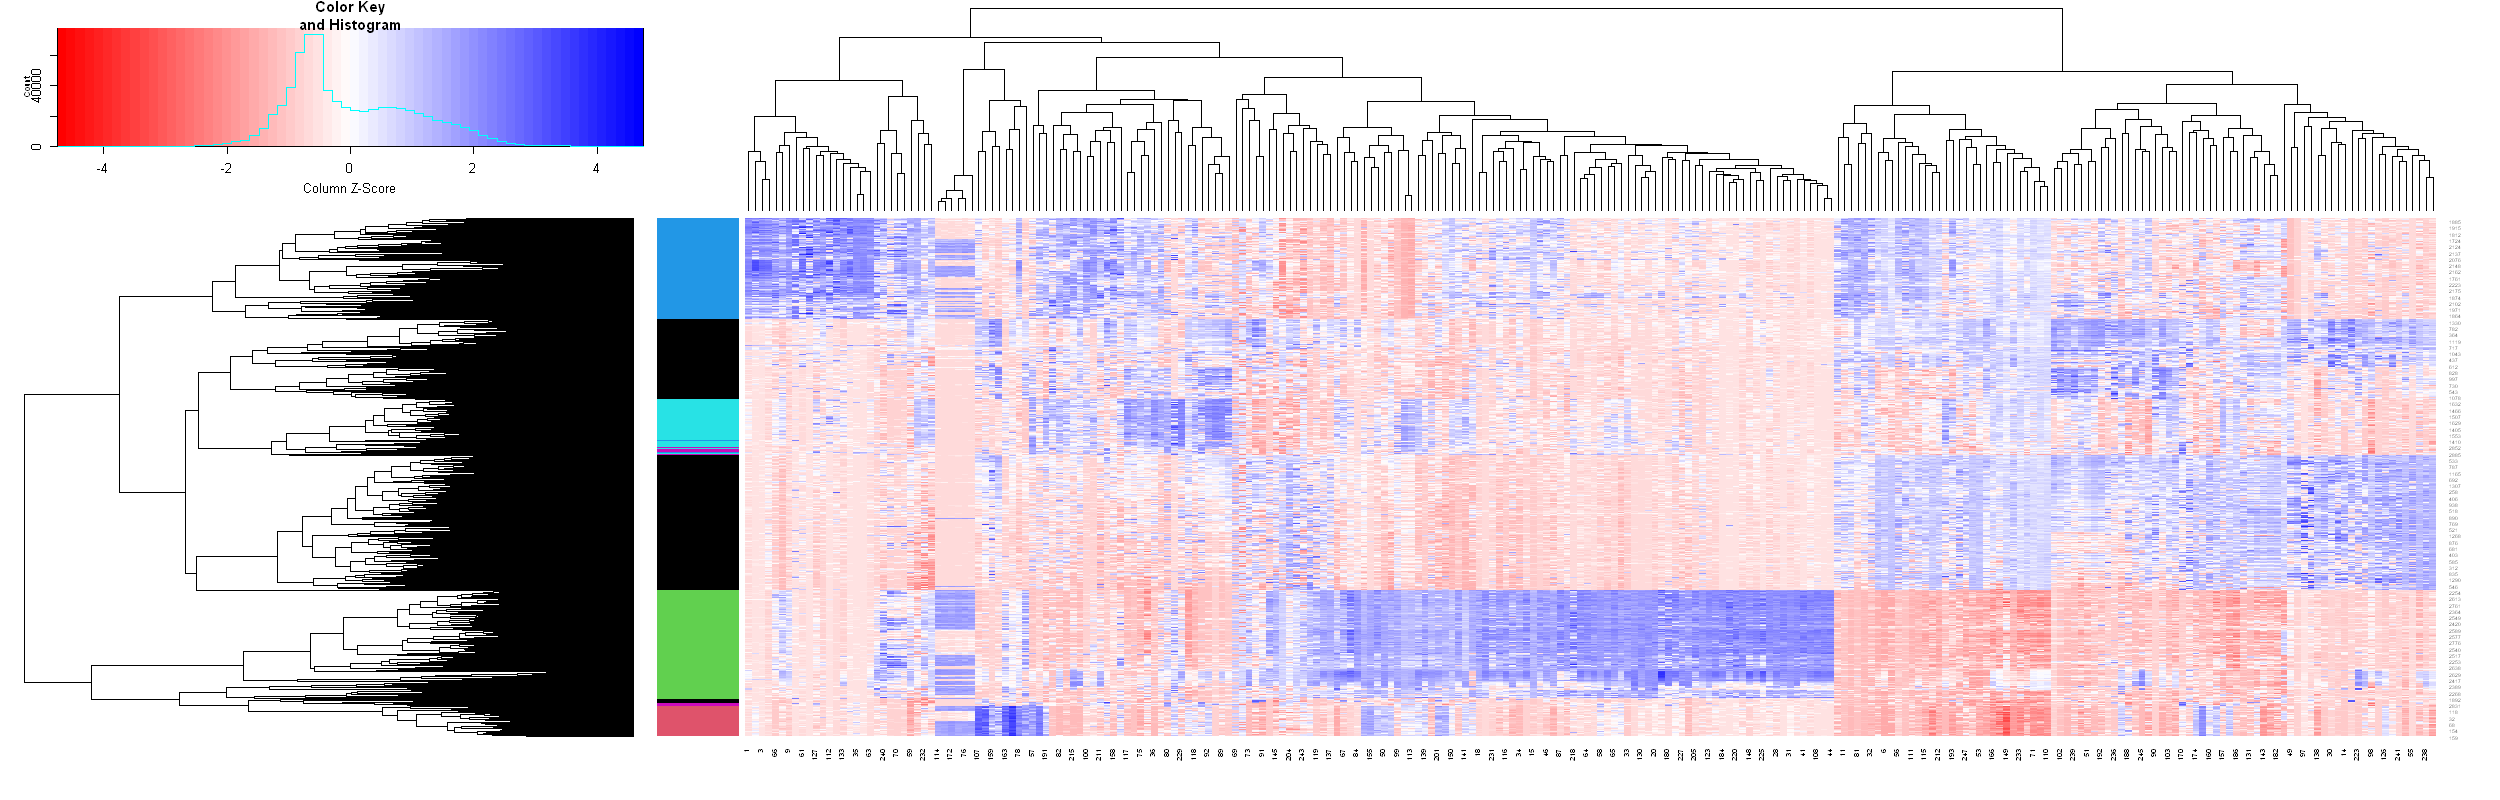

In [435]:
guse<-vv[1:250]
# use top 250 genes
library(gplots)
heatmap.2(as.matrix(TCGA[,guse]),
          col=colorRampPalette(c("red","white","blue"))(64),RowSideColors = as.character(cols),
          hclust=function(x) hclust(x,method="complete"),scale="column",trace="none")
#euclidean distance

You see a nice patch work here. This is the sorted data matrix, sorted by observation (row) clustering with hierarchical clustering, euclidean distance and sorted by column clustering for the features. The color labels on the left are the true classes. You see a clear overlap with some clusters and classes. But the black class, breast cancer, is clearly split into two groups. You see that there are clusters of genes as well, groups that are either high (blue) or red(low) for a subset of cancers in different patterns. This is a very dense and informative summary of the data. However, always remember that the results are driven by your choices for clustering metric and method.

What if we try a different distance metric. Below, I use correlation as a similarity metric instead.

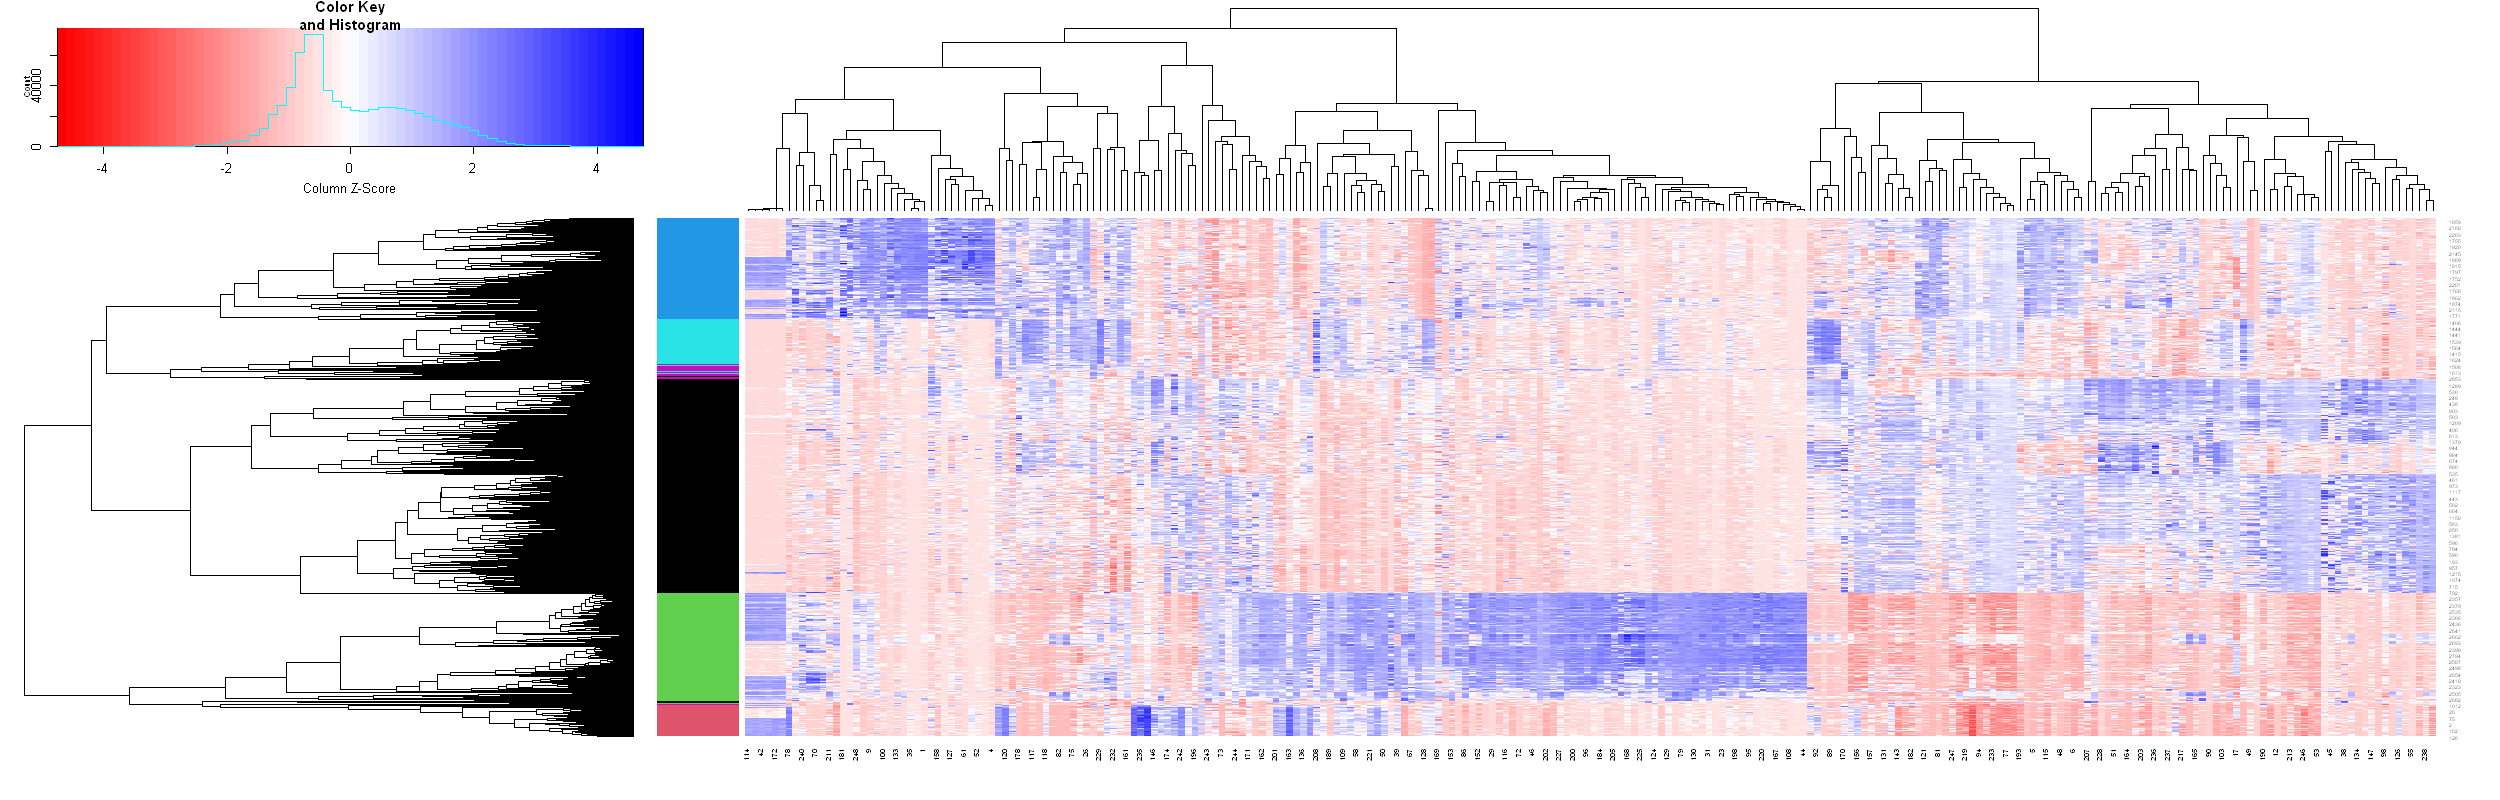

In [436]:
heatmap.2(as.matrix(TCGA[,guse]),
          col=colorRampPalette(c("red","white","blue"))(64),RowSideColors = as.character(cols),
          hclust=function(x) hclust(x,method="complete"),scale="column",trace="none",
          distfun=function(x) as.dist((1-cor(t(x),method="pearson",use="pairwise.complete.obs"))/2))
#correlation 

Notice how the results changed. Now, breast cancer is actually forming a slightly tighter group. 

Let's investigate how feature selection may impact clustering.

First I use the top 2000 varying genes and then use the leading eigenvectors from a PCA on those 2000 features. 

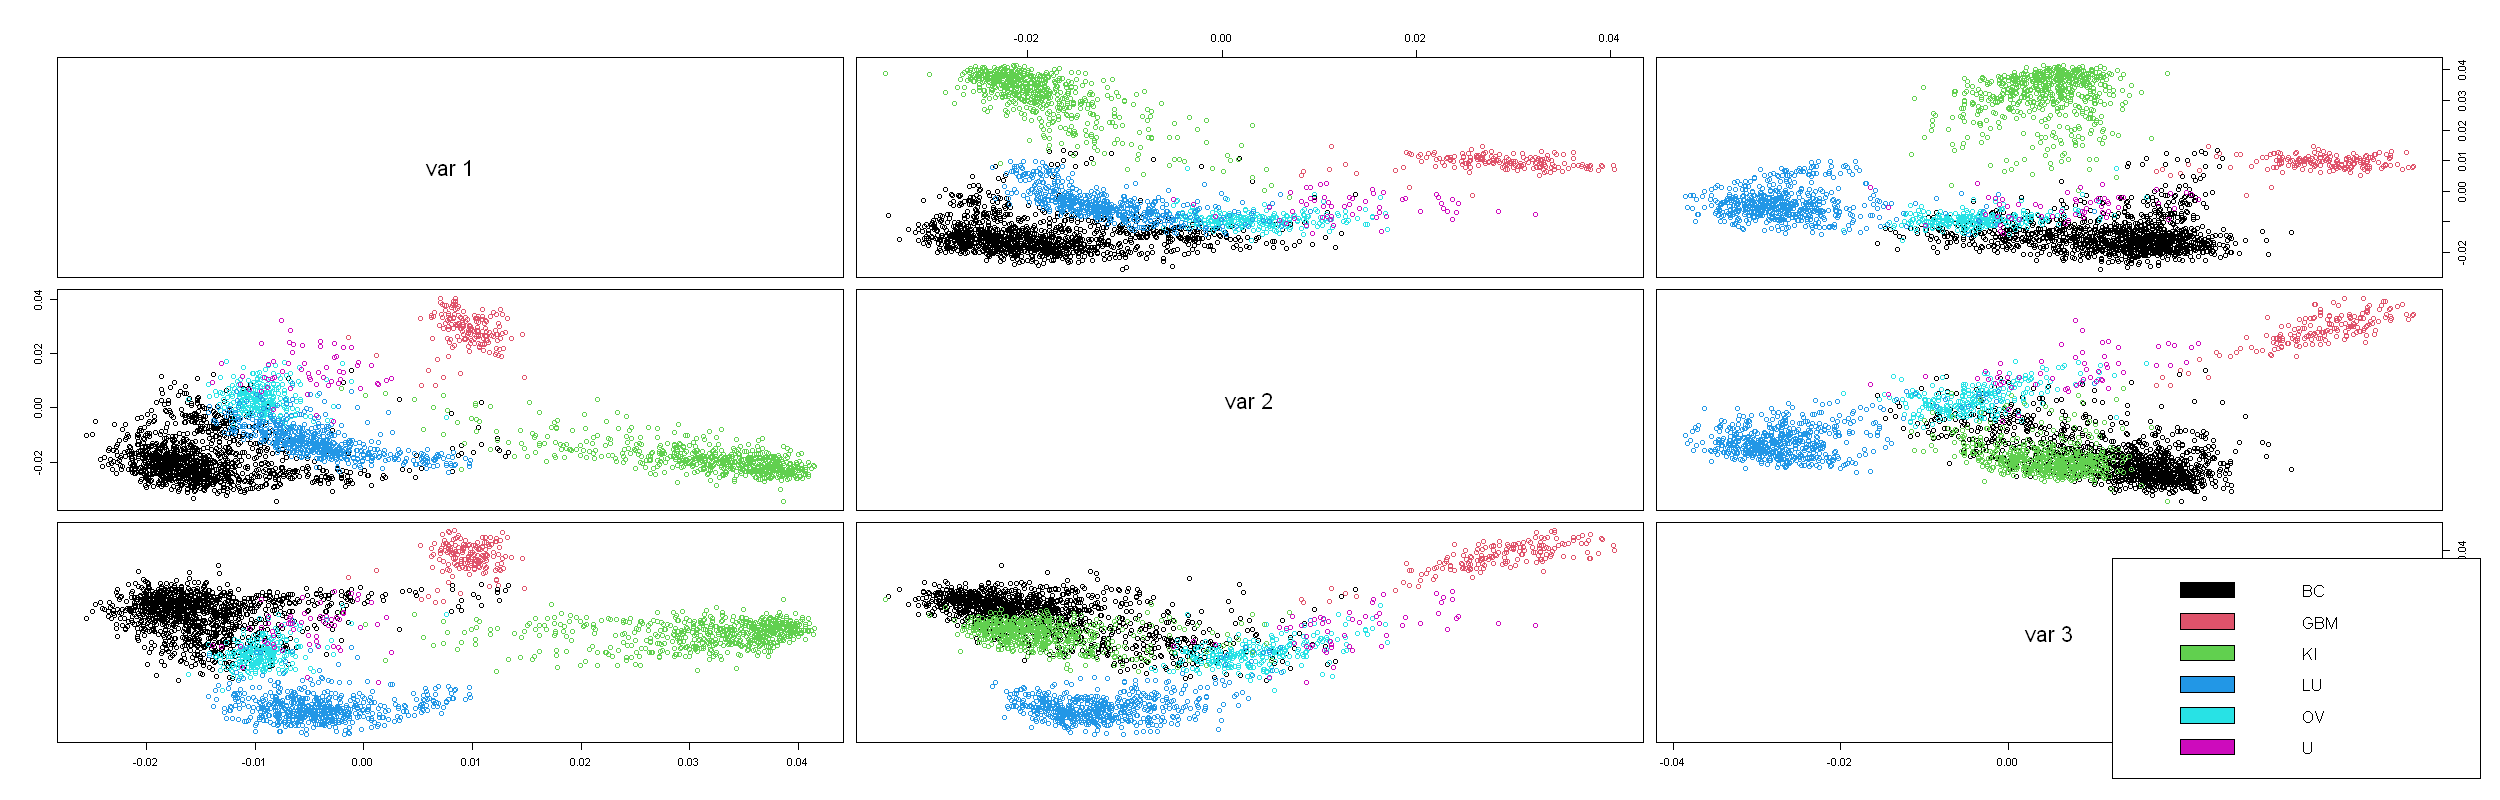

In [437]:
guse<-vv[1:2000]
# use top 2000 genes
ss<-irlba(TCGA,10,10)
pairs(ss$u[,1:3],col=as.numeric(as.factor(TCGAclassstr)))
par(xpd = TRUE)
legend("bottomright", fill = unique(as.factor(TCGAclassstr))[sort.list(as.numeric(as.factor(unique(TCGAclassstr))))], legend = c(levels(as.factor(TCGAclassstr))))


This gives us a good separation for some of the larger classes but clearly also some overlap. If you plot this without the colors you see what I mean. 

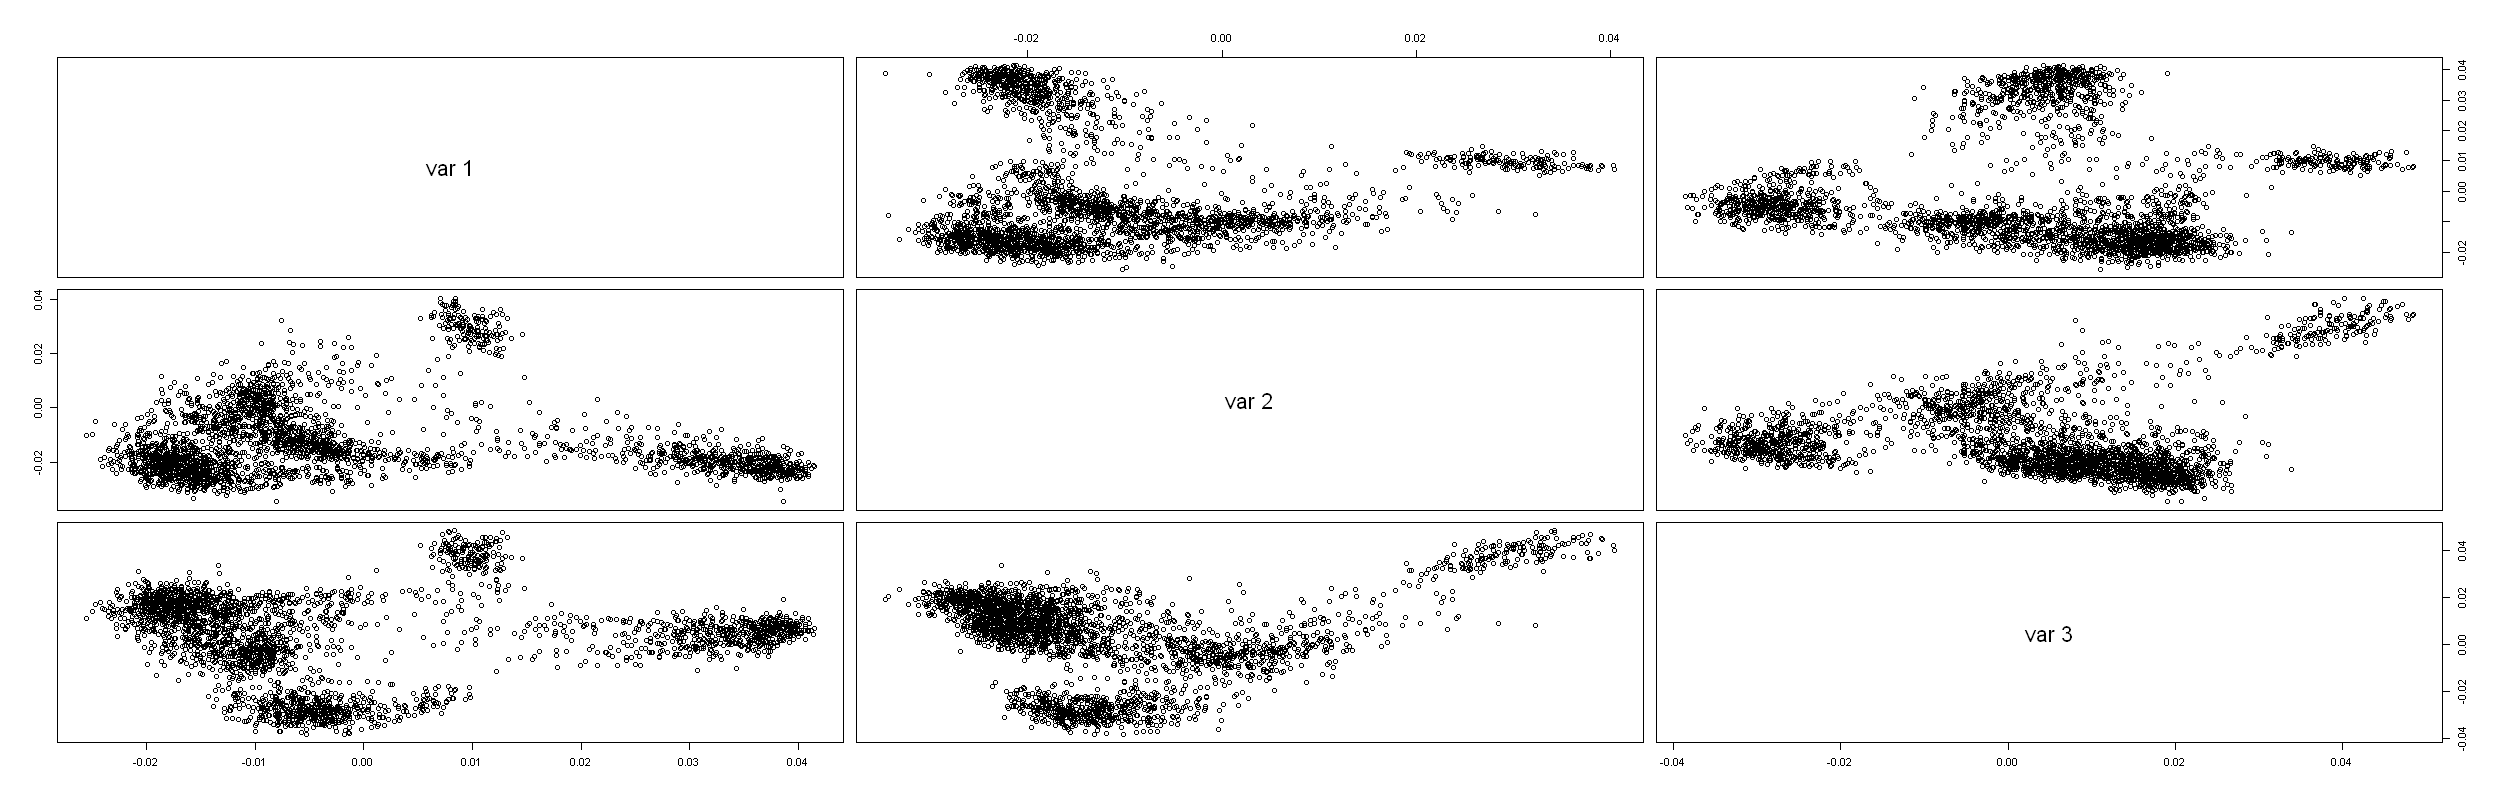

In [438]:
pairs(ss$u[,1:3])


Now it's not so easy to see how many clusters there are or where they are separated.

Let's now only use the top-varying features and see what kind of cluster separation we get then.

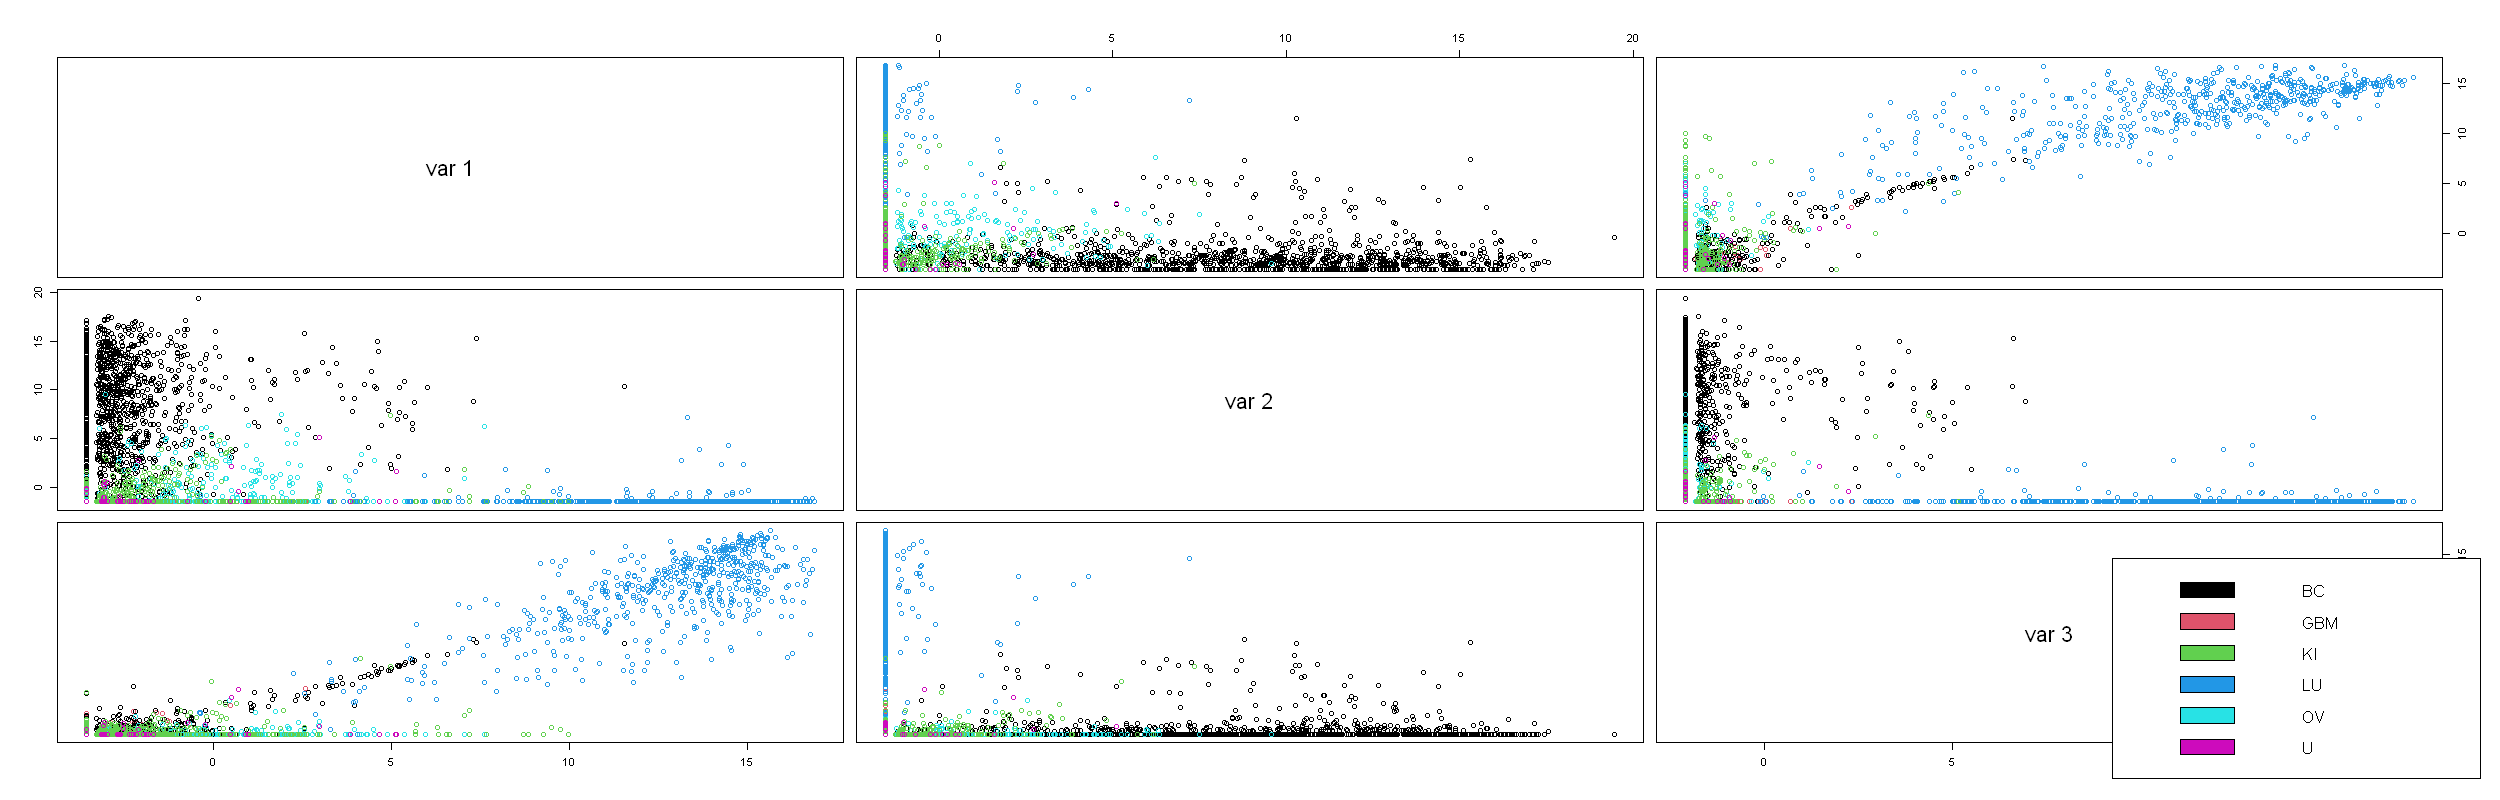

In [439]:
pairs(TCGA[,vv[1:3]],col=as.numeric(as.factor(TCGAclassstr)))
par(xpd = TRUE)
legend("bottomright", fill = unique(as.factor(TCGAclassstr))[sort.list(as.numeric(as.factor(unique(TCGAclassstr))))], legend = c(levels(as.factor(TCGAclassstr))))


Clearly, the top-varying genes are mostly separting breast and lung cancer from the rest. It appears that lung cancer is well separated in the subspace spanned by the 1st and 3rd most varying genes whereas breast cancer is separated along the 2nd most varying genes.

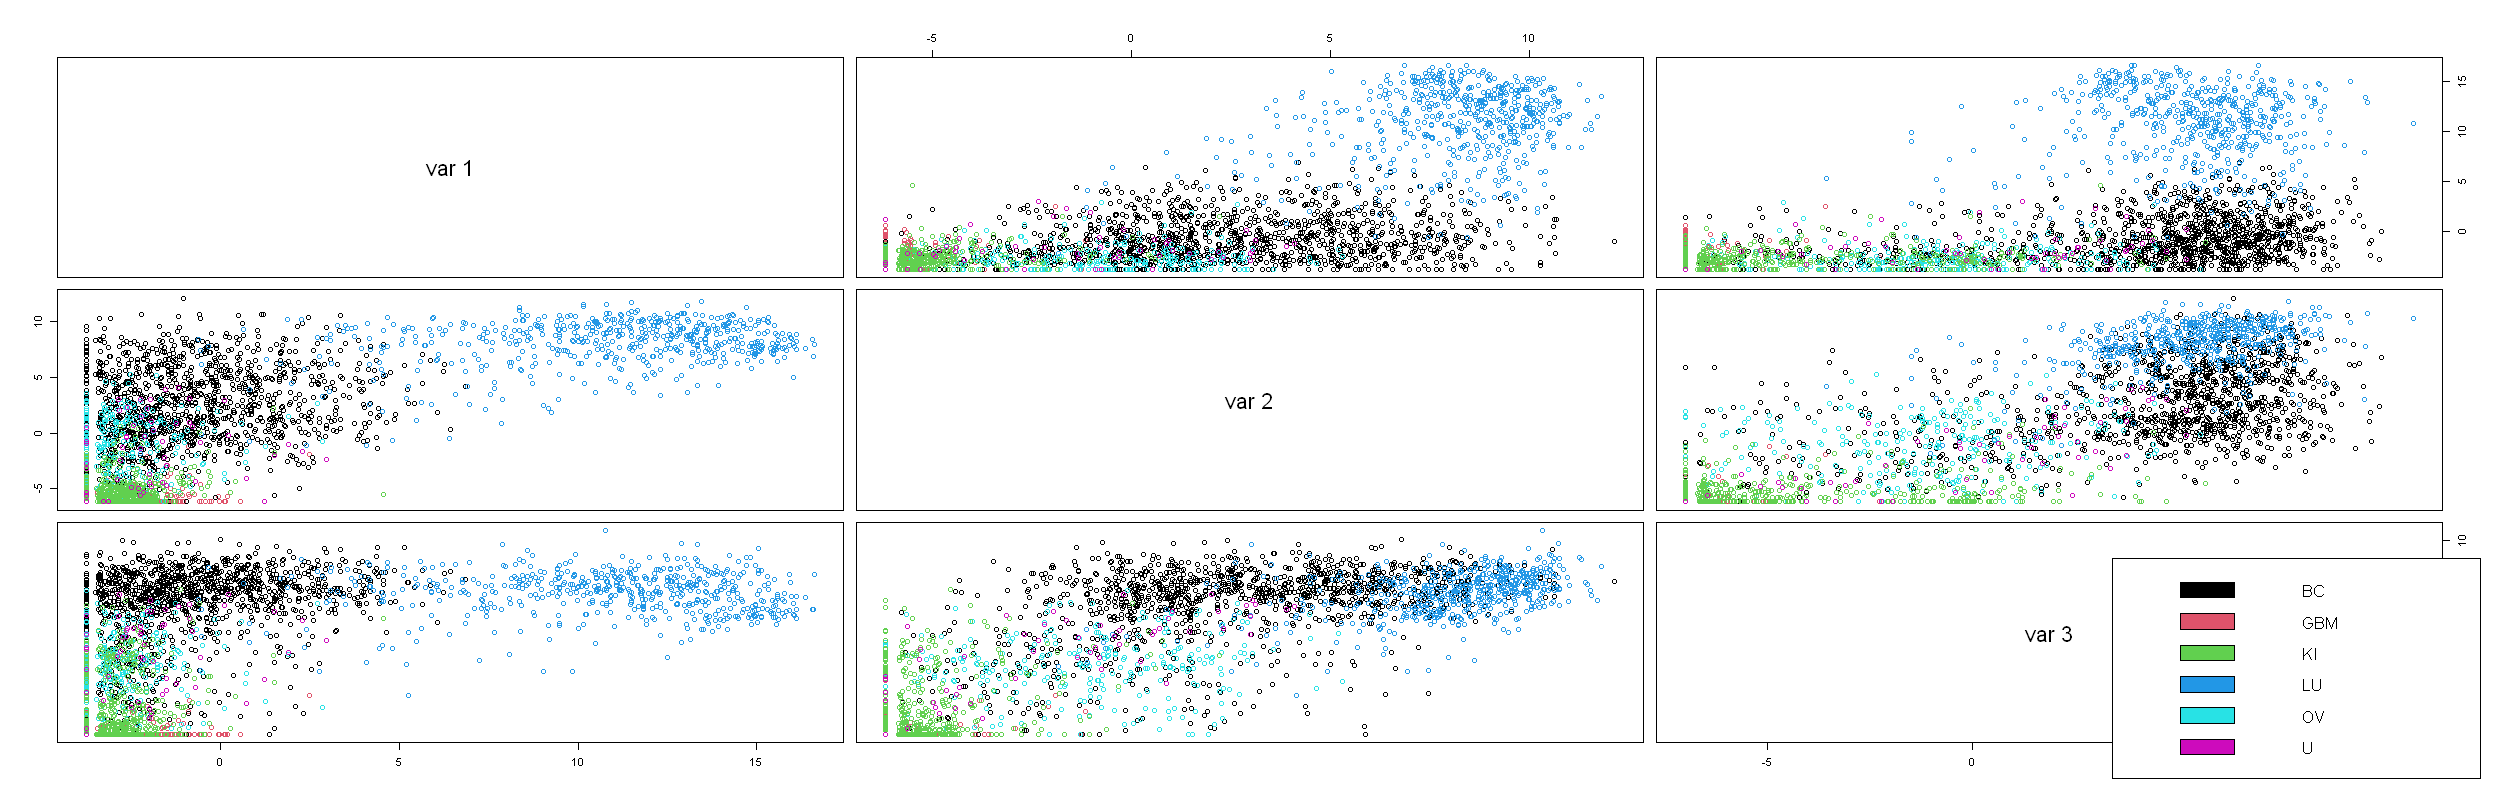

In [440]:
pairs(TCGA[,vv[4:6]],col=as.numeric(as.factor(TCGAclassstr)))
par(xpd = TRUE)
legend("bottomright", fill = unique(as.factor(TCGAclassstr))[sort.list(as.numeric(as.factor(unique(TCGAclassstr))))], legend = c(levels(as.factor(TCGAclassstr))))


If you look at the next few features, it is clear that some cancers dominate if you use variance as a feature selection.

Let's use the Consensurcluster package and investigate cluster stability and selection. 

end fraction

clustered

clustered



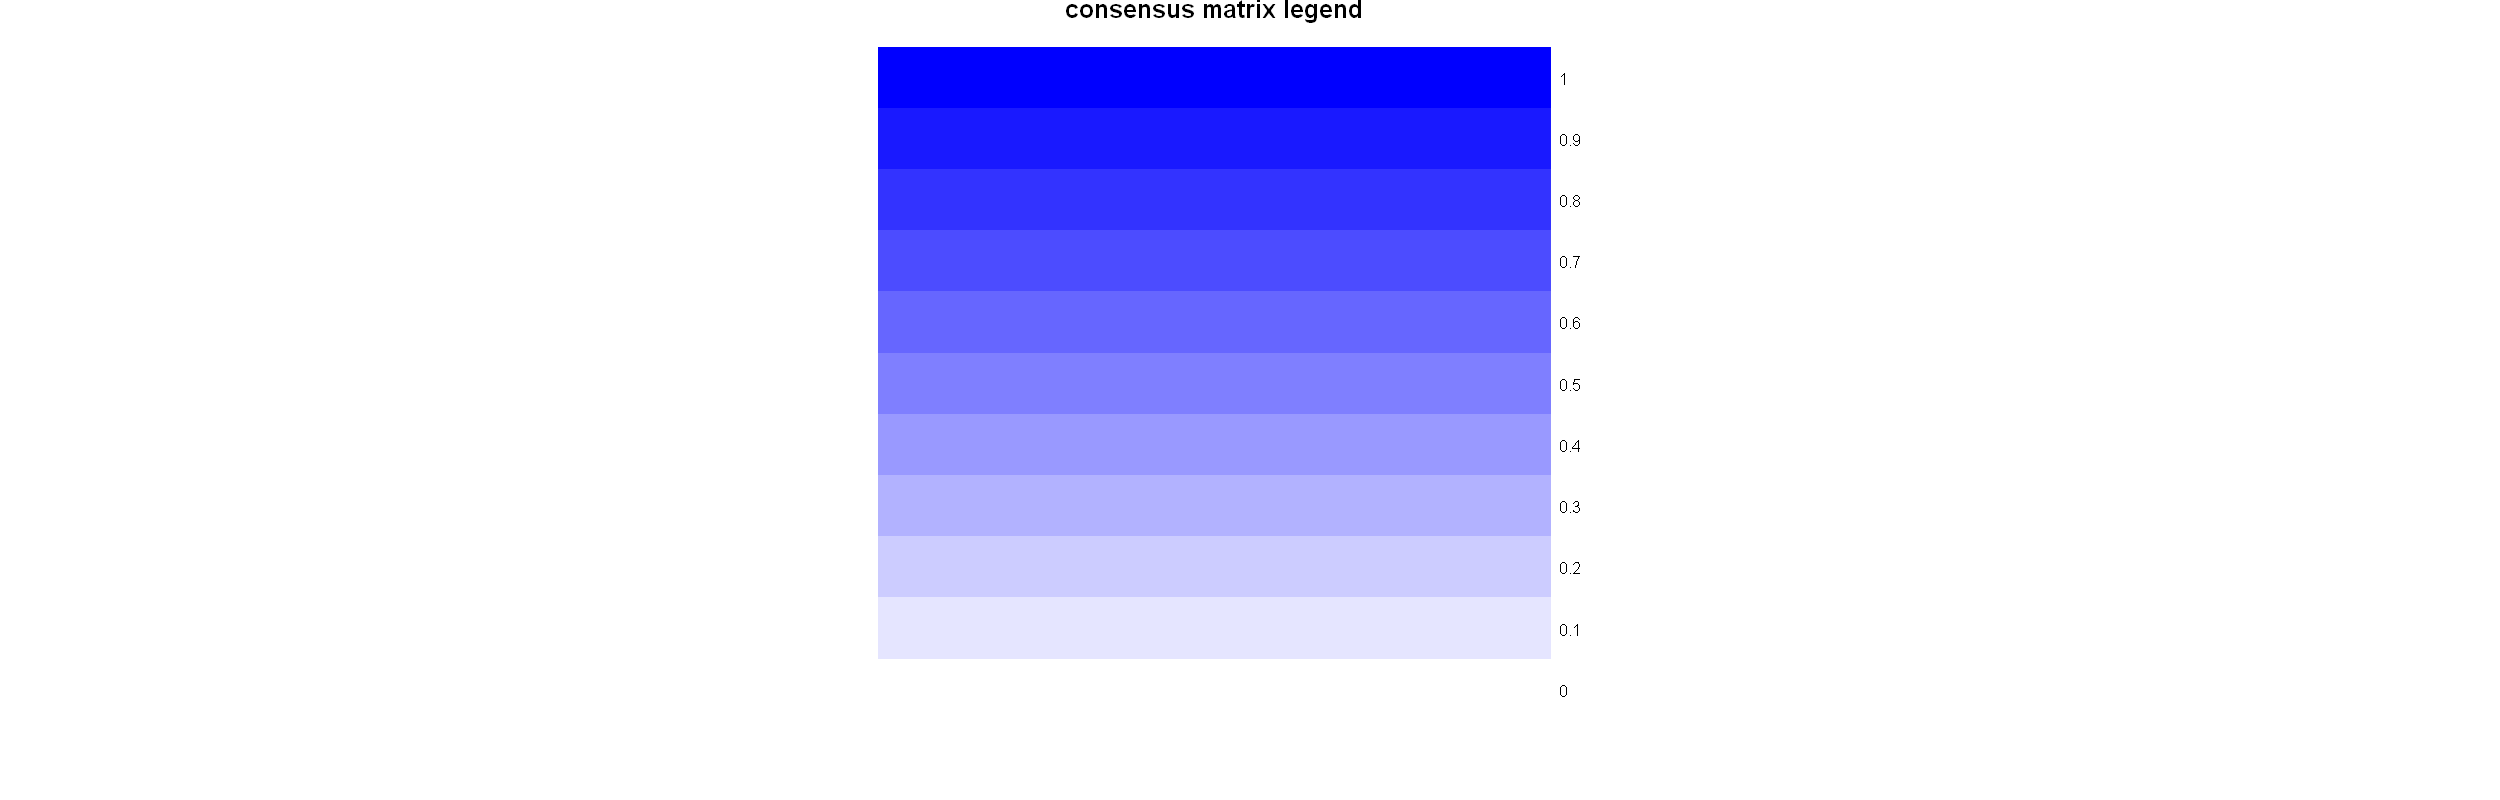

clustered



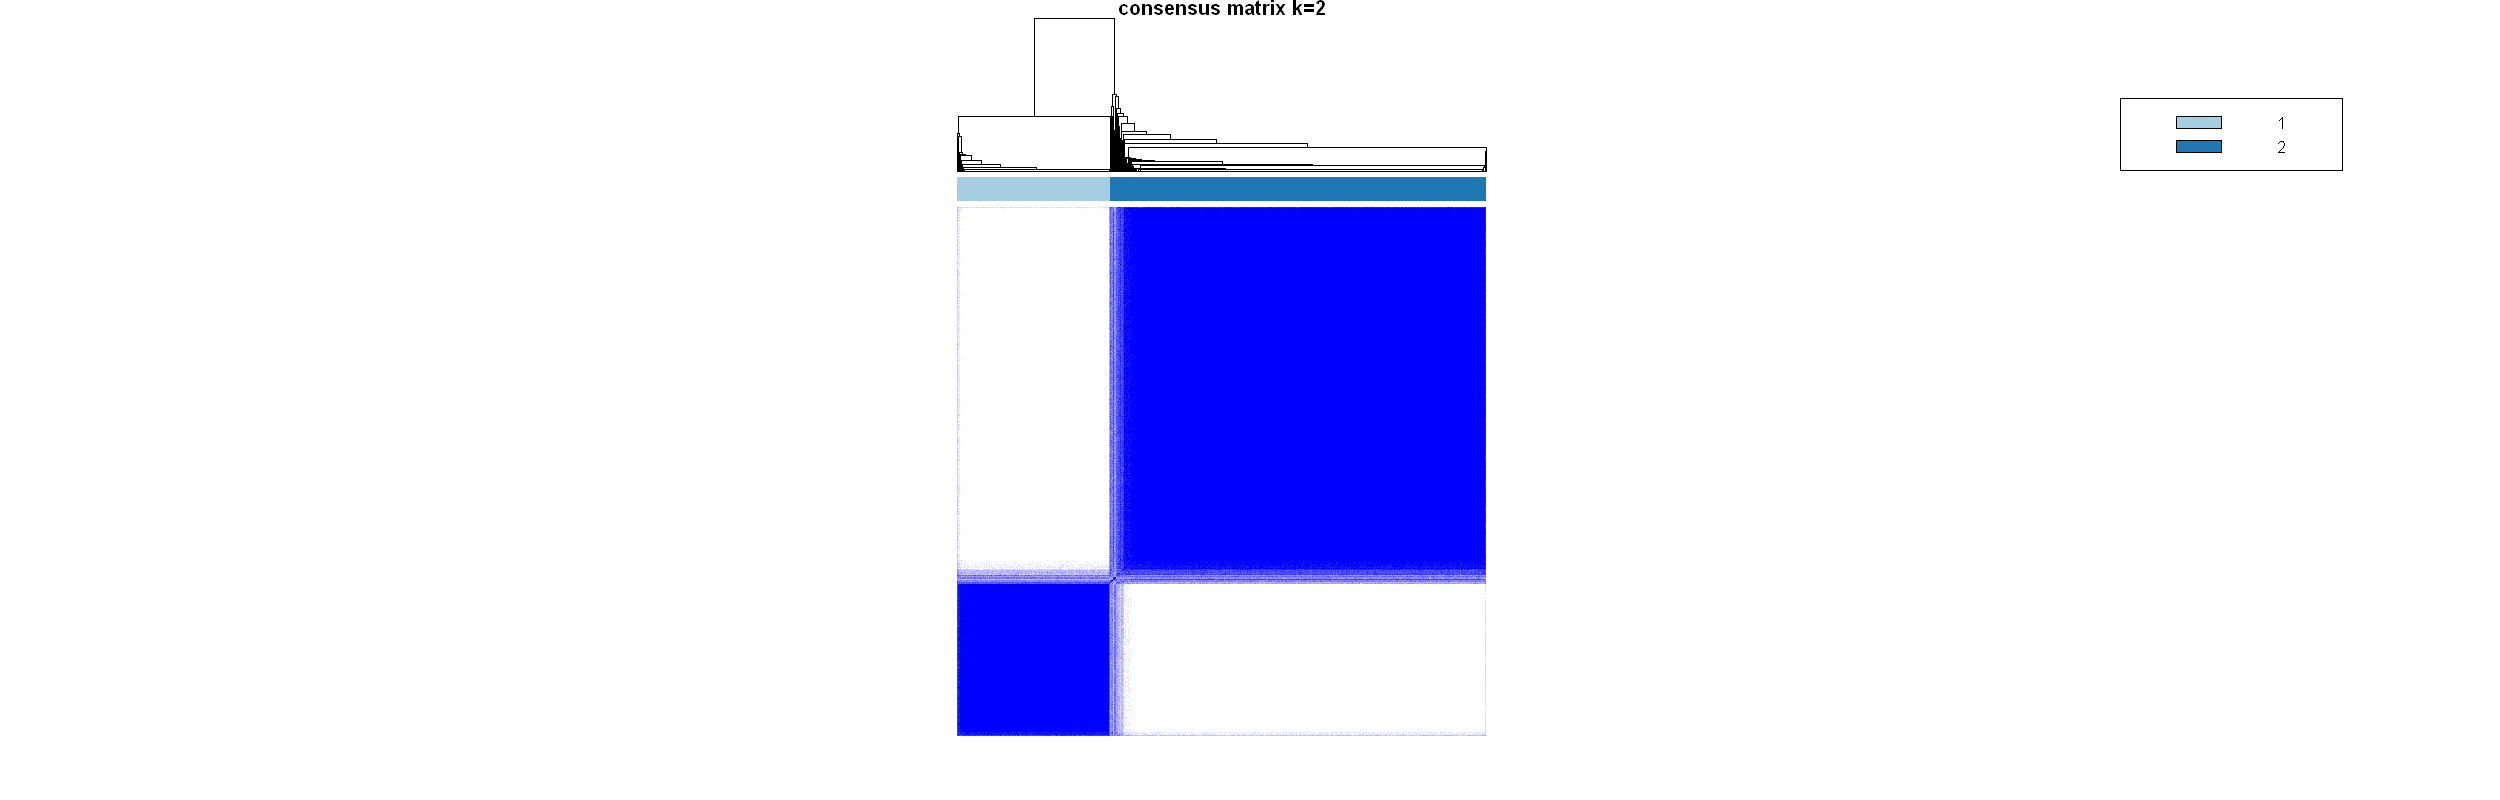

clustered



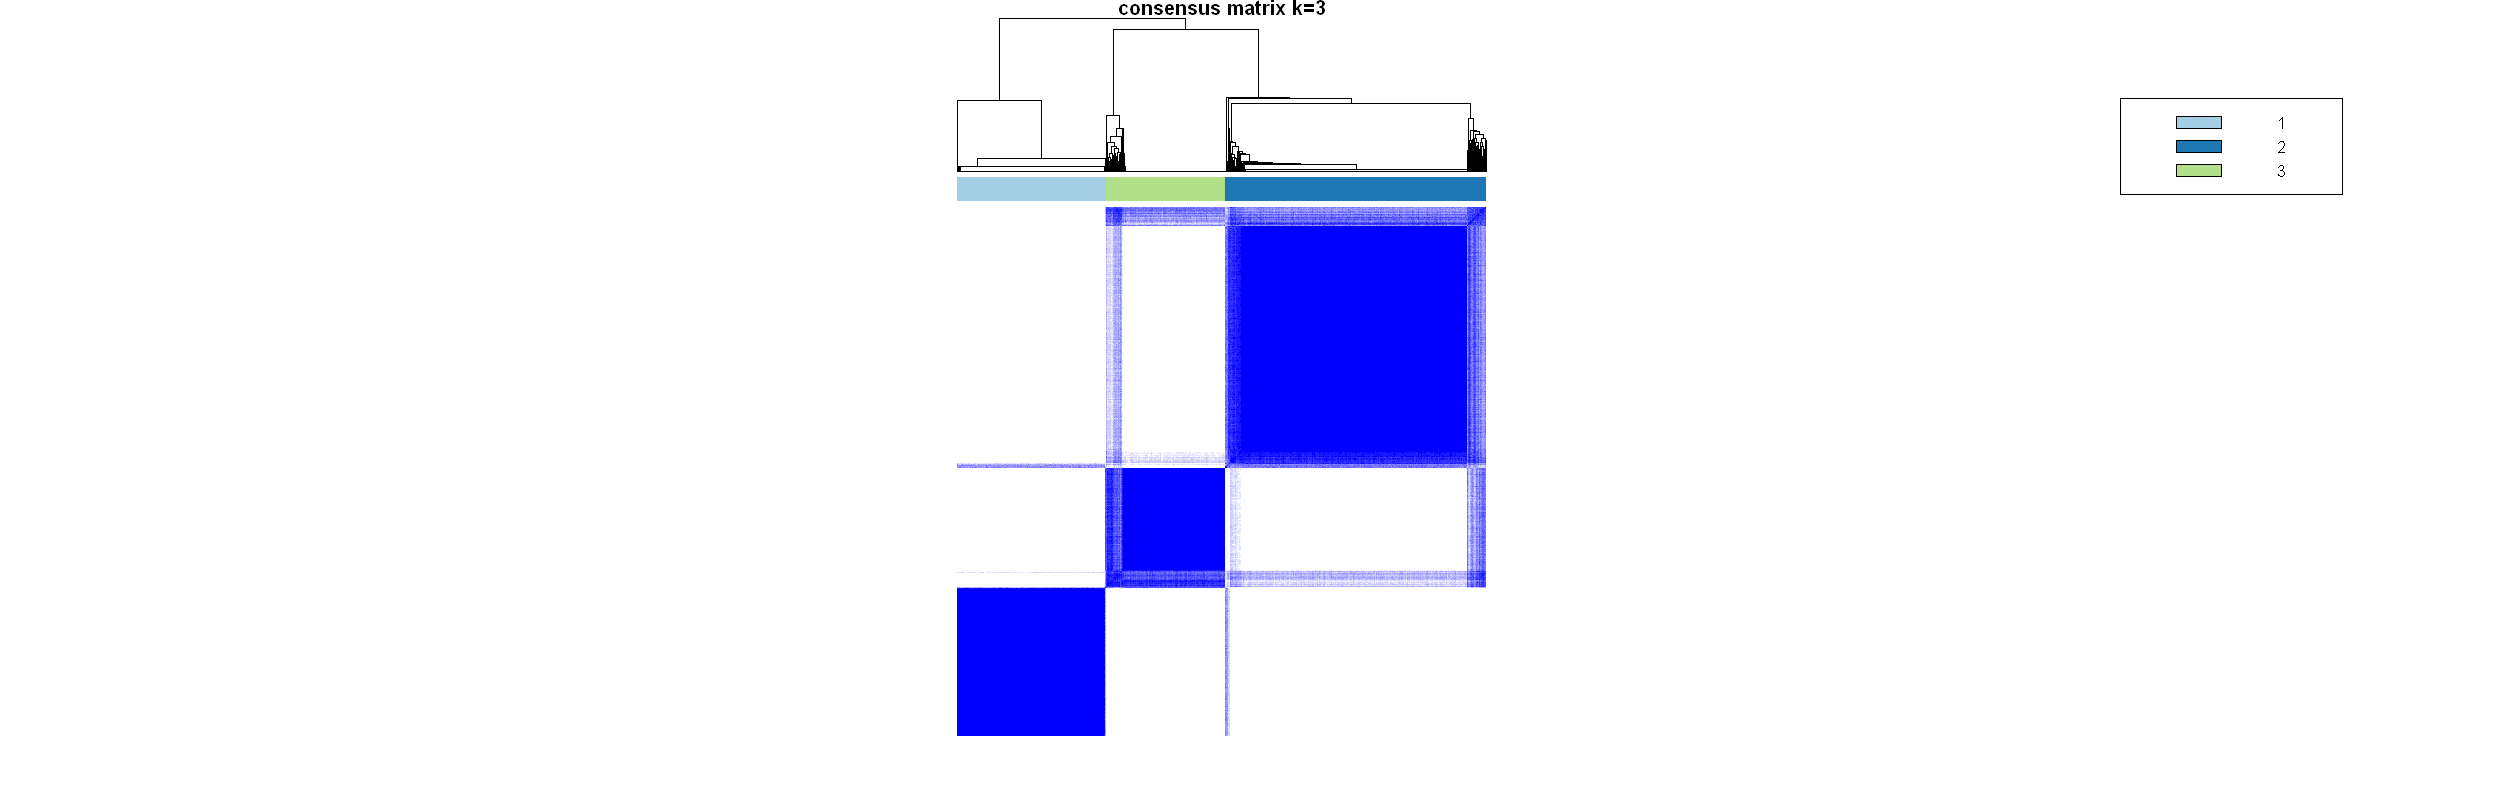

clustered



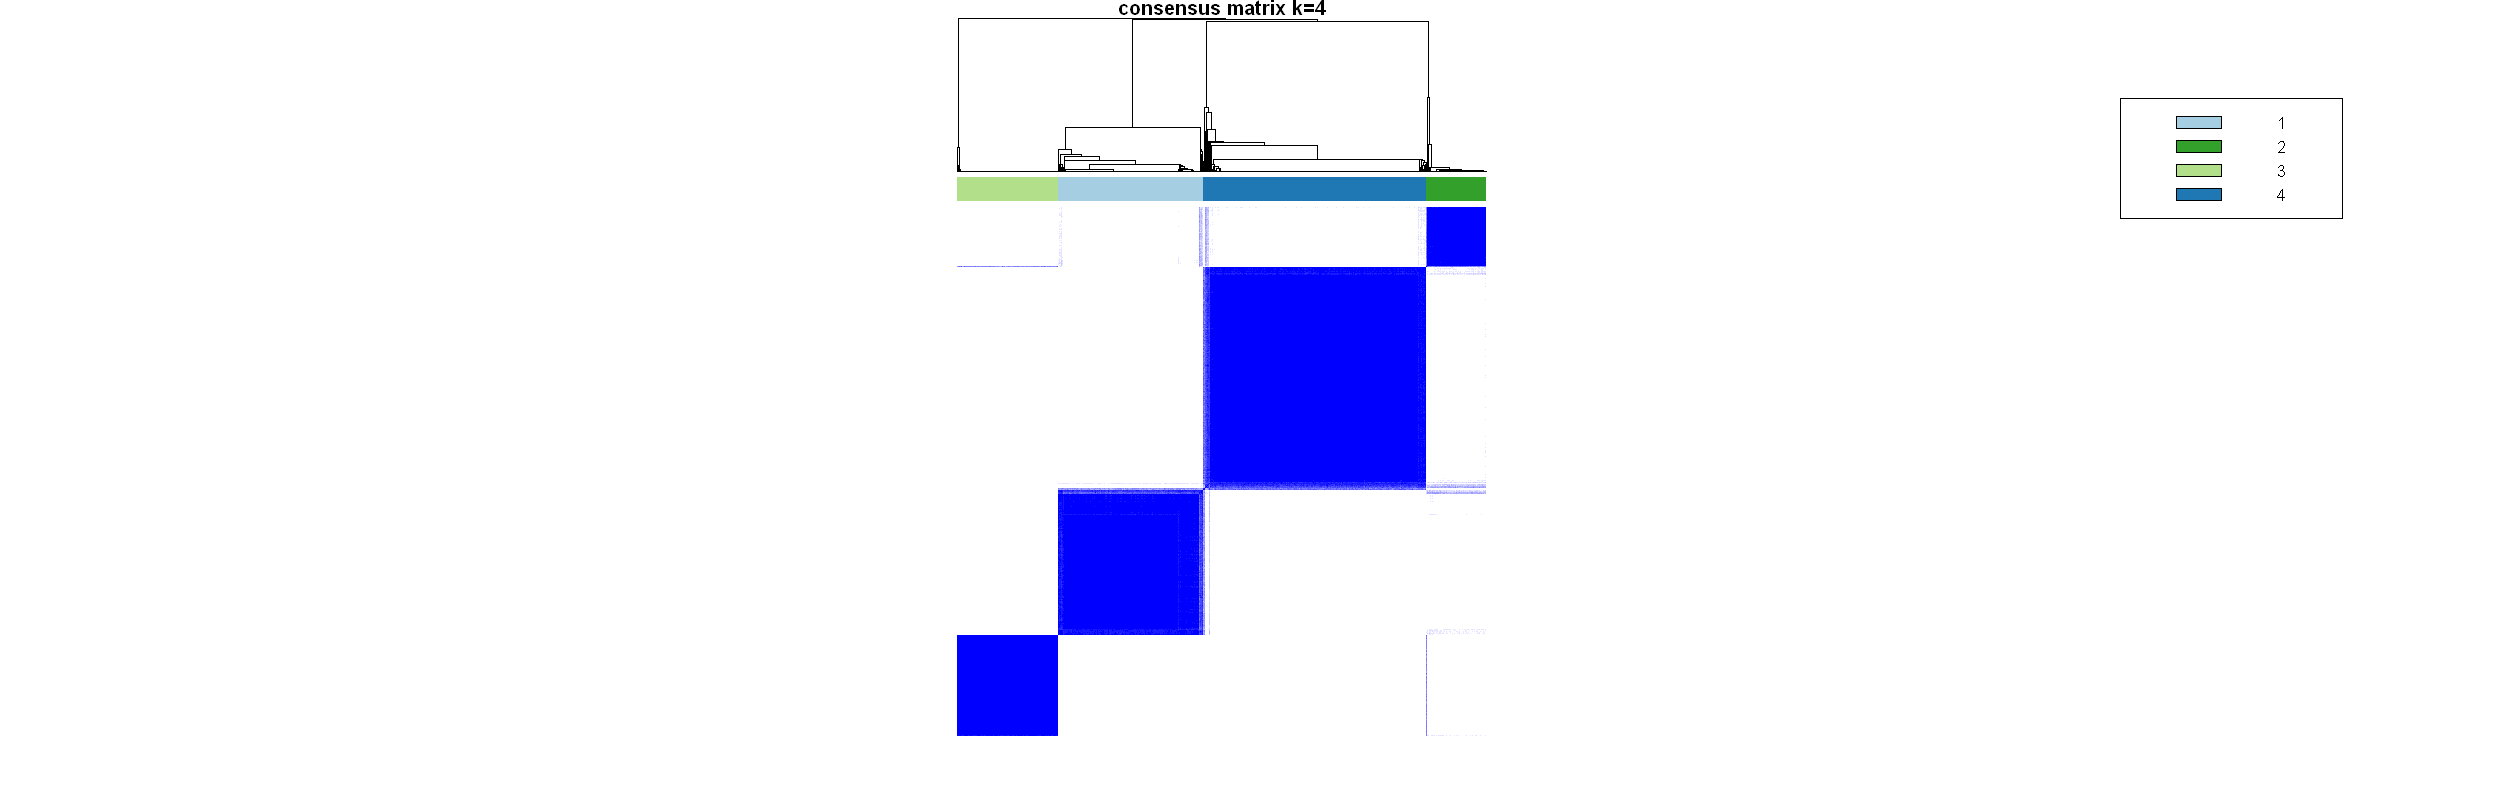

clustered



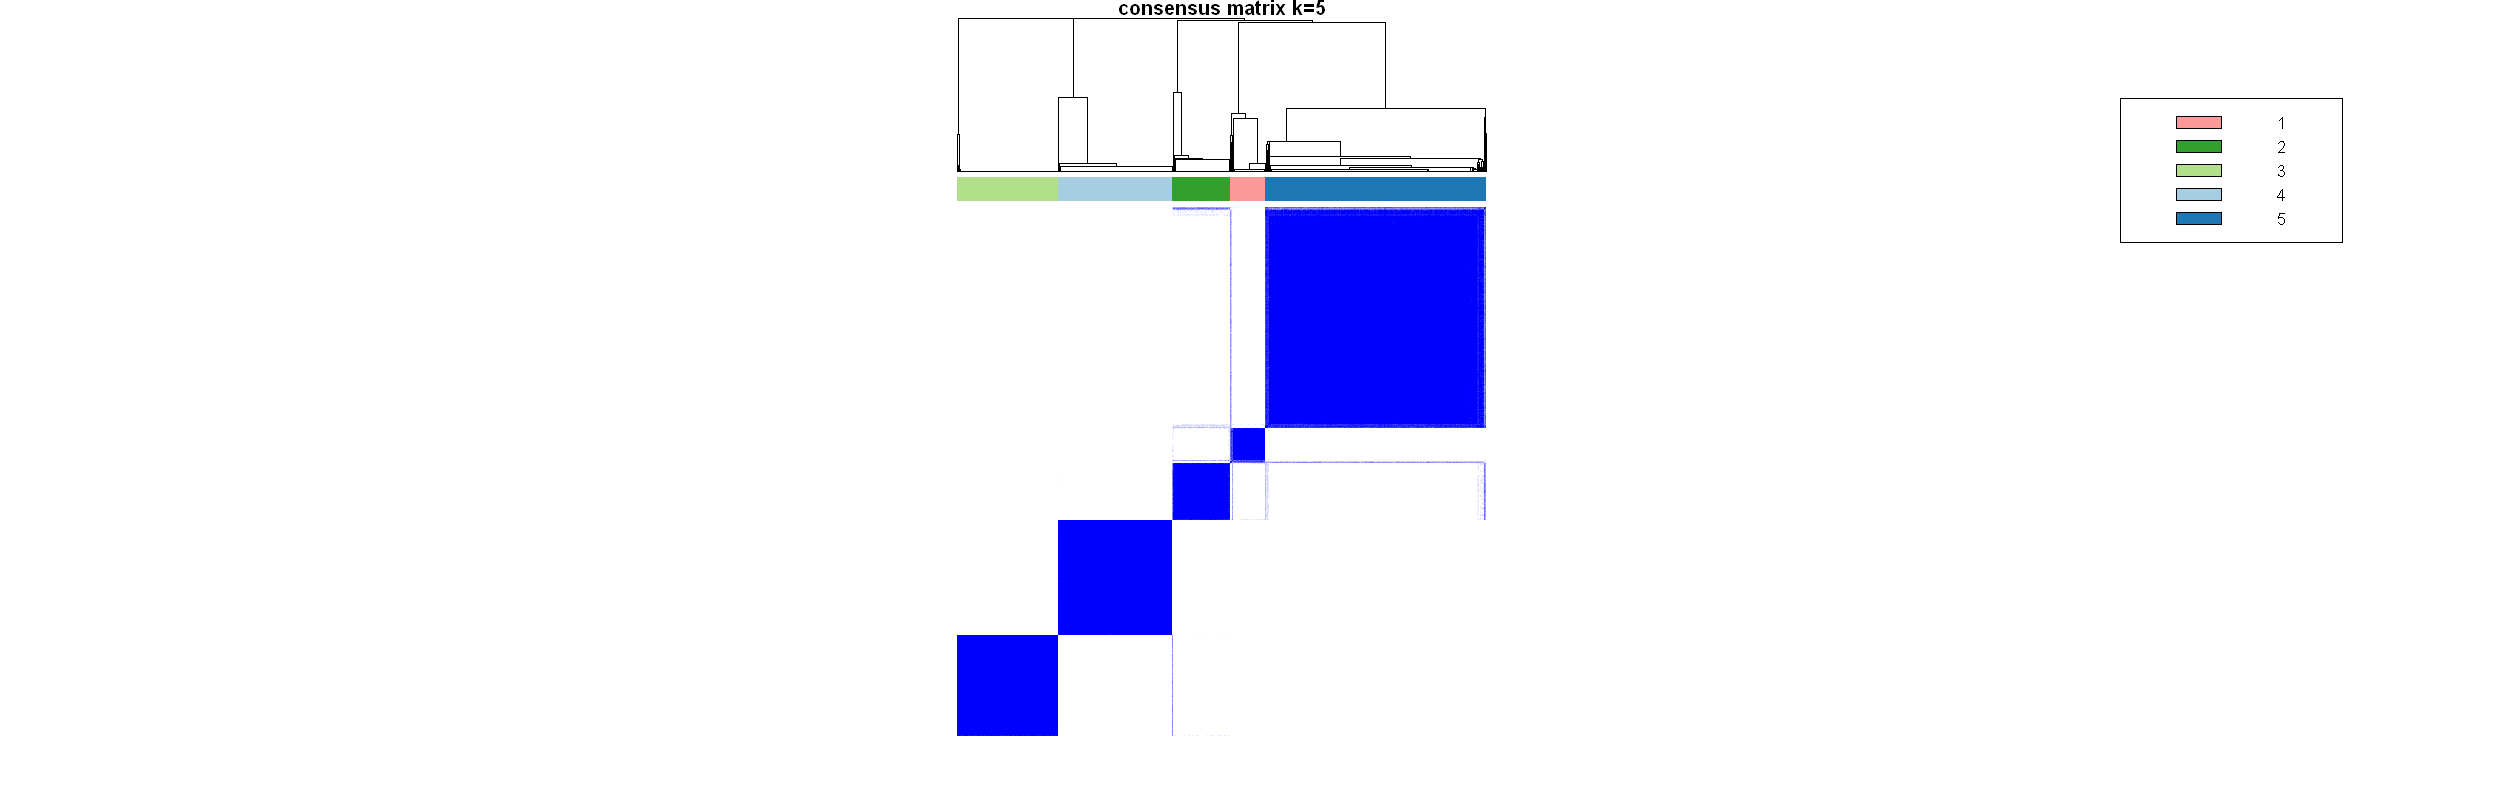

clustered



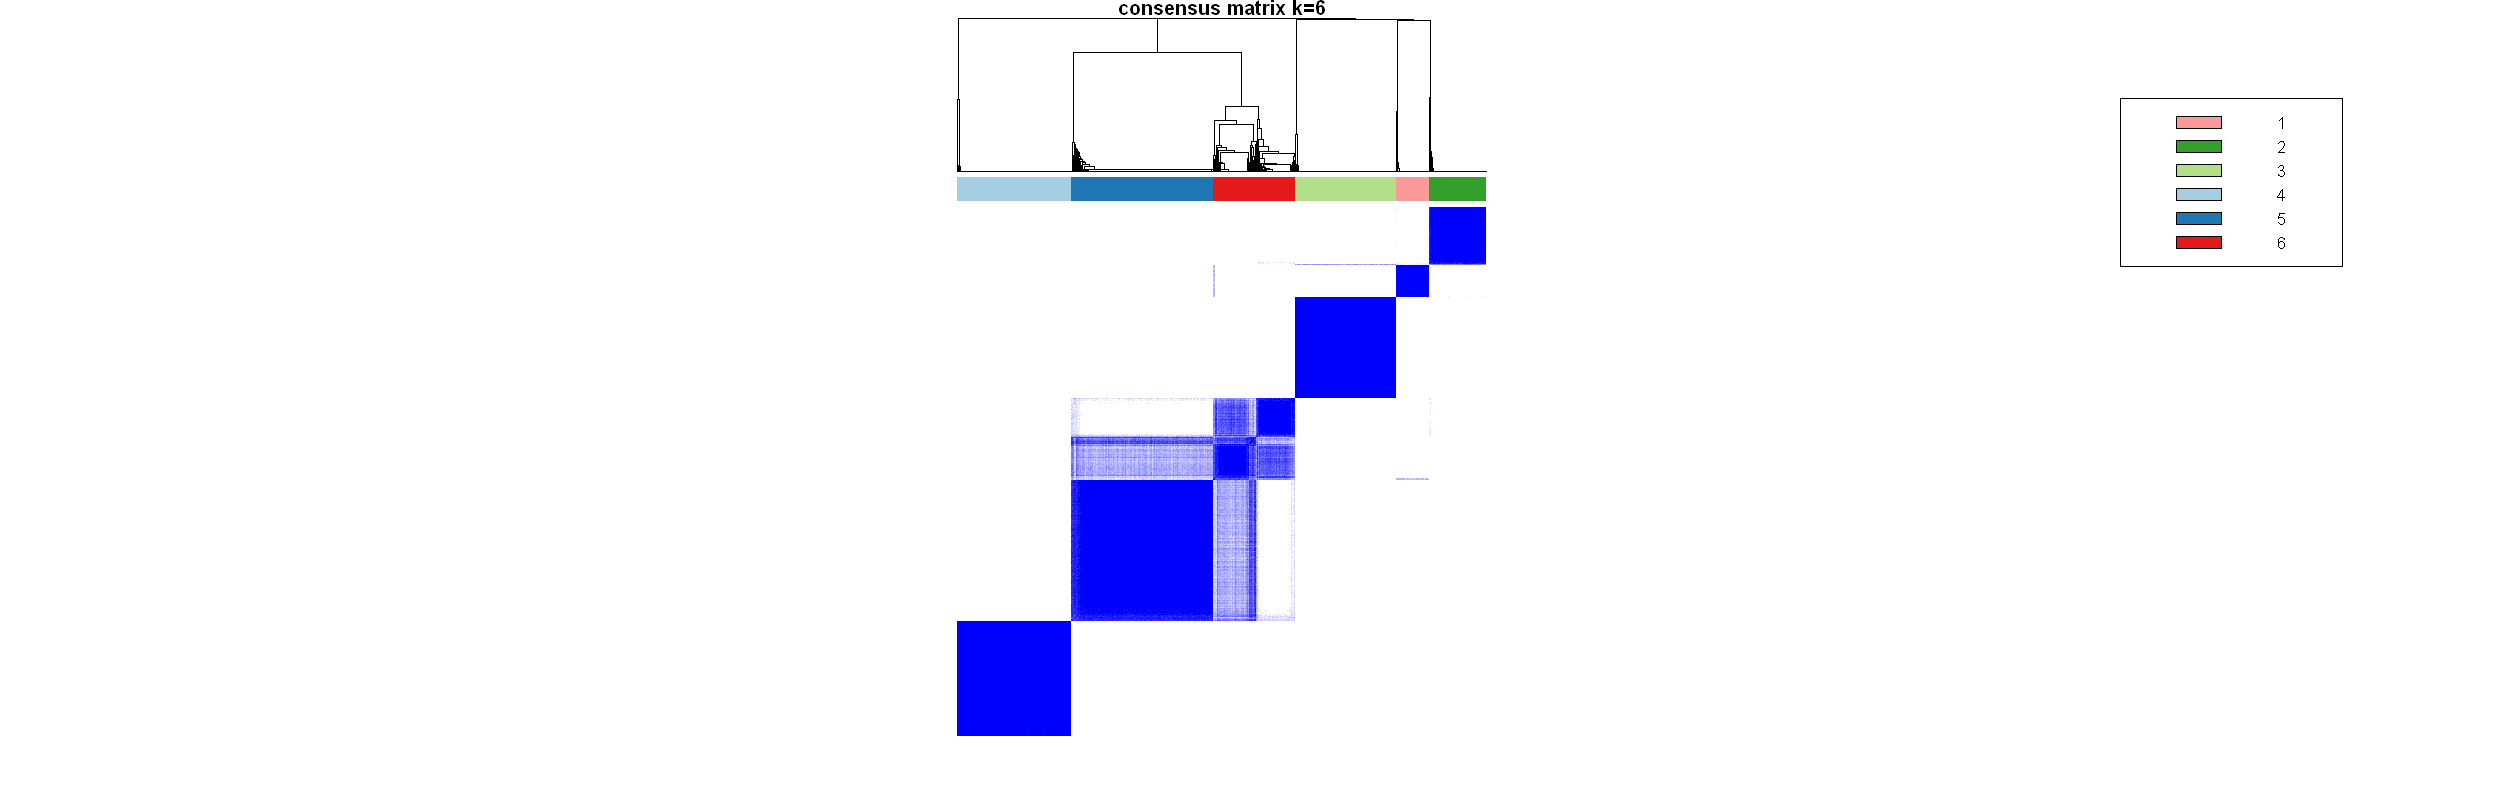

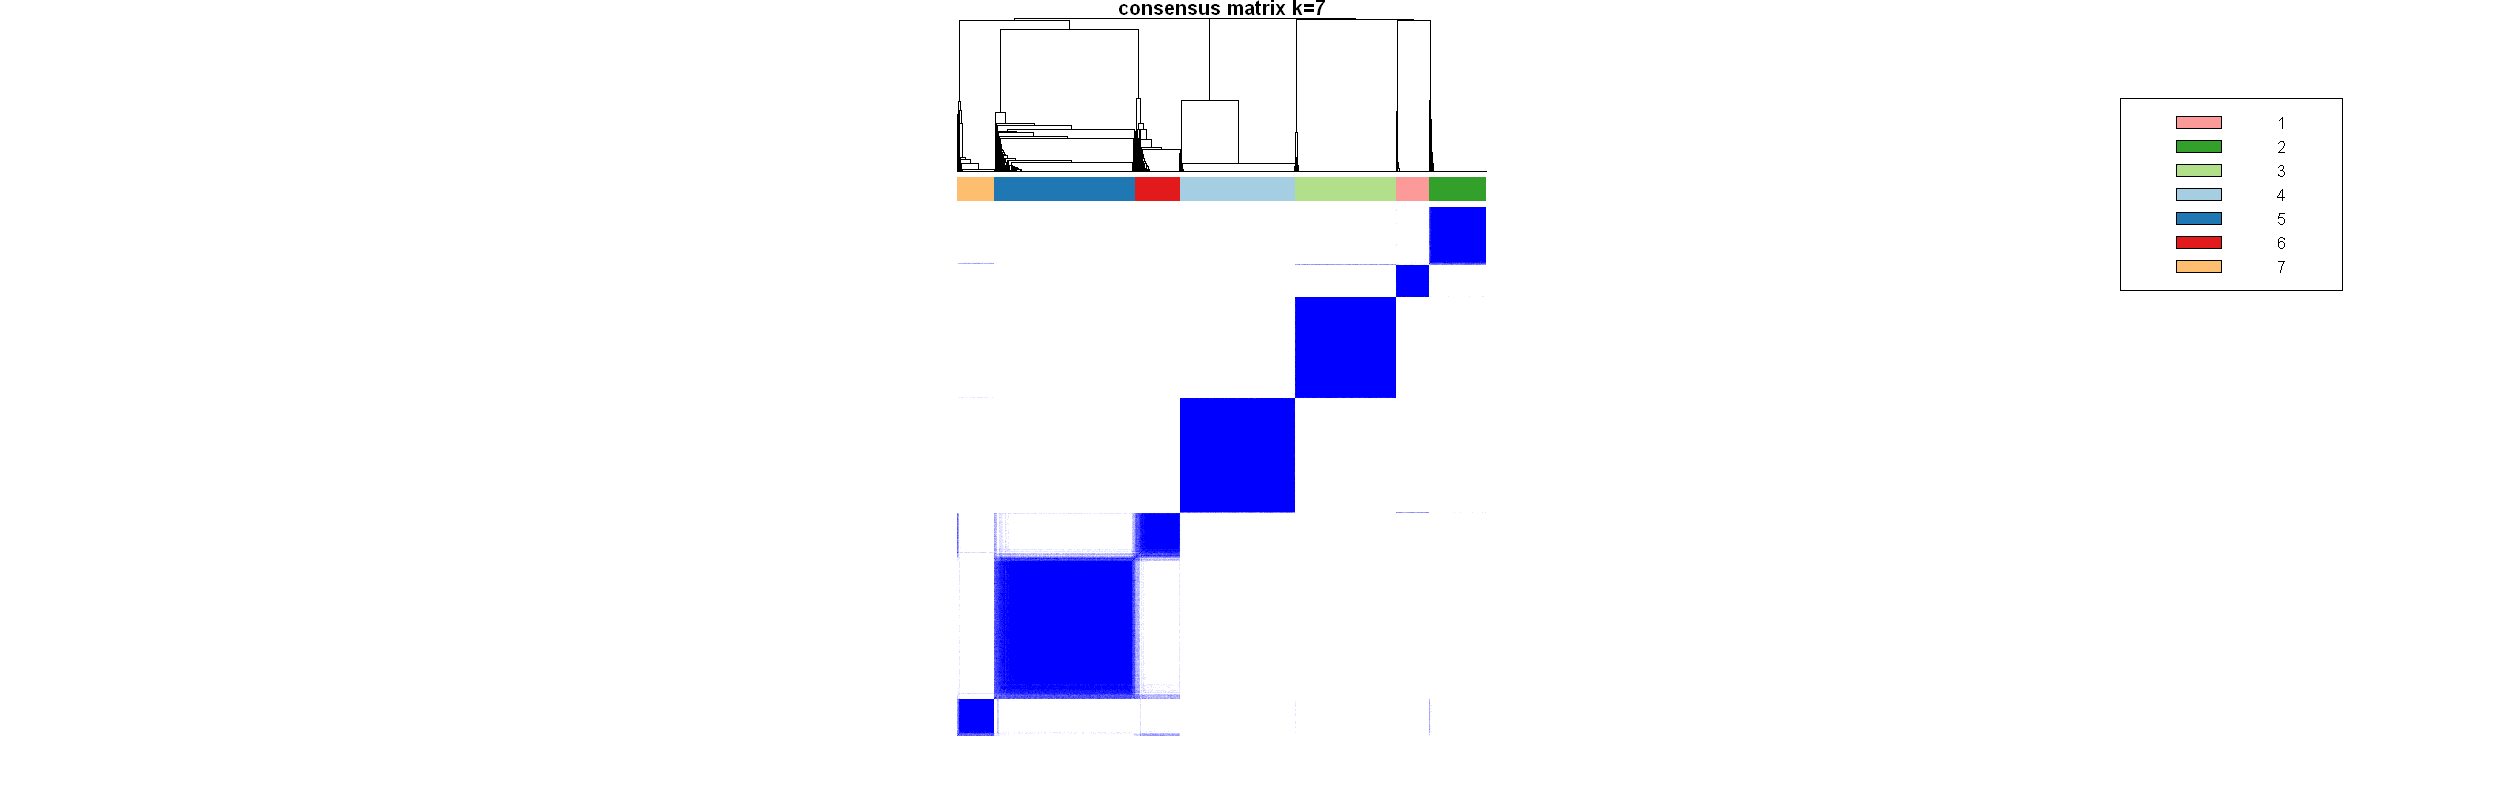

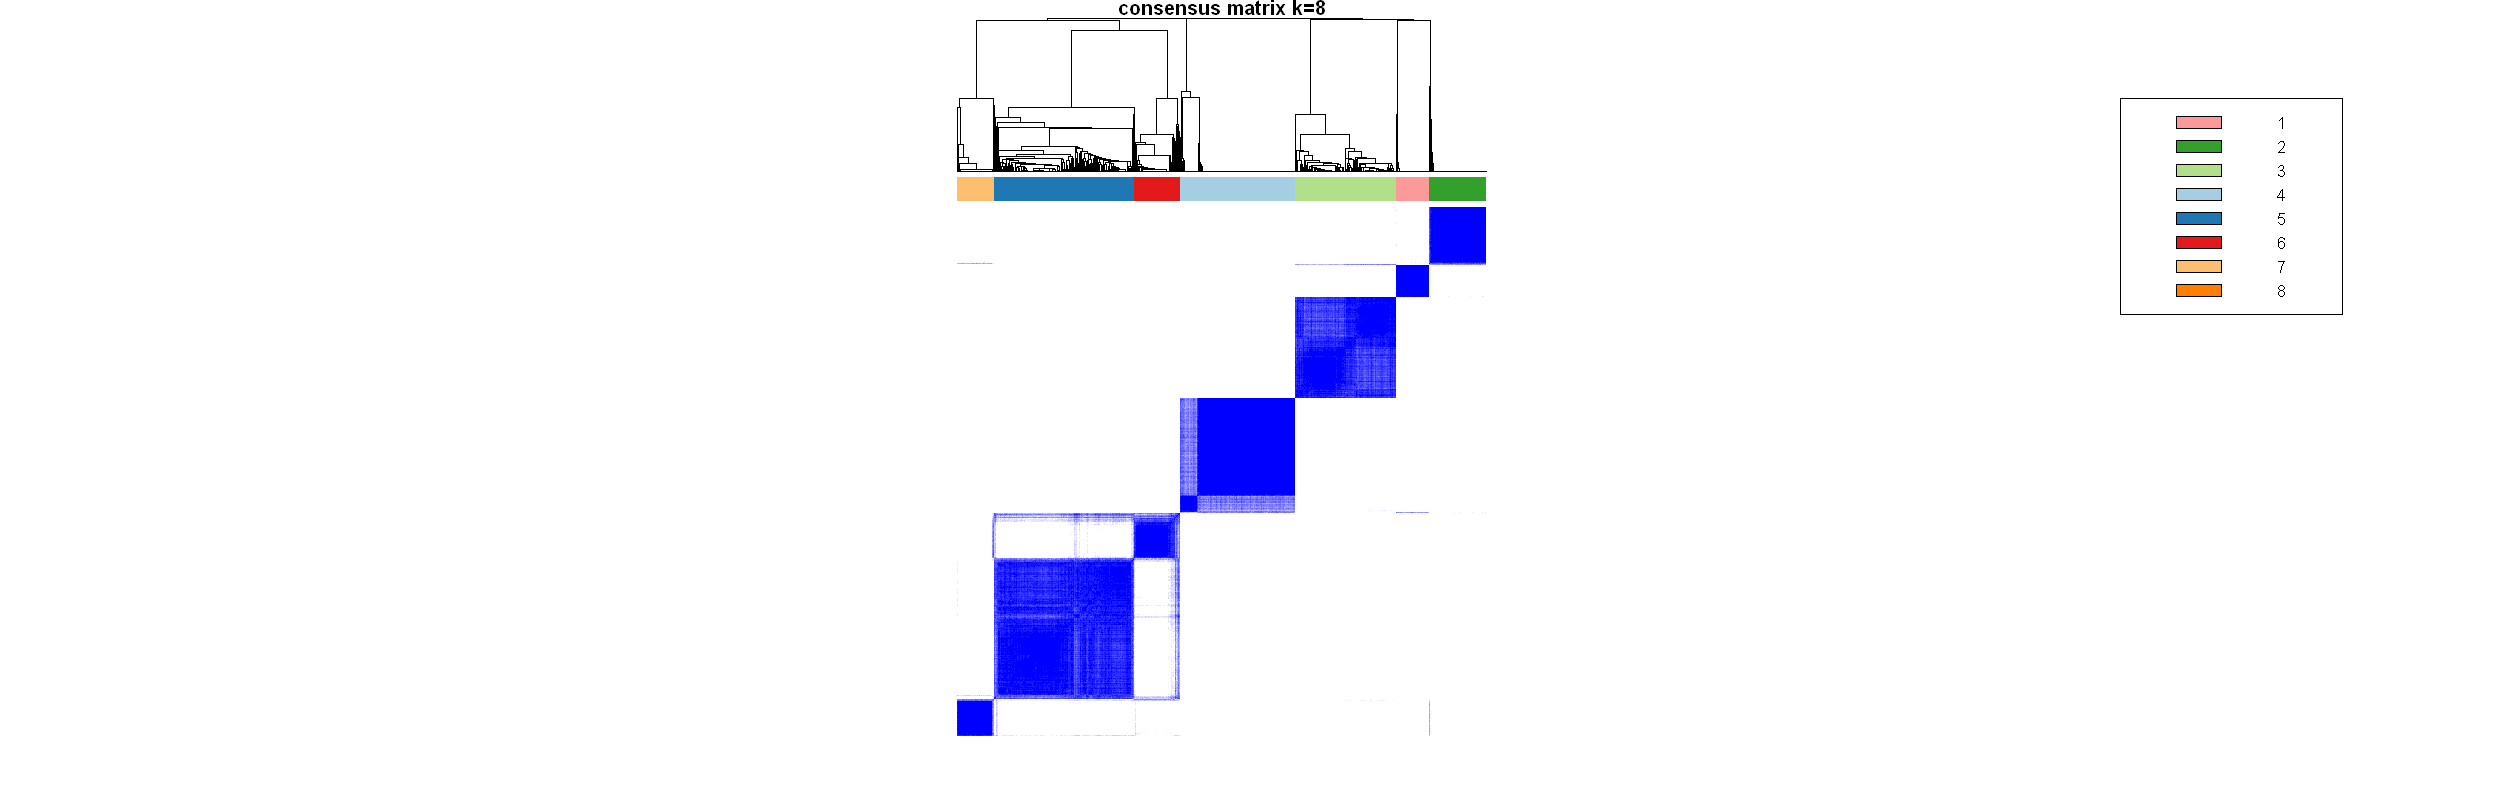

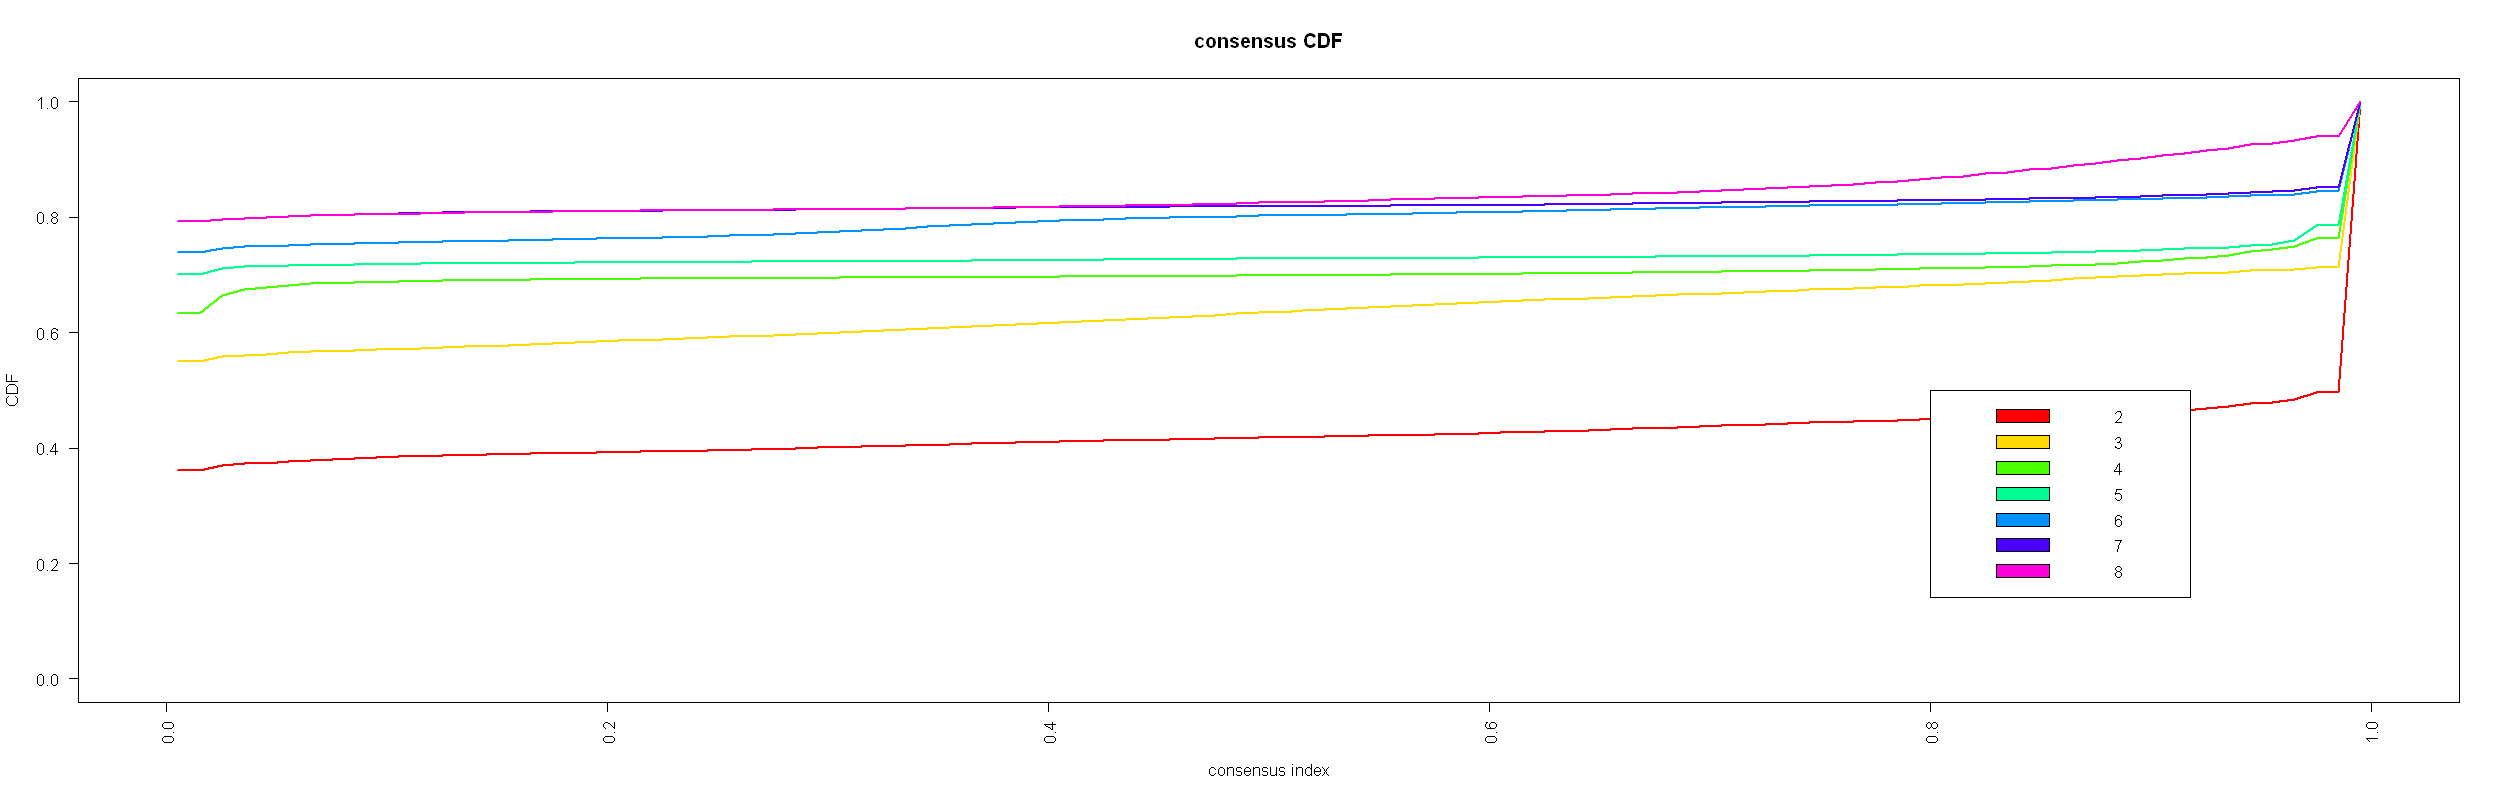

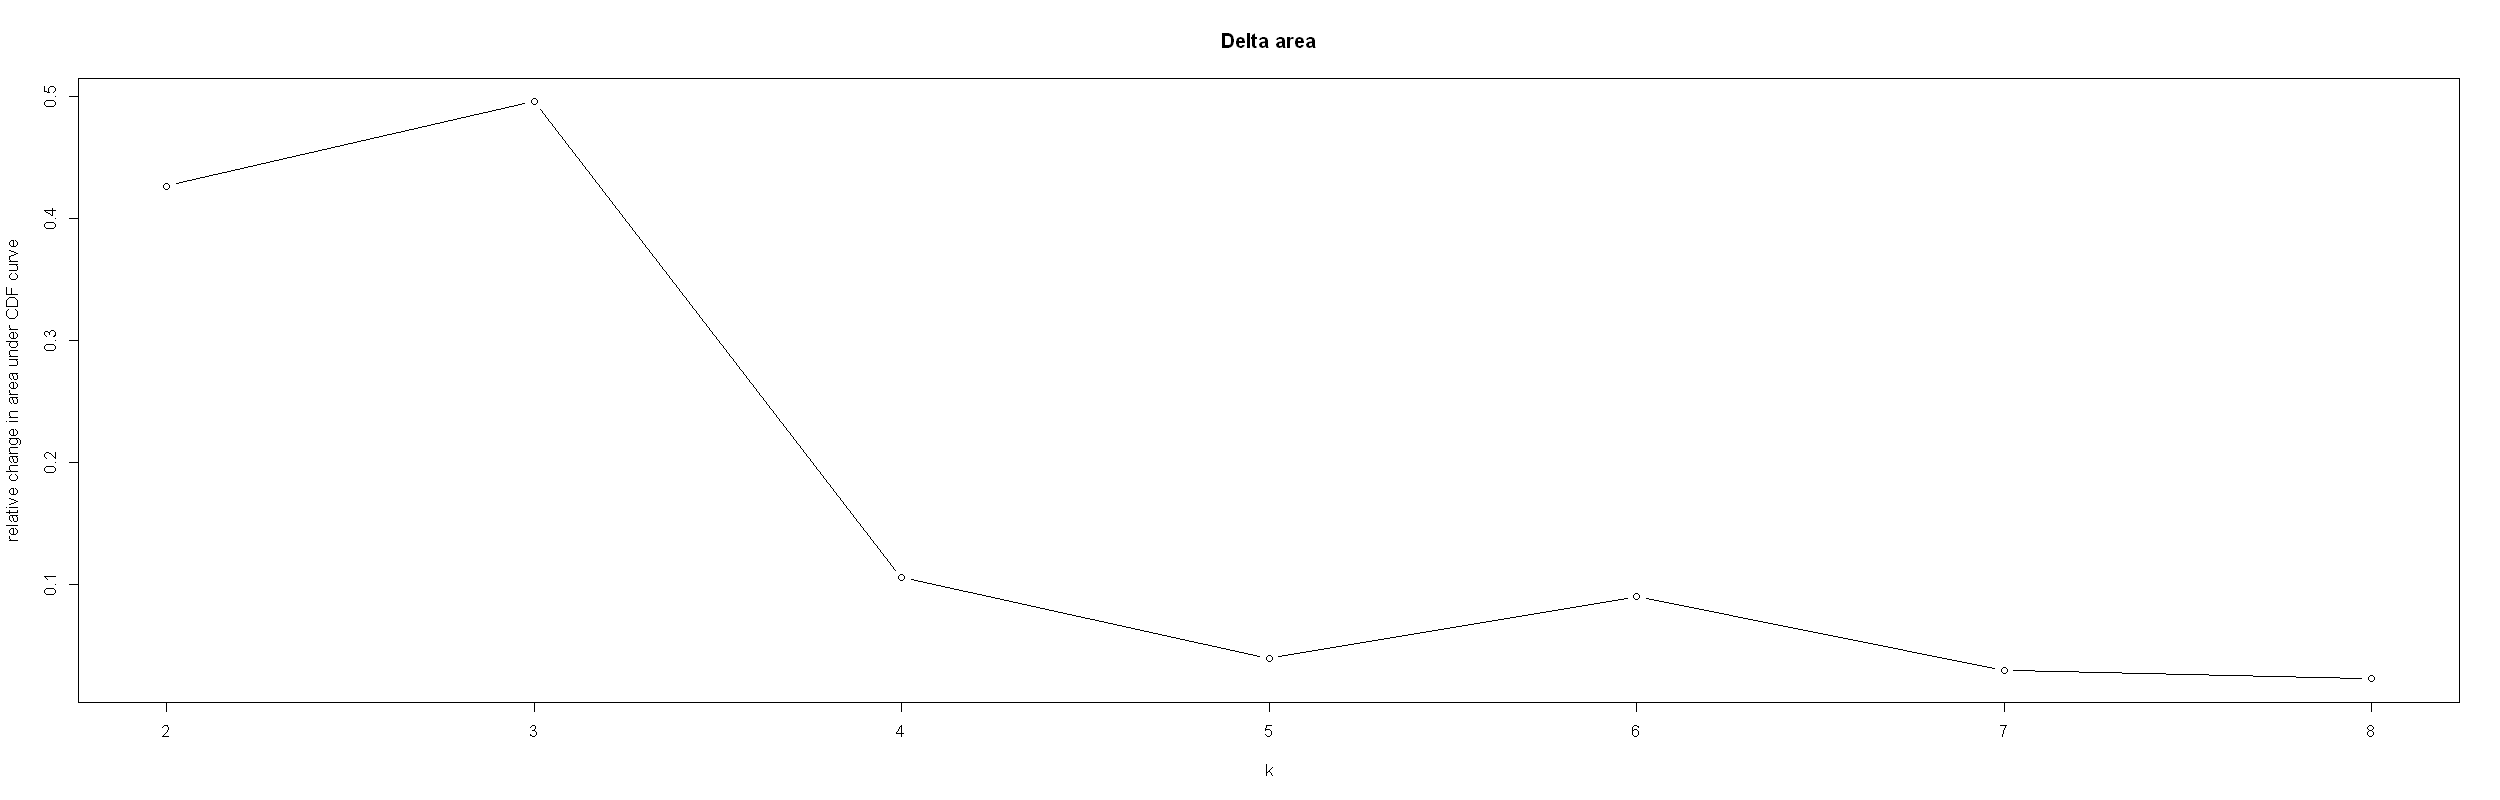

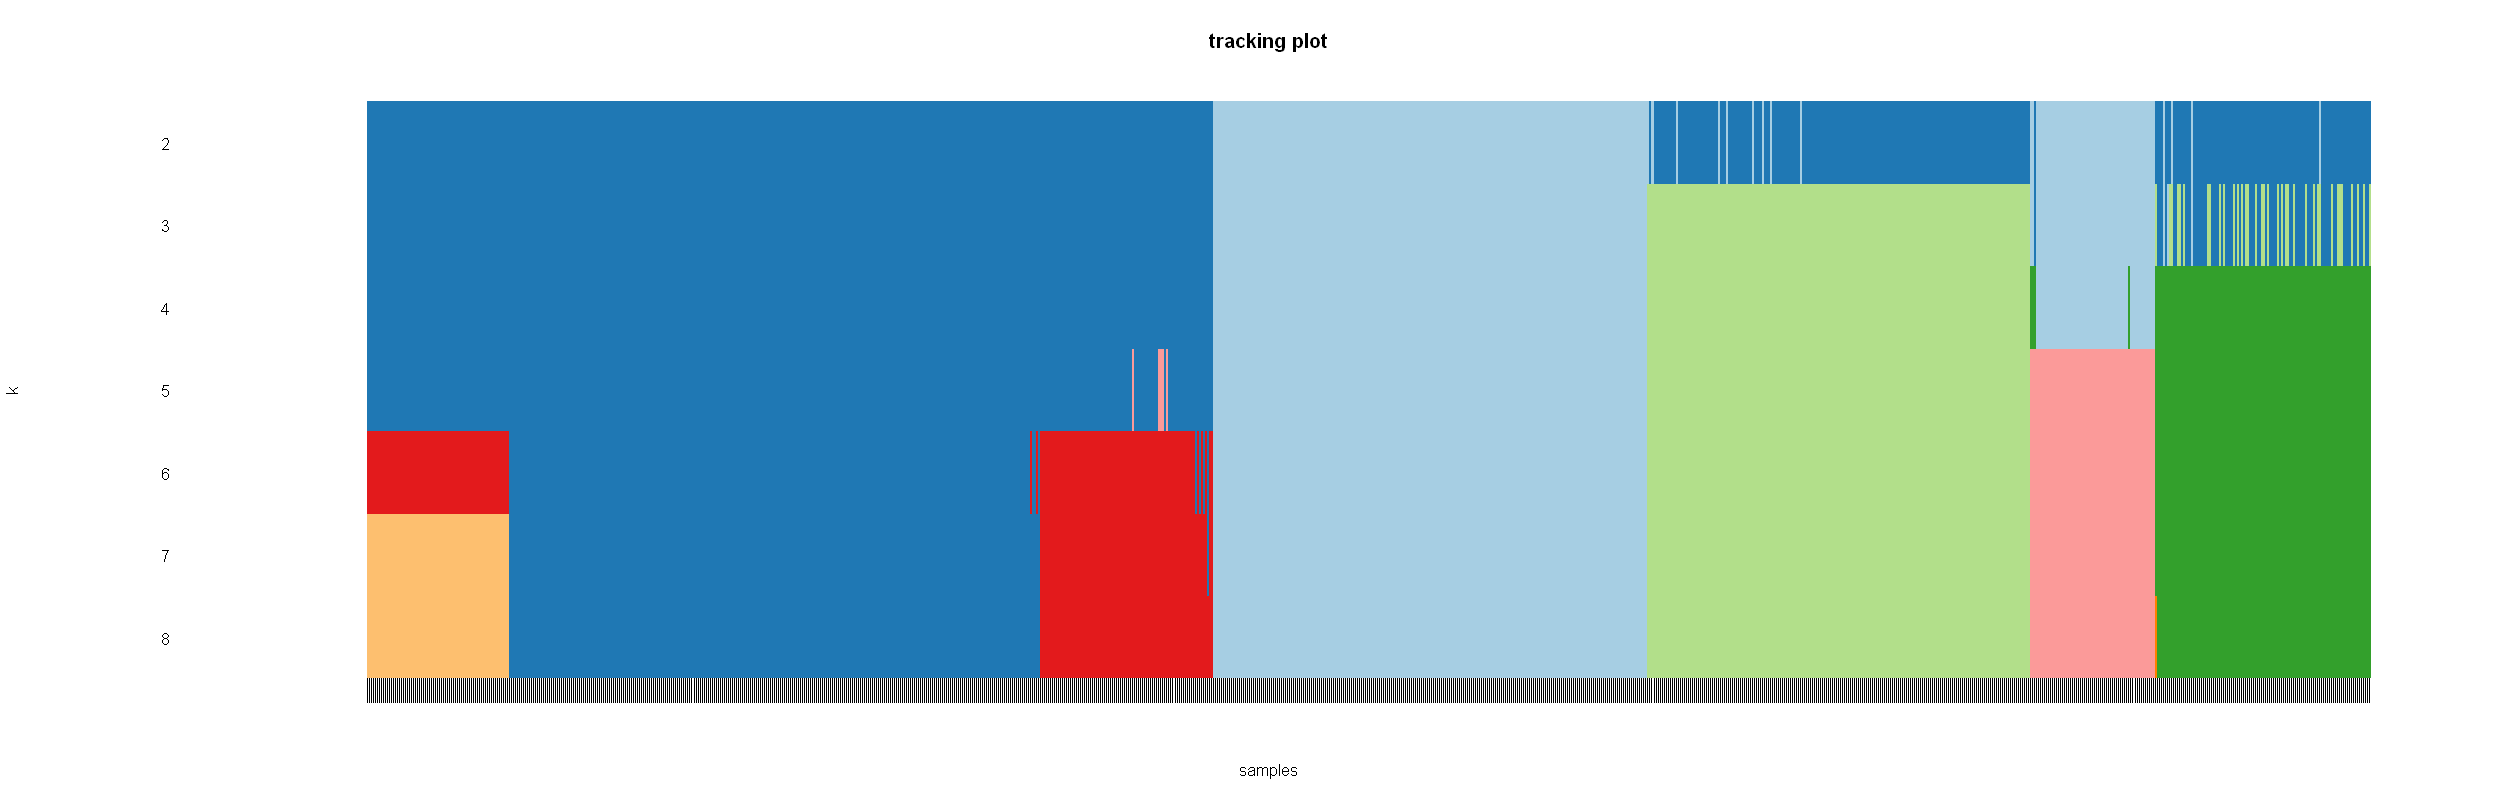

In [447]:
#BiocManager::install("ConsensusClusterPlus")
#browseVignettes("ConsensusClusterPlus")
# Cannot install directly to Rstudio depending on version - go via Bioconductor
library(ConsensusClusterPlus)
# this can be a bit slot depending on the number of features and observations!
ii<-sample(seq(1,2887),1000)
options(warn=-1)
cc<-ConsensusClusterPlus(as.matrix(t(TCGA[ii,guse[1:500]])),maxK=8,reps=100,pItem=.6,pFeature=.6,
                         clusterAlg="pam")
options(warn=0)

ConsensusClusterPlus outputs the consensusmatrices for your selected range of number of clusters. It also provides the empirical cdf of the consensusmatrices that helps you assess what a reasonable number of clusters may be.

Let's have a look at one of the outputs. Do the consensus cluster overlap with the classes?

In [442]:
ccu<-cc[[3]]
mda::confusion(ccu$consensusClass,TCGAclassstr[ii])
ccu<-cc[[5]]
mda::confusion(ccu$consensusClass,TCGAclassstr[ii])
ccu<-cc[[6]]
mda::confusion(ccu$consensusClass,TCGAclassstr[ii])

         true
predicted GBM
        1  34
        2  64
        3   2

         true
predicted GBM
        1  33
        2  64
        3   1
        4   1
        5   1

         true
predicted GBM
        1  33
        2  39
        3  25
        4   1
        5   1
        6   1

In [446]:
length(cc[[5]]$consensusClass)

[1] 100

You see that by increasing the number of clusters we don't retrieve stable clusters for all the classes. 

Let's try a different clustering method, correlation based similarity and hierarchical clustering.

end fraction

clustered

clustered



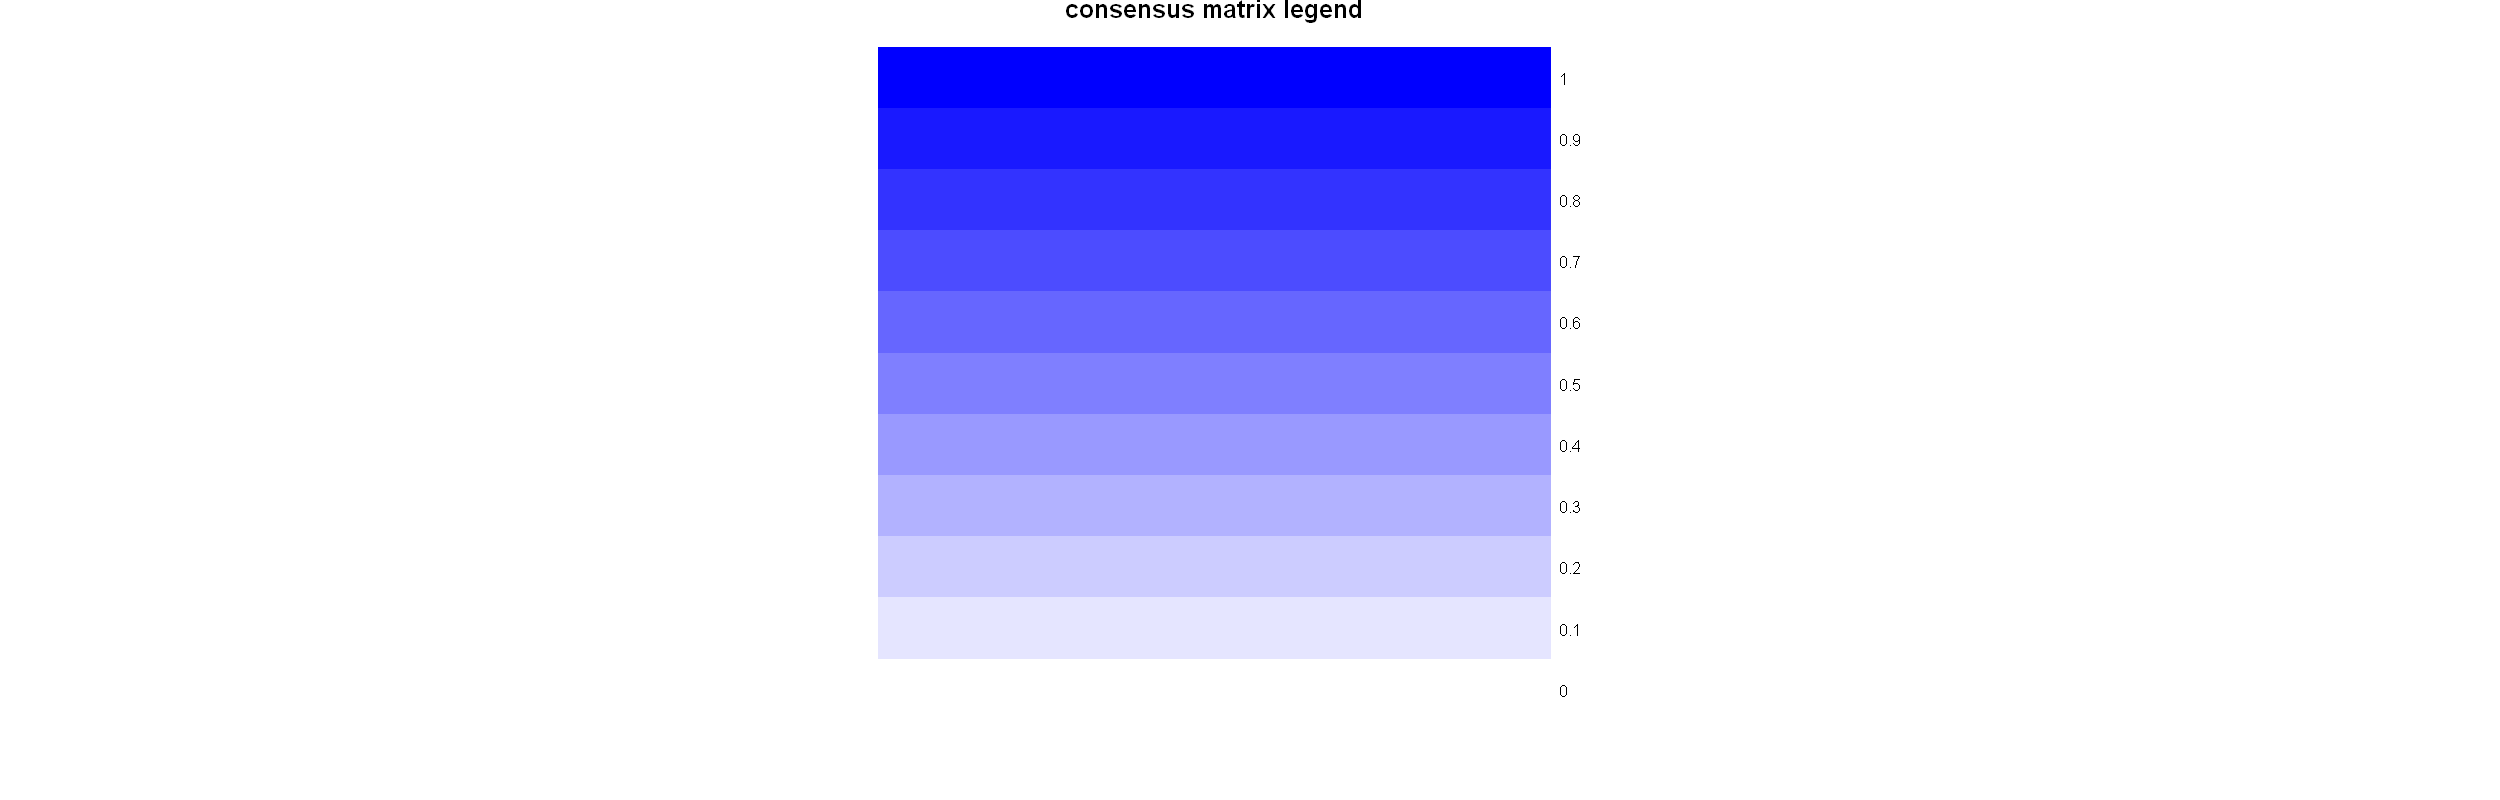

clustered



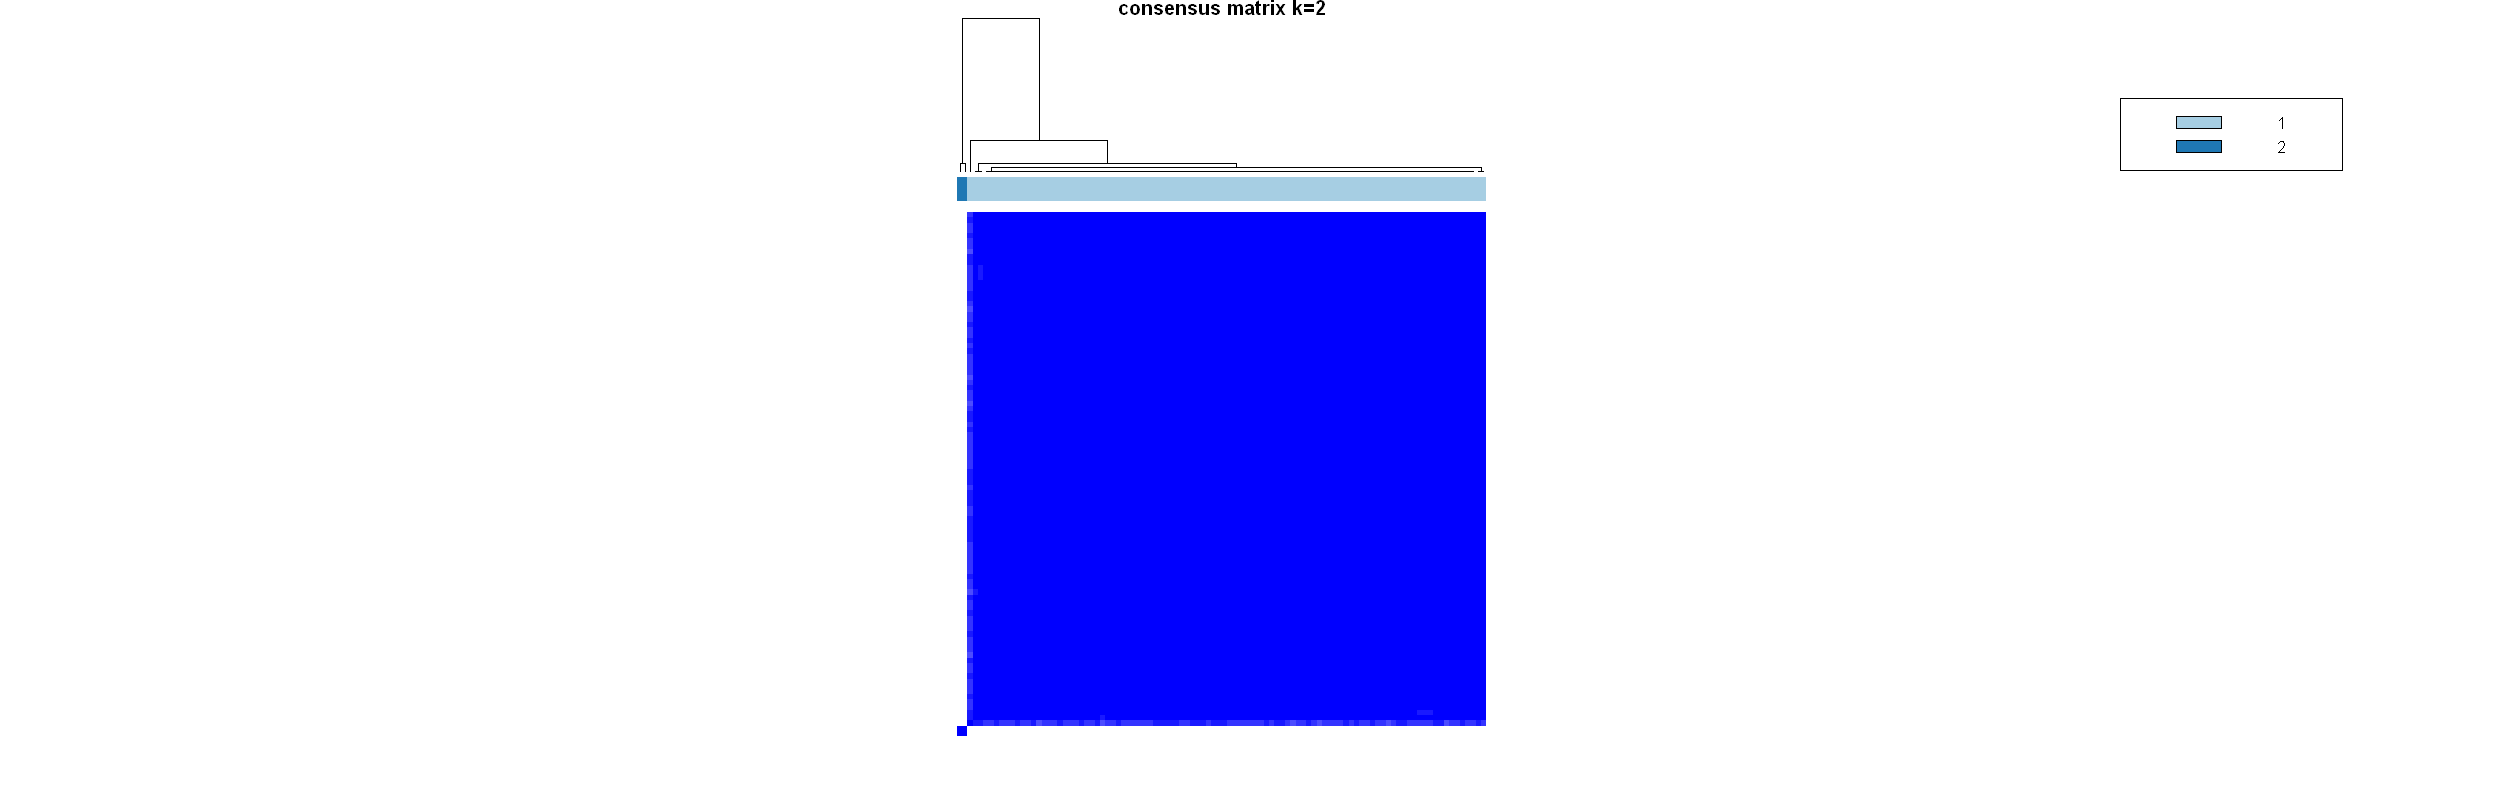

clustered



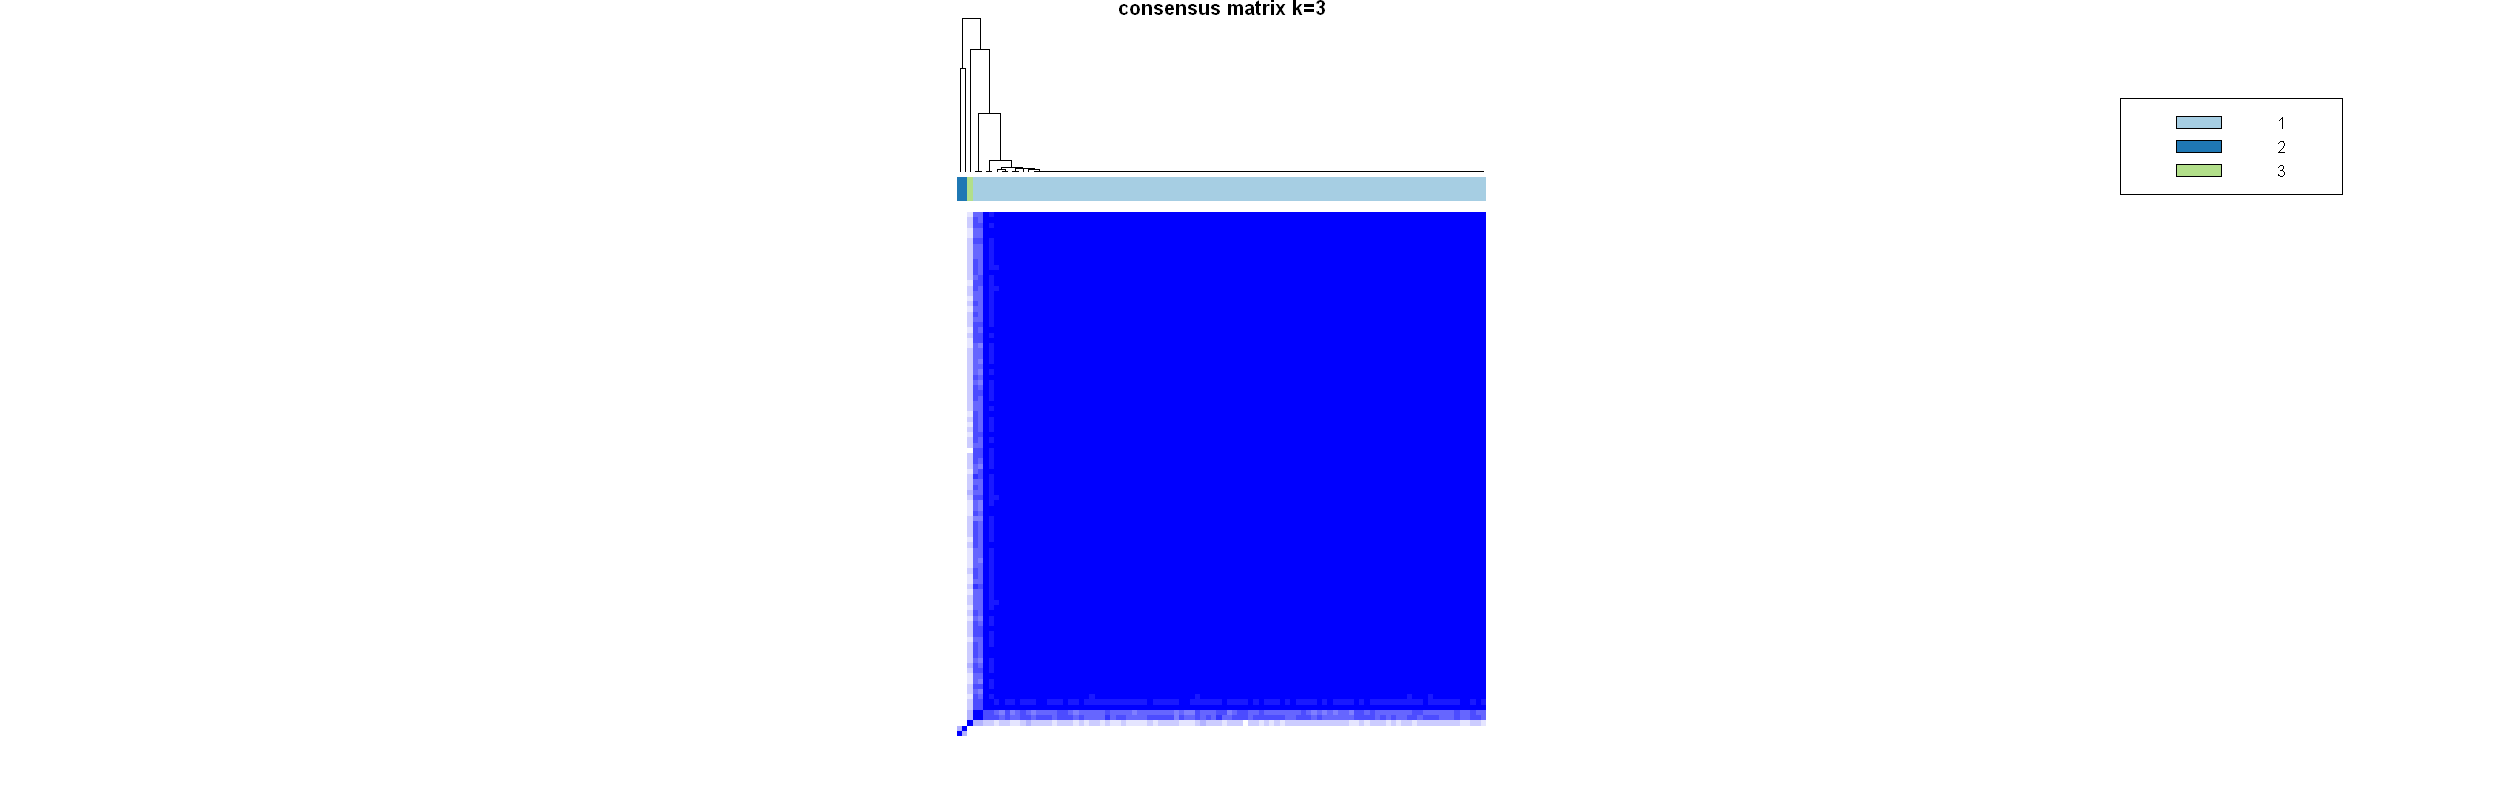

clustered



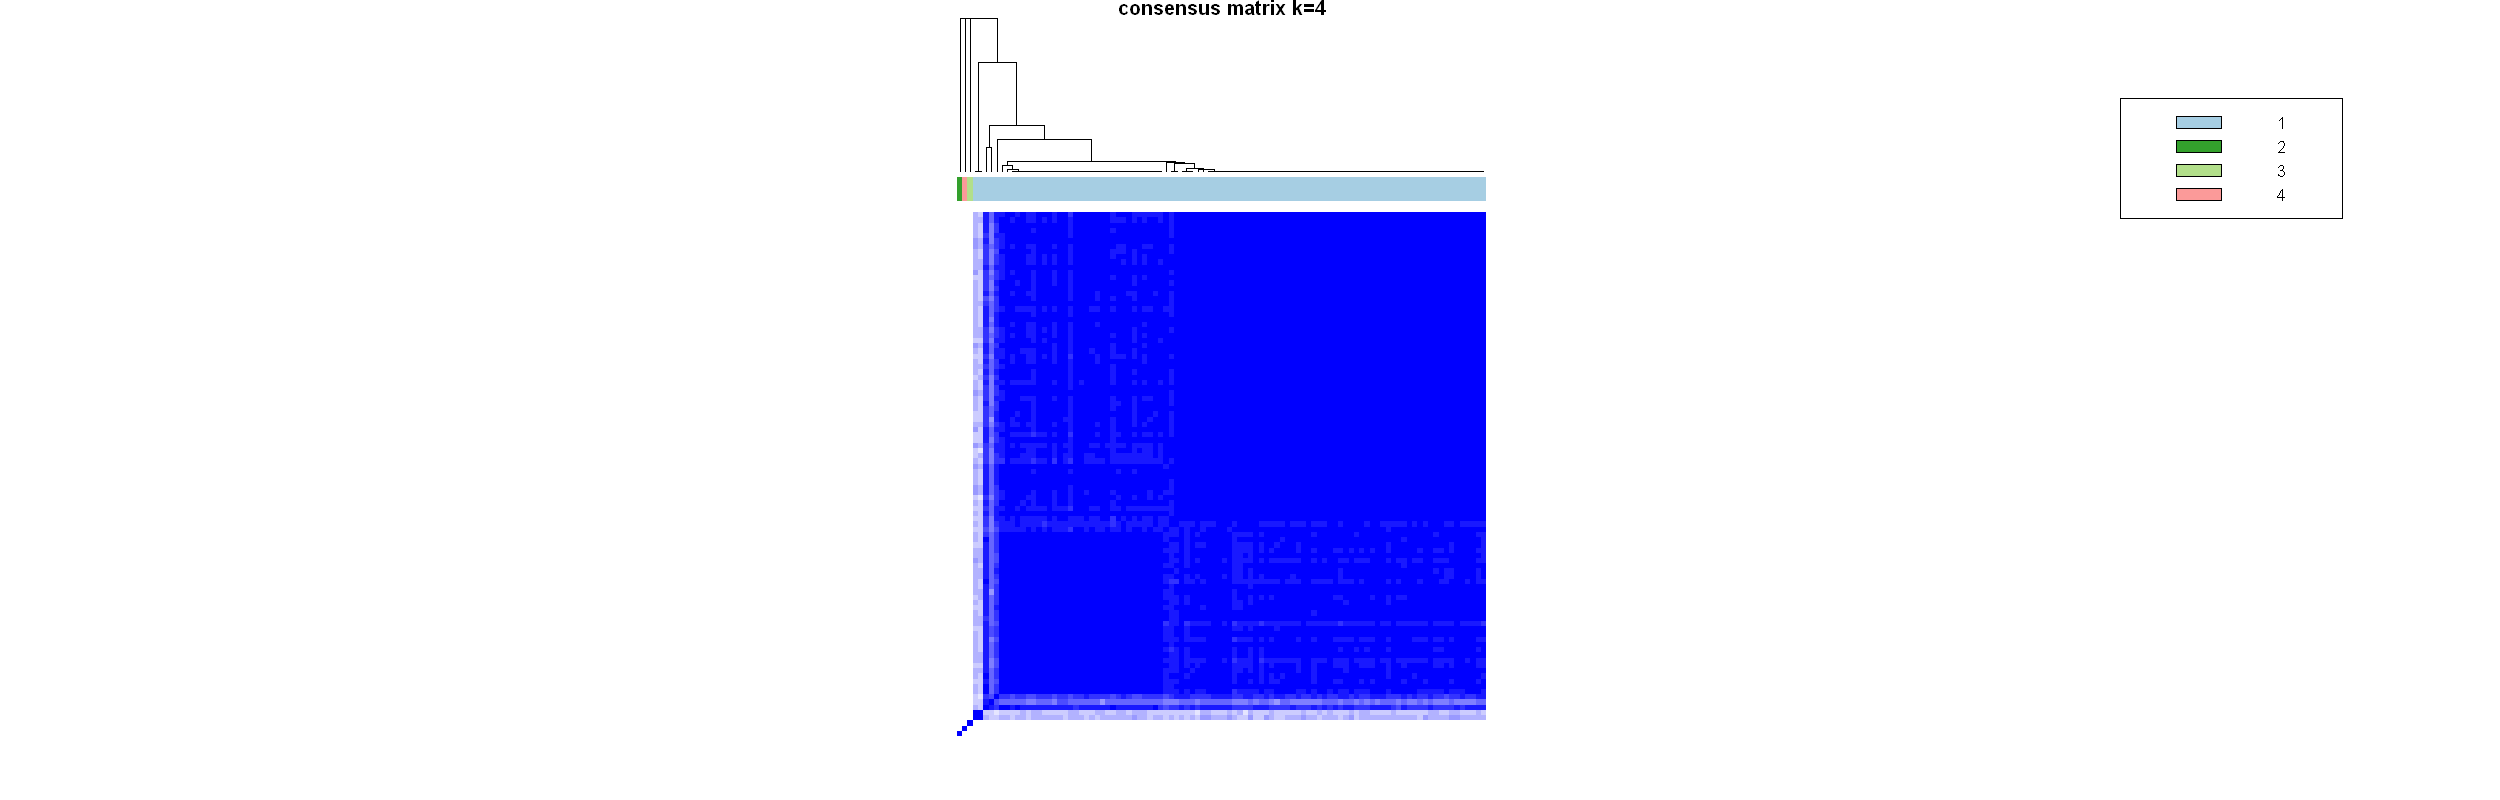

clustered



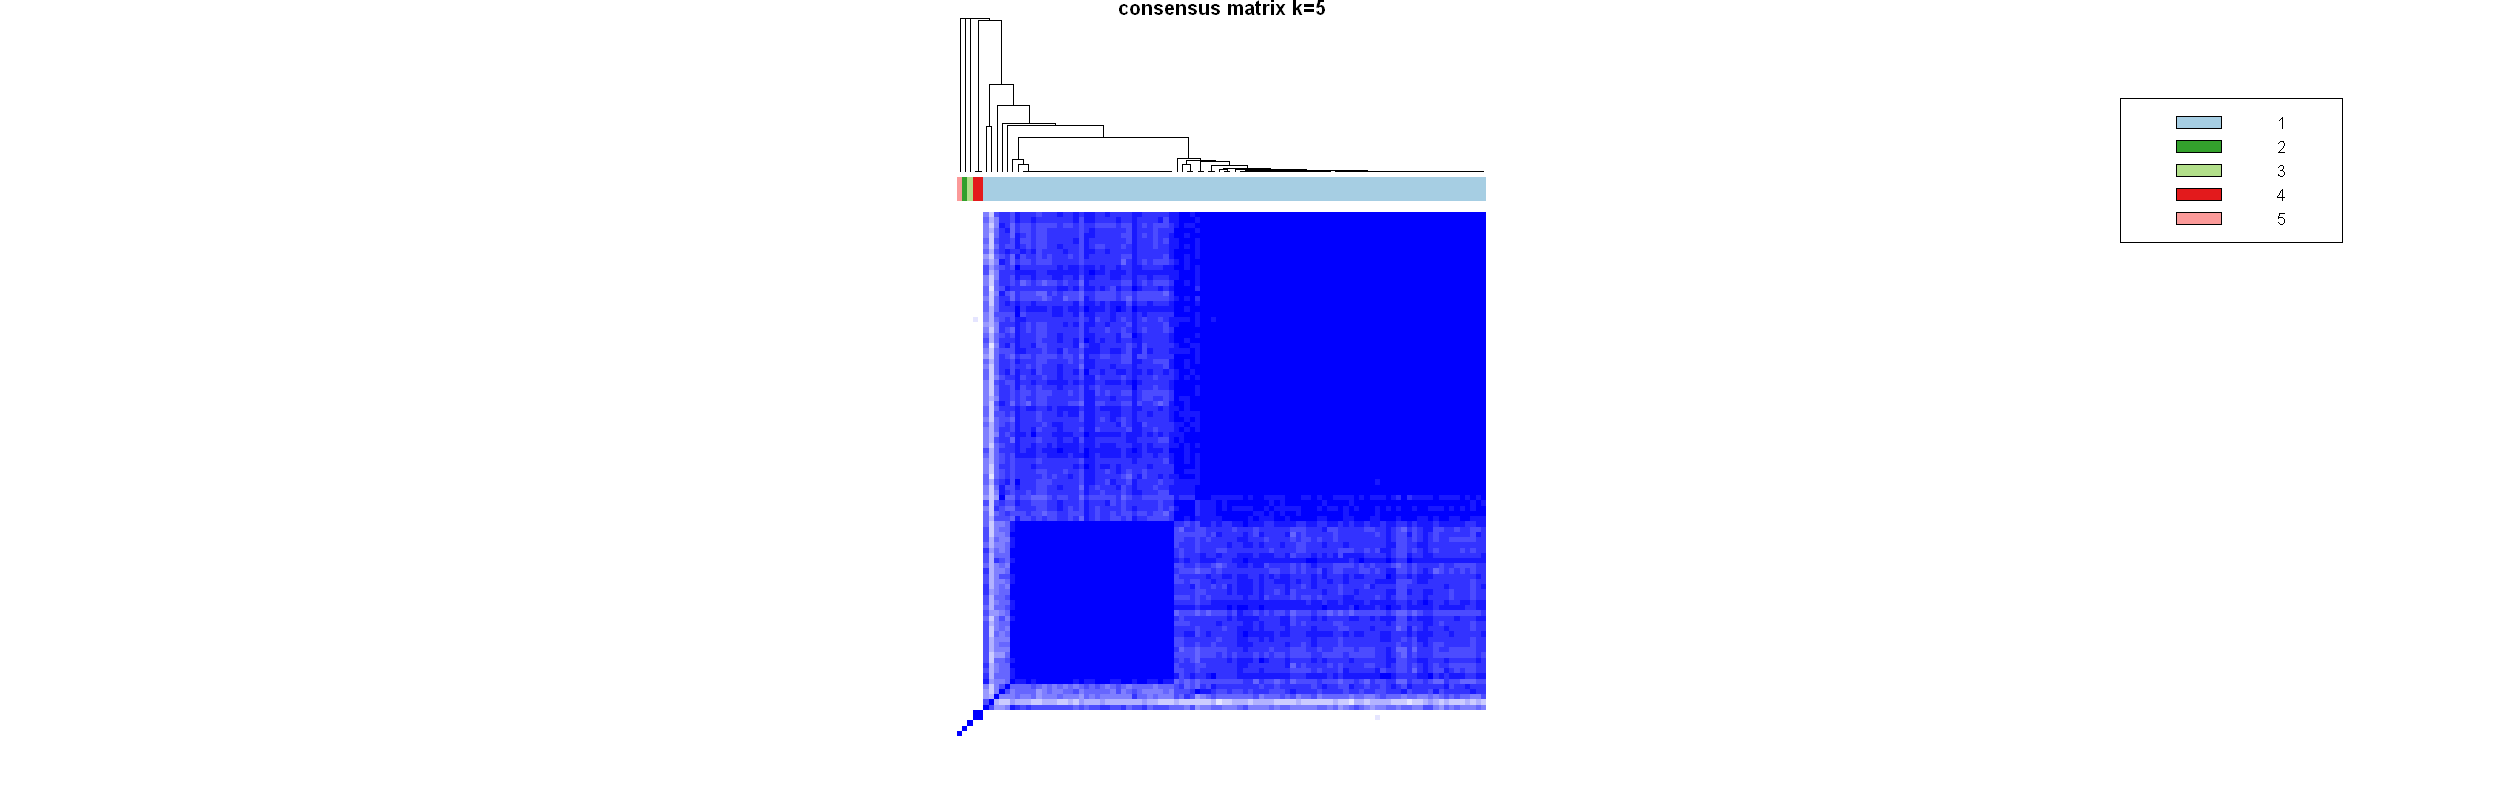

clustered



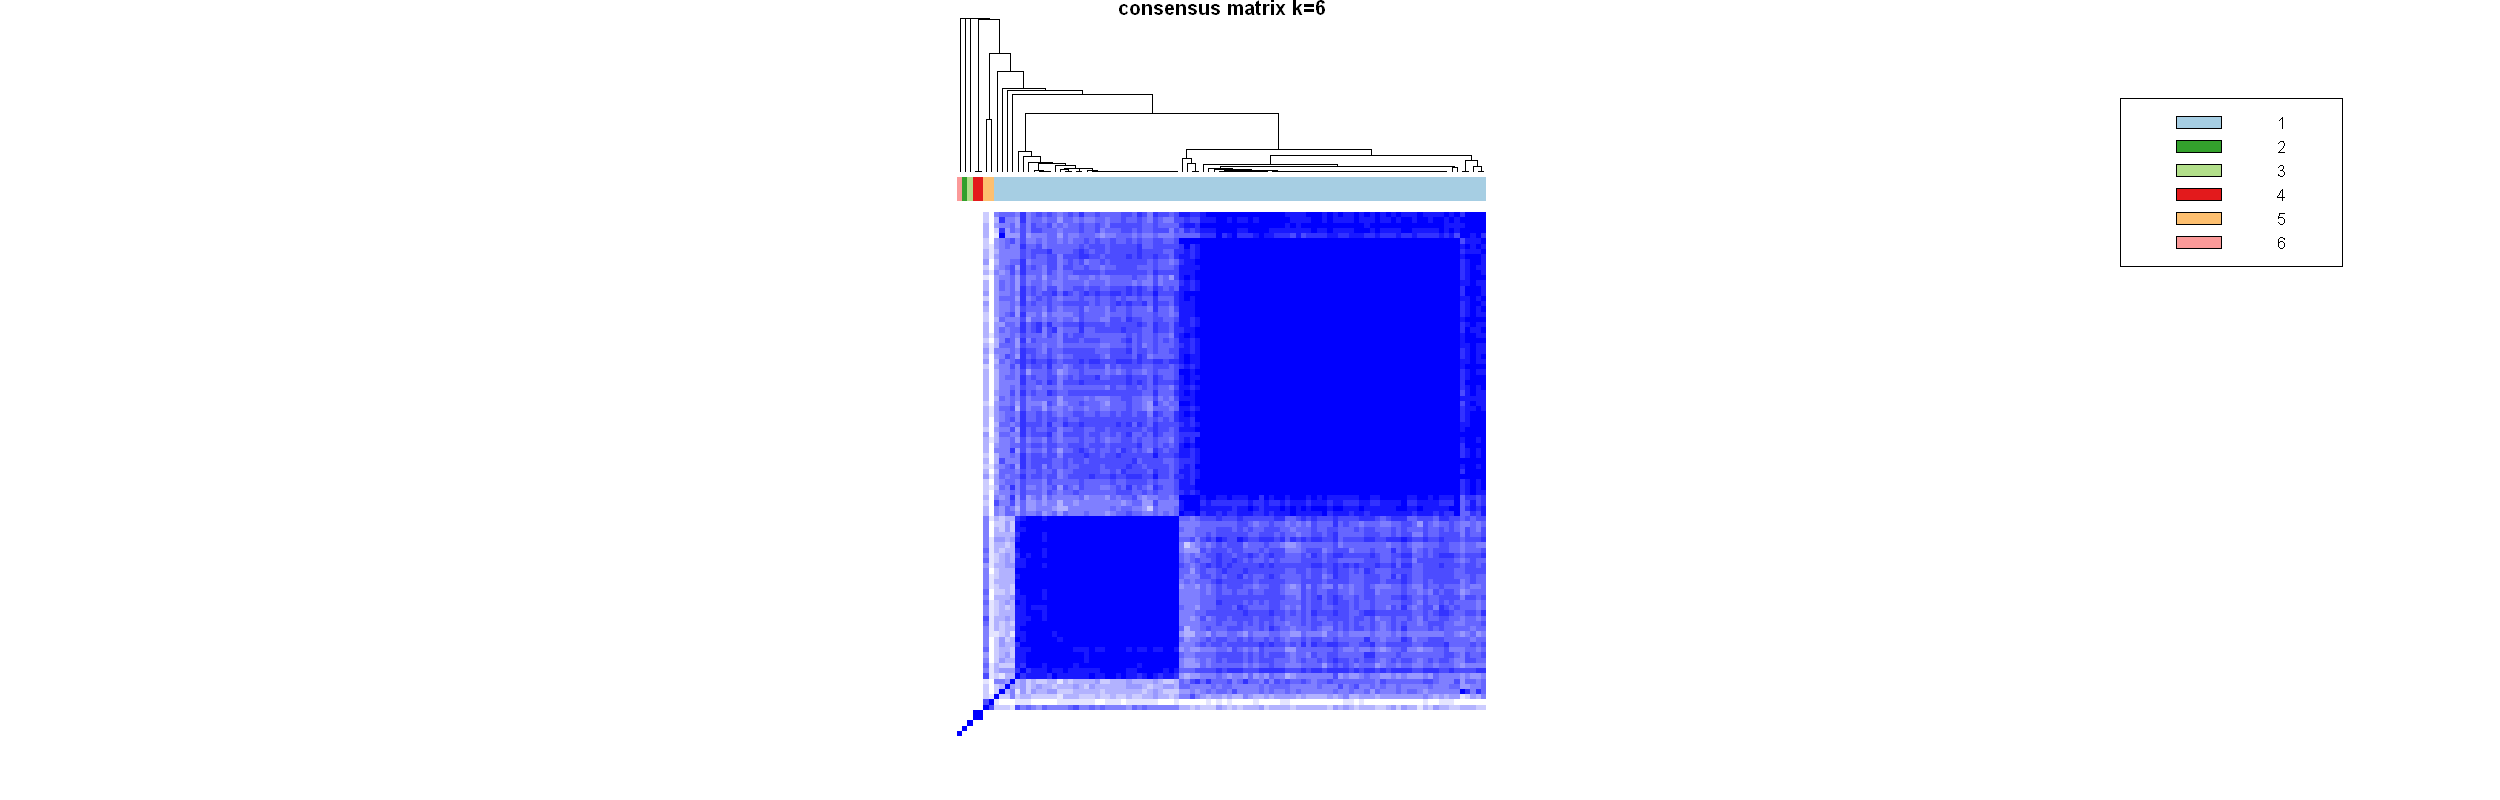

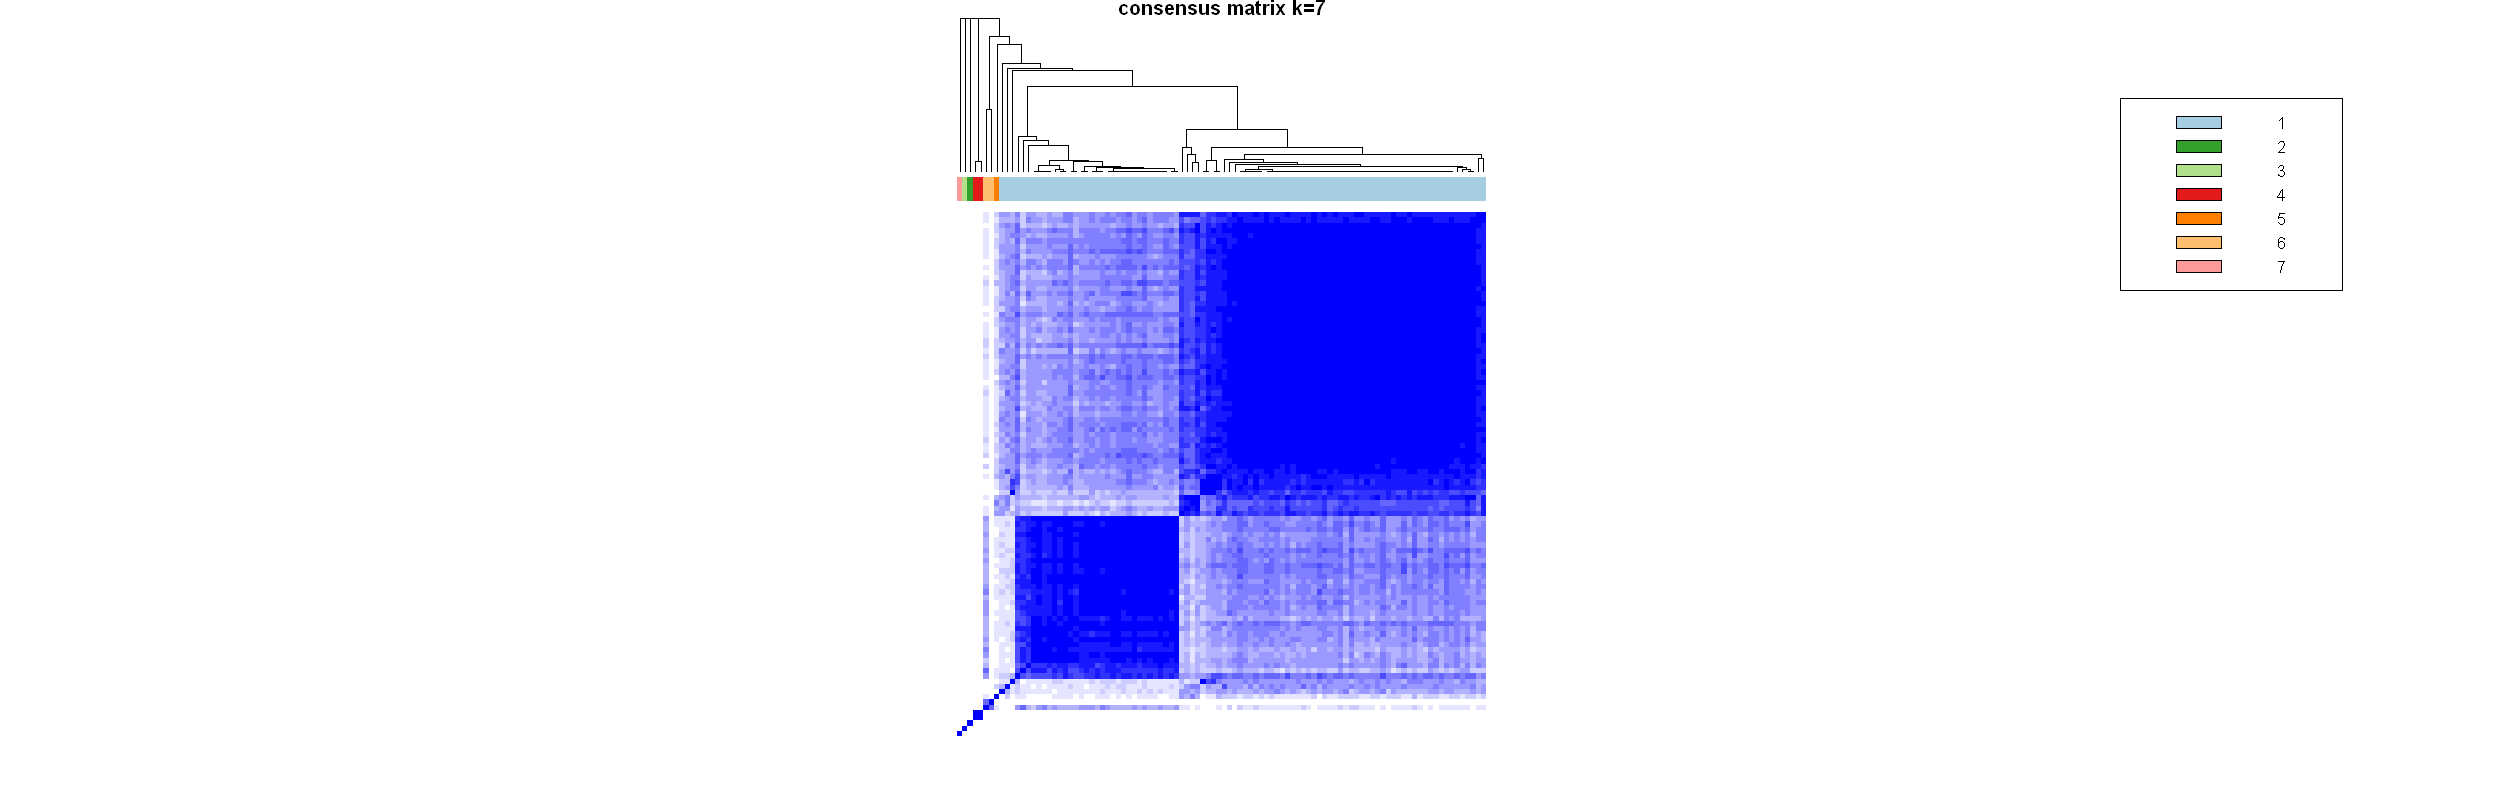

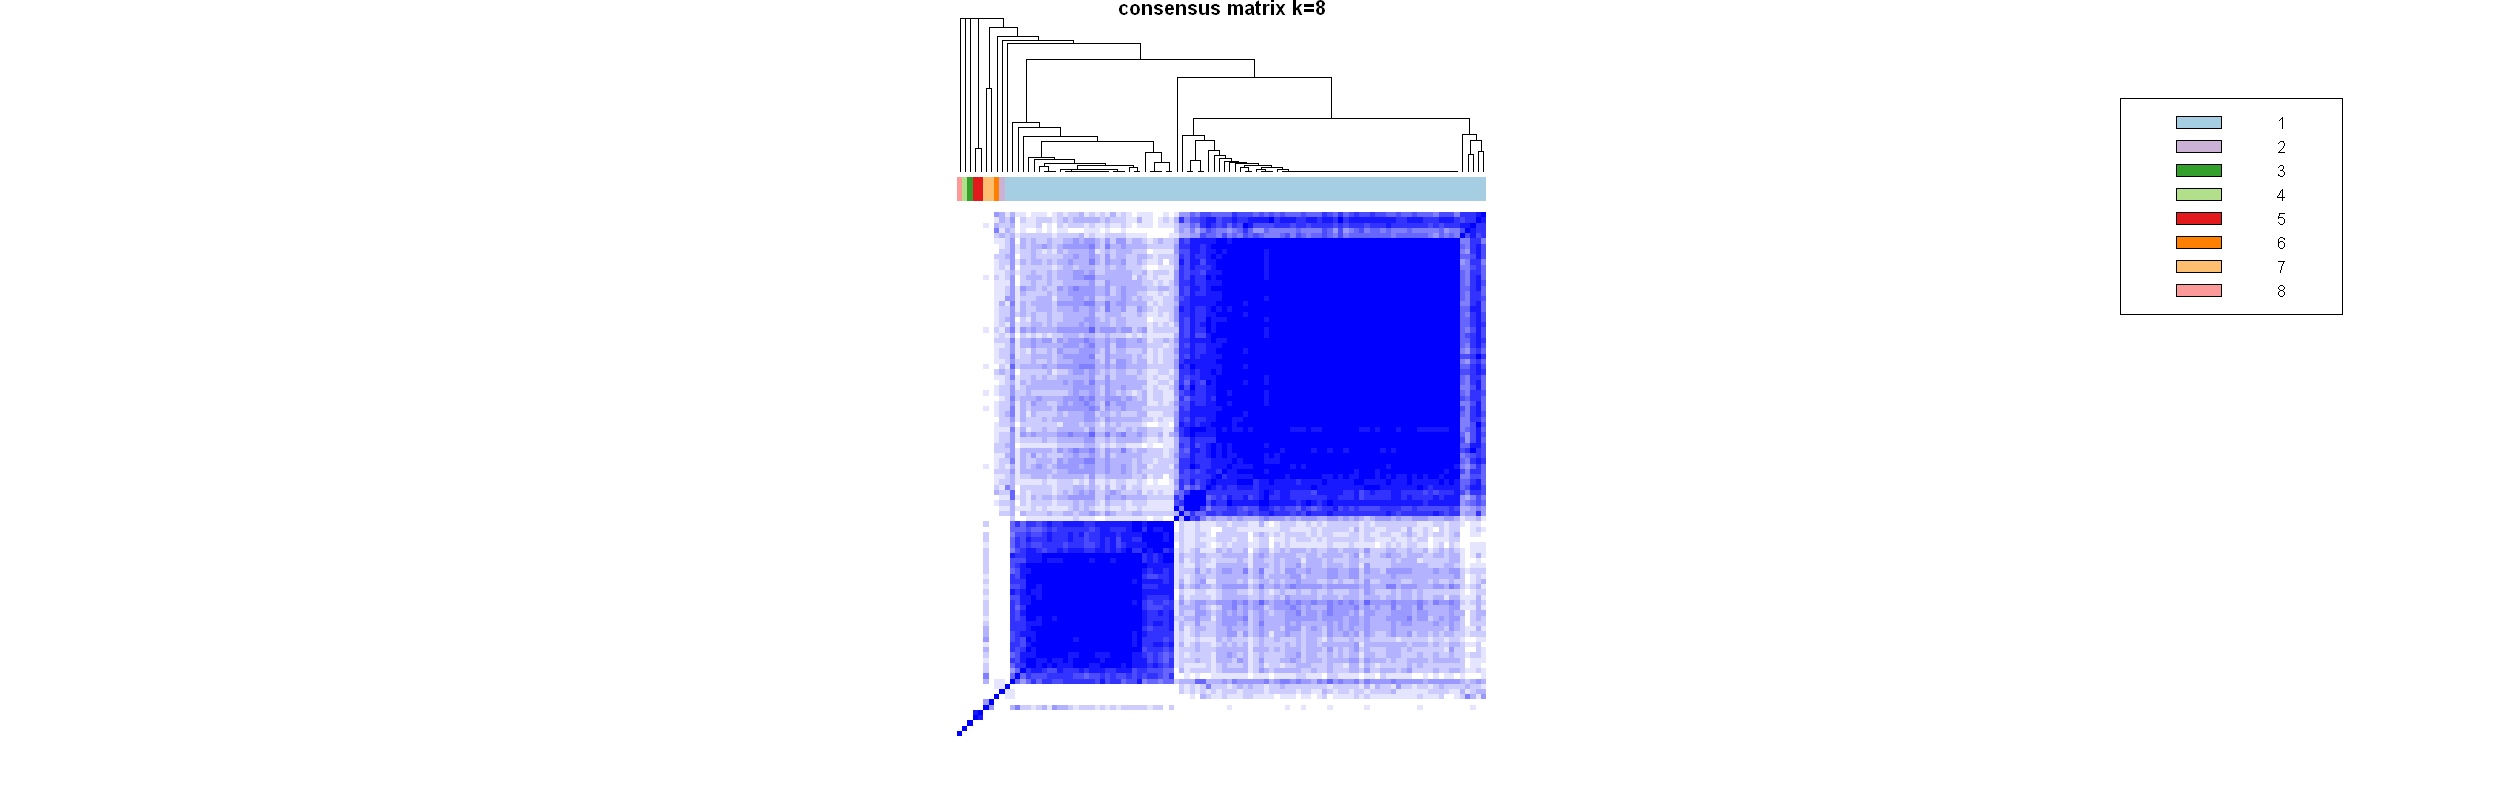

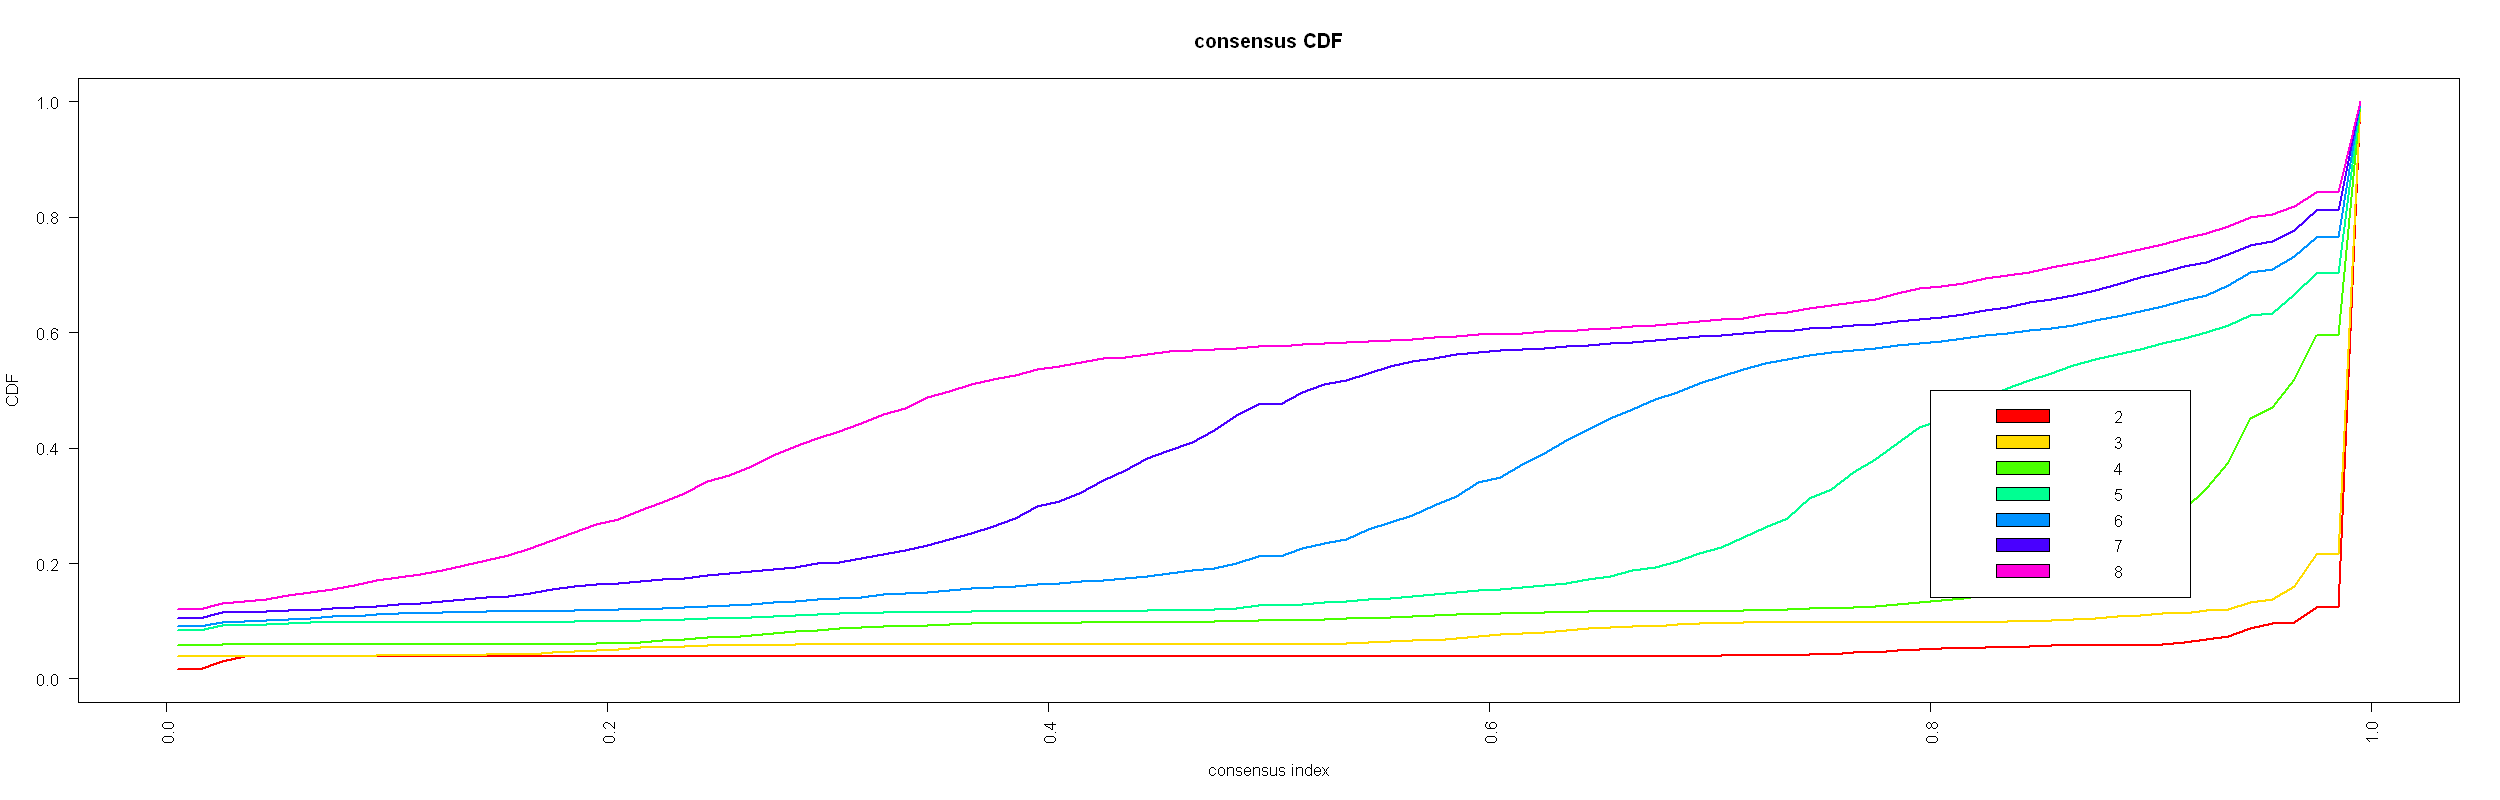

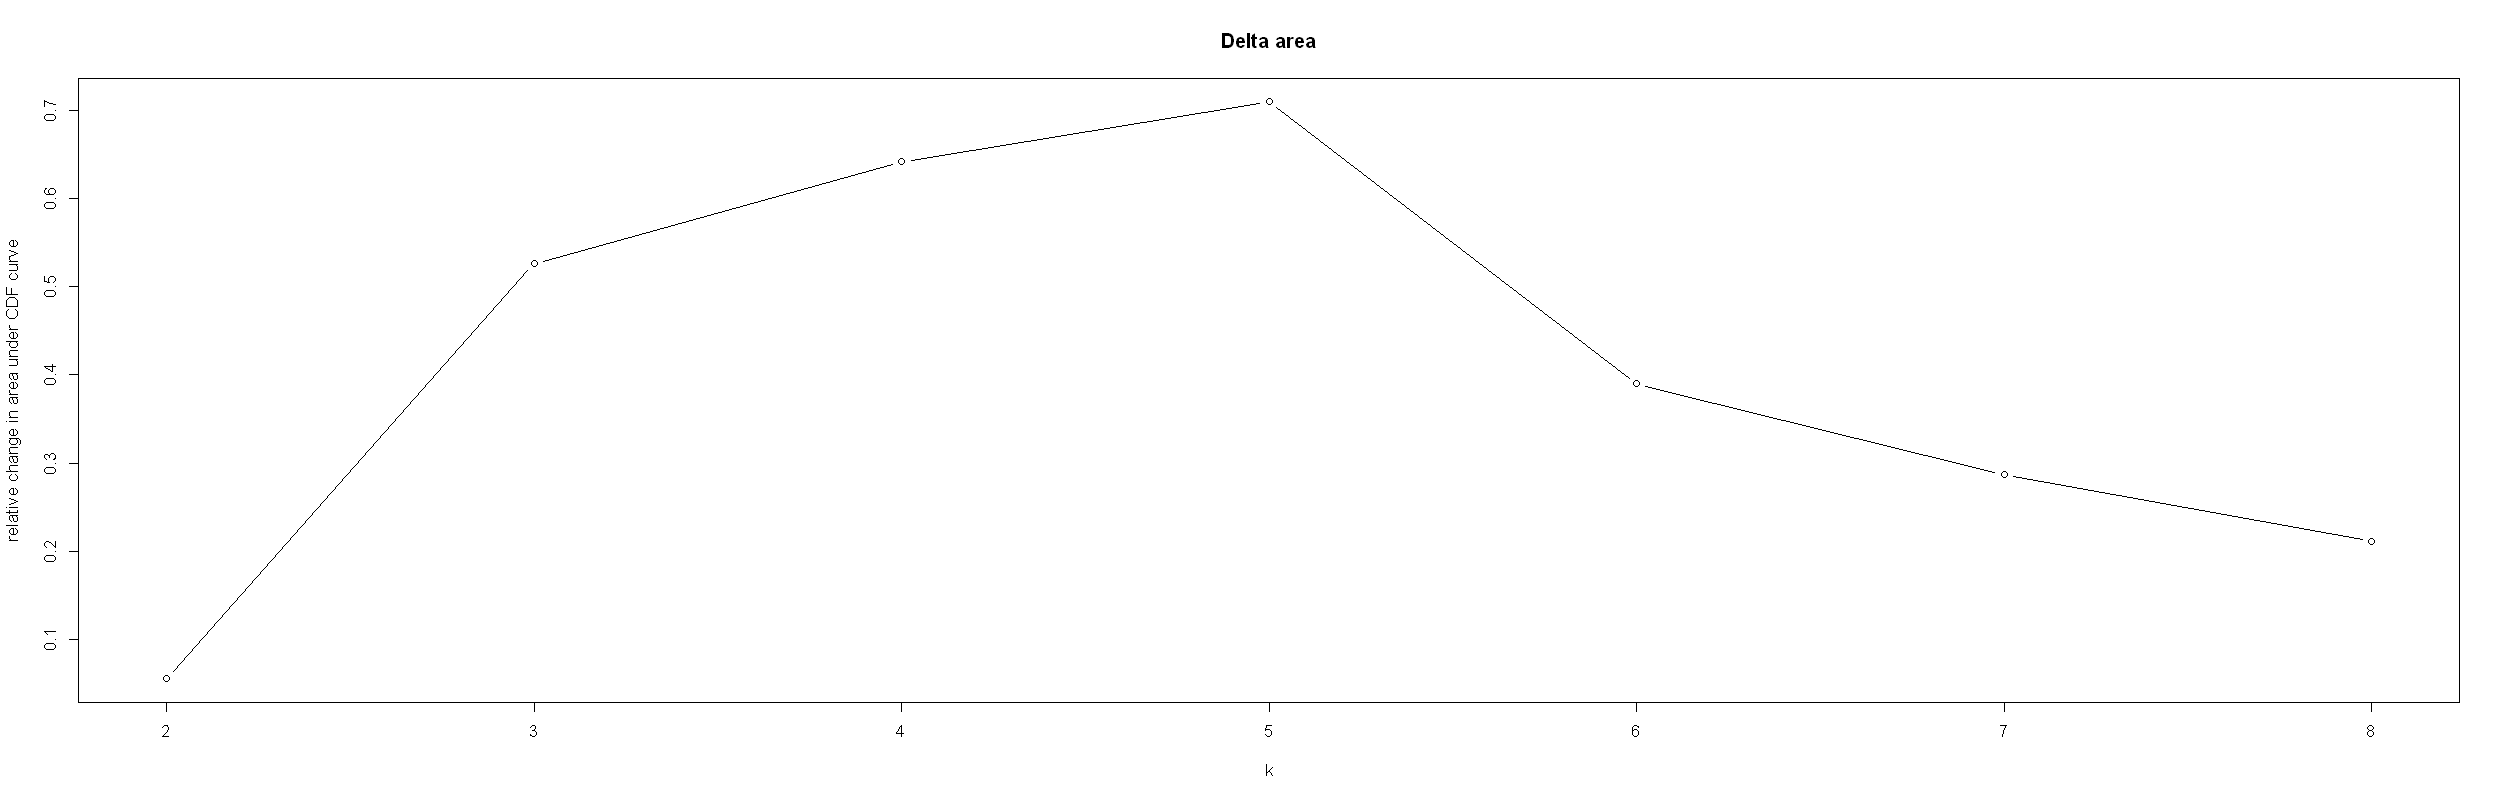

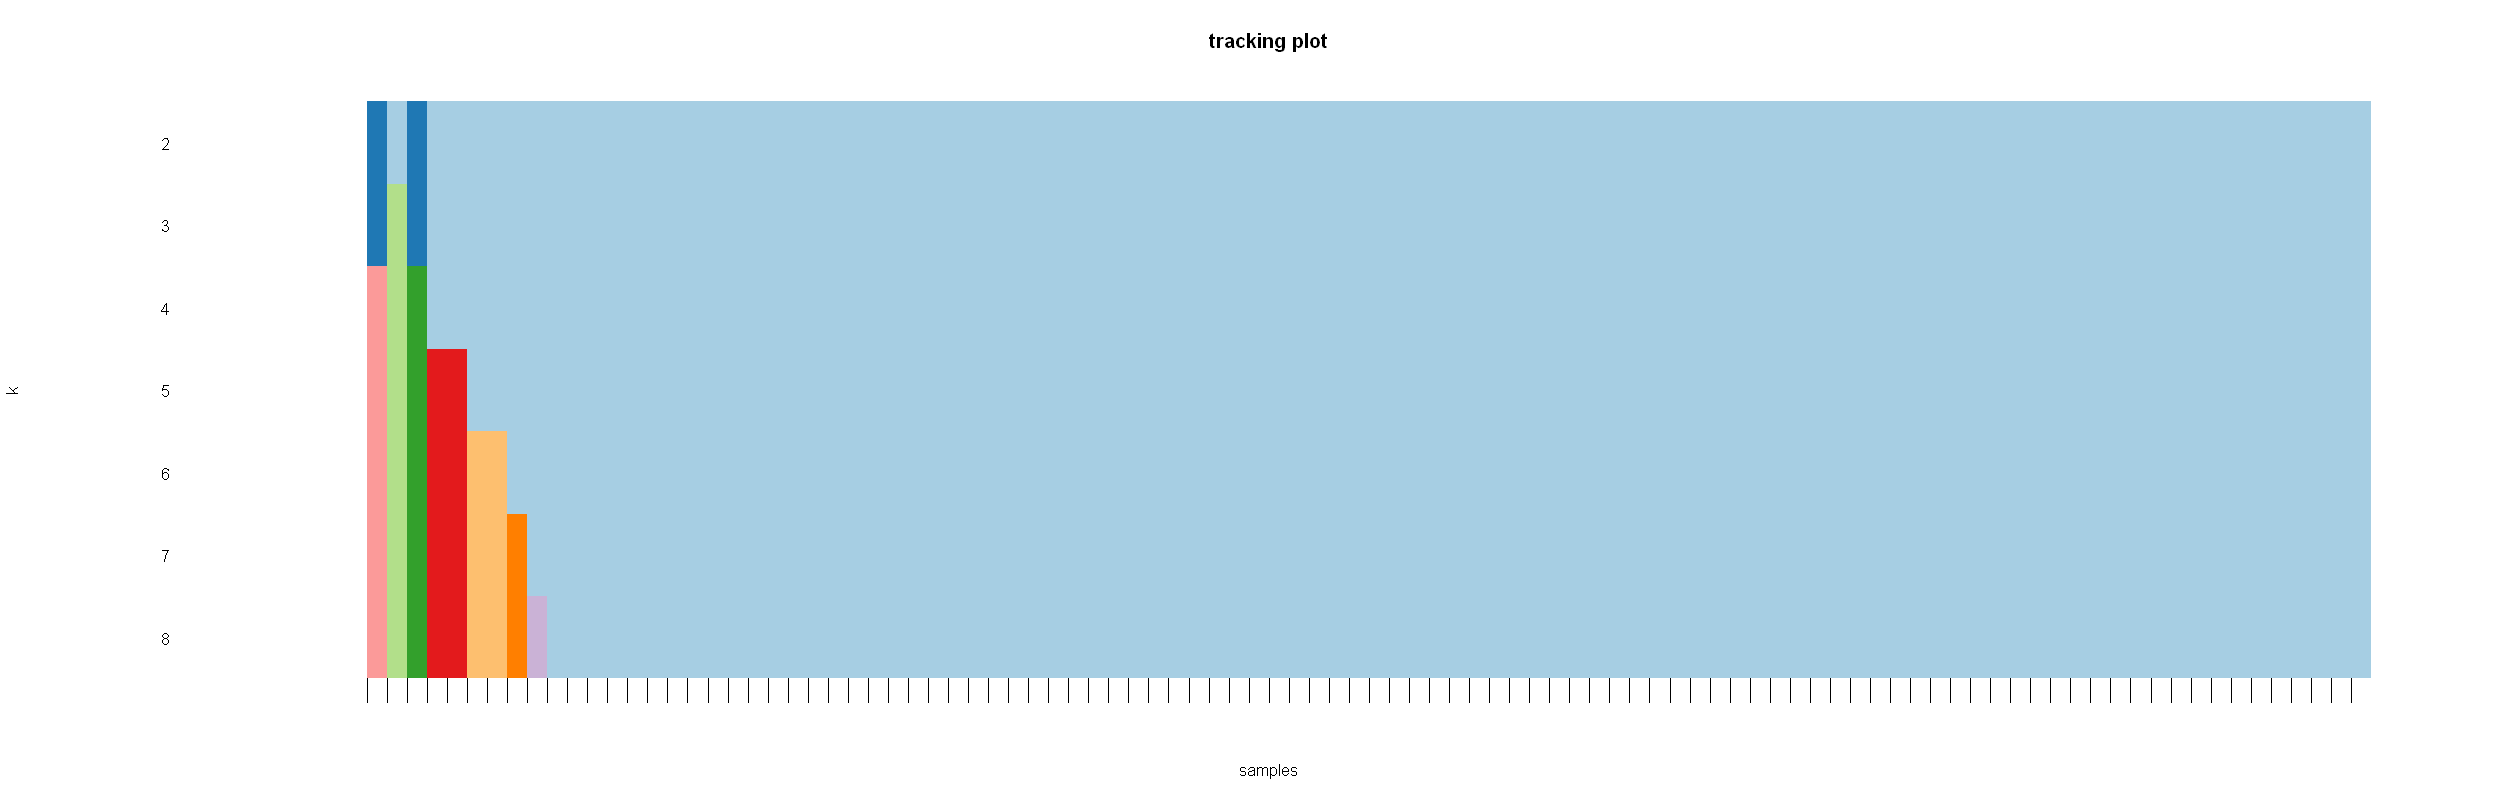

In [432]:
cc<-ConsensusClusterPlus(as.matrix(t(TCGA[ii,guse[1:500]])),maxK=8,reps=100,pItem=.6,pFeature=.6,distance="pearson",clusterAlg="hc")

In [448]:
ccu<-cc[[3]]
mda::confusion(ccu$consensusClass,TCGAclassstr[ii])
ccu<-cc[[5]]
mda::confusion(ccu$consensusClass,TCGAclassstr[ii])
ccu<-cc[[6]]
mda::confusion(ccu$consensusClass,TCGAclassstr[ii])

         true
predicted  BC GBM  KI  LU  OV   U
        1   1  56 216   0   2   6
        2 422   0   0   0  61   9
        3   0   0   0 192  30   5

         true
predicted  BC GBM  KI  LU  OV   U
        1   6  56   0   0   1   4
        2   0   0   0   1  92  15
        3   0   0   0 191   0   0
        4   0   0 216   0   0   1
        5 417   0   0   0   0   0

         true
predicted  BC GBM  KI  LU  OV   U
        1   1  56   0   0   1   4
        2   0   0   0   1  92  15
        3   0   0   0 191   0   0
        4   0   0 216   0   0   1
        5 267   0   0   0   0   0
        6 155   0   0   0   0   0

With 5 clusters you almost retrieve the classes. Try this with different methods, different sampling of observations and different features.

## Graphical Lasso - Networks and clusters

We have talked about the inverse covariance matrix in class, mainly as to how it's an essential component of DA classification since the inverse appears in our decusion rules. The problem with this was that for large numbers of features, strong correlations between features etc, the inverse may become numerically unstable. We "fixed" this by regularizating by for example adding something to the diagonal of the covariance before taking the inverse. This constitutes a form of shrinkage, mainly along the directions of small variation.

In class I briefly discussed another variant of regularized variance estimation called graphical lasso. This results in a sparse estimate of the inverse covariance where only features that are strongly, directly correlated have a non-zero entry in the matrix (see lecture notes).

The output from graphical lasso is a so-called adjecency matrix with non-zero entries between objects/features that are directly dependent and zero otherwise. The more heavily we regularize the inverse, the fewer direct connections are estimated as non-zero. This is called sparsity, i.e., the number or direct links between observations/features. 

Let's try this on the digit data set.

Conducting Meinshausen & Buhlmann graph estimation (mb)....done


[1] "method"    "path"      "beta"      "lambda"    "sparsity"  "df"       
 [7] "sym"       "scr"       "cov.input" "data"

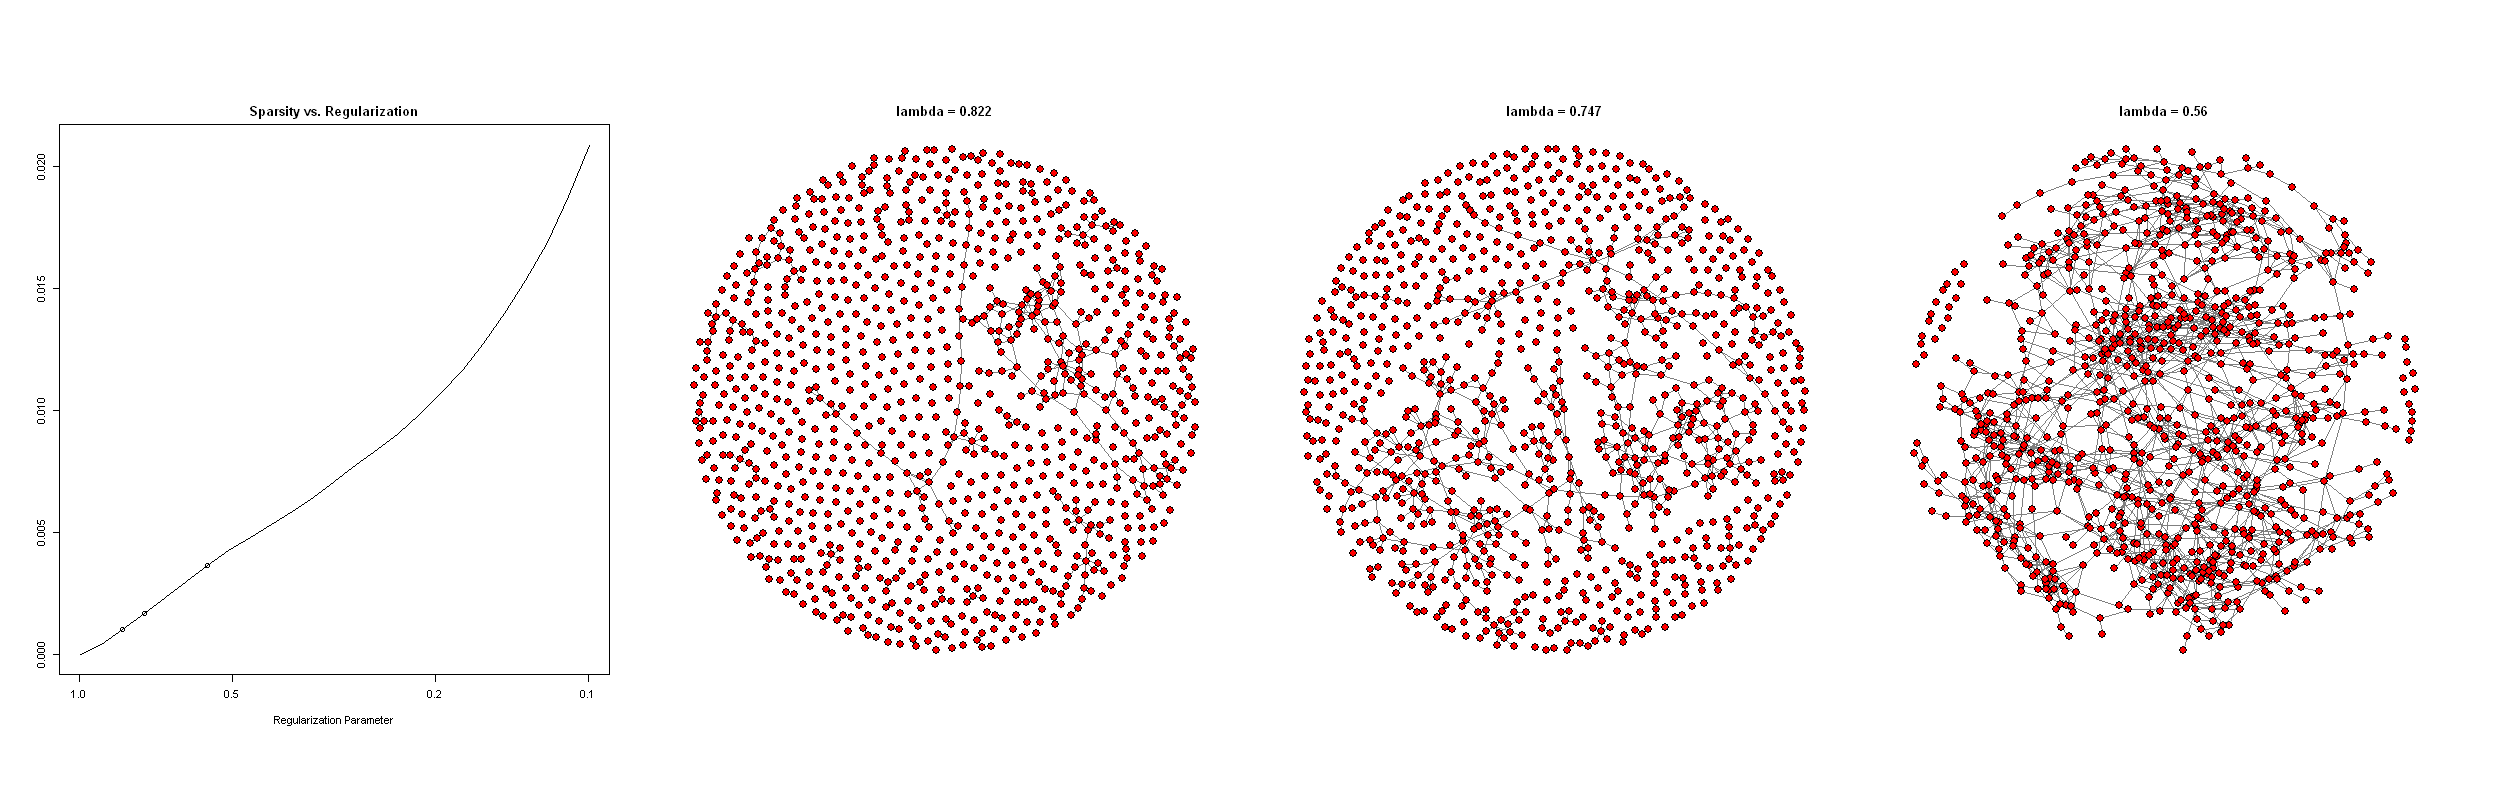

In [449]:
library(ElemStatLearn)
data(zip.train)
Nmat<-as.matrix(zip.train[,-1])
Numbers<-as.matrix(zip.train)
#
#install.packages("huge")
library(huge)
# The network modeling package using sparse gaussian graphical models
#help(huge)
#
its<-sample(seq(1,dim(Nmat)[1]),1000)
# select 1000 digits at random
gg<-huge(t(Nmat[its,]),nlambda=25)
names(gg)
plot(gg)

I prefer to use other packages to actually depict the resulting networks or graphs. 

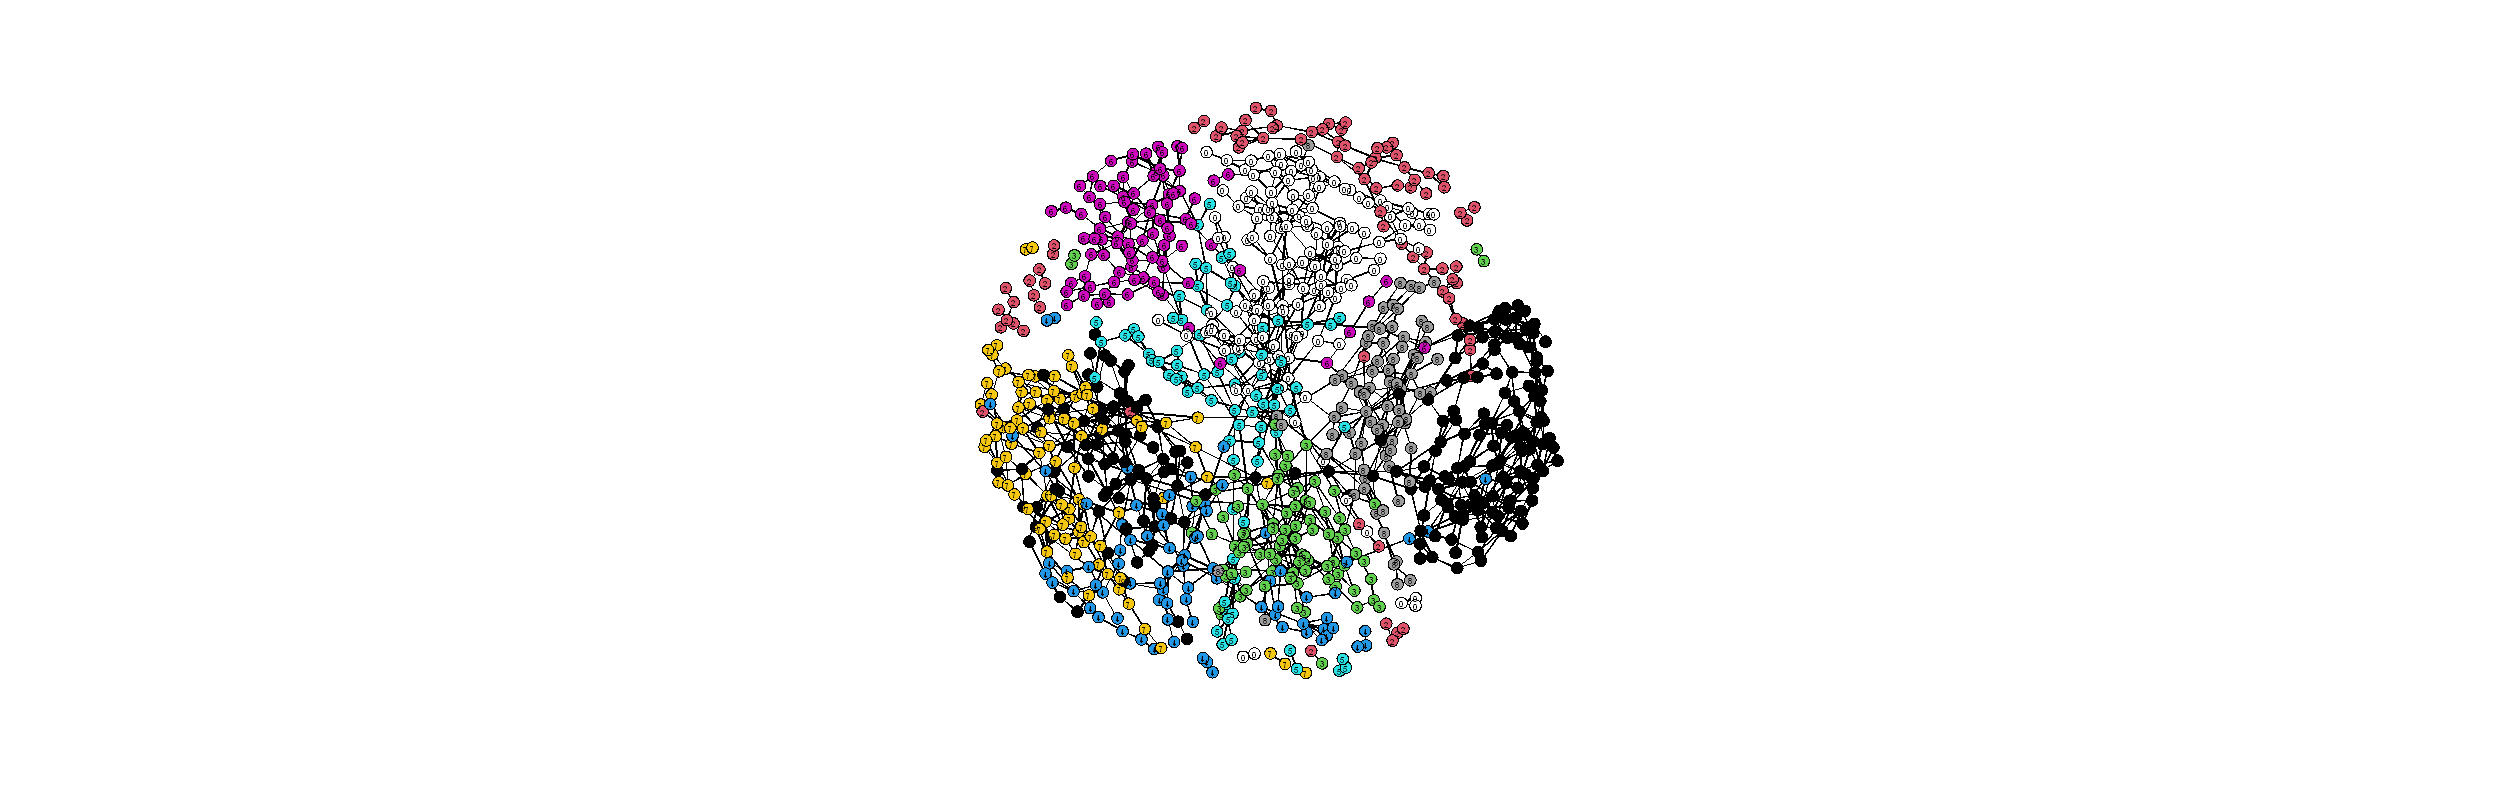

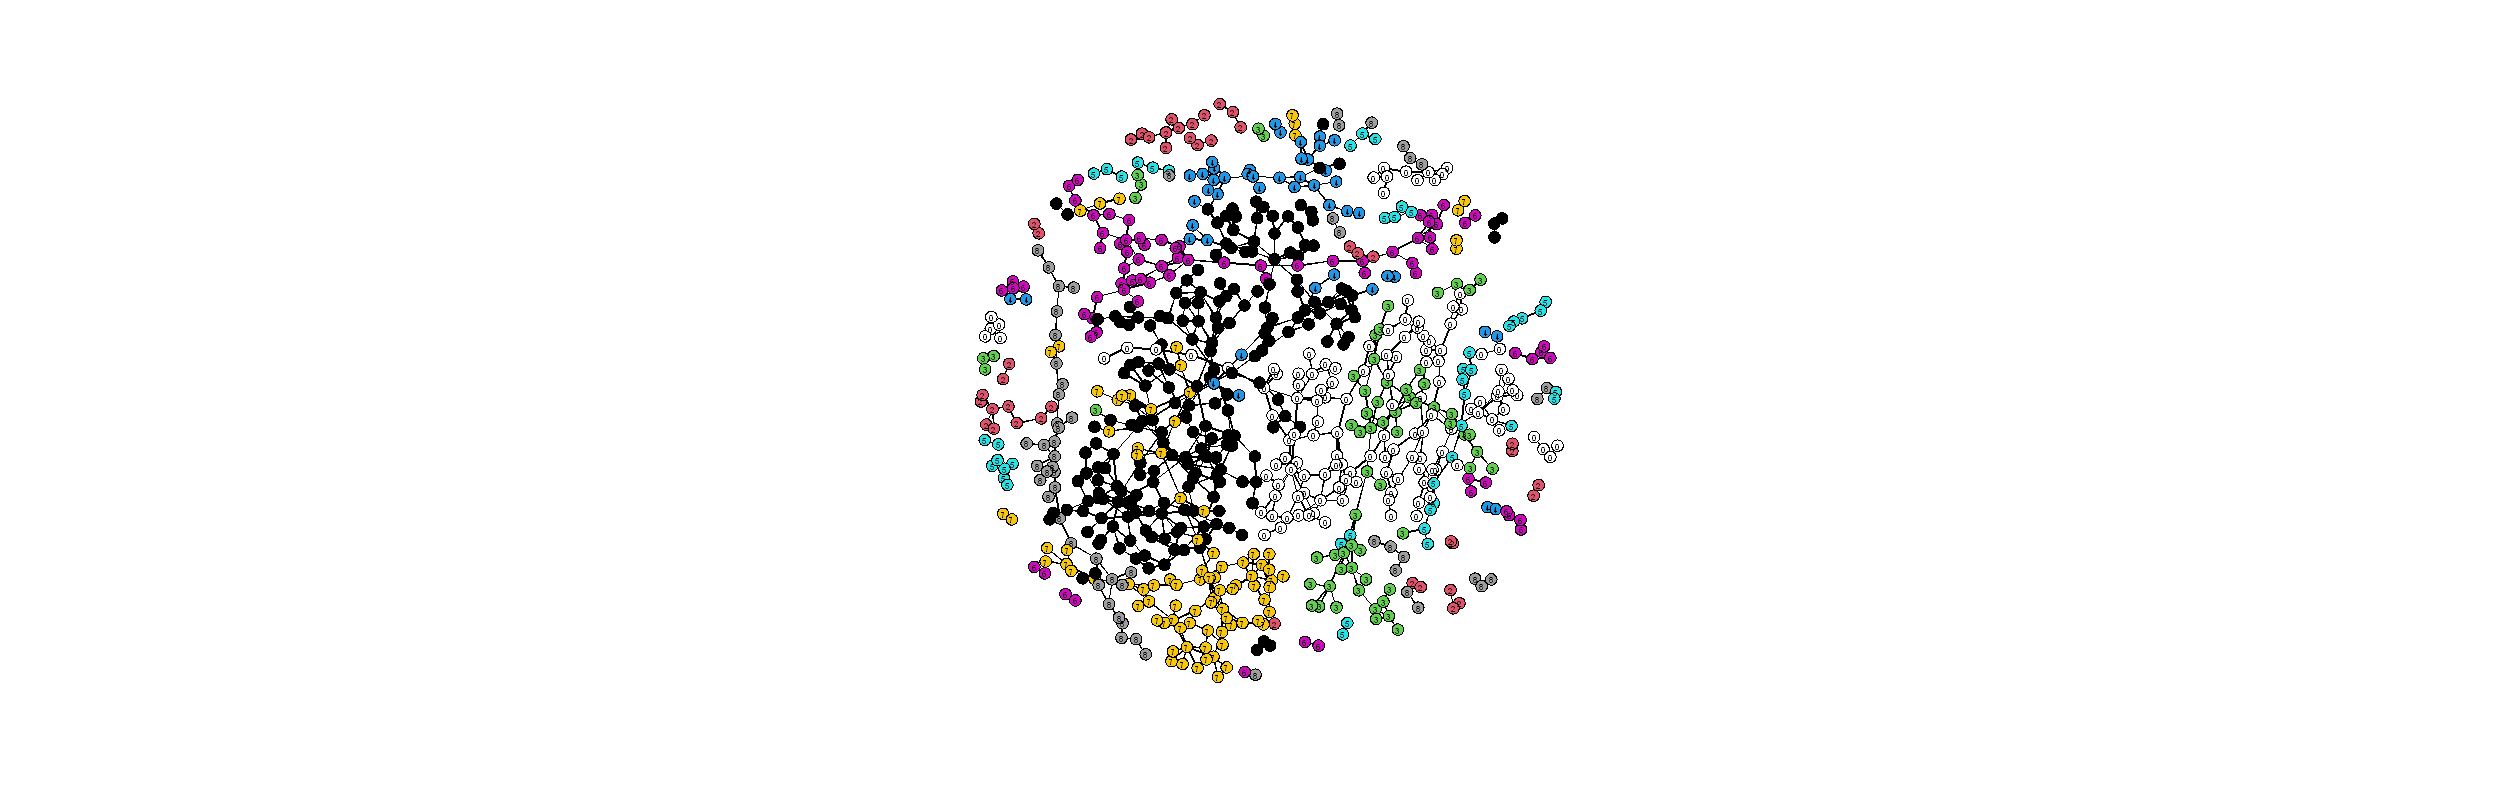

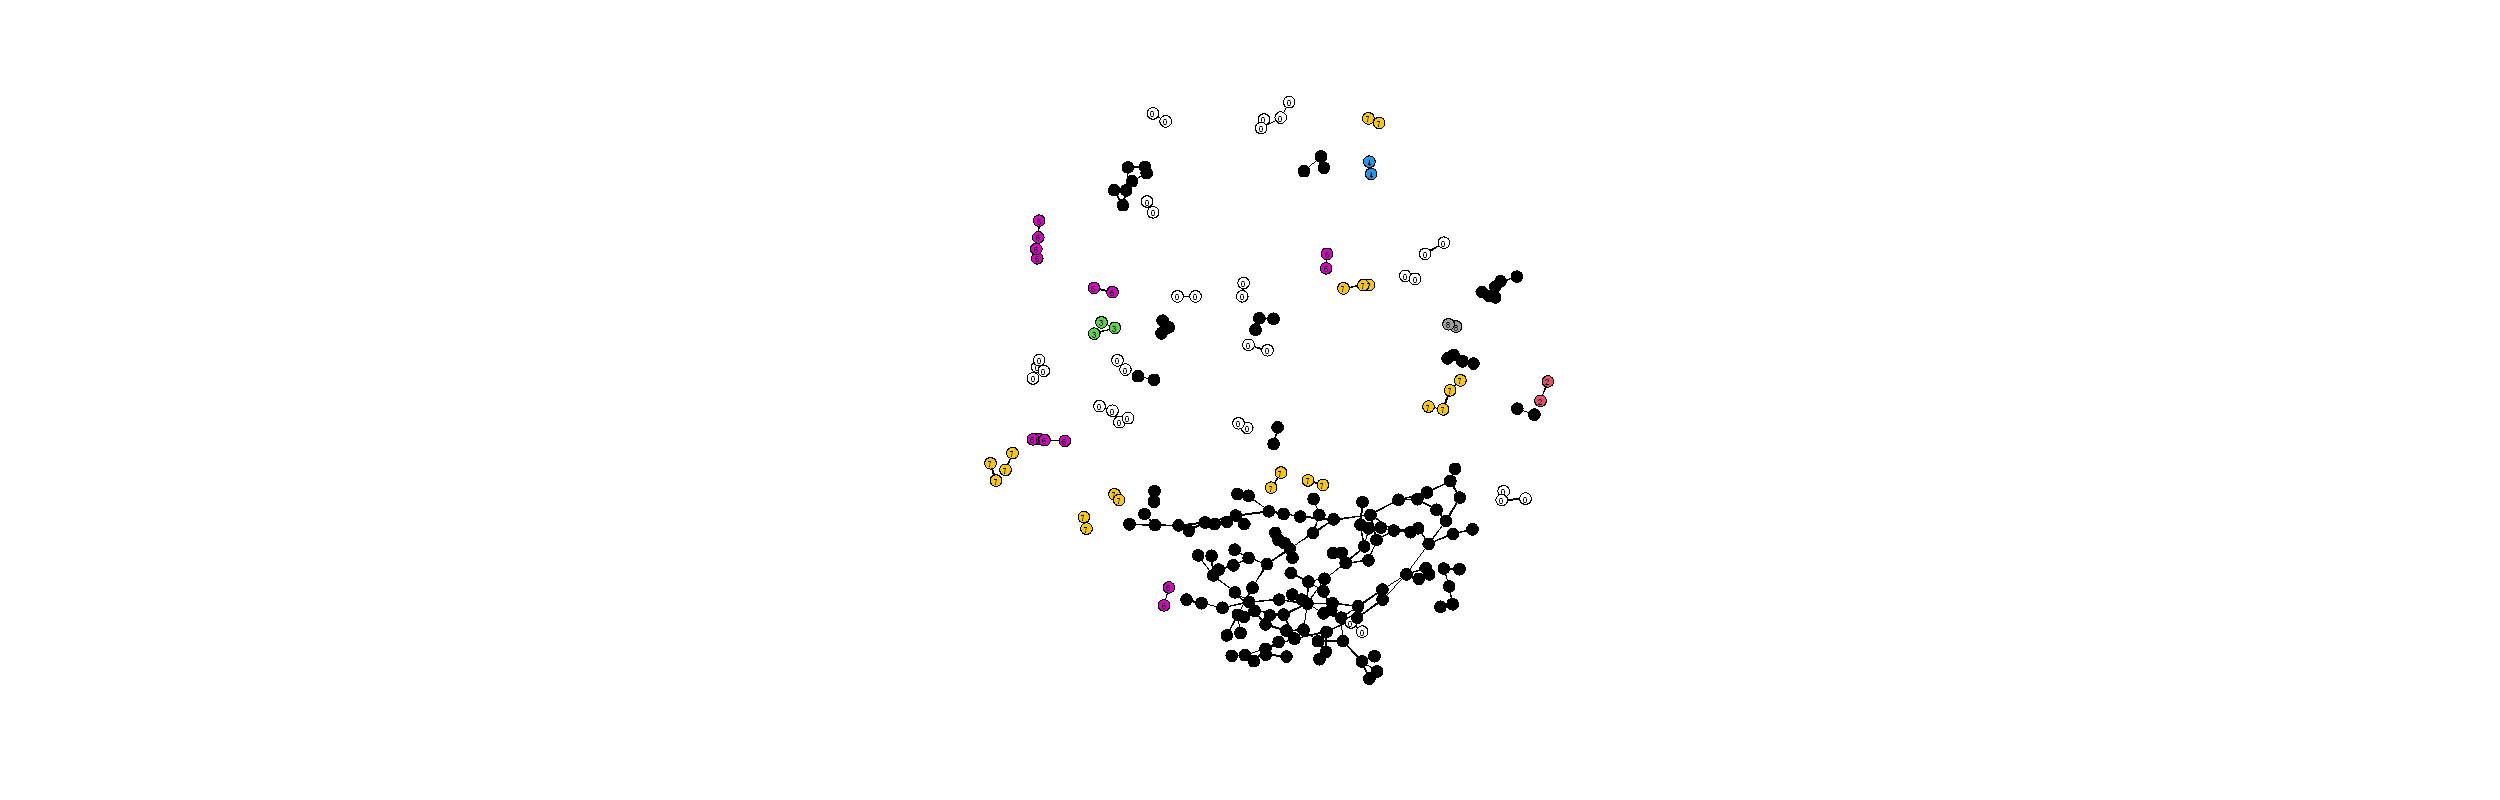

In [450]:
#install.packages("network")
library(network)
par(mfrow=c(1,1))
#plot.network(network(gg$path[[6]]),usearrows=F)
plot.network(network(gg$path[[6]]),usearrows=F,displayisolates=F,label=Numbers[its,1],label.pos=5,label.cex=.5,vertex.col=Numbers[its,1])
# plotting the graphical lasso output
#plot.network(network(gg$path[[4]]),usearrows=F)
plot.network(network(gg$path[[4]]),usearrows=F,displayisolates=F,label=Numbers[its,1],label.pos=5,label.cex=.5,vertex.col=Numbers[its,1])
#
#plot.network(network(gg$path[[2]]),usearrows=F)
plot.network(network(gg$path[[2]]),usearrows=F,displayisolates=F,label=Numbers[its,1],label.pos=5,label.cex=.5,vertex.col=Numbers[its,1])

With the network package I can add labels, arrows etc to my graph for richer visualizations.

Change the number in the double square brackets to look at networks of a different sparsity.

Notice how this method does a good job at separting the digits from one another while also illustrating that some individual numbers may be close to a digit from a different class.

We can apply this to the cancer data as well.

In [451]:
vv<-apply(TCGA,2,sd)
vv<-rev(sort.list(vv))
# Sort by top variance genes
library(irlba)
ss<-irlba(TCGA[,vv[1:5000]],nu=100,nv=100)
# leading 100 PCs
gg<-huge(t(ss$u),nlambda=25)


Conducting Meinshausen & Buhlmann graph estimation (mb)....done


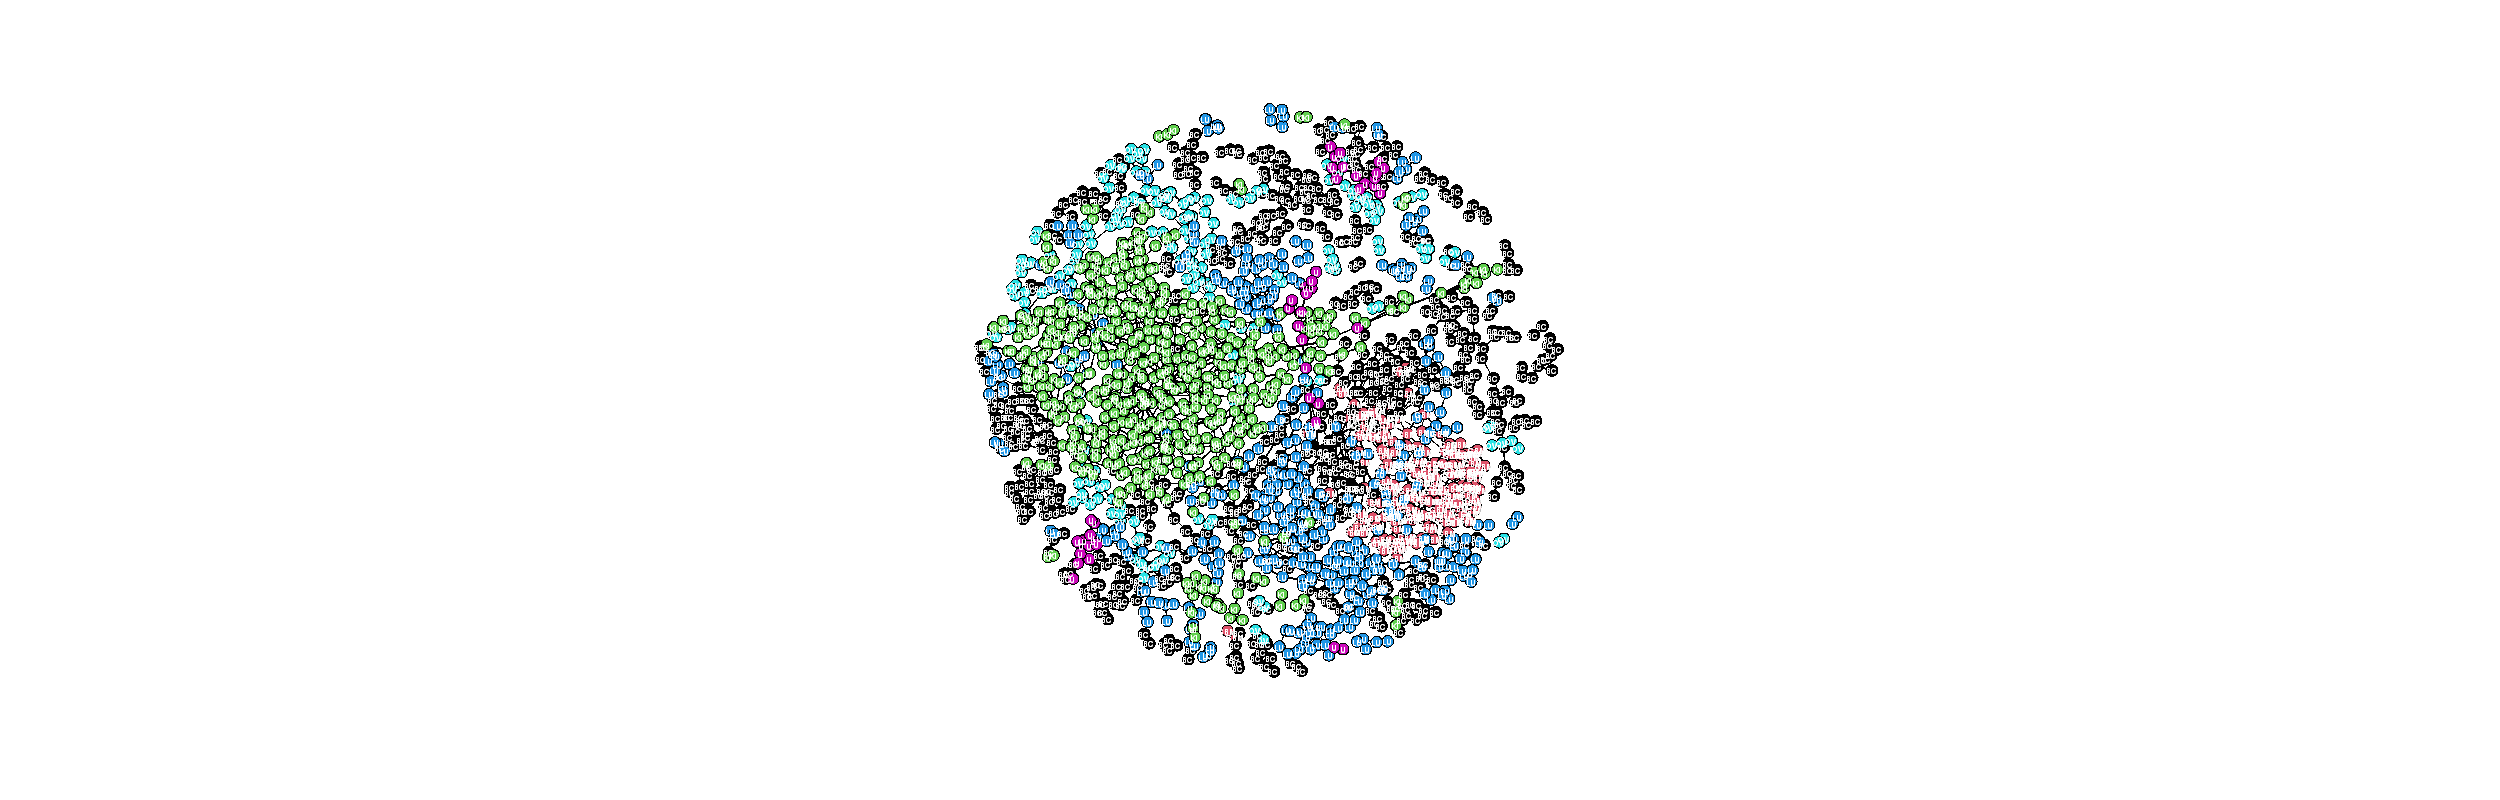

In [455]:
plot.network(network(gg$path[[7]]),usearrows=F,displayisolates=F,label=TCGAclassstr,label.pos=5,label.col="white",label.cex=.5,vertex.col=as.numeric(as.factor(TCGAclassstr)))

Again, you can see a clear separating of the cancer classes but also an indication that breast cancer may be split into two groups. Try looking at different levels of sparsity, with different number of PC component inputs etc.

You can apply this method to the features (genes) instead and construct a network of features. For the gene data application this is actually a very common technique. We are looking for gene sub-networks, or pathways, that form a functional component in the cell.

Conducting Meinshausen & Buhlmann graph estimation (mb)....done


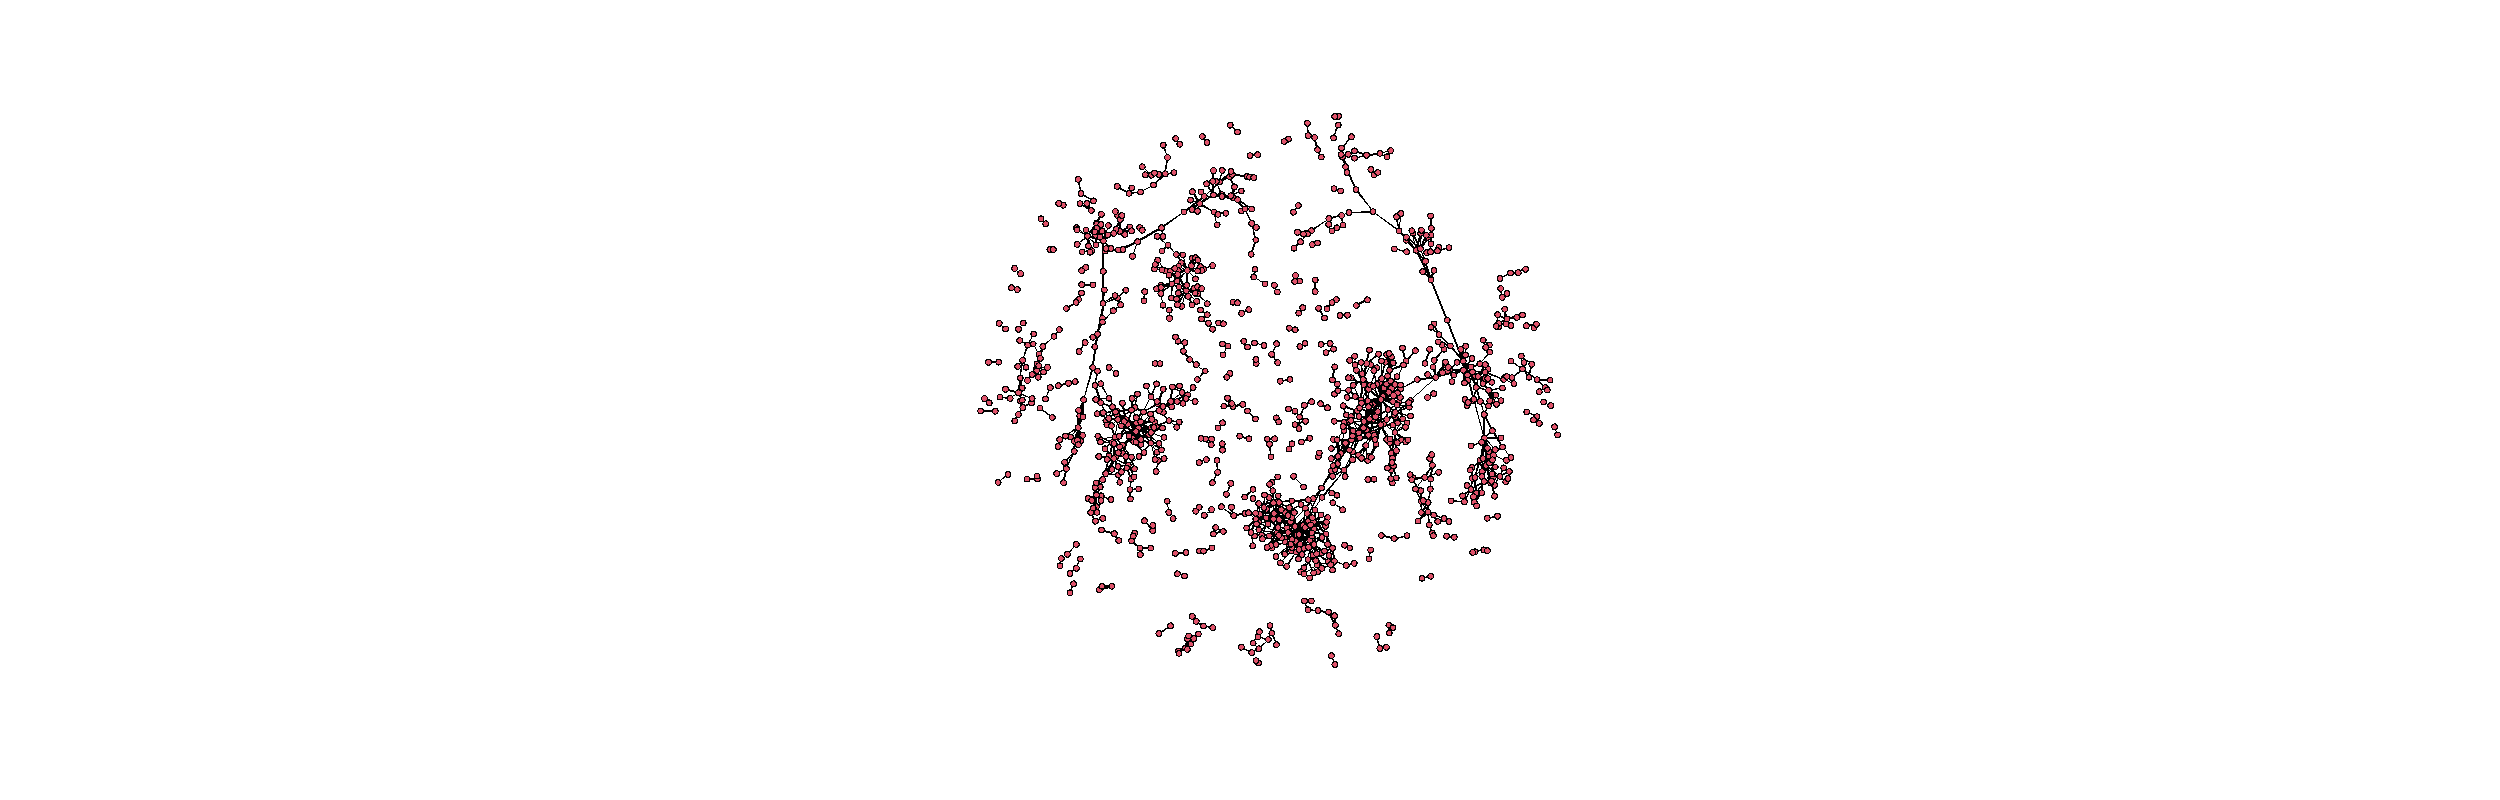

In [456]:
# network of genes instead
vv<-apply(TCGA,2,sd)
vv<-rev(sort.list(vv))
gg<-huge(TCGA[,vv[1:5000]])
plot.network(network(gg$path[[2]]),vertex.cex=.5,usearrows=F,displayisolates=F)

You see some subnetworks of different sizes and complexity. To get clusters (or modules) from a graph you can use various graph cutting algorithms. 